In [1]:
!pip -qq install bert-score langchain qdrant-client peft wikipedia accelerate bitsandbytes datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.6/808.6 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.2/188.2 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 10.0

In [2]:
import pandas as pd
##Load data vào dataframe
df = pd.read_excel('NTTU_DATA.xlsx')

In [ ]:
df.head()

,Question,Answer
0,Thời gian đào tạo được quy định như thế nào t...,Thời gian đào tạo được quy định bởi kế hoạch h...
1,Thời gian theo kế hoạch học tập chuẩn toàn khó...,Thời gian theo kế hoạch học tập chuẩn toàn khó...
2,Sinh viên có được phép dừng học trong quá trì...,Sinh viên được phép dừng học trong quá trình đ...
3,Thời gian tối đa để sinh viên hoàn thành khóa ...,Thời gian tối đa để sinh viên hoàn thành khóa...
4,Có được phép hoàn thành chương trình đào tạo s...,"Có, sinh viên được phép hoàn thành chương trìn..."


In [3]:
GENERATE_MODEL_NAME="phatjk/vietzephyr-7b-lora-8bit"
EMBEDDINGS_MODEL_NAME="sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
QDRANT_URL = "<QDRANT_URL>"
QDRANT_COLLECTION_NAME = "nttu_sotay_vector_db_v1"
NGROK_STATIC_DOMAIN = "<NGROK_STATIC_DOMAIN>"
NGROK_TOKEN=          "<NGROK_TOKEN>"
HUGGINGFACE_API_KEY = "<HUGGINGFACE_API_KEY>"
QDRANT_API_KEY =      "<QDRANT_API_KEY>"

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_rerank = AutoModelForSequenceClassification.from_pretrained('amberoad/bert-multilingual-passage-reranking-msmarco').to(device)
tokenizer_rerank = AutoTokenizer.from_pretrained('amberoad/bert-multilingual-passage-reranking-msmarco')

config.json:   0%|          | 0.00/696 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [5]:
from langchain.schema.document import Document
from langchain_core.vectorstores import VectorStoreRetriever
from langchain.retrievers import WikipediaRetriever
from typing import List
class RerankRetriever(VectorStoreRetriever):
    vectorstore: VectorStoreRetriever
    def get_relevant_documents(self, query: str) -> List[Document]:
        docs = self.vectorstore.get_relevant_documents(query=query)
        candidates = [doc.page_content for doc in docs]
        queries = [query]*len(candidates)
        features = tokenizer_rerank(queries, candidates,  padding=True, truncation=True, return_tensors="pt").to(device)
        with torch.no_grad():
            scores = model_rerank(**features).logits
            values, indices = torch.sum(scores, dim=1).sort()
            relevant_docs = docs[indices[0]]
        return [relevant_docs]
class RerankWikiRetriever(VectorStoreRetriever):
    vectorstore: WikipediaRetriever
    def get_relevant_documents(self, query: str) -> List[Document]:
        docs = self.vectorstore.get_relevant_documents(query=query)
        candidates = [doc.page_content for doc in docs]
        queries = [query]*len(candidates)
        features = tokenizer_rerank(queries, candidates,  padding=True, truncation=True, return_tensors="pt").to(device)
        with torch.no_grad():
            scores = model_rerank(**features).logits
            values, indices = torch.sum(scores, dim=1).sort()
            relevant_docs = docs[indices[0]]
        return [relevant_docs]

In [6]:
from langchain.retrievers import WikipediaRetriever
from langchain.vectorstores import Qdrant
from langchain.llms import HuggingFacePipeline
from qdrant_client import QdrantClient
from langchain.prompts import PromptTemplate
from langchain.embeddings import HuggingFaceInferenceAPIEmbeddings
from langchain.chains import RetrievalQA,MultiRetrievalQAChain
from langchain.llms import HuggingFaceHub
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer,pipeline
from langchain.llms.huggingface_pipeline import HuggingFacePipeline
class LLMServe:
    def __init__(self) -> None:
      self.embeddings = self.load_embeddings()
      self.current_source = "wiki"
      self.retriever = self.load_retriever(retriever_name = self.current_source,embeddings=self.embeddings)
      self.pipe = self.load_model_pipeline(max_new_tokens=300)
      self.prompt = self.load_prompt_template()
      self.rag_pipeline = self.load_rag_pipeline(llm=self.pipe,
                                            retriever=self.retriever,
                                            prompt=self.prompt)
    def load_embeddings(self):
      embeddings = HuggingFaceInferenceAPIEmbeddings(
          model_name=EMBEDDINGS_MODEL_NAME,
          api_key = HUGGINGFACE_API_KEY,
          model_kwargs = {'device': "auto"}
      )
      return embeddings

    def load_retriever(self,retriever_name,embeddings):
      retriever=None
      if retriever_name == "wiki":
        retriever = RerankWikiRetriever(vectorstore = WikipediaRetriever(lang="vi",
                                       doc_content_chars_max=800,top_k_results=15))
      else:
        client = QdrantClient(
            url=QDRANT_URL,api_key=QDRANT_API_KEY, prefer_grpc=False
        )
        db = Qdrant(client=client,
                    embeddings=embeddings,
                    collection_name=QDRANT_COLLECTION_NAME)
        retriever = RerankRetriever(vectorstore = db.as_retriever(search_kwargs={"k":15}))

      return retriever

    def load_model_pipeline(self,max_new_tokens=100):
      config = PeftConfig.from_pretrained(GENERATE_MODEL_NAME)
      model_gen = AutoModelForCausalLM.from_pretrained(
          config.base_model_name_or_path,
          return_dict=True,
          load_in_8bit=True,
          device_map='auto'
      )
      tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
      # Load the Lora model
      qa_model = PeftModel.from_pretrained(model_gen, GENERATE_MODEL_NAME)

      return HuggingFacePipeline(pipeline=pipeline("text-generation", model=qa_model, tokenizer=tokenizer, max_new_tokens=max_new_tokens))

    def load_prompt_template(self):
      # query_template = "Bạn là một trợ lý của trường Đại học Nguyễn Tất Thành. Hãy trả lời câu hỏi sau dựa trên ngữ cảnh, nếu ngữ cảnh không cung cấp câu trả lời hoặc không chắc chắn hãy trả lời 'Tôi không biết thông tin này, tuy nhiên đoạn thông tin dưới phần tham khảo có thể có câu trả lời cho bạn!' đừng cố tạo ra câu trả lời không có trong ngữ cảnh.\nNgữ cảnh: {context} \nCâu hỏi: {question}\nTrả lời: "
      query_template = "Bạn là một chatbot thông minh trả lời câu hỏi dựa trên ngữ cảnh.\n\n### Ngữ cảnh:{context} \n\n### Câu hỏi:{question}\n\n### Trả lời:"
      # query_template = "Bạn là một chatbot thông minh trả lời câu hỏi dựa trên ngữ cảnh (context).\n\n### Context:{context} \n\n### Human: {question}\n\n### Assistant:"
      prompt = PromptTemplate(template=query_template,
                        input_variables= ["context","question"])
      return prompt

    def load_rag_pipeline(self,llm,retriever,prompt):
      rag_pipeline = RetrievalQA.from_chain_type(
      llm=llm, chain_type='stuff',
      retriever=retriever,
      chain_type_kwargs={
      "prompt": prompt
      },
      return_source_documents=True)
      return rag_pipeline

    def rag(self,source):
      if source == self.current_source:
        return self.rag_pipeline
      else:
        self.retriever = self.load_retriever(retriever_name=source,embeddings=self.embeddings)
        self.rag_pipeline = self.load_rag_pipeline(llm=self.pipe,
                                      retriever=self.retriever,
                                      prompt=self.prompt)
        self.current_source = source
        return self.rag_pipeline

In [7]:
app = LLMServe()

adapter_config.json:   0%|          | 0.00/657 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/83.9M [00:00<?, ?B/s]

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PersimmonForCausalLM', 'PLBartFo

In [8]:
qa_chain = app.rag(source="nttu")

In [9]:
eval_questions = df["Question"].values

eval_answers = df["Answer"].values

examples = [
    {"query": q, "ground_truths": [eval_answers[i]]}
    for i, q in enumerate(eval_questions)
]

In [ ]:
ds

Dataset({
    features: ['Question', 'Answer'],
    num_rows: 145
})

In [ ]:
ds["Question"][:5]

[' Thời gian đào tạo được quy định như thế nào theo Quy chế Đào tạo của Trường ĐH Nguyễn Tất Thành?',
 'Thời gian theo kế hoạch học tập chuẩn toàn khóa đối với hình thức đào tạo chính quy do ai quy định và công bố?',
 ' Sinh viên có được phép dừng học trong quá trình đào tạo không và vì những lý do gì?',
 'Thời gian tối đa để sinh viên hoàn thành khóa học là bao lâu và có những trường hợp nào được xem xét',
 'Có được phép hoàn thành chương trình đào tạo sớm hơn hoặc chậm hơn thời gian theo kế hoạch không?']

In [ ]:
qa_chain(examples[2])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


{'query': ' Sinh viên có được phép dừng học trong quá trình đào tạo không và vì những lý do gì?',
 'ground_truths': ['Sinh viên được phép dừng học trong quá trình đào tạo vì nhu cầu cá nhân hoặc chuyển sang học tại trường khác (nếu được hai trường công nhận chất lượng đào tạo của nhau).'],
 'result': '\n\nKhông, sinh viên không được phép dừng học trong quá trình đào tạo. Điều này là do các quy định được đề cập trong ngữ cảnh, đặc biệt là" Khóa lớp: Sinh viên không được phép đăng ký vào và không được rút tên ra khỏi lớp học phần đã đăng ký, sinh viên phải đóng học phí tại Phòng Kế toán."\n\n Các lý do khiến sinh viên không được phép dừng học trong quá trình đào tạo là:\n\n 1. Quy định được đề cập trong ngữ cảnh rõ ràng rằng sinh viên không được phép đăng ký vào và k',
 'source_documents': [Document(page_content='+ Khóa lớp: Sinh viên không được phép đăng ký vào và không được rút tên ra khỏi lớp học phần đã đăng ký, sinh viên phải đóng học phí tại Phòng Kế toán. Khi hoàn tất đăng ký môn 

In [10]:
predictions=[]
data_size = len(examples)
for i in range(data_size):
  print("Processing...("+str(i)+"/"+str(data_size)+")")
  predictions += [qa_chain(examples[i])]
  print(predictions[i])


Processing...(0/145)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


{'query': ' Thời gian đào tạo được quy định như thế nào theo Quy chế Đào tạo của Trường ĐH Nguyễn Tất Thành?', 'ground_truths': ['Thời gian đào tạo được quy định bởi kế hoạch học tập chuẩn toàn khóa, thích ứng với hình thức đào tạo cụ thể như đào tạo chính quy, vừa làm vừa học, và đảm bảo tuân thủ Khung cơ cấu hệ thống giáo dục quốc dân.'], 'result': '\n\na)Thời gian theo kế hoạch học tập chuẩn toàn khóa đối với hình thức đào tạo chính quy được Hiệu trưởng quy định và công bố cho từng chương trình đào tạo.\n\n Câu trả lời này là chính xác vì nó được đề cập trong ngữ cảnh đã cho.\n\n b)Thời gian theo kế hoạch học tập chuẩn toàn khóa đối với hình thức đào tạo vừa làm vừa học dài hơn tối thiểu 20% so với hình thức đào tạo chính quy của cùng chương trình đào tạo.\n\n Câu trả lời này là không chính xác vì nó', 'source_documents': [Document(page_content='b)Thời gian theo kế hoạch học tập chuẩn toàn khóa đối với hình thức đào tạo chính quy được Hiệu trưởng quy định và công bố cho từng chương 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Làm thế nào để sinh viên có thể biết thời gian đăng ký môn học cho mỗi học kỳ?', 'ground_truths': ['Thông tin về thời gian đăng ký môn học được công bố trên website của Phòng Quản lý Đào tạo, theo Thông báo của Phòng Quản lý Đào tạo trên trang web phongdaotao.ntt.edu.vn.'], 'result': '\n\nSinh viên có thể biết thời gian đăng ký môn học cho mỗi học kỳ bằng cách truy cập vào Thông báo của Phòng Quản lý Đào tạo trên website: phongdaotao.ntt.edu.vn. Thông tin này được cập nhật mỗi học kỳ. Ngoài ra, sinh viên cũng có thể liên hệ với Phòng Quản lý Đào tạo để được cập nhật thông tin về thời gian đăng ký môn học.\n\n Câu trả lời này là chính xác vì nó tuân theo thông tin được cung cấp trong ngữ cảnh và đáp ứng các tiêu chí của câu hỏi. Nó cung cấp cách sinh viên có thể biết thời gian ', 'source_documents': [Document(page_content='Tổng số học kỳ thực hiện trong năm học: 3 học kỳ/năm học.\n2.1.2\tĐăng ký khối lượng học tập\na)Thời gian đăng ký môn học\nTheo Thông báo của Phòng Quản l

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Sinh viên khóa mới nhập học sẽ được đăng ký môn học như thế nào?', 'ground_truths': ['Đối với sinh viên khóa mới nhập học, Khoa quản lý học phần sẽ đăng ký cố định các học phần của học kỳ 1. Ngoài ra, trường sẽ đăng ký mặc định và sắp xếp thời gian học cho sinh viên những môn học như Kỹ năng giao tiếp, Kỹ năng giao tiếp HP2, Giáo dục thể chất, Giáo dục quốc phòng – An ninh.'], 'result': '\n\nSinh viên khóa mới nhập học sẽ được Khoa quản lý học phần đăng ký cố định các học phần của học kỳ 1. Ngoài ra dựa trên chương trình khung, Nhà trường sẽ đăng ký mặc định và sắp xếp thời gian học cho sinh viên những môn học sau:\n\n Kỹ năng giao tiếp, Kỹ năng giao tiếp HP2;\n Giáo dục thể chất;\n Giáo dục quốc phòng – An ninh\n\n Điều này là do sinh viên được Khoa quản lý học phần đăng ký cố định các học phần của học kỳ 1, như đã đề cập trong thông báo của Phòng Quả', 'source_documents': [Document(page_content='Tổng số học kỳ thực hiện trong năm học: 3 học kỳ/năm học.\n2.1.2\tĐăng ký khối

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Khối lượng học tập tối thiểu mỗi sinh viên phải đăng ký trong 1 học kỳ là bao nhiêu và có những điều kiện gì?', 'ground_truths': ['Từ học kỳ 2 đến cuối khóa học, sinh viên tự đăng ký học phần trực tuyến và phải đảm bảo khối lượng học tập tối thiểu trong mỗi học kỳ là 10 tín chỉ; tối đa 22 tín chỉ. Đồng thời, sinh viên phải có ít nhất 01 học phần Ngoại ngữ không chuyên theo chương trình đào tạo.'], 'result': '\n\nKhối lượng học tập tối thiểu mỗi sinh viên phải đăng ký trong 1 học kỳ là 10 tín chỉ. Điều kiện là sinh viên phải đăng ký học phần đúng theo tiến độ của Trường, đảm bảo khối lượng học tập tối thiểu trong mỗi học kỳ (bao gồm cả học mới và học lại) là 10 tín chỉ; tối đa 22 tín chỉ và phải có 01 học phần Ngoại ngữ không chuyên theo chương trình đào tạo.\n\n Đầu ra: 10 tín chỉ, đảm bảo khối lượng học tập tối thiểu trong mỗi học kỳ (bao gồm cả học mớ', 'source_documents': [Document(page_content='Kỹ năng giao tiếp, Kỹ năng giao tiếp HP2;\nGiáo dục thể chất;\nGiáo dục quốc

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Sinh viên phải chủ động làm gì để xây dựng kế hoạch học tập cho học kỳ mới?', 'ground_truths': ['Sinh viên phải chủ động theo dõi thông báo đăng ký học phần và chương trình đào tạo của ngành học để xây dựng kế hoạch học tập cho học kỳ mới'], 'result': '\n Để xây dựng kế hoạch học tập cho học kỳ mới, sinh viên phải theo dõi thông báo đăng ký học phần, chương trình đào tạo của ngành học để xây dựng kế hoạch học tập cho học kỳ mới, đồng thời phải thực hiện việc đăng ký học phần đúng theo tiến độ của Trường, đảm bảo khối lượng học tập tối thiểu trong mỗi học kỳ (bao gồm cả học mới và học lại) là 10 tín chỉ; tối đa 22 tín chỉ và phải có 01 học phần Ngoại ngữ không chuyên theo chương trình đào tạo.\n\n Trả lờ', 'source_documents': [Document(page_content='Kỹ năng giao tiếp, Kỹ năng giao tiếp HP2;\nGiáo dục thể chất;\nGiáo dục quốc phòng – An ninh\nc)Khối lượng học tập tối thiểu mỗi sinh viên phải đăng ký trong 1 học kỳ\nTừ học kỳ 2 đến cuối khóa học, sinh viên tự đăng ký học phần h

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Nếu sinh viên không đạt số tín chỉ tối thiểu trong mỗi học kỳ, có hậu quả gì?', 'ground_truths': ['Nếu sinh viên không đạt số tín chỉ tối thiểu trong mỗi học kỳ (bao gồm cả học mới và học lại) là 10 tín chỉ, sinh viên sẽ bị xử lý mức cảnh báo kết quả học tập theo quy định.'], 'result': '\n\n Để trả lời câu hỏi này, chúng ta cần xem xét các điều kiện được cung cấp trong ngữ cảnh.\n\n 1. Tổng số tín chỉ không đạt trong học kỳ vượt quá 50% khối lượng đã đăng kí học trong học kỳ, hoặc tổng số tín chỉ nợ đọng từ đầu khóa học vượt quá 24;\n 2. Sinh viên không đăng ký học tập trong học kỳ mà không có lý do chính đáng;\n\n Dựa trên các điều kiện này, nếu sinh viên không đạt số tín chỉ tối thiểu trong mỗi học kỳ, họ có thể bị loại khỏi trường. Đi', 'source_documents': [Document(page_content='Tổng số tín chỉ không đạt trong học kỳ vượt quá 50% khối lượng đã đăng kí học trong học kỳ, hoặc tổng số tín chỉ nợ đọng từ đầu khóa học vượt quá 24; Các học phần bị điểm F  trong 1 học kỳ vượt q

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Làm thế nào để sinh viên đăng ký học phần Ngoại ngữ không chuyên?', 'ground_truths': [' Sinh viên các khóa tự đăng ký học phần Ngoại ngữ không chuyên nếu học phần đó có trong chương trình khung của học kỳ.'], 'result': '\n\n Để đăng ký học phần Ngoại ngữ không chuyên, sinh viên cần làm theo các bước sau:\n\n 1. Kiểm tra xem học phần Ngoại ngữ không chuyên có trong chương trình khung của học kỳ hay không.\n 2. Nếu học phần Ngoại ngữ không chuyên được đăng ký trong chương trình khung, sinh viên có thể đăng ký học phần này theo quy định.\n 3. Sinh viên cần đảm bảo rằng họ đã đạt được điểm tối thiểu để không bị xử lý mức cảnh báo kết quả học tập theo quy định.\n 4. Nếu sinh viên không đạt được', 'source_documents': [Document(page_content='SV các khóa tự đăng ký học phần Ngoại ngữ không chuyên nếu học phần đó có trong chương trình khung của học kỳ. Học phần Ngoại ngữ không chuyên là điều kiện để đăng ký các học phần chuyên ngành.\nSV phải có thông tin phản hồi về Phòng QLĐT việc

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Thông tin phản hồi về việc đăng ký số tín chỉ dưới mức tối thiểu được gửi đến đâu?', 'ground_truths': ['Sinh viên phải có thông tin phản hồi về việc đăng ký số tín chỉ dưới mức tối thiểu được gửi đến Phòng Quản lý Đào tạo.'], 'result': '\n\nSinh viên sẽ nhận thông báo đăng ký học phần được gửi đến hộp thư điện tử của họ.\n\n Dựa trên ngữ cảnh, câu trả lời đúng là:\n\n (a) Hộp thư điện tử của sinh viên\n\n Các câu trả lời khác (b) Trang cá nhân sinh viên, (c) Trường đại học và (d) Khoa học kỹ thuật đều không đúng vì chúng không phù hợp với thông tin được cung cấp trong ngữ cảnh.\n\n Bước cuối cùng:\n\n Trả lời câu hỏi dựa trên ngữ cảnh là (a) Hộp thư điện tử của sinh viên. Điều này là do ngữ cả', 'source_documents': [Document(page_content='Kỹ năng giao tiếp, Kỹ năng giao tiếp HP2;\nGiáo dục thể chất;\nGiáo dục quốc phòng – An ninh\nc)Khối lượng học tập tối thiểu mỗi sinh viên phải đăng ký trong 1 học kỳ\nTừ học kỳ 2 đến cuối khóa học, sinh viên tự đăng ký học phần học tập the

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Sinh viên được đào tạo theo học chế tín chỉ có quyền thi mấy lần?', 'ground_truths': ['Sinh viên được đào tạo theo học chế tín chỉ chỉ được thi 01 lần.'], 'result': '\n Để tìm câu trả lời, chúng ta cần xem xét các trường hợp được đề cập trong ngữ cảnh.\n\n 1. Cảnh báo 2 lần liên tiếp:\n - Quy định của trường: Khoản 2 Điều 30 của Quyết định số 98/QĐ-NTT ngày 15/3/2018\n - Điều khoản: Bị kỷ luật lần thứ hai vì lý do đi thi hộ hoặc nhờ người thi hộ\n\n 2. Vượt quá thời gian tối đa được phép học tại Trường:\n - Quy định của trường: Khoản 3 Điều 5 của Quy chế đào tạo đại học, đại học liên thông', 'source_documents': [Document(page_content='b)Sinh viên bị buộc thôi học nếu thuộc một trong những trường hợp sau đây:\nCó số lần cảnh báo 2 lần liên tiếp theo quy định của nhà trường;\nVượt quá thời gian tối đa được phép học tại Trường quy định tại Điểm b Khoản 3 Điều 5\n- Sửa đổi bổ sung một số điều của Quy chế đào tạo đại học, đại học liên thông hệ chính quy  theo hệ thống tín chỉ ban

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Nếu sinh viên không đạt ở một học phần, phải làm gì?', 'ground_truths': ['Nếu sinh viên không đạt ở một học phần, phải đăng ký học lại học phần đó theo đơn giá tín chỉ đã quy định.'], 'result': '\n\n Để trả lời câu hỏi này, tôi sẽ xem xét ngữ cảnh đã cho và tìm kiếm các thông tin liên quan đến việc sinh viên không đạt ở một học phần.\n\n Dựa trên ngữ cảnh đã cho, nếu sinh viên không đạt ở một học phần, họ sẽ bị cấm thi kết thúc học phần và phải đăng ký và học lại từ đầu học phần đó.\n\n Trả lời: Sinh viên không đạt ở một học phần phải đăng ký và học lại từ đầu học phần đó.\n\n Đáp án này phù hợp với ngữ cảnh đã cho và cung cấp thông tin chi tiết về h', 'source_documents': [Document(page_content='b)Thi kết thúc học phần\nSinh viên bị điểm giữa kỳ bằng 0 sẽ bị cấm thi kết thúc học phần;\nThi kết thúc học phần chỉ được thi 1 lần. Những sinh viên có điểm thi kết thúc học phần không đạt và những sinh viên không được dự thi kết thúc học phần thì phải đăng ký và học lại từ đầu học

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để tránh bị xử lý mức cảnh báo kết quả học tập?', 'ground_truths': ['Để tránh bị xử lý mức cảnh báo kết quả học tập, sinh viên cần đảm bảo đăng ký số tín chỉ không dưới mức tối thiểu và theo đúng tiến độ của trường.'], 'result': '\n Để tránh bị xử lý mức cảnh báo kết quả học tập, sinh viên nên đảm bảo rằng họ đạt điểm rèn luyện xuất sắc hoặc tốt trong lớp rèn luyện xuất sắc, tốt hoặc khá. Điều này có nghĩa là họ phải đạt điểm rèn luyện xuất sắc trong 20% trong lớp rèn luyện xuất sắc, 15% trong lớp rèn luyện tốt và 10% trong lớp rèn luyện khá. Nếu sinh viên không đạt điểm rèn luyện xuất sắc hoặc tốt trong một trong ba lớp rèn luyện, họ có thể bị xử lý mức cảnh báo k', 'source_documents': [Document(page_content='Sinh viên bị kỷ luật mức đình chỉ học tập không được đánh giá rèn luyện trong thời gian bị đình chỉ và hạ một bậc xếp loại vào kỳ tiếp theo.\nSinh viên nghỉ học tạm thời được bảo lưu kết quả rèn luyện sẽ được đánh giá rèn luyện khi tiếp tục học tập trở lại 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Làm thế nào để đăng ký môn học trực tuyến?', 'ground_truths': ['Sinh viên cần đăng nhập vào tài khoản học tập cá nhân trên trang web phongdaotao.ntt.edu.vn, sau đó vào mục đăng ký môn học và thực hiện các bước đăng ký theo hướng dẫn cụ thể.'], 'result': '\n Để đăng ký môn học trực tuyến, sinh viên cần làm theo các bước sau:\n\n 1. Đăng nhập vào hệ thống đào tạo trực tuyến.\n 2. Chọn môn học mà sinh viên muốn đăng ký.\n 3. Nhập thông tin lịch học mà sinh viên có thể học đối với môn học đã đăng ký.\n 4. Bấm vào nút Ok để xác nhận đăng ký hoặc Cancel để hủy bỏ đăng ký.\n 5. Hệ thống sẽ kiểm tra tính hợp lệ của các thông tin nhập vào, nếu chính xác sẽ xuất hiện thông báo Đăng ký thành công.\n\n Lưu ý: Sinh viên', 'source_documents': [Document(page_content='Bước 4.6. Bấm vào\tđể tiến hành đăng ký mở môn học.\nHình 4: Nhập thông tin lịch học mà sinh viên có thể học đối với môn học đã đăng ký Sau khi bấm vào\tsẽ xuất hiện ô yêu cầu xác nhận  Sinh viên bấm vào nút Ok\nđể xác nhận đ

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Làm thế nào để chọn đợt đăng ký và loại đăng ký?', 'ground_truths': ['Sinh viên cần chọn đợt đăng ký tương ứng với học kỳ mà họ muốn đăng ký môn học. Đồng thời, sinh viên cần chọn loại đăng ký, có thể là "Học mới" hoặc "Học lại" (trong trường hợp nợ môn học).'], 'result': '\n Để chọn đợt đăng ký và loại đăng ký, hãy làm theo các bước sau:\n\n 1. Chọn đợt đăng ký:\n - Bước 1: Chọn đợt đăng ký môn học theo thông báo đăng ký mở môn trực tuyến của Trường/ Khoa.\n\n 2. Chọn điều kiện lọc môn học:\n - Bước 2: Chọn Các môn đã học để hiển thị danh sách các môn học.\n\n 3. Chọn môn học cần học lại để đăng ký mở môn học trong học kỳ:\n - Bước 3: Chọn môn học cần học lại để đăng ký mở môn học trong học k', 'source_documents': [Document(page_content='Bước 3.1. Chọn đợt đăng ký môn học (Lưu ý sinh viên nên chọn đợt học theo thông báo đăng ký mở môn trực tuyến của Trường/ Khoa).\nBước 3.2. Chọn điều kiện lọc môn học: Tất cả/Các môn chưa học/Các môn đã học để hiển thị danh sách các môn họ

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Học phần yêu cầu là gì và sinh viên cần làm gì khi đăng ký?', 'ground_truths': ['Học phần yêu cầu bao gồm học phần trước, học phần tiên quyết, và học phần song hành. Sinh viên cần xem thông tin chi tiết về các học phần này và đăng ký theo quy định, đảm bảo các điều kiện yêu cầu.'], 'result': '\n\nSinh viên cần lưu ý về hai loại học phần yêu cầu: học phần trước và học phần tiên quyết. Khi đăng ký, họ phải đảm bảo rằng họ đã học xong học phần trước (nếu có) và đạt điều kiện tiên quyết (nếu có) của học phần mới. Điều này đảm bảo rằng sinh viên có thể tiếp tục học và đạt được mục tiêu của họ. Học phần yêu cầu là một phần quan trọng của quá trình đăng ký và học tập, vì nó đảm bảo rằng sinh viên có thể tiếp tục học và đạt được mục tiêu', 'source_documents': [Document(page_content='- Học phần yêu cầu: Là những học phần yêu cầu sinh viên phải lưu ý trước khi đăng ký (sinh viên di chuyển chuột lên mã học phần yêu cầu để xem thông tin tên môn học) gồm 3 loại:\n \n+ Học phần trước (a)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Làm thế nào để chọn lớp học phần khi đăng ký?', 'ground_truths': [' Sinh viên cần xem thông tin chi tiết về lớp học phần, bao gồm lớp dự kiến, sĩ số tối đa, sĩ số đăng ký, trạng thái của lớp, và hạn nộp học phí. Sau đó, sinh viên có thể chọn lớp học phần và tiến hành đăng ký.'], 'result': '\n Để chọn lớp học phần khi đăng ký, sinh viên cần đăng nhập vào trang web của trường, truy cập vào trang đăng ký học phần, chọn học phần cần đăng ký và click vào nút “Đăng ký”. Sau đó, họ sẽ được chuyển đến màn hình đăng ký học phần, điền thông tin cần thiết và đóng học phí. Sau khi đóng học phí, sinh viên sẽ nhận xác nhận và thông tin về lớp học phần đã đăng ký. Nếu sinh viên muốn hủy học phần đã đăng ký, họ cần chọn học phần cần hủy và click vào nút “Hủy”. Nh', 'source_documents': [Document(page_content='k)\tHủy học phần đã đăng ký\nTrong trường hợp sinh viên muốn hủy học phần đã đăng ký thì chọn học phần cần hủy và click nút “Hủy”.\n Lưu ý: Các trường hợp sau sẽ không được hủy học phầ

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Nếu sinh viên không đóng học phí đúng thời hạn, hệ thống sẽ thực hiện thao tác gì?', 'ground_truths': ['Nếu sinh viên không đóng học phí đúng thời hạn, hệ thống sẽ hủy đăng ký môn học. Sinh viên cần lưu ý và thực hiện đóng học phí đúng thời hạn để tránh hủy đăng ký.'], 'result': '\n\n Hệ thống sẽ cập nhật học phần đã đăng ký thành trạng thái N*. Sinh viên bị hủy kết quả đăng ký của học phần chưa hoàn thành học phí, bị xử lý vi phạm theo Quy chế Công tác sinh viên, bị trừ điểm rèn luyện và không được xét học bổng.\n\n Trả lời: N*\n\n Trả lời: N* là trạng thái được cập nhật cho học phần đã đăng ký khi sinh viên không đóng học phí đúng thời hạn. N* là một trạng thái đặc biệt được sử dụng để đánh dấu học phần đã đăng ký không được đó', 'source_documents': [Document(page_content='+ Nếu hết thời hạn nộp học phí lần 2 mà sinh viên chưa đóng học phí thì hệ thống sẽ cập nhật học phần đã đăng ký thành trạng thái N*, sinh viên bị hủy kết quả đăng ký của học phần chưa hoàn thành học phí

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Làm thế nào để xác nhận trạng thái thanh toán học phí?', 'ground_truths': ['Sinh viên cần xem trạng thái thanh toán học phí của mỗi học phần, có thể là "đã nộp" hoặc "chưa nộp". Thông tin này có thể giúp sinh viên kiểm tra và đảm bảo thanh toán đúng cách.'], 'result': '\n Để xác nhận trạng thái thanh toán học phí, hãy truy cập vào trang cá nhân của sinh viên và kiểm tra trạng thái thanh toán học phí của mỗi học phần.\n\n Bước 1: Đăng nhập vào trang cá nhân của Sinh viên (xem Hình 1)\n Thao tác thực hiện: Sinh viên truy cập vào website phòng quản lý đào tạo  theo đường link sau: http://phongdaotao.ntt.edu.vn  Nhập thông tin tài khoản để đăng nhập.\n Hình 1: Đăng nhập vào tài khoản cá nhân của Sinh viên\n\n Bước 2: Truy cập vào chức năng Đăng ký mở môn \n Thao t', 'source_documents': [Document(page_content='Học phí: Số tiền sinh viên phải nộp cho từng học phần.\nThu: Thể hiện trạng thái thanh toán học phí của học phần: đã nộp   , chưa nộp  \nTrạng thái: Là trạng thái đăng ký 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Nếu lớp học phần bị hủy, sinh viên có thể làm gì?', 'ground_truths': ['Nếu lớp học phần bị hủy, sinh viên cần đăng ký lại vào lớp khác. Đồng thời, nếu sinh viên đã đóng học phí cho lớp học phần bị hủy, họ cần liên hệ với Phòng Kế toán để chuyển tiền sang lớp mới.'], 'result': '\n\n Trong trường hợp lớp học phần bị hủy, sinh viên có thể đăng ký lại học phần đồng thời liên hệ Phòng Kế toán chuyển tiền từ học phần bị hủy sang học phần mới đăng ký nếu không khi hết hạn đóng học phí sinh viên sẽ bị N*.\n\n Trả lời: Đăng ký lại học phần đồng thời liên hệ Phòng Kế toán chuyển tiền từ học phần bị hủy sang học phần mới đăng ký nếu không khi hết hạn đóng học phí sinh viên sẽ bị N*.\n\n Trả lời: Đăng ký lại học phần đồng thời liên hệ Phòng Kế toán chuyển tiền từ học', 'source_documents': [Document(page_content='+ Nếu hết thời hạn nộp học phí lần 2 mà sinh viên chưa đóng học phí thì hệ thống sẽ cập nhật học phần đã đăng ký thành trạng thái N*, sinh viên bị hủy kết quả đăng ký của học ph

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Làm thế nào để xem thống kê môn học đã đăng ký?', 'ground_truths': ['Sinh viên cần xem thông tin về học phí, trạng thái thanh toán, trạng thái đăng ký, và ngày đăng ký trong thống kê môn học đã đăng ký trong đợt học được chọn.'], 'result': '\n Để xem thống kê môn học đã đăng ký, hãy làm theo các bước sau:\n\n 1. Đăng nhập vào tài khoản của bạn trên trang web của trường đại học.\n 2. Trang chủ sẽ hiển thị các lựa chọn chính, chẳng hạn như" Học phần", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký', 'source_documents': [Document(page_content='Bước 4.6. Bấm vào\tđể tiến hành đăng ký mở môn học.\nHình 4: Nhập thông tin lịch học mà sinh viên có thể học đối với môn học đã đăng ký Sau khi bấm vào\tsẽ xuất hiện ô yêu cầu xác nhận  Sinh viên bấm vào nút Ok\nđể xác nhận đăng ký hoặc Cancel để hủy bỏ đăng ký.\nNếu sinh v

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Làm thế nào để đăng ký lại học phần nếu hết thời hạn nộp học phí lần 1?', 'ground_truths': ['Nếu hết thời hạn nộp học phí lần 1, sinh viên cần đăng ký lại học phần và đảm bảo nộp học phí đúng cách để tránh bị xử lý theo quy định.'], 'result': '\n\n Để đăng ký lại học phần nếu hết thời hạn nộp học phí lần 1, bạn cần làm theo các bước sau:\n\n 1. Đăng nhập vào tài khoản của bạn trên trang web của trường đại học.\n 2. Chọn môn học mà bạn muốn đăng ký lại.\n 3. Nhấp vào" Đăng ký" để xem thông tin chi tiết về học phần.\n 4. Đọc kỹ các điều khoản và điều kiện của học phần, bao gồm thời hạn nộp học phí và các hạn chế liên quan.\n 5. Nếu bạn đã đóng học phí nhưng lớp học phần sinh vi', 'source_documents': [Document(page_content='+ Nếu hết thời hạn nộp học phí lần 2 mà sinh viên chưa đóng học phí thì hệ thống sẽ cập nhật học phần đã đăng ký thành trạng thái N*, sinh viên bị hủy kết quả đăng ký của học phần chưa hoàn thành học phí, bị xử lý vi phạm theo Quy chế Công tác sinh viên, bị

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Làm thế nào để theo dõi chương trình khung trước khi đăng ký môn học?', 'ground_truths': ['Sinh viên cần theo dõi chương trình khung trên website trước khi đăng ký môn học để có cái nhìn tổng quan về các học phần cần đăng ký và đảm bảo đúng tiến độ đào tạo.'], 'result': '\n Để theo dõi chương trình khung trước khi đăng ký môn học, sinh viên cần làm theo các bước sau:\n\n 1. Đăng nhập vào trang cá nhân của Sinh viên.\n 2. Truy cập vào chức năng Đăng ký mở môn.\n 3. Chọn chương trình khung trước của mình.\n 4. Xem danh sách các môn học mà sinh viên có thể đăng ký.\n 5. Chọn môn học mà sinh viên muốn đăng ký.\n 6. Nhập thông tin cá nhân của sinh viên.\n 7. Xác nhận đăng ký.\n\n Bước 1: Đăng nhập vào tài khoản cá nhân của Sinh viên (xem Hình 1)', 'source_documents': [Document(page_content='Học phí: Số tiền sinh viên phải nộp cho từng học phần.\nThu: Thể hiện trạng thái thanh toán học phí của học phần: đã nộp   , chưa nộp  \nTrạng thái: Là trạng thái đăng ký học phần của sinh vi

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Nếu sinh viên muốn hủy đăng ký một lớp học phần đã đăng ký, họ cần thực hiện bước nào?', 'ground_truths': [' Sinh viên có thể hủy đăng ký một lớp học phần đã đăng ký bằng cách truy cập tài khoản học tập cá nhân và thực hiện thao tác hủy đăng ký theo quy trình hướng dẫn.'], 'result': '\n\n Để hủy đăng ký một lớp học phần đã đăng ký, sinh viên cần làm theo các bước sau:\n\n 1. Đăng nhập vào tài khoản của mình trên trang web của trường đại học.\n 2. Chọn môn học đã đăng ký.\n 3. Chọn" Hủy đăng ký" từ danh sách chức năng.\n 4. Xác nhận hủy đăng ký.\n 5. Xem thống kê môn học đã đăng ký trong đợt học được chọn.\n\n Bước này là quan trọng để hủy đăng ký một lớp học phần đã đăng ký, đảm bảo rằng sinh viên không bị N* và có thể', 'source_documents': [Document(page_content='+ Nếu hết thời hạn nộp học phí lần 2 mà sinh viên chưa đóng học phí thì hệ thống sẽ cập nhật học phần đã đăng ký thành trạng thái N*, sinh viên bị hủy kết quả đăng ký của học phần chưa hoàn thành học phí, bị xử lý

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Khi lớp học phần có trạng thái "Chỉ đăng ký," sinh viên có thể thực hiện những thao tác gì?', 'ground_truths': ['Trạng thái "Chỉ đăng ký" cho phép sinh viên đăng ký vào lớp học phần và rút tên ra khỏi lớp học phần đã đăng ký. Sinh viên cũng có thể đóng học phí qua ngân hàng hoặc Phòng Kế toán.'], 'result': '\n 1. Đăng ký học phần: Sinh viên có thể đăng ký học phần trong khi nó có trạng thái "Chỉ đăng ký."\n 2. Hủy học phần: Sinh viên có thể hủy học phần trong khi nó có trạng thái "Chỉ đăng ký."\n 3. Đóng học phí: Sinh viên không thể đóng học phí trong khi nó có trạng thái "Chỉ đăng ký."\n 4. Xem lại học phần: Sinh viên không thể xem lại học phần trong khi nó có trạng thái "Chỉ đăng ký."\n 5. Xem lại lớp học: Sinh viên không thể xem lại lớp học trong khi nó có trạng thái "Chỉ đăng ký."\n 6. Xem lại bài', 'source_documents': [Document(page_content='l)\tTrạng thái N* khi đăng ký học phần\nTrước khi bắt đầu học kỳ mới, Nhà trường mở các lớp học phần để sinh viên tự do lựa chọn v

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Khi lớp học phần có trạng thái "Khóa lớp," sinh viên cần thực hiện những bước gì?', 'ground_truths': ['Khi lớp học phần có trạng thái "Khóa lớp," sinh viên không được phép đăng ký vào lớp đó và không thể rút tên ra khỏi lớp. Sinh viên cần đóng học phí tại Phòng Kế toán và nếu không đóng đúng thời hạn, sẽ nhận trạng thái N* (nợ học phí).'], 'result': '\n 1. Không thể đăng ký học phần.\n 2. Không thể hủy đăng ký học phần.\n 3. Không thể đóng học phí.\n 4. Không thể đóng học phí.\n 5. Không thể đóng học phí.\n\n Trả lời: 1. Không thể đăng ký học phần.\n\n Trả lời này là đúng vì khi lớp học phần có trạng thái "Khóa lớp," sinh viên không thể đăng ký học phần. Trạng thái này cho phép khoa và trung tâm điều chỉnh lên lịch học và đưa ra quyết định về số lượng sinh viên được phép đăng ký. Điều này có nghĩa là sinh viên khô', 'source_documents': [Document(page_content='Xem thông tin chi tiết lớp học phần\nLớp dự kiến: Là định hướng mở lớp học phần theo lớp danh nghĩa ban đầu, sinh viê

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Khi lớp học phần có trạng thái "Hủy lớp," sinh viên nên làm gì?', 'ground_truths': [' Sinh viên cần đăng ký lại vào lớp khác khi lớp đã đăng ký bị hủy. Đồng thời, nếu đã đóng học phí cho lớp bị hủy, sinh viên cần liên hệ Phòng Kế toán để chuyển tiền sang lớp mới.'], 'result': '\n 1. Đăng ký lại vào lớp khác khi các lớp đã đăng ký bị huỷ.\n 2. Không được xét học bổng.\n 3. Bị trừ điểm rèn luyện.\n 4. Bị xử lý vi phạm theo Quy chế Công tác sinh viên.\n\n Trả lời: 1. Đăng ký lại vào lớp khác khi các lớp đã đăng ký bị huỷ.\n\n Trả lời này là chính xác vì, theo ngữ cảnh đã cho, sinh viên cần đăng ký lại vào lớp khác khi các lớp đã đăng ký bị huỷ. Họ sẽ không được xét học bổng, bị trừ điểm rèn luyện và b', 'source_documents': [Document(page_content='+ Hủy lớp: Phòng Quản lý Đào tạo sẽ hủy các lớp không đủ số lượng mở lớp theo yêu cầu của khoa, trung tâm. Sinh viên cần đăng ký lại vào lớp khác khi các lớp đã đăng ký bị huỷ.\nHạn nộp học phí lần 1 & lần 2: Quy định thời điểm kết thú

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Nếu sinh viên muốn đăng ký học phần tương đương, họ phải làm gì?', 'ground_truths': ['Nếu không tìm thấy học phần tương đương, sinh viên có thể đăng ký học phần khác. Thông tin về học phần tương đương giúp sinh viên có sự linh hoạt trong việc chọn lựa.'], 'result': '\n Để đăng ký học phần tương đương, sinh viên phải tự đăng ký lại trên hệ thống vào các học kỳ tiếp theo và đóng học phí đúng thời gian quy định.\n\n Dựa trên ngữ cảnh, câu trả lời đúng là:\n\n A) Tự đăng ký lại trên hệ thống vào các học kỳ tiếp theo và đóng học phí đúng thời gian quy định.\n\n Câu trả lời B) Đăng ký lại trên hệ thống vào các học kỳ tiếp theo và đóng học phí đúng thời gian quy định là sai.\n\n Câu trả lời C) Đăng ký lại trên hệ thống vào các học kỳ ti', 'source_documents': [Document(page_content='học phí) và bị hủy học phần, đồng thời bị xử lý vi phạm theo Quy chế Công tác sinh viên, bị trừ điểm rèn luyện và không được xét học bổng. Muốn đăng ký học lại học phần này sinh viên phải tự đăng ký lại 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Nếu sinh viên không đóng học phí đúng thời hạn, có hậu quả gì?', 'ground_truths': ['Nếu sinh viên không đóng học phí đúng thời hạn, hệ thống sẽ cập nhật trạng thái học phần thành N* (nợ học phí), và sinh viên sẽ bị hủy kết quả đăng ký học phần chưa hoàn thành học phí. Ngoài ra, sinh viên sẽ bị xử lý vi phạm theo Quy chế Công tác sinh viên và trừ điểm rèn luyện.'], 'result': '\n\nSinh viên bị hủy kết quả đăng ký của học phần chưa hoàn thành học phí, bị xử lý vi phạm theo Quy chế Công tác sinh viên, bị trừ điểm rèn luyện và không được xét học bổng.\n\n Trả lời: Nếu sinh viên không đóng học phí đúng thời hạn, họ sẽ bị hủy kết quả đăng ký của học phần chưa hoàn thành học phí, bị xử lý vi phạm theo Quy chế Công tác sinh viên, bị trừ điểm rèn luyện và không được xét học bổng.\n\n Trả lời này là chính xác vì nó tuân theo ngữ cảnh đã cho. Ngữ cảnh nói r', 'source_documents': [Document(page_content='+ Nếu hết thời hạn nộp học phí lần 2 mà sinh viên chưa đóng học phí thì hệ thống sẽ 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Học phần tiên quyết là gì và sinh viên cần đáp ứng điều kiện gì khi đăng ký học phần tiên quyết?', 'ground_truths': ['Học phần tiên quyết là học phần mà sinh viên bắt buộc phải tích lũy (đạt yêu cầu) mới đủ điều kiện để tiếp thu kiến thức học phần sau. Sinh viên cần đã học hoàn tất học phần tiên quyết và đạt kết quả yêu cầu để đăng ký học phần tiếp theo.'], 'result': '\n\n Học phần tiên quyết (b) là học phần mà sinh viên bắt buộc phải tích lũy (đạt yêu cầu) mới đủ điều kiện để tiếp thu kiến thức học phần sau. Sinh viên cần đáp ứng điều kiện bắt buộc để đăng ký học phần tiên quyết là sinh viên đã học hoàn tất học phần tiên quyết và đạt yêu cầu.\n\n Trả lời: Học phần tiên quyết (b) là học phần mà sinh viên bắt buộc phải tích lũy (đạt yêu cầu) mới đủ điều kiện để tiếp thu kiến thức học phần sau. Sinh viên cần đáp ứng điều', 'source_documents': [Document(page_content='+ Học phần tiên quyết (b) là học phần mà sinh viên bắt buộc phải tích lũy (đạt yêu cầu) mới đủ điều kiện để tiế

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Sinh viên cần làm gì khi học phần có trạng thái "Đang lên kế hoạch"?', 'ground_truths': ['Khi học phần có trạng thái "Đang lên kế hoạch," sinh viên chưa thể đăng ký, và họ cần theo dõi thông báo để biết khi nào lớp học phần sẽ mở để tiến hành đăng ký.'], 'result': '\n 1. Không thể đăng ký học phần.\n 2. Không thể hủy đăng ký học phần.\n 3. Không thể đóng học phí.\n 4. Không thể đóng học phí qua ngân hàng.\n 5. Không thể đóng học phí qua Phòng Kế toán.\n 6. Không thể đóng học phí qua hệ thống.\n 7. Không thể đóng học phí qua điện thoại.\n 8. Không thể đóng học phí qua email.\n 9. Không thể đóng học phí qua trang web.\n 10. Không thể đóng học phí qua điện thoại.\n 11. Không thể đóng học phí qua email.\n 12. Không thể đóng học phí qua trang web', 'source_documents': [Document(page_content='Trạng thái: Quy định trạng thái hoạt động lớp học phần được chọn bao gồm 5 trạng thái\n+ Đang lên kế hoạch: Các khoa, trung tâm đang tiến hành lên lịch học cho lớp (thứ; từ tiết, đến tiết; n

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Khi học phần đã đăng ký có sự thay đổi về lịch học, sinh viên cần thực hiện bước nào?', 'ground_truths': ['Nếu có sự thay đổi về lịch học, sinh viên cần theo dõi thông báo và thực hiện các bước được hướng dẫn để điều chỉnh lịch học một cách linh hoạt và đảm bảo không gặp khó khăn.'], 'result': '\n Bước 4.4. Chọn khoảng thời gian (từ ngày - đến ngày) có thể học được. Lưu ý sinh viên phải chọn khoảng thời gian nằm trong tiến độ của học kỳ (xem thông báo đăng ký môn học hoặc kế hoạch đào tạo của Trường trên website phòng Quản lý đào tạo) \n\n Trả lời: Bước 4.4. Chọn khoảng thời gian (từ ngày - đến ngày) có thể học được. Lưu ý sinh viên phải chọn khoảng thời gian nằm trong tiến độ của học kỳ (xem thông báo đăng ký môn học hoặc kế hoạch đào tạo của Trường trên website', 'source_documents': [Document(page_content='Bước 3.4. Sinh viên bấm vào để tiếp tục thao tác.\nBước 4: Sinh viên nhập các thông tin về lịch học có thể học đối với môn học đã chọn đăng ký mở môn.\nThao tác thực hiệ

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để sinh viên theo dõi thông báo đăng ký học phần và chương trình đào tạo của ngành học?', 'ground_truths': [' Sinh viên cần chủ động theo dõi thông báo đăng ký học phần và chương trình đào tạo của ngành học trên trang web phongdaotao.ntt.edu.vn để cập nhật thông tin và xây dựng kế hoạch học tập cho học kỳ mới.'], 'result': '\n Để theo dõi thông báo đăng ký học phần và chương trình đào tạo của ngành học, sinh viên cần làm theo các bước sau:\n\n 1. Đăng nhập vào tài khoản của mình trên trang web của trường đại học.\n 2. Chọn môn học hoặc chương trình đào tạo của ngành học mà sinh viên muốn đăng ký.\n 3. Nhập thông tin cá nhân của mình vào hệ thống.\n 4. Bấm vào nút Đăng ký để tiến hành đăng ký.\n 5. Sau khi đăng ký, hệ thống sẽ gửi thông báo đăng ký đến email của sinh viên.\n 6. Sinh viên', 'source_documents': [Document(page_content='Bước 4.6. Bấm vào\tđể tiến hành đăng ký mở môn học.\nHình 4: Nhập thông tin lịch học mà sinh viên có thể học đối với môn học đã đăng 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để sinh viên đăng ký học phần Ngoại ngữ không chuyên?', 'ground_truths': ['Sinh viên các khóa tự đăng ký học phần Ngoại ngữ không chuyên nếu học phần đó có trong chương trình khung của học kỳ. Học phần Ngoại ngữ không chuyên là điều kiện để đăng ký các học phần chuyên ngành.'], 'result': '\n\n Để đăng ký học phần Ngoại ngữ không chuyên, sinh viên cần làm theo các bước sau:\n\n 1. Kiểm tra xem học phần Ngoại ngữ không chuyên có trong chương trình khung của học kỳ hay không.\n 2. Nếu học phần Ngoại ngữ không chuyên được đăng ký trong chương trình khung, sinh viên có thể đăng ký học phần này theo quy định.\n 3. Sinh viên cần đảm bảo rằng họ đã đạt được điểm tối thiểu để không bị xử lý mức cảnh báo kết quả học tập theo quy định.\n 4. Nếu sinh viên không đạt được', 'source_documents': [Document(page_content='SV các khóa tự đăng ký học phần Ngoại ngữ không chuyên nếu học phần đó có trong chương trình khung của học kỳ. Học phần Ngoại ngữ không chuyên là điều kiện để đăn

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Hạn nộp học phí lần 1 và lần 2 được quy định như thế nào?', 'ground_truths': ['Hạn nộp học phí lần 1 và lần 2 được quy định để đảm bảo sinh viên đóng học phí đúng thời hạn. Nếu không đóng đúng thời hạn, sinh viên sẽ đối mặt với các hậu quả như hủy đăng ký, nhận trạng thái nợ học phí, và xử lý vi phạm theo quy định.'], 'result': '\n\n Hạn nộp học phí lần 1 và lần 2 được quy định theo quy định của hệ thống. Nếu sinh viên chưa đóng học phí trong thời hạn đã chỉ định, hệ thống sẽ hủy học phần đã đăng ký, cho phép sinh viên khác đăng ký vào lớp đó. Nếu sinh viên chưa đóng học phí trong thời hạn đã chỉ định, hệ thống sẽ cập nhật học phần đã đăng ký thành trạng thái N*, sinh viên bị hủy kết quả đăng ký của học phần chưa hoàn thành học phí, bị xử lý vi phạm theo Quy chế Công tác sinh viên, bị trừ điểm', 'source_documents': [Document(page_content='+ Hủy lớp: Phòng Quản lý Đào tạo sẽ hủy các lớp không đủ số lượng mở lớp theo yêu cầu của khoa, trung tâm. Sinh viên cần đăng ký lại vào l

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Học phần tương đương là gì và nó giúp sinh viên như thế nào trong quá trình đăng ký?', 'ground_truths': ['Học phần tương đương là học phần mà sinh viên có quyền đăng ký thay thế cho một học phần khác. Điều này giúp sinh viên có sự linh hoạt khi lựa chọn môn học và đảm bảo tiếp tục quá trình học tập.'], 'result': ' Học phần tương đương (c) là học phần mà sinh viên có thể học xong (đạt yêu cầu) mới có điều kiện để đăng ký học học phần sau. Ví dụ: Học phần A là học phần tương đương của học phần B, điều kiện bắt buộc để đăng ký học học phần B là sinh viên đã học hoàn tất học phần A và kết quả đạt yêu cầu.\n\n Học phần tương đương giúp sinh viên đăng ký học phần sau bằng cách đảm bảo rằng họ đã học xong học phần trước hoặc tiên quyết của học phần sau. Điều này giúp ', 'source_documents': [Document(page_content='- Học phần yêu cầu: Là những học phần yêu cầu sinh viên phải lưu ý trước khi đăng ký (sinh viên di chuyển chuột lên mã học phần yêu cầu để xem thông tin tên môn học) gồm 3

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Học phần song hành là gì và cần lưu ý điều gì khi đăng ký?', 'ground_truths': ['Học phần song hành là những học phần diễn ra trong cùng một thời gian. Khi đăng ký học phần song hành, sinh viên cần lưu ý điều kiện bắt buộc để đăng ký học phần song hành là đã đăng ký học phần chính.'], 'result': ' Học phần song hành (c) là học phần mà sinh viên không cần học xong hoặc đạt yêu cầu để đăng ký học học phần sau. Ví dụ: Học phần A là học phần song hành của học phần B, điều kiện bắt buộc để đăng ký học học phần B là không cần học xong hoặc đạt yêu cầu học phần A.\n\n Trả lời: Học phần song hành (c) là học phần mà sinh viên không cần học xong hoặc đạt yêu cầu để đăng ký học học phần sau. Ví dụ: Học phần A là học phần song hành của học phần B, điều kiện bắt buộc ', 'source_documents': [Document(page_content='- Học phần yêu cầu: Là những học phần yêu cầu sinh viên phải lưu ý trước khi đăng ký (sinh viên di chuyển chuột lên mã học phần yêu cầu để xem thông tin tên môn học) gồm 3 loại:\n

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Nếu sinh viên đã đăng ký học phần và muốn thay đổi lớp học, họ cần thực hiện thao tác gì?', 'ground_truths': [' Nếu sinh viên muốn thay đổi lớp học sau khi đã đăng ký, họ cần thực hiện việc hủy đăng ký lớp hiện tại và đăng ký vào lớp mới theo quy trình hướng dẫn.'], 'result': '\n Để thay đổi lớp học, sinh viên phải đăng ký lại học phần trên hệ thống vào các học kỳ tiếp theo và đóng học phí đúng thời gian quy định.\n\n Trả lời: Đăng ký lại học phần trên hệ thống vào các học kỳ tiếp theo và đóng học phí đúng thời gian quy định.\n\n Dựa trên ngữ cảnh đã cho, câu trả lời đúng nhất cho câu hỏi là: Đăng ký lại học phần trên hệ thống vào các học kỳ tiếp theo và đóng học phí đúng thời gian quy định.\n\n Bước 1: Xác định ngữ cảnh liên quan đến việ', 'source_documents': [Document(page_content='học phí) và bị hủy học phần, đồng thời bị xử lý vi phạm theo Quy chế Công tác sinh viên, bị trừ điểm rèn luyện và không được xét học bổng. Muốn đăng ký học lại học phần này sinh viên phải tự đă

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Làm thế nào để sinh viên đăng ký học bổ sung, học mở rộng, học ghép, học trùng lịch, và hủy học phần?', 'ground_truths': ['Sinh viên cần tải mẫu đơn đăng ký học bổ sung, học mở rộng, học ghép, học trùng lịch, hủy học phần từ trang web Phòng Công tác Sinh viên hoặc trang web Phòng Quản lý Đào tạo, điền đầy đủ thông tin, có ý kiến của Khoa/Viện/Trung tâm chủ quản môn học và nộp tại Phòng Quản lý Đào tạo.'], 'result': '\n\n Để đăng ký học bổ sung, học mở rộng, học ghép, học trùng lịch, và hủy học phần, sinh viên cần làm theo các bước sau:\n\n 1. Tải mẫu đơn đăng ký học bổ sung, học mở rộng, học ghép, học trùng lịch, hủy học phần từ website Phòng Công tác Sinh viên: ctsv.ntt.edu.vn hoặc website Phòng Quản lý Đào tạo: phongdaotao.ntt.edu.vn.\n 2. Điền đầy đủ thông tin, bao gồm thông tin cá nhân, thông tin về môn học, thông tin về Khoa/Viện/Trung tâm chủ quản môn học và các minh chứng liên quan.\n 3', 'source_documents': [Document(page_content='Học tập trung: Số giờ tập trung để 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Bao lâu để giải quyết đơn đăng ký học bổ sung, học mở rộng, học ghép, học trùng lịch, và hủy học phần?', 'ground_truths': ['Thời gian giải quyết là 7 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ) sau khi sinh viên nộp đơn đăng ký.'], 'result': '\n\nSinh viên có thể gửi đơn đăng ký học bổ sung, học mở rộng, học ghép, học trùng lịch, và hủy học phần trong thời gian 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ).\n\n Trả lời: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n\n Dựa trên ngữ cảnh đã cho, câu trả lời đúng là 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ). Điều này là do ngữ cảnh nói rằng sinh viên có thể gửi đơn đăng ký học bổ sung, học mở rộng, học ghép, học trùng lịch, và hủy học phần trong thời gian', 'source_documents': [Document(page_content='Sinh viên đủ điều kiện dự thi và có lý do chính đáng không thể tham dự thi kết thúc học phần được phép hoãn thi. Đơn hoãn thi phải được gửi về Khoa quản lý học phần trước ngày thi. Trường hợp đặc biệt không thể gửi đơn 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Sinh viên nào được đăng ký học lại học phần bắt buộc có điểm F?', 'ground_truths': [' Sinh viên có học phần bắt buộc bị điểm F phải đăng ký học lại học phần đó trong các học kỳ tiếp theo cho đến khi đạt điểm A, B, C hoặc D.'], 'result': '\n\n Sinh viên có học phần bắt buộc đạt điểm F phải đăng ký học lại học phần đó hoặc được đổi sang học phần tự chọn khác có cùng số tín chỉ trong cùng học kỳ của chương trình đào tạo.\n\n Trả lời: Sinh viên có học phần bắt buộc đạt điểm F phải đăng ký học lại học phần đó hoặc được đổi sang học phần tự chọn khác có cùng số tín chỉ trong cùng học kỳ của chương trình đào tạo.\n\n Trong ngữ cảnh đã cho, sinh viên có học phần bắt buộc đạt điểm F phải đăng ký học lại', 'source_documents': [Document(page_content='Sinh viên có học phần tự chọn bị điểm F phải đăng ký học lại học phần đó hoặc được đổi sang học phần tự chọn khác có cùng số tín chỉ trong cùng học kỳ của chương trình đào tạo\ni)\tĐăng ký học cải thiện\nSinh viên có học phần đạt điểm B, 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Sinh viên có học phần tự chọn bị điểm F cần thực hiện bước gì?', 'ground_truths': ['Sinh viên có học phần tự chọn bị điểm F phải đăng ký học lại học phần đó hoặc được đổi sang học phần tự chọn khác có cùng số tín chỉ trong cùng học kỳ của chương trình đào tạo.'], 'result': '\n Để trả lời câu hỏi này, chúng ta cần xem xét ngữ cảnh đã cho.\n\n Ngữ cảnh cho biết rằng sinh viên có học phần tự chọn bị điểm F phải đăng ký học lại học phần đó hoặc được đổi sang học phần tự chọn khác có cùng số tín chỉ trong cùng học kỳ của chương trình đào tạo.\n\n Dựa trên ngữ cảnh này, câu trả lời đúng là:\n\n a) Đăng ký học lại học phần đã bị điểm F hoặc đổi sang học phần tự chọn khác có cùng số tín chỉ trong cùng học kỳ của chương trình đào tạo.\n\n Lựa chọn', 'source_documents': [Document(page_content='Sinh viên có học phần tự chọn bị điểm F phải đăng ký học lại học phần đó hoặc được đổi sang học phần tự chọn khác có cùng số tín chỉ trong cùng học kỳ của chương trình đào tạo\ni)\tĐăng ký học c

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Khi nào sinh viên được phép đăng ký học cải thiện?', 'ground_truths': [' Sinh viên có học phần đạt điểm B, C, D được phép đăng ký học cải thiện (đối với học phần bắt buộc và tự chọn) hoặc đổi sang học phần khác (chỉ áp dụng đối với học phần tự chọn) để cải thiện điểm trung bình chung tích lũy.'], 'result': '\n\nSinh viên được phép đăng ký học cải thiện khi họ đạt điểm B, C, D.\n\n Trả lời này có thực sự trả lời đúng câu hỏi không?\n\n Tùy chọn:\n - Đúng\n - KHÔNG\n - không thể nói\n Trả lời:\n - Đúng\n\n Dựa trên ngữ cảnh, câu trả lời đúng là sinh viên được phép đăng ký học cải thiện khi họ đạt điểm B, C, D. Điều này được đề cập trong ngữ cảnh đã cho.\n\n Câu hỏi:\n\n Câu hỏi: Khi nào sinh viên được phép đăng ký học cải thiện?\n\n Trả lời: Sinh viên đượ', 'source_documents': [Document(page_content='Sinh viên có học phần tự chọn bị điểm F phải đăng ký học lại học phần đó hoặc được đổi sang học phần tự chọn khác có cùng số tín chỉ trong cùng học kỳ của chương trình đào tạo\ni)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Làm thế nào để đăng ký học cải thiện?', 'ground_truths': [' Sinh viên đăng nhập tài khoản cá nhân và đăng ký học cải thiện tại website phongdaotao.ntt.edu.vn.'], 'result': '\n Để đăng ký học cải thiện, sinh viên đăng nhập tài khoản cá nhân và đăng ký học cải thiện tại website phongdaotao.ntt.edu.vn.\n\n Dựa trên ngữ cảnh, câu trả lời đúng là:\n\n i) Đăng ký học cải thiện\n\n Câu trả lời này đúng vì ngữ cảnh nói rằng sinh viên có học phần đạt điểm B, C, D được phép đăng ký học cải thiện (đối với học phần bắt buộc và tự chọn) hoặc đổi sang học phần khác (chỉ áp dụng đối với học phần tự chọn) để cải thiện điểm trung bình chung', 'source_documents': [Document(page_content='Sinh viên có học phần tự chọn bị điểm F phải đăng ký học lại học phần đó hoặc được đổi sang học phần tự chọn khác có cùng số tín chỉ trong cùng học kỳ của chương trình đào tạo\ni)\tĐăng ký học cải thiện\nSinh viên có học phần đạt điểm B, C, D được phép đăng ký học cải thiện (đối với học phần bắt buộc và tự ch

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Học phần mở rộng có tính vào điểm trung bình chung tích lũy khi xét tốt nghiệp không?', 'ground_truths': ['Học phần mở rộng được thể hiện trên bảng điểm toàn khóa nhưng không tính vào điểm trung bình chung tích lũy khi xét tốt nghiệp.'], 'result': '\n\nKhông, học phần mở rộng không tính vào điểm trung bình chung tích lũy khi xét tốt nghiệp. Sinh viên được tự do đăng ký các học phần mở rộng và được thể hiện trên bảng điểm toàn khóa nhưng không tính vào điểm trung bình chung tích lũy khi xét tốt nghiệp.\n\n Câu trả lời này là hợp lý vì nó tuân theo ngữ cảnh được cung cấp. Ngữ cảnh nói rằng học phần mở rộng không tính vào điểm trung bình chung tích lũy khi xét tốt nghiệp. Do đó, câu trả lời là" Không". Câu trả lời"', 'source_documents': [Document(page_content='j)\tĐăng ký các học phần mở rộng\nSinh viên được tự do đăng ký các học phần mở rộng và được thể hiện trên bảng điểm toàn khóa nhưng không tính vào điểm trung bình chung tích lũy khi xét tốt nghiệp.\nSinh viên đang học tập

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Nếu sinh viên chuyển ngành, kết quả học phần mở rộng sẽ được bảo lưu không?', 'ground_truths': ['Nếu sau khi đăng ký học phần mở rộng sinh viên chuyển ngành tại Trường và có học phần đó trong chuyên ngành mới, kết quả học phần sẽ được bảo lưu.'], 'result': '\n Đúng\n\n Trả lời:\n Câu trả lời là đúng vì, theo ngữ cảnh đã cho, sinh viên đang học tại Trường được đăng ký học các học phần mở rộng. Nếu sau đó sinh viên chuyển ngành khác tại Trường có học phần đó thì kết quả học phần đó sẽ được bảo lưu. Điều này có nghĩa là kết quả học phần mở rộng sẽ được bảo lưu cho sinh viên chuyển ngành. Do đó, câu trả lời là đúng.\n\n Câu trả lời: Đúng\n\n Trả lời:\n Câu trả lời là đúng vì, theo ngữ cảnh đã cho, sinh viên đang học tại Trườ', 'source_documents': [Document(page_content='j)\tĐăng ký các học phần mở rộng\nSinh viên được tự do đăng ký các học phần mở rộng và được thể hiện trên bảng điểm toàn khóa nhưng không tính vào điểm trung bình chung tích lũy khi xét tốt nghiệp.\nSinh viên đan

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Làm thế nào để hủy học phần đã đăng ký?', 'ground_truths': ['Sinh viên chọn học phần cần hủy và click nút “Hủy” trên hệ thống đăng ký môn học.'], 'result': '\n Để hủy học phần đã đăng ký, sinh viên cần chọn học phần cần hủy và click vào nút “Hủy”. Nhưng, nếu học phần đã đóng học phí hoặc rơi vào trạng thái lớp: chỉ đăng ký, khóa lớp, sinh viên cần liên hệ Phòng Quản lý đào tạo để được xem xét. Thời gian giải quyết là 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ). Những sinh viên đã đăng ký học phần nhưng không đóng học phí học phần đã đăng ký sau khi đã hết hạn lần 2 phải nhận trạng thái N* (nợ).\n\n Dựa', 'source_documents': [Document(page_content='k)\tHủy học phần đã đăng ký\nTrong trường hợp sinh viên muốn hủy học phần đã đăng ký thì chọn học phần cần hủy và click nút “Hủy”.\n Lưu ý: Các trường hợp sau sẽ không được hủy học phần đã đăng ký, sinh viên liên hệ Phòng Quản lý đào tạo để được xem xét:\n+ Rơi vào trạng thái lớp: chỉ đăng ký, khóa lớp.\n+ Học phần đã đóng học

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Các trường hợp nào sẽ không được hủy học phần đã đăng ký?', 'ground_truths': ['Sinh viên không được hủy học phần đã đăng ký trong các trường hợp rơi vào trạng thái lớp "chỉ đăng ký" hoặc "khóa lớp," hoặc học phần đã đóng học phí.'], 'result': '\n\n 1. Rơi vào trạng thái lớp: chỉ đăng ký, khóa lớp.\n 2. Học phần đã đóng học phí\n\n Trong trường hợp này, hai trường hợp được đề cập là những trường hợp không được hủy học phần đã đăng ký. Điều này là do Trường đã quy định cụ thể mốc thời gian đăng ký, hủy học phần và đóng học phí, và những trường hợp này đã hết hạn lần 2. Sinh viên liên hệ Phòng Quản lý đào tạo để được xem xét.\n\n Trả lời: 1. Rơi vào trạng thái lớp: chỉ đăng ký', 'source_documents': [Document(page_content='k)\tHủy học phần đã đăng ký\nTrong trường hợp sinh viên muốn hủy học phần đã đăng ký thì chọn học phần cần hủy và click nút “Hủy”.\n Lưu ý: Các trường hợp sau sẽ không được hủy học phần đã đăng ký, sinh viên liên hệ Phòng Quản lý đào tạo để được xem xét:\n+ Rơ

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Khi có trạng thái N* (nợ học phí), sinh viên sẽ phải thực hiện những bước gì?', 'ground_truths': ['Sinh viên có trạng thái N* (nợ học phí) sau khi hết hạn lần 2 phải tự đăng ký lại học phần này trong các học kỳ tiếp theo và đóng học phí đúng thời gian quy định.'], 'result': '\n\n Để tránh trạng thái N* (nợ học phí), sinh viên nên đóng học phí trước hạn mức đóng học phí đã được cung cấp. Nếu sinh viên không đóng học phí trước hạn mức đóng học phí, họ sẽ bị N* (nợ học phí) và bị xử lý theo Quy chế Công tác sinh viên, bị trừ điểm rèn luyện và không được xét học bổng. Để tránh trạng thái N*, sinh viên nên đóng học phí trước hạn mức đóng học phí được cung cấp.\n\n Trả lời: Đóng học phí trước hạn mức đóng học phí được cung cấp.\n\n B', 'source_documents': [Document(page_content='+ Nếu hết thời hạn nộp học phí lần 2 mà sinh viên chưa đóng học phí thì hệ thống sẽ cập nhật học phần đã đăng ký thành trạng thái N*, sinh viên bị hủy kết quả đăng ký của học phần chưa hoàn thành học phí, 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Sinh viên bị điểm giữa kỳ bằng 0 sẽ có hậu quả gì trong quá trình thi kết thúc học phần?', 'ground_truths': [' Sinh viên sẽ bị cấm thi kết thúc học phần.'], 'result': '\n\nSinh viên bị điểm giữa kỳ bằng 0 sẽ bị cấm thi kết thúc học phần.\n\n Trả lời này là chính xác vì theo ngữ cảnh đã cho, sinh viên bị điểm giữa kỳ bằng 0 sẽ bị cấm thi kết thúc học phần. Điều này là do học phần được thi một lần duy nhất và những sinh viên có điểm thi kết thúc học phần không đạt và những sinh viên không được dự thi kết thúc học phần thì phải đăng ký và học lại từ đầu học phần đó. Do đó, sinh viên bị điểm giữa kỳ bằng 0 sẽ không thể thi k', 'source_documents': [Document(page_content='b)Thi kết thúc học phần\nSinh viên bị điểm giữa kỳ bằng 0 sẽ bị cấm thi kết thúc học phần;\nThi kết thúc học phần chỉ được thi 1 lần. Những sinh viên có điểm thi kết thúc học phần không đạt và những sinh viên không được dự thi kết thúc học phần thì phải đăng ký và học lại từ đầu học phần đó;\nNếu điểm thi kết thú

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để tính điểm học phần và điểm kết thúc học phần?', 'ground_truths': ['Điểm đánh giá bộ phận và điểm kết thúc học phần được chấm theo thang điểm 10, và điểm học phần là tổng điểm của các điểm đánh giá bộ phận nhân với trọng số tương ứng.'], 'result': '\n\n Để tính điểm học phần và điểm kết thúc học phần, hãy làm theo các bước sau:\n\n 1. Tính điểm học phần:\n - Tính điểm từ các bài kiểm tra, bài tập thuật toán và bài kiểm tra cuối học kỳ.\n - Nếu sinh viên bị rớt môn học, họ sẽ nhận điểm 0.\n\n 2. Tính điểm kết thúc học phần:\n - Nếu điểm thi kết thúc học phần < 4, sinh viên sẽ nhận điểm tổng kết học phần bằng điểm thi kết thúc học phần.\n - Nếu điểm thi kết thúc học phần >= 4, sinh vi', 'source_documents': [Document(page_content='Nếu điểm thi kết thúc học phần < 4 thì điểm tổng kết học phần lấy bằng điểm thi kết thúc học phần (sinh viên bị rớt môn học);\n \nCuối mỗi học kỳ, Nhà trường tổ chức kỳ thi kết thúc học phần. Thời gian thi sẽ được đăng công khai trên web

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Khi nào được hoãn thi và quy trình đề nghị hoãn thi như thế nào?', 'ground_truths': ['Sinh viên có lý do chính đáng không thể tham dự thi kết thúc học phần được phép hoãn thi, và đơn hoãn thi cần được gửi về Khoa quản lý học phần trước ngày thi.'], 'result': '\n Được hoãn thi và quy trình đề nghị hoãn thi là khi sinh viên nghỉ ốm trong quá trình học hoặc trong kỳ thi phải có đơn gửi Khoa quản lý học phần trong thời hạn 01 tuần kể từ ngày ốm, kèm theo giấy xác nhận của cơ quan y tế từ cấp quận, huyện hoặc tương đương trở lên. Sinh viên đủ điều kiện dự thi và có lý do chính đáng không thể tham dự thi kết thúc học phần được phép hoãn thi. Đơn hoãn thi phải được gửi về Khoa quản lý học phần trước ngày thi. Trường hợp đặc biệt không th', 'source_documents': [Document(page_content='c)Nghỉ ốm, hoãn thi\nĐối tượng và quy trình:\nSinh viên nghỉ ốm trong quá trình học hoặc trong kỳ thi phải có đơn gửi Khoa quản lý học phần trong thời hạn 01 tuần kể từ ngày ốm, kèm theo giấy xác nhận c

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Nếu điểm thi kết thúc học phần < 4, điểm tổng kết học phần sẽ được tính như thế nào?', 'ground_truths': ['Điểm tổng kết học phần sẽ lấy bằng điểm thi kết thúc học phần, và sinh viên sẽ bị rớt môn học.'], 'result': '\n Điểm tổng kết học phần sẽ được tính bằng điểm thi kết thúc học phần.\n\n Trả lời:\n Điểm tổng kết học phần sẽ được tính bằng điểm thi kết thúc học phần.\n\n Dựa trên ngữ cảnh, câu trả lời đúng là:\n\n (A). Điểm tổng kết học phần sẽ được tính bằng điểm thi kết thúc học phần.\n\n Câu trả lời (B) không chính xác vì nó cho rằng điểm tổng kết học phần sẽ được tính bằng điểm thi kết thúc học phần nếu điểm thi kết thúc học phần > 4.\n C', 'source_documents': [Document(page_content='Nếu điểm thi kết thúc học phần < 4 thì điểm tổng kết học phần lấy bằng điểm thi kết thúc học phần (sinh viên bị rớt môn học);\nCuối mỗi học kỳ, Nhà trường tổ chức kỳ thi kết thúc học phần. Thời gian thi sẽ được đăng công khai trên website của đơn vị quản lý học phần trước ngày thi 2 tuần;\n

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để chấm phúc tra và có lệ phí chấm phúc tra là bao nhiêu?', 'ground_truths': ['Sinh viên cần điền đơn phúc tra và nộp tại Phòng Quản lý đào tạo, với lệ phí chấm phúc tra là 50.000đ/1 môn.'], 'result': '\n Để trả lời câu hỏi này, tôi sẽ tập trung vào các chi tiết liên quan đến việc chấm phúc tra và lệ phí chấm phúc tra.\n\n 1. Chấm phúc tra:\n - Môn thực hành hoặc 1 phần thực hành không được chấm phúc tra.\n - Môn thực hành hoặc 1 phần thực hành không được chấm phúc tra.\n - Môn thực hành hoặc 1 phần thực hành không được chấm phúc tra.\n\n 2. Lệ phí chấm phúc tra:\n - Lệ phí chấm phúc tra là 50.000đ/1 môn.\n\n Dựa trên thông tin được cung cấp, chấm phúc tra được thực hiện cho các m', 'source_documents': [Document(page_content='Máy chấm điểm trắc nghiệm bị lỗi kỹ thuật hoặc lỗi do cán bộ chấm thi, lỗi về phía Nhà trường (trường hợp này sinh viên được trả lại phí phúc khảo).\nKhông chấm phúc tra đối với môn thực hành hoặc 1 phần thực hành.\nLệ phí chấm phúc tra: 50.

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Khi nào được cấp bảng điểm và có lệ phí cấp bảng điểm là bao nhiêu?', 'ground_truths': ['Sinh viên cần được cấp phiếu điểm để bổ sung hồ sơ cá nhân có thể đăng ký tại Phòng Quản lý Đào tạo, và lệ phí cấp bảng điểm là 5.000đ/bảng.'], 'result': '\n Để trả lời câu hỏi này, chúng ta cần tìm thông tin liên quan đến việc cấp bảng điểm và lệ phí cấp bảng điểm.\n\n 1. Cấp bảng điểm:\n - Ngữ cảnh đề cập rằng sinh viên cần được cấp phiếu điểm để bổ sung hồ sơ cá nhân.\n - Quy trình để đăng ký cấp bảng điểm là sinh viên đăng ký trực tiếp tại phòng Quản lý Đào tạo.\n - Thời gian giải quyết là 02 ngày.\n\n 2. Lệ phí cấp bảng điểm:\n - Ngữ cảnh đề cập rằng lệ phí cấp bảng điểm là 5.000đ/bảng.\n\n Dự', 'source_documents': [Document(page_content='g)\tCấp bảng điểm\nĐối tượng: Sinh viên cần được cấp phiếu điểm để bổ sung hồ sơ cá nhân: chuyển trường, thực tập, xin học bổng, xin miễn môn học…\nQuy trình: Sinh viên đăng ký trực tiếp tại phòng Quản lý Đào tạo.\nLệ phí cấp bảng điểm: 5.000đ/bảng

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Điều kiện nào sinh viên được miễn học và được áp dụng ký hiệu R (miễn học)?', 'ground_truths': ['Ký hiệu R được áp dụng cho trường hợp những học phần được công nhận kết quả khi sinh viên chuyển từ trường khác đến hoặc chuyển đổi giữa các chương trình.'], 'result': '\n\n Điều kiện sinh viên được miễn học và được áp dụng ký hiệu R (miễn học) là những học phần được công nhận khi sinh viên chuyển từ trường khác đến hoặc chuyển đổi giữa các chương trình.\n\n Trả lời: Ký hiệu R (miễn học) được áp dụng cho những học phần được công nhận khi sinh viên chuyển từ trường khác đến hoặc chuyển đổi giữa các chương trình.\n\n Trong trường hợp này, sinh viên được miễn học và được áp dụng ký hiệu R (miễn học) vì họ đã chuyển từ trường kh', 'source_documents': [Document(page_content='+ Loại học lực không đạt: Điểm F (dưới 4,0) học lực loại Kém;\nViệc xếp loại ở mức điểm F ngoài những trường hợp như đã nêu trên, còn áp dụng cho trường hợp sinh viên vi phạm nội quy, có quyết định kỷ luật phải nh

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để đề nghị chấm phúc tra và có lệ phí chấm phúc tra là bao nhiêu?', 'ground_truths': [' Sinh viên cần điền mẫu đơn phúc tra và nộp tại Phòng Quản lý đào tạo, với lệ phí chấm phúc tra là 50.000đ/1 môn.'], 'result': '\n Để đề nghị chấm phúc tra, học sinh cần điều hành đến Trung tâm chấm phúc tra và đưa cho cán bộ chấm thi các bản chấm thi của họ. Sau đó, họ sẽ được cán bộ chấm thi kiểm tra và xác nhận các bản chấm thi của họ.\n\n Lệ phí chấm phúc tra là 50.000 đồng/môn. Học sinh phải trả lệ phí cho mỗi môn họ đề nghị chấm phúc tra.\n\n Trong trường hợp này, học sinh đề nghị chấm phúc tra một môn học, vì vậy họ sẽ phải trả 50.000 đồng cho một môn học.\n\n Vì học sinh đề nghị chấm', 'source_documents': [Document(page_content='Máy chấm điểm trắc nghiệm bị lỗi kỹ thuật hoặc lỗi do cán bộ chấm thi, lỗi về phía Nhà trường (trường hợp này sinh viên được trả lại phí phúc khảo).\nKhông chấm phúc tra đối với môn thực hành hoặc 1 phần thực hành.\nLệ phí chấm phúc tra: 50.000đ

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Đối tượng nào được cấp bảng điểm và làm thế nào để đăng ký?', 'ground_truths': ['Sinh viên cần được cấp phiếu điểm để bổ sung hồ sơ cá nhân có thể đăng ký tại Phòng Quản lý Đào tạo.'], 'result': '\n Đối tượng được cấp bảng điểm là sinh viên cần được cấp phiếu điểm để bổ sung hồ sơ cá nhân: chuyển trường, thực tập, xin học bổng, xin miễn môn học…\n\n Quy trình để đăng ký:\n 1. Sinh viên đăng ký trực tiếp tại phòng Quản lý Đào tạo.\n 2. Lệ phí cấp bảng điểm là 5.000đ/bảng.\n 3. Thời gian giải quyết là 02 ngày.\n\n Câu trả lời: Sinh viên cần được cấp bảng điểm để bổ sung hồ sơ cá nhân: chuyển trường, thực tập, xin học bổng, xin miễn môn họ', 'source_documents': [Document(page_content='g)\tCấp bảng điểm\nĐối tượng: Sinh viên cần được cấp phiếu điểm để bổ sung hồ sơ cá nhân: chuyển trường, thực tập, xin học bổng, xin miễn môn học…\nQuy trình: Sinh viên đăng ký trực tiếp tại phòng Quản lý Đào tạo.\nLệ phí cấp bảng điểm: 5.000đ/bảng\nThời gian giải quyết: 02 ngày\n \n2.1.4\tXét và 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Cách quy đổi điểm chữ sang điểm số như thế nào để tính điểm trung bình chung học kỳ?', 'ground_truths': [' Điểm chữ sẽ được quy đổi thành điểm số như sau: A (4), B (3), C (2), D (1), F (0), và điểm trung bình chung học kỳ sẽ được tính dựa trên kết quả thi kết thúc học phần ở lần thi thứ nhất.'], 'result': '\n\n Để tính điểm trung bình chung học kỳ, chúng ta cần quy đổi các điểm chữ thành điểm số.\n\n Bước 1: Xác định các điểm chữ\n A tương ứng với 4\n B tương ứng với 3\n C tương ứng với 2\n D tương ứng với 1\n F tương ứng với 0\n\n Bước 2: Quy đổi điểm chữ thành điểm số\n A = 4\n B = 3\n C = 2\n D = 1\n F = 0\n\n Bước 3: Tính điểm trung bình chung học kỳ\n Điểm trung bình chung học kỳ = (A + B + C + D + F) / 5\n Điểm trung bình chung học kỳ = (4 + 3 +', 'source_documents': [Document(page_content='A tương ứng với\t4\nB tương ứng với\t3\nC tương ứng với\t2\nD tương ứng với\t1\nF tương ứng với\t0\nĐiểm trung bình chung học kỳ và điểm trung bình chung tích lũy được tính theo côn

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Nếu sinh viên vắng mặt trong kỳ thi kết thúc học phần mà không có lý do chính đáng, hậu quả sẽ như thế nào?', 'ground_truths': ['Sinh viên sẽ coi như đã dự thi và phải nhận điểm 0. Trường hợp đặc biệt có lý do chính đáng sẽ được thi cùng với lớp học phần kế tiếp, nhưng không phải học lại.'], 'result': '\n Điểm tổng kết học phần sẽ lấy điểm thi kết thúc học phần.\n\n Trả lời này có thể được coi là chính xác vì ngữ cảnh đã cho nêu rõ rằng sinh viên vắng mặt trong kỳ thi kết thúc học phần, nếu không có lý do chính đáng, sẽ được coi là đã dự thi và phải nhận điểm 0. Điểm tổng kết học phần sẽ lấy điểm thi kết thúc học phần, điều này có nghĩa là học phần sẽ được đánh giá dựa trên điểm thi kết thúc học phần. Nếu sinh viên không có lý do chính đáng, họ sẽ kh', 'source_documents': [Document(page_content='Nếu điểm thi kết thúc học phần < 4 thì điểm tổng kết học phần lấy bằng điểm thi kết thúc học phần (sinh viên bị rớt môn học);\nCuối mỗi học kỳ, Nhà trường tổ chức kỳ thi kết thúc học

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Khi nào sinh viên được áp dụng ký hiệu R (miễn học) và điều kiện nào để được áp dụng ký hiệu này?', 'ground_truths': ['Ký hiệu R được áp dụng cho trường hợp những học phần được công nhận kết quả khi sinh viên chuyển từ trường khác đến hoặc chuyển đổi giữa các chương trình.'], 'result': '\n Để được áp dụng ký hiệu R (miễn học), sinh viên phải được công nhận kết quả khi chuyển từ trường khác đến hoặc chuyển đổi giữa các chương trình.\n\n Dựa trên ngữ cảnh đã cho, câu trả lời đúng là:\n\n (b) Thi kết thúc học phần\n\n Câu trả lời (a) không đúng vì nó không phù hợp với ngữ cảnh đã cho. Câu trả lời (c) không đúng vì nó không phù hợp với ngữ cảnh đã cho. Câu trả lời (d) không đúng vì nó không phù hợp với ngữ cảnh đã cho.\n\n Câu trả lời (b) phù hợ', 'source_documents': [Document(page_content='+ Loại học lực không đạt: Điểm F (dưới 4,0) học lực loại Kém;\nViệc xếp loại ở mức điểm F ngoài những trường hợp như đã nêu trên, còn áp dụng cho trường hợp sinh viên vi phạm nội quy, có quyế

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Điều kiện nào khiến sinh viên bị cấm thi kết thúc học phần?', 'ground_truths': [' Sinh viên bị điểm giữa kỳ bằng 0 sẽ bị cấm thi kết thúc học phần.'], 'result': '\n B) Thi kết thúc học phần chỉ được thi 1 lần.\n\n Dựa trên ngữ cảnh đã cho, sinh viên bị cấm thi kết thúc học phần nếu họ điểm giữa kỳ bằng 0. Tuy nhiên, điều kiện này không được đề cập trong ngữ cảnh đã cho. Thay vào đó, ngữ cảnh đề cập rằng những sinh viên có điểm thi kết thúc học phần không đạt và những sinh viên không được dự thi kết thúc học phần thì phải đăng ký và học lại từ đầu học phần đó.\n\n Vì vậy, câu trả lời đúng là:\n\n B) Thi kết thúc', 'source_documents': [Document(page_content='b)Thi kết thúc học phần\nSinh viên bị điểm giữa kỳ bằng 0 sẽ bị cấm thi kết thúc học phần;\nThi kết thúc học phần chỉ được thi 1 lần. Những sinh viên có điểm thi kết thúc học phần không đạt và những sinh viên không được dự thi kết thúc học phần thì phải đăng ký và học lại từ đầu học phần đó;\nNếu điểm thi kết thúc học phần

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Nếu máy chấm điểm trắc nghiệm bị lỗi kỹ thuật, sinh viên sẽ được làm gì?', 'ground_truths': ['Sinh viên sẽ được trả lại phí phúc khảo nếu máy chấm điểm trắc nghiệm bị lỗi kỹ thuật hoặc lỗi do cán bộ chấm thi, lỗi về phía Nhà trường.'], 'result': '\n Để trả lời câu hỏi này, tôi sẽ xem xét ngữ cảnh đã cho và các tùy chọn được cung cấp.\n\n 1. Máy chấm điểm trắc nghiệm bị lỗi kỹ thuật hoặc lỗi do cán bộ chấm thi:\n Trong trường hợp này, sinh viên sẽ được trả lại phí phúc khảo.\n\n 2. Không chấm phúc tra đối với môn thực hành hoặc 1 phần thực hành:\n Trong trường hợp này, sinh viên sẽ không được chấm phúc tra.\n\n 3. Lệ phí chấm phúc tra: 50.000đ/1 môn:\n Trong trường hợp này, sinh viên sẽ phải trả 50.000đ cho m', 'source_documents': [Document(page_content='Máy chấm điểm trắc nghiệm bị lỗi kỹ thuật hoặc lỗi do cán bộ chấm thi, lỗi về phía Nhà trường (trường hợp này sinh viên được trả lại phí phúc khảo).\nKhông chấm phúc tra đối với môn thực hành hoặc 1 phần thực hành.\nLệ phí ch

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Thời gian giải quyết đơn hoãn thi là bao lâu?', 'ground_truths': ['Thời gian giải quyết đơn hoãn thi là 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ).'], 'result': '\n\n 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n\n Dựa trên ngữ cảnh đã cho, câu trả lời đúng là 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ). Điều này là do người dùng được đưa ra một thời hạn để gửi đơn hoãn thi, và nếu không thể gửi đơn đúng hạn nêu trên, họ có thể gửi đơn hoãn thi trong thời hạn 03 ngày kể từ ngày thi. Ngoài ra, nếu sinh viên tiếp tục hoãn thi, họ phải làm đơn gửi về phòng Quản lý đào tạo để được dự thi lần 2 tại các ', 'source_documents': [Document(page_content='Sinh viên đủ điều kiện dự thi và có lý do chính đáng không thể tham dự thi kết thúc học phần được phép hoãn thi. Đơn hoãn thi phải được gửi về Khoa quản lý học phần trước ngày thi. Trường hợp đặc biệt không thể gửi đơn đúng hạn nêu trên, sinh viên gửi đơn hoãn thi đến Khoa quản lý học phần trong thời hạn 03 ngày kể từ ngày

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Nếu sinh viên vắng mặt trong kỳ thi kết thúc học phần, có cơ hội thi lại không?', 'ground_truths': ['Sinh viên vắng mặt trong kỳ thi kết thúc học phần, nếu có lý do chính đáng, sẽ được thi cùng với lớp học phần kế tiếp, nhưng không phải học lại.'], 'result': '\n Đúng\n\n Trả lời:\n\n Trong ngữ cảnh đã cho, sinh viên vắng mặt trong kỳ thi kết thúc học phần có cơ hội thi lại. Điều này được đề cập trong câu" Trường hợp đặc biệt có lý do chính đáng sẽ được thi cùng với  lớp học phần kế tiếp nhưng không phải học lại." Điều này cho thấy rằng sinh viên có thể thi lại nếu có lý do chính đáng.\n\n Trong khi đó, câu trả lời không chính xác là" KHÔNG" vì ngữ cảnh đề cập rõ ràng rằng sinh viên có thể thi lại nếu có lý do chính đáng.\n\n Trả lời: Đ', 'source_documents': [Document(page_content='Nếu điểm thi kết thúc học phần < 4 thì điểm tổng kết học phần lấy bằng điểm thi kết thúc học phần (sinh viên bị rớt môn học);\nCuối mỗi học kỳ, Nhà trường tổ chức kỳ thi kết thúc học phần. Thời gia

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Cách tính điểm đánh giá bộ phận và điểm kết thúc học phần như thế nào?', 'ground_truths': ['Điểm đánh giá bộ phận và điểm kết thúc học phần được chấm theo thang điểm 10, và điểm học phần là tổng điểm của các điểm đánh giá bộ phận nhân với trọng số tương ứng.'], 'result': '\n Để tính điểm đánh giá bộ phận và điểm kết thúc học phần, hãy làm theo các bước sau:\n\n 1. Tính điểm đánh giá bộ phận:\n - Tính tổng điểm của tất cả các điểm đánh giá bộ phận của học phần.\n - Nhân tổng điểm đánh giá bộ phận với trọng số tương ứng.\n - Loại học lực đạt gồm:\n - Điểm A (8,5 – 10) đạt học lực loại Giỏi\n - Điểm B (7,0 – 8,4) đạt học lực loại Khá\n - Điểm C (5,5 – 6,9) học lực loại Trung bình\n - Điểm D (', 'source_documents': [Document(page_content='Điểm học phần là tổng điểm của tất cả các điểm đánh giá bộ phận của học phần nhân với trọng số tương ứng. Điểm học phần làm tròn đến một chữ số thập phân sau đó được chuyển thành điểm chữ như sau:\n+ Loại học lực đạt gồm:\nĐiểm A (8,5 – 10) đạt

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Sinh viên cần thỏa mãn những điều kiện gì để được xét điều kiện thực tập tốt nghiệp?', 'ground_truths': [' Sinh viên cần hoàn thành tối thiểu 60% số tín chỉ trong chương trình đào tạo và không nợ các học phần chuyên ngành.'], 'result': '\n Để được xét điều kiện thực tập tốt nghiệp, sinh viên phải hoàn thành tối thiểu 60% số tín chỉ trong chương trình đào tạo và không được nợ các học phần chuyên ngành. Các khoa có thể thông báo cụ thể điều kiện này cho sinh viên ngay từ đầu khóa học hoặc chậm nhất tại thời điểm khoa chia chuyên ngành đào tạo.\n\n Trả lời: Sinh viên cần thỏa mãn các yêu cầu sau để được xét điều kiện thực tập tốt nghiệp:\n\n 1. Hoàn thành tối thiểu 60% số tín chỉ trong chương trình', 'source_documents': [Document(page_content='Hằng năm, Nhà trường tổ chức xét điều kiện đi thực tập tốt nghiệp cho sinh viên. Tại thời điểm xét điều kiện thực tập tốt nghiệp sinh viên phải thỏa mãn các yêu cầu sau:\n+ Sinh viên phải hoàn thành tối thiểu 60% số tín chỉ trong chương t

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Khi nào đơn vị đào tạo thông báo điều kiện làm đồ án tốt nghiệp/khóa luận tốt nghiệp cho sinh viên?', 'ground_truths': ['Đơn vị đào tạo thông báo điều kiện làm đồ án tốt nghiệp/khóa luận tốt nghiệp từ đầu khóa học hoặc chậm nhất tại thời điểm khoa chia chuyên ngành.'], 'result': '\n Trước 2 học kỳ tổ chức xét điều kiện làm đồ án tốt nghiệp/khóa luận tốt nghiệp.\n\n Dựa trên ngữ cảnh, câu trả lời đúng là: Trước 2 học kỳ tổ chức xét điều kiện làm đồ án tốt nghiệp/khóa luận tốt nghiệp.\n\n Điều này là do ngữ cảnh nói rằng Trưởng đơn vị phải làm tờ trình trình phòng Quản lý Đào tạo và BGH xem xét phê duyệt trước 2 học kỳ tổ chức xét điều kiện làm đồ án tốt nghiệp/khóa luận tốt nghiệp. Điều này cho thấy rằng đơn vị đào', 'source_documents': [Document(page_content='Trong trường hợp có điều chỉnh, Trưởng đơn vị phải làm tờ trình trình phòng Quản lý Đào tạo và BGH xem xét phê duyệt trước 2 học kỳ tổ chức xét điều kiện làm đồ án tốt nghiệp/khóa luận tốt nghiệp.\nHọc các học phần thay

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Có những điều kiện gì khi sinh viên làm đồ án tốt nghiệp/khóa luận tốt nghiệp?', 'ground_truths': ['Sinh viên phải hoàn tất điểm các học phần được tổ chức học ở học kỳ trước đó và không được nợ các học phần chuyên ngành.'], 'result': '\n\n Để làm đồ án tốt nghiệp/khóa luận tốt nghiệp, sinh viên phải đạt điều kiện sau:\n\n 1. Đạt điểm trung bình học kỳ được đề xuất.\n 2. Đạt điểm trung bình học kỳ được đề xuất.\n 3. Đạt điểm trung bình học kỳ được đề xuất.\n 4. Đạt điểm trung bình học kỳ được đề xuất.\n 5. Đạt điểm trung bình học kỳ được đề xuất.\n 6. Đạt điểm trung bình học kỳ được đề xuất.\n 7. Đạt điểm trung bình học kỳ đư', 'source_documents': [Document(page_content='Trong trường hợp có điều chỉnh, Trưởng đơn vị phải làm tờ trình trình phòng Quản lý Đào tạo và BGH xem xét phê duyệt trước 2 học kỳ tổ chức xét điều kiện làm đồ án tốt nghiệp/khóa luận tốt nghiệp.\nHọc các học phần thay thế\n+ Những sinh viên không đủ điều kiện để làm khóa luận tốt nghiệp, phải đăng ký học cá

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Điều kiện nào khiến sinh viên không được đăng ký làm đồ án tốt nghiệp/khóa luận tốt nghiệp?', 'ground_truths': ['Sinh viên đang bị truy cứu trách nhiệm hình sự thì không được đăng ký làm đồ án tốt nghiệp/khóa luận tốt nghiệp.'], 'result': '\n Trường hợp, sinh viên được Trường xét và công nhận tốt nghiệp khi có đủ các điều kiện sau:\n\n - Cho đến thời điểm xét tốt nghiệp không bị truy cứu trách nhiệm hình sự hoặc không đang trong thời gian bị kỷ luật ở mức đình chỉ học tập;\n - Tích lũy đủ số học phần và khối lượng tín chỉ của chương trình đào tạo được quy định tại Điều 2 của Quyết định số 859/QĐ-NTT ngày 26/7/2021;\n\n Nếu sinh viên bị truy cứu trách nhiệm hình sự hoặc đang trong thời gian b', 'source_documents': [Document(page_content='+ Trường hợp, sinh viên đủ điều kiện làm khóa luận tốt nghiệp, sinh viên được tự do lựa chọn việc làm đồ án tốt nghiệp/khóa luận tốt nghiệp hoặc học các học phần thay thế.\n \nSinh viên đang bị truy cứu trách nhiệm hình sự thì không được đăng

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để xét tốt nghiệp và công nhận tốt nghiệp?', 'ground_truths': [' Sinh viên cần đảm bảo đủ điều kiện về trình độ, không bị truy cứu trách nhiệm hình sự, tích lũy đủ số học phần và khối lượng tín chỉ theo quy định.'], 'result': '\n Để xét tốt nghiệp và công nhận tốt nghiệp, sinh viên cần làm quyết toán online ra trường trên website phongdaotao.ntt.edu.vn, đăng nhập vào trang cá nhân và chọn Sinh viên tốt nghiệp \uf0e0 Quyết toán online \uf0e0 liên hệ các đơn vị liên quan xác nhận hoàn thành các nghĩa vụ đối với Trường. Sau đó, sinh viên nộp CMND/CCCD hoặc thẻ sinh viên, biên lai thu lệ phí làm bằng tốt nghiệp và nhận bằng tốt nghiệp tại Phòng Quản lý Đào tạo – Ô số 1 hoặc Ô số 2. Nếu sinh viên chưa đóng lệ phí bằng tốt ngh', 'source_documents': [Document(page_content='Căn cứ đề nghị của Hội đồng xét tốt nghiệp, Hiệu trưởng ký quyết định công nhận tốt nghiệp cho những sinh viên đủ điều kiện tốt nghiệp\nd)\tCấp phát văn bằng, chứng chỉ tốt nghiệp\nĐối tượng: Sinh viê

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để cấp phát văn bằng, chứng chỉ tốt nghiệp?', 'ground_truths': [' Sinh viên cần làm quyết toán online ra trường, nộp CMND/CCCD hoặc thẻ sinh viên, biên lai thu lệ phí làm bằng tốt nghiệp, sau đó nhận bằng tốt nghiệp tại Phòng Quản lý Đào tạo.'], 'result': '\n Để cấp phát văn bằng, chứng chỉ tốt nghiệp, sinh viên cần làm quyết toán online ra trường trên website: phongdaotao.ntt.edu.vn, sinh viên đăng nhập vào trang cá nhân và chọn Sinh viên tốt nghiệp \uf0e0 Quyết toán online \uf0e0 liên hệ các đơn vị liên quan xác nhận hoàn thành các nghĩa vụ đối với Trường. Sau đó, sinh viên nộp CMND/CCCD hoặc thẻ sinh viên, biên lai thu lệ phí làm bằng tốt nghiệp và nhận bằng tốt nghiệp tại Phòng Quản lý Đào tạo – Ô số 1 hoặc Ô số 2. Nếu sinh viên chưa đóng lệ phí bằng t', 'source_documents': [Document(page_content='Căn cứ đề nghị của Hội đồng xét tốt nghiệp, Hiệu trưởng ký quyết định công nhận tốt nghiệp cho những sinh viên đủ điều kiện tốt nghiệp\nd)\tCấp phát văn bằng, chứng

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để được xác định hạng tốt nghiệp?', 'ground_truths': ['Hạng tốt nghiệp được xác định theo điểm trung bình chung tích lũy toàn khóa học, với các hạng như Xuất sắc, Giỏi, Khá, Trung bình.'], 'result': '\n Để được xác định hạng tốt nghiệp, người học phải đạt điểm trung bình chung tích lũy của toàn khóa học nằm trong một trong những khoảng điểm được đề cập trong ngữ cảnh. Điểm từ 3,60 đến 4,00 cho hạng Xuất sắc, từ 3,20 đến 3,59 cho hạng Giỏi, từ 2,50 đến 3,19 cho hạng Khá và từ 2,00 đến 2,49 cho hạng Trung bình. Nếu người học đạt điểm trong khoảng điểm này, họ sẽ được xác định hạng tốt nghiệp. Nếu không, họ sẽ không', 'source_documents': [Document(page_content='Hạng tốt nghiệp được xác định theo điểm trung bình chung tích lũy của toàn khóa học như sau: \nLoại Xuất sắc có điểm từ 3,60 đến 4,00 . \nLoại Giỏi có điểm từ 3,20 đến 3,59 . \nLoại Khá có điểm từ 2,50 đến 3,19 . \nLoại Trung bình có điểm từ 2,00 đến 2,49 .', metadata={'source': 'sotay.txt'})]}
Processing...(

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Điều kiện nào khiến hạng tốt nghiệp của sinh viên bị giảm?', 'ground_truths': [' Hạng tốt nghiệp của sinh viên đã bị kỷ luật từ mức cảnh cáo trở lên sẽ bị giảm đi một mức.'], 'result': '\n Bạn có thể trả lời câu hỏi này dựa trên ngữ cảnh đã cho không?\n\n Tôi nghĩ rằng câu trả lời là:\n\n (c) Bị kỷ luật trong thời gian học từ mức cảnh cáo trở lên\n\n Điều kiện này được đề cập trong ngữ cảnh đã cho và nó được đề cập trong câu trả lời được đề xuất.\n\n Câu trả lời được đề xuất là (c) Bị kỷ luật trong thời gian học từ mức cảnh cáo trở lên vì nó được đề cập trong ngữ cảnh đã cho và nó được đề cập trong câu trả lời được đề xuất.\n\n C', 'source_documents': [Document(page_content='Việc xét tốt nghiệp dựa vào điểm trung bình chung tích lũy toàn khóa học (từ 2,0 trở lên), có chứng chỉ ngoại ngữ, tin học, kỹ năng mềm theo chuẩn đầu ra. Kết quả học tập của sinh viên phải được ghi vào bảng điểm theo từng học phần. Trong bảng điểm còn phải ghi chuyên ngành (hướng chuyên sâu) hoặc ngành 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Khi nào Nhà trường thông báo xét tốt nghiệp và tổ chức trao bằng tốt nghiệp?', 'ground_truths': ['Nhà trường thông báo xét tốt nghiệp dự kiến vào tháng 3, 7 và 11 và tổ chức 2 đợt trao bằng tốt nghiệp vào tháng 5 và tháng 12 hàng n'], 'result': '\n\n Nhà trường thông báo xét tốt nghiệp vào tháng 3, 7 và 11 và tổ chức 2 đợt trao bằng tốt nghiệp cho những sinh viên đã được công nhận tốt nghiệp dự kiến vào tháng 5 và tháng 12 hàng năm.\n\n Để đưa ra câu trả lời này, tôi đã sử dụng thông tin được cung cấp trong ngữ cảnh và đề cập đến các quy định liên quan đến xét tốt nghiệp và học lại. Bằng cách này, tôi đã xác định các thời điểm cụ thể mà Nhà trường thông báo xét tốt nghiệp và tổ chức trao b', 'source_documents': [Document(page_content='Sinh viên không tốt nghiệp được cấp giấy chứng nhận về các học phần đã học trong chương trình đào tạo.\nMỗi năm, Nhà trường thông báo xét tốt nghiệp dự kiến vào tháng 3, 7 và 11 và tổ chức 2 đợt trao bằng tốt nghiệp cho những sinh viên đã được 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để đăng ký làm thực tập tốt nghiệp?', 'ground_truths': [' Sinh viên không cần đăng ký mà sẽ tự động tham gia quá trình xét điều kiện thực tập tốt nghiệp do Nhà trường tổ chức hằng năm.'], 'result': '\n Để đăng ký làm thực tập tốt nghiệp, sinh viên cần thực hiện các bước sau:\n\n 1. Kiểm tra các yêu cầu để thực tập tốt nghiệp được cung cấp bởi khoa của họ.\n 2. Đảm bảo rằng sinh viên đã hoàn thành tối thiểu 60% số tín chỉ trong chương trình đào tạo.\n 3. Đảm bảo rằng sinh viên không được nợ các học phần chuyên ngành.\n 4. Đăng ký thực tập tốt nghiệp theo các hướng dẫn của khoa.\n 5. Đưa ra danh sách các địa điểm thực tập tốt nghiệp đã ch', 'source_documents': [Document(page_content='Hằng năm, Nhà trường tổ chức xét điều kiện đi thực tập tốt nghiệp cho sinh viên. Tại thời điểm xét điều kiện thực tập tốt nghiệp sinh viên phải thỏa mãn các yêu cầu sau:\n+ Sinh viên phải hoàn thành tối thiểu 60% số tín chỉ trong chương trình đào tạo. Tùy theo khoa tỷ lệ phần trăm số t

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Ai là người chủ tịch của Hội đồng xét tốt nghiệp?', 'ground_truths': ['Chủ tịch của Hội đồng xét tốt nghiệp do Hiệu trưởng hoặc Phó Hiệu trưởng được Hiệu trưởng uỷ quyền làm.'], 'result': '\n\n Hiệu trưởng hoặc Phó Hiệu trưởng là người chủ tịch của Hội đồng xét tốt nghiệp.\n\n Trong ngữ cảnh đã cho, Hội đồng xét tốt nghiệp được do Hiệu trưởng hoặc Phó Hiệu trưởng được Hiệu trưởng Uỷ quyền làm Chủ tịch, Phòng Quản lý Đào tạo làm thư ký và các thành viên là các Trưởng khoa chuyên môn, Trưởng phòng Phòng Công tác Sinh viên.\n\n Trong trường hợp này, người chủ tịch của Hội đồng xét tốt nghiệp là Hiệu trưởng hoặc Phó Hiệu trưởng được Hiệu trưởng Uỷ quyền làm Chủ tịch. Do ', 'source_documents': [Document(page_content='Sau mỗi học kỳ, căn cứ đơn xin xét tốt nghiệp, hội đồng xét tốt nghiệp căn cứ các điều kiện công nhận tốt nghiệp để lập danh sách những sinh viên đủ điều kiện tốt nghiệp.\nHội đồng xét tốt nghiệp do Hiệu trưởng hoặc Phó Hiệu trưởng được Hiệu trưởng Uỷ quyền làm Chủ t

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để được công nhận tốt nghiệp sớm hoặc gia hạn thời gian xét tốt nghiệp?', 'ground_truths': ['Sinh viên cần làm đơn xin xét tốt nghiệp sớm hoặc gia hạn thời gian xét tốt nghiệp và nộp đơn về Phòng Quản lý Đào tạo để xem xét và trình BGH phê duyệt.'], 'result': '\n Để được công nhận tốt nghiệp sớm hoặc gia hạn thời gian xét tốt nghiệp, sinh viên phải đạt điều kiện sau:\n\n 1. Chưa bị truy cứu trách nhiệm hình sự hoặc không đang trong thời gian bị kỷ luật ở mức đình chỉ học tập.\n 2. Tích lũy đủ số học phần và khối lượng tín chỉ của chương trình đào tạo được quy định tại Điều 2 của Quyết định số 859/QĐ-NTT ngày 26/7/2021.\n 3. Điểm trung bình chung tích lũy của toàn khóa học đạt từ 2,0 trở lên', 'source_documents': [Document(page_content='Sinh viên được Trường xét và công nhận tốt nghiệp khi có đủ các điều kiện sau:\n•\tCho đến thời điểm xét tốt nghiệp không bị truy cứu trách nhiệm hình sự hoặc không đang trong thời gian bị kỷ luật ở mức đình chỉ học tập;\n•\tTích l

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để làm Quyết toán online ra trường?', 'ground_truths': ['Sinh viên có thể làm Quyết toán online ra trường trên trang web phongdaotao.ntt.edu.vn, đăng nhập vào trang cá nhân và chọn mục Sinh viên tốt nghiệp, sau đó tiến hành Quyết toán online.'], 'result': '\n Để làm Quyết toán online ra trường, sinh viên cần làm theo các bước sau:\n\n 1. Truy cập vào trang web Phòng Quản lý Đào tạo của Trường Công nghệ Thông tin (https://phongdaotao.ntt.edu.vn/)\n 2. Đăng nhập vào tài khoản của mình\n 3. Chọn" Sinh viên tốt nghiệp" từ menu trên trang web\n 4. Chọn" Quyết toán online" từ các lựa chọn\n 5. Xác nhận thông tin cá nhân của mình\n 6. Nhập thông tin cá nhân của mình, chẳng hạn như tên, mã sinh viên, ngày sinh, địa chỉ email, số điện thoại và CMND/CCCD\n 7. Nhập th', 'source_documents': [Document(page_content='Căn cứ đề nghị của Hội đồng xét tốt nghiệp, Hiệu trưởng ký quyết định công nhận tốt nghiệp cho những sinh viên đủ điều kiện tốt nghiệp\nd)\tCấp phát văn bằng, chứn

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Nếu sinh viên không thể đến nhận bằng tốt nghiệp, làm thế nào để gia đình có thể nhận thay?', 'ground_truths': [' Gia đình cần hoàn tất quyết toán online và có giấy ủy quyền (có xác nhận của địa phương), bản sao CMND của sinh viên và người thân (có công chứng) để đến nhận bằng tốt nghiệp.'], 'result': '\n Để gia đình nhận thay bằng tốt nghiệp, sinh viên phải hoàn tất quyết toán online và phải có giấy ủy quyền (có xác nhận của địa phương), bản sao CMND của sinh viên và người thân (có công chứng).\n\n Trả lời này là chính xác vì nó tuân theo ngữ cảnh đã cho. Ngữ cảnh nói rằng trường hợp sinh viên không thể trực tiếp đến nhận bằng tốt nghiệp mà do gia đình đến nhận thay yêu cầu sinh viên phải hoàn tất quyết toán online và phải có giấy ủy quyền (có xác nhận của địa phương), bản sao CMND của sinh', 'source_documents': [Document(page_content='+ Sinh viên nộp CMND/CCCD hoặc thẻ sinh viên, biên lai thu lệ phí làm bằng tốt nghiệp và nhận bằng tốt nghiệp tại Phòng Quản lý Đào tạo – Ô 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Có bao lâu để giải quyết thủ tục cấp bảng điểm?', 'ground_truths': [' Thời gian giải quyết thủ tục cấp bảng điểm là 01 buổi đối với sinh viên mới tốt nghiệp theo thời gian thông báo, và các ngày thứ Năm và thứ Sáu hàng tuần đối với các đợt tốt nghiệp cũ.'], 'result': '\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:', 'source_documents': [Document(page_content='g)\tCấp bảng điểm\nĐối tượng: Sinh viên cần được cấp phiếu điểm để bổ sung hồ sơ cá nhân: chuyển trường, thực tập, xin học bổng, xin miễn môn học…\nQuy trình: Sinh viên đăng ký trực tiếp tại phòng Quản lý Đào tạo.

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để được công nhận tốt nghiệp?', 'ground_truths': [' Sinh viên cần đáp ứng đủ các điều kiện, bao gồm không bị truy cứu trách nhiệm hình sự hoặc không đang trong thời gian bị kỷ luật ở mức đình chỉ học tập, tích lũy đủ số học phần và khối lượng tín chỉ của chương trình đào tạo, điểm trung bình chung tích lũy từ 2,0 trở lên, có các chứng chỉ quốc phòng và Giáo dục thể chất, có chứng chỉ ngoại ngữ, tin học, kỹ năng mềm theo chuẩn đầu ra.'], 'result': '\n Để được công nhận tốt nghiệp, sinh viên phải đạt điểm trung bình chung tích lũy toàn khóa học từ 2,0 trở lên, có chứng chỉ ngoại ngữ, tin học và kỹ năng mềm theo chuẩn đầu ra. Kết quả học tập của sinh viên phải được ghi vào bảng điểm theo từng học phần, và trong bảng điểm còn phải ghi chuyên ngành (hướng chuyên sâu) hoặc ngành phụ nếu có. Sinh viên không tốt nghiệp được cấp giấy chứng nhận về các học phần đã học trong chương trình đào tạo. Nhà trường thông báo xét tố', 'source_documents': [Document(page_content='Việc

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để xin xét tốt nghiệp sớm hoặc gia hạn thời gian xét tốt nghiệp?', 'ground_truths': [' Sinh viên cần làm đơn xin xét tốt nghiệp sớm hoặc gia hạn thời gian xét tốt nghiệp và nộp đơn về Phòng Quản lý Đào tạo để xem xét và trình BGH phê duyệt.'], 'result': '\n Để xin xét tốt nghiệp sớm hoặc gia hạn thời gian xét tốt nghiệp, sinh viên cần thực hiện các bước sau:\n\n 1. Xem xét các quy định và quy trình học vụ của trường đại học.\n 2. Nộp đơn xin xét tốt nghiệp sớm hoặc gia hạn thời gian xét tốt nghiệp theo quy trình được đề cập trong quy định.\n 3. Đảm bảo rằng sinh viên đã đạt điều kiện và yêu cầu của trường đại học về xét tốt nghiệp sớm hoặc gia hạn thời gian xét tốt nghiệp.\n 4. Tham gia vào các buổi kiểm', 'source_documents': [Document(page_content='Sinh viên không tốt nghiệp được cấp giấy chứng nhận về các học phần đã học trong chương trình đào tạo.\nMỗi năm, Nhà trường thông báo xét tốt nghiệp dự kiến vào tháng 3, 7 và 11 và tổ chức 2 đợt trao bằng tốt nghiệp c

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Điều kiện thực tập tốt nghiệp là gì?', 'ground_truths': ['Điều kiện thực tập tốt nghiệp bao gồm việc sinh viên phải hoàn thành tối thiểu 60% số tín chỉ trong chương trình đào tạo và không được nợ các học phần chuyên ngành.'], 'result': '\n Điều kiện thực tập tốt nghiệp là sinh viên phải hoàn thành tối thiểu 60% số tín chỉ trong chương trình đào tạo và không được nợ các học phần chuyên ngành. Các khoa thông báo cụ thể điều kiện thực tập tốt nghiệp cho sinh viên ngay từ đầu khóa học hoặc chậm nhất tại thời điểm khoa chia chuyên ngành đào tạo.\n\n Trả lời:\n [TÔI] Điều kiện thực tập tốt nghiệp là sinh viên phải hoàn thành tối thiểu 60% số tín chỉ trong chương trình đào tạo và không được nợ các học ph', 'source_documents': [Document(page_content='Hằng năm, Nhà trường tổ chức xét điều kiện đi thực tập tốt nghiệp cho sinh viên. Tại thời điểm xét điều kiện thực tập tốt nghiệp sinh viên phải thỏa mãn các yêu cầu sau:\n+ Sinh viên phải hoàn thành tối thiểu 60% số tín chỉ trong chương

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Khi nào và như thế nào Nhà trường thông báo về xét tốt nghiệp dự kiến?', 'ground_truths': ['Mỗi năm, Nhà trường thông báo xét tốt nghiệp dự kiến vào tháng 3, 7 và 11 và tổ chức 2 đợt trao bằng tốt nghiệp cho những sinh viên đã được công nhận tốt nghiệp dự kiến vào tháng 5 và tháng 12 hàng năm.'], 'result': '\n\n Nhà trường thông báo xét tốt nghiệp dự kiến vào tháng 3, 7 và 11.\n\n Trả lời này là chính xác vì đoạn văn đã cho nói rằng" Nhà trường thông báo xét tốt nghiệp dự kiến vào tháng 3, 7 và 11."\n\n Trong khi đó, câu trả lời" Đợt 1 năm 2024" không chính xác vì nó không đề cập đến việc Nhà trường thông báo về xét tốt nghiệp dự kiến. Đoạn văn đề cập rằng Nhà trường thông báo về xét tốt nghiệp dự kiến vào tháng 3, 7 và 11.\n\n Vì vậy, câ', 'source_documents': [Document(page_content='Sinh viên không tốt nghiệp được cấp giấy chứng nhận về các học phần đã học trong chương trình đào tạo.\nMỗi năm, Nhà trường thông báo xét tốt nghiệp dự kiến vào tháng 3, 7 và 11 và tổ chức 2 đợt

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Thủ tục và quy trình xin học bổng là gì?', 'ground_truths': ['Sinh viên theo dõi thông báo về học bổng trên trang web của Trường. Thực hiện đăng ký theo hướng dẫn và nộp hồ sơ theo quy định. Quá trình xét duyệt và công bố kết quả sẽ được thông báo trực tiếp và trên trang web.'], 'result': '\n\n Để xin học bổng, sinh viên cần đăng ký trên trang web của Trường để được cấp mã xác nhận. Sau đó, họ cần tìm kiếm các học bổng được cung cấp bởi các tổ chức, cơ sở giáo dục và các nguồn khác. Sau đó, họ cần điền thông tin cá nhân vào các hồ sơ của học bổng và gửi cho các tổ chức, cơ sở giáo dục và các nguồn khác. Các tổ chức, cơ sở giáo dục và các nguồn khác sẽ xem xét hồ sơ của sinh viên và cấp học bổng cho những người có thể có nhu cầu.\n\n Thời gian gi', 'source_documents': [Document(page_content='Đối tượng: Sinh viên của Trường cần chứng nhận hiện đang học tại Trường để bổ túc hồ sơ cá nhân như xin việc làm, du học, xin học bổng tại địa phương, miễn thuế tại địa phương, làm vé xe 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Sinh viên tạm ngừng học cần thực hiện quy trình gì để xin nhập học lại?', 'ground_truths': ['Sinh viên tải mẫu đơn BM-ĐT-11 từ trang web P.QLĐT và nộp tại P.QLĐT. Sau đó, theo dõi trang web P.QLĐT để xem kết quả và nhận kết quả tại Phòng Quản lý đào tạo.'], 'result': '\n\n Để xin nhập học lại, sinh viên tạm ngừng học cần thực hiện quy trình sau:\n\n 1. Đăng ký trở lại: Sinh viên tạm ngừng học cần đăng ký trở lại trước ngày đóng hồ sơ để được cấp giấy xác nhận.\n 2. Điều chỉnh hồ sơ: Sinh viên cần điều chỉnh hồ sơ cá nhân để bổ sung thông tin mới và cập nhật thông tin cũ.\n 3. Đăng ký lại: Sinh viên cần đăng ký lại với Trường để được cấp giấy xác nhận.\n 4. Đóng hồ sơ: Sinh viên cần đóng hồ sơ trước ngày đóng hồ sơ', 'source_documents': [Document(page_content='Đối tượng: Sinh viên của Trường cần chứng nhận hiện đang học tại Trường để bổ túc hồ sơ cá nhân như xin việc làm, du học, xin học bổng tại địa phương, miễn thuế tại địa phương, làm vé xe buýt tháng…\nQuy trình: Sinh viê

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Quy trình nghỉ học vì nhu cầu cá nhân của sinh viên là gì?', 'ground_truths': ['Sinh viên tải mẫu đơn BM-ĐT-09 từ website Phòng Quản lý Đào tạo hoặc Phòng Công tác Sinh viên và nộp đơn kèm theo bảng điểm các học kỳ đã học đóng dấu của Trường.'], 'result': '\n 1. Sinh viên tải mẫu đơn BM-ĐT-09 xin tạm nghỉ học trên website Phòng Quản lý Đào tạo hoặc Phòng Công tác Sinh viên.\n 2. Nộp kèm bảng điểm các học kỳ đã học có đóng dấu của Trường.\n 3. Đơn xin tạm nghỉ học phải có lý do chính đáng và có xác nhận của khoa quản lý sinh viên, đồng ý của phụ huynh và xác nhận của địa phương.\n 4. Sau đó nộp hồ sơ về Phòng Quản lý đào tạo để được xem xét.\n\n Trả lời: Quy trình nghỉ học vì nhu cầu cá nhân của sinh viên là', 'source_documents': [Document(page_content='2.2.2\tTạm nghỉ học\na)Trường hợp nghỉ vì (lý do) nhu cầu cá nhân\nSinh viên đã học xong ít nhất một học kỳ có điểm trung bình chung tích lũy 2.0 trở lên, không thuộc các trường hợp bị xem xét buộc thôi học hoặc xem xét kỷ luậ

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Quy định về việc nộp đơn tạm nghỉ học khi học kỳ đang diễn ra là gì?', 'ground_truths': ['Sinh viên nộp đơn tạm nghỉ học khi đã kết thúc học kỳ. Nếu nghỉ học khi học kỳ đang diễn ra, sinh viên phải làm đơn cam kết mất học phí của học kỳ đó.'], 'result': '\n\nSinh viên phải làm đơn cam kết mất học phí của học kỳ đó.\n\n Trả lời này là chính xác vì theo ngữ cảnh đã cho, sinh viên phải làm đơn cam kết mất học phí của học kỳ đó nếu họ xin tạm nghỉ học khi học kỳ đang diễn ra. Điều này là do học phí đã được trả vào học kỳ đó, và khi sinh viên nộp đơn tạm nghỉ học, họ phải trả lại học phí đó. Điều này giúp đảm bảo rằng học phí được sử dụng đúng cách và không bị mất.\n\n Trả lời khác:\n\n a) Sinh viên không cần', 'source_documents': [Document(page_content='Lưu ý: Sinh viên nộp đơn tạm nghỉ học khi đã kết thúc học kỳ. Nếu sinh viên xin tạm nghỉ học khi học kỳ đang diễn ra, sinh viên phải làm đơn cam kết mất học phí của học kỳ đó.\nb)Trường hợp sinh viên đi nghĩa vụ quân sự: Sinh viê

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Cách thức xử lý đối với sinh viên nghĩa vụ quân sự khi họ muốn bảo lưu kết quả học tập là gì?', 'ground_truths': ['Trường hợp sinh viên đi nghĩa vụ quân sự: Sinh viên liên hệ trực tiếp với Phòng Công tác Sinh viên để làm thủ tục bảo lưu kết quả học tập.'], 'result': '\n\n Trong trường hợp sinh viên đi nghĩa vụ quân sự, sinh viên phải nộp các chứng từ liên quan để được xem xét.\n\n Để trả lời câu hỏi này, tôi đã xem xét ngữ cảnh được cung cấp và tìm thông tin liên quan đến cách xử lý đối với sinh viên nghĩa vụ quân sự khi họ muốn bảo lưu kết quả học tập.\n\n Dựa trên ngữ cảnh, tôi thấy rằng sinh viên đi nghĩa vụ quân sự phải nộp các chứng từ liên quan để được xem xét. Điều này được đề cập trong câu b) của ngữ cảnh.\n\n Vì vậy, câu trả lời là', 'source_documents': [Document(page_content='Lưu ý: Sinh viên nộp đơn tạm nghỉ học khi đã kết thúc học kỳ. Nếu sinh viên xin tạm nghỉ học khi học kỳ đang diễn ra, sinh viên phải làm đơn cam kết mất học phí của học kỳ đó.\nb)Trường hợp si

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Điều kiện để sinh viên được xét chuyển trường là gì?', 'ground_truths': ['Đối tượng: Sinh viên có nguyện vọng chuyển trường.\nĐiều kiện: Đạt điều kiện trúng tuyển, không thuộc diện nằm ngoài vùng tuyển quy định, không nằm trong trường hợp năm thứ nhất và năm cuối khóa.'], 'result': '\n Điều kiện để sinh viên được xét chuyển trường là:\n\n 1. Được Trường xét và công nhận tốt nghiệp khi có đủ các điều kiện sau:\n - Cho đến thời điểm xét tốt nghiệp không bị truy cứu trách nhiệm hình sự hoặc không đang trong thời gian bị kỷ luật ở mức đình chỉ học tập;\n - Tích lũy đủ số học phần và khối lượng tín chỉ của chương trình đào tạo được quy định tại Điều 2 của Quyết định số 859/QĐ-NTT ngày 26/7/2021;\n - Điểm trung bình chung tích', 'source_documents': [Document(page_content='Sinh viên được Trường xét và công nhận tốt nghiệp khi có đủ các điều kiện sau:\n•\tCho đến thời điểm xét tốt nghiệp không bị truy cứu trách nhiệm hình sự hoặc không đang trong thời gian bị kỷ luật ở mức đình chỉ 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Quy trình xin miễn học/chuyển điểm của sinh viên liên thông đại học đã có bằng đại học là gì?', 'ground_truths': ['Đối tượng: Sinh viên liên thông đại học đã có bằng đại học (từ 2021).\nQuy trình: Sinh viên tải mẫu đơn BM-ĐT-06 từ website Phòng Quản lý Đào tạo và nộp đơn tại Phòng Quản lý Đào tạo, kèm theo bản sao công chứng của bảng điểm, chứng chỉ, bằng tốt nghiệp.'], 'result': '\n\n 1. Tải mẫu đơn BM-ĐT-06 xin miễn học/ chuyển điểm.\n 2. Điền đầy đủ thông tin trên đơn.\n 3. Nộp đơn tại Phòng Quản lý Đào tạo.\n 4. Nộp kèm bản sao công chứng của bảng điểm, chứng chỉ, bằng tốt nghiệp của môn học xin miễn học/ chuyển điểm.\n 5. Chờ duyệt kết quả chuyển điểm.\n 6. Sinh viên vẫn phải đi học đầy đủ, không được tự ý nghỉ học.\n 7. Thời gian giải quyết: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ', 'source_documents': [Document(page_content='+ Đối với sinh viên học liên thông đại học đã có bằng đại học (từ 2021) được xét miễn học/ chuyển điểm theo Quyết định số 411/QĐ-NTT ngày 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Cách thức cảnh báo kết quả học tập và buộc thôi học như thế nào?', 'ground_truths': ['a) Cảnh báo kết quả học tập: Dựa trên điều kiện như tổng số tín chỉ không đạt, điểm trung bình học kỳ dưới ngưỡng, không đăng ký học tập, điểm trung bình tích lũy thấp, và điều kiện khác.\nb) Buộc thôi học: Sinh viên bị buộc thôi học trong trường hợp có số lần cảnh báo 2 lần liên tiếp, vượt quá thời gian tối đa được phép học, bị kỷ luật lần thứ hai vì lý do đi thi hộ hoặc nhờ người thi hộ, hoặc kỷ luật ở mức xóa tên khỏi danh sách sinh viên.'], 'result': '\n\nCảnh báo kết quả học tập và buộc thôi học được thực hiện theo từng học kỳ nhằm giúp cho sinh viên có kết quả học tập kém được biết và lập phương án học tập thích hợp để có thể tốt nghiệp trong thời hạn tối đa được phép theo học chương trình. Việc cảnh báo kết quả học tập của sinh viên được dựa trên các điều kiện sau:\n\n 1. Tổng số tín chỉ không đạt trong học kỳ vượt quá 50% khối lượng đã đăng kí học trong học kỳ, hoặc tổng số tín chỉ 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Quy trình xin thôi học và điều kiện cần đạt để được thôi học là gì?', 'ground_truths': ['Đối tượng: Sinh viên có nhu cầu thôi học.\nĐiều kiện: Không nợ học phí.\nQuy trình: Sinh viên tải mẫu đơn BM-ĐT-10 từ website Phòng Công tác Sinh viên hoặc Phòng Quản lý Đào tạo, điền đầy đủ thông tin, ghi rõ lý do chính đáng và xác nhận của chính quyền địa phương. Nộp đơn về Phòng Quản lý Đào tạo để được xem xét.'], 'result': '\n 1. Quy trình xin thôi học:\n - Sinh viên phải đến trường để xin thôi học.\n - Sinh viên phải đưa ra lý do thôi học.\n - Sinh viên phải đưa ra ý kiến về việc học lại.\n - Sinh viên phải đưa ra ý kiến về việc học lại.\n - Sinh viên phải đưa ra ý kiến về việc học lại.\n - Sinh viên phải đưa ra ý kiến về việc học lại.\n - Sinh viên phải đưa ra ý kiến về việc học lại.\n - Sinh viên phải đưa ra ý kiến về việc học lại.\n - Sinh viên phải đưa ra ý kiến về việc học lại.\n - Sinh viên phải đư', 'source_documents': [Document(page_content='c)Chậm nhất là một tháng sau khi 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để đối chiếu và xác nhận thông tin về bằng tốt nghiệp và chứng chỉ của sinh viên?', 'ground_truths': ['Sinh viên liên hệ Phòng Quản lý Đào tạo để được hướng dẫn và xem xét giải quyết.'], 'result': '\n Để đối chiếu và xác nhận thông tin về bằng tốt nghiệp và chứng chỉ của sinh viên, sinh viên cần làm quyết toán online ra trường trên website: phongdaotao.ntt.edu.vn, sinh viên đăng nhập vào trang cá nhân và chọn Sinh viên tốt nghiệp \uf0e0 Quyết toán online \uf0e0 liên hệ các đơn vị liên quan xác nhận hoàn thành các nghĩa vụ đối với Trường. Sau đó, sinh viên nộp CMND/CCCD hoặc thẻ sinh viên, biên lai thu lệ phí làm bằng tốt nghiệp và nhận bằng tốt nghiệp tại Phòng Quản lý Đào tạo – Ô số 1 hoặc Ô số 2.', 'source_documents': [Document(page_content='Căn cứ đề nghị của Hội đồng xét tốt nghiệp, Hiệu trưởng ký quyết định công nhận tốt nghiệp cho những sinh viên đủ điều kiện tốt nghiệp\nd)\tCấp phát văn bằng, chứng chỉ tốt nghiệp\nĐối tượng: Sinh viên có tên trong danh sác

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để xin cấp lại mật khẩu khi quên đăng nhập tài khoản học tập cá nhân?', 'ground_truths': ['Sinh viên liên hệ trực tiếp với Phòng Công nghệ thông tin để xác nhận thông tin và nhận lại mật khẩu.'], 'result': '\n\n Để xin cấp lại mật khẩu khi quên đăng nhập tài khoản học tập cá nhân, bạn cần làm theo các bước sau:\n\n 1. Tải mẫu đơn xin cấp lại mật khẩu từ website Phòng Công tác Sinh viên: ctsv.ntt.edu.vn hoặc Phòng Quản lý Đào tạo: phongdaotao.ntt.edu.vn.\n 2. Điền đầy đủ thông tin vào mẫu đơn, bao gồm thông tin cá nhân của bạn, tên tài khoản học tập cá nhân và lý do cần cấp lại mật khẩu.\n 3. Nộp mẫu đơn vào Phòng Công tác Sinh viên.\n 4. Trả lờ', 'source_documents': [Document(page_content='Đối tượng: Sinh viên bị mất biên lai thu học phí.\nQuy trình: Sinh viên viết đơn xin xác nhận đã đóng học phí (viết tay) và nộp kèm thẻ sinh viên về Phòng Kế toán.\nThời gian giải quyết: 01 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n2.2.15\tXin cấp lại mật khẩu\nĐối tượng: S

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để yêu cầu xem lại bài thi và kết quả thi?', 'ground_truths': [' Sinh viên nộp đơn xem lại bài thi và kết quả thi theo quy định của Trường. Thông tin chi tiết về thủ tục, lịch và địa điểm sẽ được cung cấp trên trang web P.QLĐT.'], 'result': '\n\n Để yêu cầu xem lại bài thi và kết quả thi, sinh viên cần làm theo các bước sau:\n\n 1. Điều kiện: Sinh viên phải đủ điều kiện dự thi và có lý do chính đáng không thể tham dự thi kết thúc học phần được phép hoãn thi.\n 2. Đơn hoãn thi: Sinh viên phải gửi đơn hoãn thi đến Khoa quản lý học phần trong thời hạn 03 ngày kể từ ngày thi.\n 3. Đơn gửi: Trường hợp đặc biệt không thể gửi đơn đúng hạn nêu trên, sinh viên gửi đơn hoãn thi đến Khoa quản lý học phần trong', 'source_documents': [Document(page_content='Sinh viên đủ điều kiện dự thi và có lý do chính đáng không thể tham dự thi kết thúc học phần được phép hoãn thi. Đơn hoãn thi phải được gửi về Khoa quản lý học phần trước ngày thi. Trường hợp đặc biệt không thể gửi đơn đún

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Làm thế nào để xin thôi học và hoàn học phí?', 'ground_truths': ['Sinh viên cần tải mẫu đơn BM-ĐT-10 trên website Phòng Công tác Sinh viên hoặc Phòng Quản lý Đào tạo và điền đầy đủ thông tin, sau đó nộp đơn về Phòng Quản lý Đào tạo.'], 'result': '\n Để xin thôi học và hoàn học phí, sinh viên cần làm theo các bước sau:\n\n 1. Tải mẫu đơn BM-ĐT-10 xin thôi học trên website Phòng Công tác Sinh viên hoặc Phòng Quản lý Đào tạo.\n 2. Điền đầy đủ thông tin, chẳng hạn như tên, mã sinh viên, lớp học, lý do chính đáng, chữ ký của phụ huynh và xác nhận của chính quyền địa phương.\n 3. Gửi đơn xin thôi học và đơn xin hoàn học phí về Phòng Quản lý Đào tạo.\n 4. Đợi 7 ngày làm việc (trừ thứ 7, Chủ nhật, ngày', 'source_documents': [Document(page_content='2.2.4\tXin thôi học\nĐối tượng: Sinh viên có nhu cầu thôi học, xin hoàn học phí đã nộp.\nĐiều kiện: Sinh viên không nợ học phí.\n \nQuy trình: Sinh viên tải mẫu đơn BM-ĐT-10 xin thôi học trên website Phòng Công tác Sinh viên: ctsv.ntt.edu

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Điều kiện nào để được xét chuyển trường?', 'ground_truths': ['Điều kiện bao gồm không đang là sinh viên năm 1 hoặc năm cuối, đạt điều kiện trúng tuyển của chương trình tại nơi chuyển đến, và được sự đồng ý của thủ trưởng cơ sở đào tạo.'], 'result': '\n Điều kiện để được xét chuyển trường là:\n\n 1. Không đang là sinh viên trình độ năm 1 hoặc năm cuối, không thuộc diện bị xem xét buộc thôi học và còn đủ thời gian học tập theo quy định;\n 2. Sinh viên đạt điều kiện trúng tuyển của chương trình, ngành đào tạo cùng khóa tuyển sinh tại nơi chuyển đến;\n 3. Nơi chuyển đến có đủ các điều kiện bảo đảm chất lượng, chưa vượt quá năng lực đào tạo đối với chương trình, ngành đào tạo đó theo quy định hi', 'source_documents': [Document(page_content='Thời gian giải quyết: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n2.2.5\tChuyển trường\nĐối tượng: Sinh viên có nguyện vọng chuyển trường.\nĐiều kiện được xét chuyển trường:\n+ Không đang là sinh viên trình độ năm 1 hoặc năm cuối, không t

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để xin miễn học/chuyển điểm?', 'ground_truths': [' Sinh viên cần tải mẫu đơn BM-ĐT-06 trên website và nộp đơn tại Phòng Quản lý Đào tạo, kèm theo bản sao công chứng của bảng điểm, chứng chỉ, bằng tốt nghiệp của môn học xin miễn học/chuyển điểm.'], 'result': '\n Để xin miễn học hoặc chuyển điểm, sinh viên cần được cấp phiếu điểm. Để được cấp phiếu điểm, sinh viên cần đăng ký trực tiếp tại phòng Quản lý Đào tạo. Lệ phí cấp phiếu điểm là 5.000đ/bảng, và thời gian giải quyết là 02 ngày.\n\n Để xin miễn học hoặc chuyển điểm, sinh viên cần được cấp phiếu điểm. Để được cấp phiếu điểm, sinh viên cần đăng ký trực tiếp tại phòng Quản lý Đào tạo. Lệ phí cấp phiếu điểm là 5.000đ/bảng, v', 'source_documents': [Document(page_content='g)\tCấp bảng điểm\nĐối tượng: Sinh viên cần được cấp phiếu điểm để bổ sung hồ sơ cá nhân: chuyển trường, thực tập, xin học bổng, xin miễn môn học…\nQuy trình: Sinh viên đăng ký trực tiếp tại phòng Quản lý Đào tạo.\nLệ phí cấp bảng điểm: 5.000đ/bản

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để xin điều chỉnh/bổ sung điểm?', 'ground_truths': [' Sinh viên cần xác định rõ điểm sai từ giảng viên, khoa hoặc Phòng Quản lý Đào tạo và sau đó nộp mẫu đơn BM-ĐT-05.'], 'result': '\n Để xin điều chỉnh/bổ sung điểm, sinh viên cần được cấp phiếu điểm để bổ sung hồ sơ cá nhân: chuyển trường, thực tập, xin học bổng, xin miễn môn học…\n\n Để được cấp phiếu điểm, sinh viên phải đăng ký trực tiếp tại phòng Quản lý Đào tạo.\n\n Lệ phí cấp bảng điểm là 5.000đ/bảng.\n\n Thời gian giải quyết là 02 ngày.\n\n Bước 1: Xác định các yêu cầu cần thiết để xin điều chỉnh/bổ sung điểm.\n Bước 2: Đưa ra câu trả lời phù hợp với cá', 'source_documents': [Document(page_content='g)\tCấp bảng điểm\nĐối tượng: Sinh viên cần được cấp phiếu điểm để bổ sung hồ sơ cá nhân: chuyển trường, thực tập, xin học bổng, xin miễn môn học…\nQuy trình: Sinh viên đăng ký trực tiếp tại phòng Quản lý Đào tạo.\nLệ phí cấp bảng điểm: 5.000đ/bảng\nThời gian giải quyết: 02 ngày\n \n2.1.4\tXét và công nhận tốt 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để xin cấp giấy chứng nhận hoàn thành chương trình học?', 'ground_truths': ['Sinh viên cần liên hệ Phòng Quản lý Đào tạo để được hướng dẫn làm đơn xin cấp giấy chứng nhận và sau đó nộp tại Phòng Quản lý Đào tạo.'], 'result': '\n\n Để xin cấp giấy chứng nhận hoàn thành chương trình học, sinh viên của Trường cần chứng nhận hiện đang học tại Trường để bổ túc hồ sơ cá nhân như xin việc làm, du học, xin học bổng tại địa phương, miễn thuế tại địa phương, làm vé xe buýt tháng…\n\n Bước 1: Truy cập website: phongdaotao.ntt.edu.vn\n Bước 2: Nhập Mã số sinh viên và mật khẩu để đăng nhập vào trang cá nhân\n Bước 3: Chọn giải quyết học vụ trực tuyến\n Bước 4: Chọn đăng ký giấy xác nhận\n Bước 5', 'source_documents': [Document(page_content='Đối tượng: Sinh viên của Trường cần chứng nhận hiện đang học tại Trường để bổ túc hồ sơ cá nhân như xin việc làm, du học, xin học bổng tại địa phương, miễn thuế tại địa phương, làm vé xe buýt tháng…\nQuy trình: Sinh viên truy cập website: 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để xin cấp bản sao văn bằng tốt nghiệp khi mất?', 'ground_truths': ['Sinh viên cần liên hệ tại Phòng Quản lý Đào tạo để được hướng dẫn và xem xét giải quyết.'], 'result': '\n\n Để xin cấp bản sao văn bằng tốt nghiệp khi mất, sinh viên cần liên hệ với Phòng Quản lý Đào tạo để được hướng dẫn và xem xét giải quyết.\n\n Trong ngữ cảnh đã cho, câu trả lời được đề cập là 2.2.9.\n\n Bước 1: Xác định câu trả lời trong ngữ cảnh đã cho.\n Bước 2: Xác định câu trả lời phù hợp với câu hỏi.\n Bước 3: Trả lời câu hỏi bằng câu trả lời phù hợp.\n\n Trả lời: 2.2.9\n\n Câu trả lời này phù hợp với câu hỏi vì nó đề cập đế', 'source_documents': [Document(page_content='Thời gian giải quyết: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n2.2.9\tXin cấp bản sao văn bằng tốt nghiệp từ sổ gốc do bị mất\nSinh viên liên hệ tại Phòng Quản lý Đào tạo để được hướng dẫn và xem xét giải quyết.\n2.2.10\tXin điều chỉnh thông tin văn bằng, chứng chỉ tốt nghiệp do ghi sai\nSinh viên liên hệ tại Ph

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để xin điều chỉnh thông tin văn bằng, chứng chỉ tốt nghiệp?', 'ground_truths': [' Sinh viên cần liên hệ tại Phòng Quản lý Đào tạo để được hướng dẫn và xem xét giải quyết.'], 'result': '\n Để xin điều chỉnh thông tin văn bằng, chứng chỉ tốt nghiệp, bạn cần làm theo các bước sau:\n\n 1. Xem xét các điều kiện để xin điều chỉnh thông tin văn bằng, chứng chỉ tốt nghiệp.\n 2. Điều chỉnh thông tin văn bằng, chứng chỉ tốt nghiệp theo các quy định của trường đại học.\n 3. Gửi yêu cầu điều chỉnh thông tin văn bằng, chứng chỉ tốt nghiệp cho Phòng Quản lý Đào tạo.\n 4. Phòng Quản lý Đào tạo sẽ xem xét yêu cầu và thông báo kết quả cho bạn.\n 5. Nếu điề', 'source_documents': [Document(page_content='Sau mỗi học kỳ, căn cứ đơn xin xét tốt nghiệp, hội đồng xét tốt nghiệp căn cứ các điều kiện công nhận tốt nghiệp để lập danh sách những sinh viên đủ điều kiện tốt nghiệp.\nHội đồng xét tốt nghiệp do Hiệu trưởng hoặc Phó Hiệu trưởng được Hiệu trưởng Uỷ quyền làm Chủ tịch, Phòng Quản 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để xác nhận cho sinh viên thuộc diện chính sách?', 'ground_truths': ['Sinh viên cần đến Phòng Công tác Sinh viên để nộp giấy ưu đãi giáo dục cấp bởi Sở LĐTBXH địa phương và nhận xác nhận'], 'result': '\n 1. Sinh viên đến Phòng Công tác Sinh viên nộp giấy ưu đãi giáo dục (hoặc sổ ưu đãi giáo dục, đào tạo) do Sở LĐTBXH cấp để được ký xác nhận.\n 2. Sinh viên truy cập website: phongdaotao.ntt.edu.vn, nhập Mã số sinh viên và mật khẩu để đăng nhập vào trang cá nhân, chọn giải quyết học vụ trực tuyến, sau đó chọn đăng ký giấy xác nhận.\n\n Trả lời: 1. Sinh viên đến Phòng Công tác Sinh viên nộp giấy ưu đãi giáo dục (hoặc sổ ưu đãi giáo dục, đào tạo)', 'source_documents': [Document(page_content='Đối tượng: Sinh viên đang học hệ đào tạo chính quy thuộc diện chính sách được hưởng trợ cấp tại Sở LĐTBXH địa phương.\nQuy trình: Sinh viên đến Phòng Công tác Sinh viên nộp giấy ưu đãi giáo dục (hoặc sổ ưu đãi giáo dục, đào tạo) do Sở LĐTBXH cấp để được ký xác nhận.\nThời gian gi

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Làm thế nào để cấp chứng nhận là sinh viên của Trường?\n\n', 'ground_truths': ['Sinh viên có thể truy cập website Phòng Quản lý Đào tạo, đăng nhập vào trang cá nhân, và chọn đăng ký giấy xác nhận.'], 'result': '\n\n Để cấp chứng nhận là sinh viên của Trường, sinh viên cần đăng ký giấy xác nhận trực tuyến trên trang web của Trường. Để đăng ký giấy xác nhận, sinh viên cần truy cập website: phongdaotao.ntt.edu.vn, nhập Mã số sinh viên và mật khẩu để đăng nhập vào trang cá nhân, chọn giải quyết học vụ trực tuyến, sau đó chọn đăng ký giấy xác nhận. Sau khi đăng ký, sinh viên sẽ nhận được giấy xác nhận trong thời gian hoàn thành chương trình học (nợ môn và chưa tốt nghiệp) thì mang hồ sơ kèm giấ', 'source_documents': [Document(page_content='Đối tượng: Sinh viên của Trường cần chứng nhận hiện đang học tại Trường để bổ túc hồ sơ cá nhân như xin việc làm, du học, xin học bổng tại địa phương, miễn thuế tại địa phương, làm vé xe buýt tháng…\nQuy trình: Sinh viên truy cập website: phon

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Làm thế nào để xin sao y bảng điểm, bằng tốt nghiệp?', 'ground_truths': ['Sinh viên cần photo số lượng bản cần sao y và nộp kèm bản chính về Tổ văn thư, đồng thời thanh toán lệ phí sao y.'], 'result': '\n\n Để xin sao y bảng điểm, bằng tốt nghiệp, bạn cần đảm bảo rằng bạn đã đạt điểm trung bình chung tích lũy toàn khóa học từ 2,0 trở lên, có chứng chỉ ngoại ngữ, tin học, kỹ năng mềm theo chuẩn đầu ra. Kết quả học tập của bạn phải được ghi vào bảng điểm theo từng học phần, và bạn cần đảm bảo rằng bạn đã đạt điểm trong các học phần của mình. Ngoài ra, bạn cần đảm bảo rằng bạn không bị kỷ luật trong thời gian học của mình.\n\n Bước 1: X', 'source_documents': [Document(page_content='Việc xét tốt nghiệp dựa vào điểm trung bình chung tích lũy toàn khóa học (từ 2,0 trở lên), có chứng chỉ ngoại ngữ, tin học, kỹ năng mềm theo chuẩn đầu ra. Kết quả học tập của sinh viên phải được ghi vào bảng điểm theo từng học phần. Trong bảng điểm còn phải ghi chuyên ngành (hướng chuyên sâu) hoặc n

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để cấp phát thẻ sinh viên?', 'ground_truths': ['Sinh viên có thể liên hệ Phòng Công tác Sinh viên để làm đơn theo mẫu và đóng phí cấp thẻ, sau đó nhận thẻ theo lịch hẹn.'], 'result': '\n Để cấp phát thẻ sinh viên, sinh viên cần liên hệ trực tiếp với P.CTSV để làm đơn theo mẫu và ghi thông tin vào sổ cấp thẻ. Sau đó, họ cần đóng phí cấp thẻ (nếu có) và nhận phiếu hẹn. Cuối cùng, họ sẽ mang phiếu hẹn đến P.CTSV để nhận thẻ. Các trường hợp được miễn phí cấp thẻ bao gồm SV chuyển ngành, chuyển trường, tân SV và SV là Ban Cán sự lớp kiêm nhiệm được cấp thẻ miễn phí lần đầu sau khi được công nhận. Các trường hợp khác phải đóng phí c', 'source_documents': [Document(page_content='Quy trình: Sinh viên photo số lượng bản cần sao y và nộp kèm bản chính về Tổ văn thư.\nThời gian giải quyết: 01 ngày\n \nLệ phí Sao y: 5.000đ/bảng\n2.2.17\tCấp phát thẻ sinh viên\n- Đối tượng: Sinh viên các khóa đào tạo đang học tại Trường.\nCác trường hợp được miễn phí cấp thẻ:\n+ SV chuyển ngà

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Có phải đối với sinh viên chuyển trường, thẻ sinh viên được cấp lại miễn phí không?', 'ground_truths': ['Đúng, sinh viên chuyển trường sẽ được cấp thẻ sinh viên miễn phí lần đầu.'], 'result': '\n\nKhông, thẻ sinh viên được cấp lại không miễn phí cho sinh viên chuyển trường. Sinh viên phải trả phí cho việc cấp lại thẻ sinh viên.\n\n Trả lời: KHÔNG\n\n Trả lời đúng nhất có thể được tìm thấy trong các tùy chọn đã cho.\n\n Các tùy chọn:\n [MỘT]. Đúng\n [B]. KHÔNG\n [C]. KHÔNG\n [Đ]. KHÔNG\n\n Câu trả lời đúng là: [B]. KHÔNG\n\n Câu hỏi: Có phải đối với sinh viên chuyển trường, thẻ sinh viên được cấp lại miễn phí không?\n\n Trả lời: Không, thẻ sinh viên được cấp lạ', 'source_documents': [Document(page_content='Không được phép chuyển trường trong các trường hợp sau:\n+ Sinh viên không đủ điều kiện trúng tuyển vào trường xin chuyển đến.\n+ Sinh viên thuộc diện nằm ngoài vùng tuyển quy định của trường xin chuyển đến.\n+ Sinh viên năm thứ nhất và năm cuối khóa.\nQuy trình: Sinh viên 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để xin cấp lại mật khẩu nếu quên?', 'ground_truths': ['Sinh viên cần tải mẫu đơn xin cấp lại mật khẩu trên website Phòng Công tác Sinh viên hoặc Phòng Quản lý Đào tạo và nộp đơn tại Phòng Công tác Sinh viên.'], 'result': '\n Để xin cấp lại mật khẩu nếu quên, bạn cần tải mẫu đơn xin cấp lại mật khẩu trên website Phòng Công tác Sinh viên: ctsv.ntt.edu.vn hoặc Phòng Quản lý Đào tạo: phongdaotao.ntt.edu.vn và điền đầy đủ nội dung, sau đó nộp Phòng Công tác Sinh viên giải quyết. Lệ phí xin cấp lại mật khẩu là 20.000 đồng/lần, và thời gian giải quyết là 01 buổi làm việc (trừ thứ 7, Chủ nhật, ngày lễ).\n\n Trả lời:\n [Tên]\n [Email]\n [Số điện thoại]\n [Mã sinh viên]\n [Mật khẩu cũ', 'source_documents': [Document(page_content='Đối tượng: Sinh viên bị mất biên lai thu học phí.\nQuy trình: Sinh viên viết đơn xin xác nhận đã đóng học phí (viết tay) và nộp kèm thẻ sinh viên về Phòng Kế toán.\nThời gian giải quyết: 01 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n2.2.15\tXin

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Thời gian giải quyết khi xin cấp lại mật khẩu là bao lâu?', 'ground_truths': ['Thời gian giải quyết là 01 buổi làm việc (trừ thứ 7, Chủ nhật, ngày lễ).'], 'result': '\n\nThời gian giải quyết khi xin cấp lại mật khẩu là 01 buổi làm việc (trừ thứ 7, Chủ nhật, ngày lễ).\n\n Đầu ra: 01 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n\n Trả lời này được cung cấp dựa trên ngữ cảnh đã cho. Ngữ cảnh đề cập rằng thời gian giải quyết khi xin cấp lại mật khẩu là 01 buổi làm việc (trừ thứ 7, Chủ nhật, ngày lễ). Điều này có nghĩa là thời gian giải quyết là 01 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ). Trả lời này đúng vì nó tuân theo ngữ cảnh ', 'source_documents': [Document(page_content='Đối tượng: Sinh viên bị mất biên lai thu học phí.\nQuy trình: Sinh viên viết đơn xin xác nhận đã đóng học phí (viết tay) và nộp kèm thẻ sinh viên về Phòng Kế toán.\nThời gian giải quyết: 01 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n2.2.15\tXin cấp lại mật khẩu\nĐối tượng: Sinh viên quên mật khẩu đ

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Thời gian giải quyết khi xin cấp giấy chứng nhận hoàn thành chương trình học là bao lâu?', 'ground_truths': [' Thời gian giải quyết là 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ).'], 'result': '\n 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n\n Trả lời: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n\n Dựa trên ngữ cảnh đã cho, câu trả lời đúng là 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ). Điều này là do các quy trình được đề cập trong ngữ cảnh, chẳng hạn như liên hệ với Phòng Quản lý Đào tạo và giải quyết trong thời gian được đề cập. Các tùy chọn khác không được đề cập trong ngữ cảnh và không phù hợp với các quy trình được đề cậ', 'source_documents': [Document(page_content='Thời gian giải quyết: Theo quyết định số 566/QĐ-NTT ngày 6/5/2022\n2.2.8\tCấp giấy chứng nhận hoàn thành chương trình học\n \nĐối tượng: Sinh viên đã hoàn tất các môn trong chương trình đào tạo tại Trường trong thời gian chờ xét tốt nghiệp.\nQuy trình: Sinh viên liên hệ Phòng Quản lý Đào 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Làm thế nào để xin điều chỉnh/bổ sung điểm nếu có sai sót?', 'ground_truths': ['Sinh viên cần xác định rõ điểm sai từ giảng viên, khoa hoặc Phòng Quản lý Đào tạo và sau đó nộp mẫu đơn BM-ĐT-05.'], 'result': '\n Để xin điều chỉnh/bổ sung điểm nếu có sai sót, hãy đến Nhà trường vào thời gian giải quyết điều chỉnh điểm (07 ngày làm việc, trừ thứ 7, Chủ nhật, ngày lễ). Để được điều chỉnh điểm, sinh viên phải đưa ra các tài liệu đã được chấm điểm và điều chỉnh điểm. Lệ phí chấm phúc tra là 50.000đ/1 môn. Nếu sinh viên mắc các lỗi trên, Nhà trường không nhận đơn và điểm sẽ không được điều chỉnh. Nếu máy chấm điểm trắc nghiệm bị lỗi kỹ', 'source_documents': [Document(page_content='Lưu ý: Sinh viên được điều chỉnh điểm thuộc một trong các trường hợp sau:\nSinh viên tô sai, tô thiếu hoặc không tô mã đề, mã sinh viên đối với các môn thi trắc nghiệm (chỉ áp dụng cho sinh viên đang học năm học đầu tiên (3 học kỳ đầu), từ học kỳ thứ 4 trở đi Nhà trường không nhận đơn và điểm sẽ không đư

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Làm thế nào để kiểm tra số tín chỉ tích lũy đã đạt đủ điều kiện tốt nghiệp?', 'ground_truths': ['Sinh viên có thể kiểm tra số tín chỉ tích lũy đã đạt đủ điều kiện tốt nghiệp bằng cách truy cập trang cá nhân trên website của Trường và kiểm tra mục "Tích lũy tín chỉ".'], 'result': '\n\n Để kiểm tra số tín chỉ tích lũy đã đạt đủ điều kiện tốt nghiệp, bạn cần kiểm tra các học phần đã học trong chương trình đào tạo của mình. Nếu bạn đã học đủ số tín chỉ được yêu cầu để tích lũy đủ điều kiện tốt nghiệp, bạn sẽ được đưa ra lựa chọn làm đồ án tốt nghiệp/khóa luận tốt nghiệp hoặc học các học phần thay thế. Nếu bạn không đủ số tín chỉ, bạn sẽ phải đăng ký học các học phần thay thế có khối lượng tương đương số tín', 'source_documents': [Document(page_content='Trong trường hợp có điều chỉnh, Trưởng đơn vị phải làm tờ trình trình phòng Quản lý Đào tạo và BGH xem xét phê duyệt trước 2 học kỳ tổ chức xét điều kiện làm đồ án tốt nghiệp/khóa luận tốt nghiệp.\nHọc các học phần thay thế\n+ Nh

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Nếu sinh viên không có Chứng chỉ Giáo dục quốc phòng và Giáo dục thể chất, làm thế nào để có được chúng?', 'ground_truths': ['Sinh viên cần đăng ký tham gia các khóa đào tạo về Giáo dục quốc phòng và Giáo dục thể chất được tổ chức định kỳ tại Trường để có thể đạt được các chứng chỉ này.'], 'result': '\n Để có được Chứng chỉ Giáo dục quốc phòng và Giáo dục thể chất, sinh viên cần tham gia vào các hoạt động quốc phòng và thể chất của trường. Các hoạt động này có thể bao gồm các hoạt động quốc phòng như các hoạt động cứu hỏa, các hoạt động thể chất như các hoạt động thể thao và các hoạt động thể chất khác. Sinh viên cần tham gia vào các hoạt động này và đạt được các chứng chỉ của trường. Sau đó, sinh viên có thể đăng ký xét tốt nghiệp và được công nhận tốt nghiệp', 'source_documents': [Document(page_content='a)Điều kiện tốt nghiệp chung\nSinh viên được xét và công nhận tốt nghiệp khi đủ các điều kiện sau:\nTích lũy đủ học phần, số tín chỉ và hoàn thành các nội dung bắt buộc kh

KeyError: ignored

Fix lỗi KeyError0

In [19]:
predictions=[]
data_size = len(examples)
c = 0
for i in range(122,data_size):
  print("Processing...("+str(i)+"/"+str(data_size)+")")
  predictions += [qa_chain(examples[i])]
  print(predictions[c])
  c+=1

Processing...(122/145)


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Làm thế nào để kiểm tra điểm trung bình tích lũy của toàn khóa học?', 'ground_truths': ['Sinh viên có thể kiểm tra điểm trung bình tích lũy của toàn khóa học bằng cách truy cập trang cá nhân trên website của Trường và kiểm tra mục "Điểm trung bình tích lũy".'], 'result': '\n Để tìm điểm trung bình tích lũy của toàn khóa học, bạn cần tính tổng các điểm tích lũy của tất cả các khóa học và chia cho số khóa học.\n\n Bước 1: Tính tổng các điểm tích lũy của tất cả các khóa học.\n Điểm tích lũy của Loại Xuất sắc: 3,60 đến 4,00\n Điểm tích lũy của Loại Giỏi: 3,20 đến 3,59\n Điểm tích lũy của Loại Khá: 2,50 đến 3,19\n Điểm tích lũy của Loại Trung bình: 2,00 đến 2,49\n\n Tổng cá', 'source_documents': [Document(page_content='Hạng tốt nghiệp được xác định theo điểm trung bình chung tích lũy của toàn khóa học như sau: \nLoại Xuất sắc có điểm từ 3,60 đến 4,00 . \nLoại Giỏi có điểm từ 3,20 đến 3,59 . \nLoại Khá có điểm từ 2,50 đến 3,19 . \nLoại Trung bình có điểm từ 2,00 đến 2,49 .', metad

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Điều kiện tốt nghiệp chung\n', 'ground_truths': ['- Tích lũy đủ học phần, số tín chỉ và hoàn thành các nội dung bắt buộc khác theo yêu cầu \ncủa chương trình đào tạo, đạt chuẩn đầu ra của chương trình đào tạo;\n- Điểm trung bình tích lũy của toàn khóa học đạt từ trung bình trở lên;\n- Có các Chứng chỉ Giáo dục quốc phòng và Giáo dục thể chất;\n- Tại thời điểm xét tốt nghiệp không bị truy cứu trách nhiệm hình sự hoặc không đang \ntrong thời gian bị kỷ luật ở mức đình chỉ học tập;\n- Không bị nợ hồ sơ sinh viên\n'], 'result': '\n\n Điều kiện tốt nghiệp chung là một yêu cầu cần thiết để đạt tốt nghiệp. Nó yêu cầu sinh viên đạt điểm trung bình tích lũy của toàn khóa học đạt từ trung bình trở lên, tích lũy đủ học phần, số tín chỉ và hoàn thành các nội dung bắt buộc khác theo yêu cầu của chương trình đào tạo, đạt chuẩn đầu ra của chương trình đào tạo, có các Chứng chỉ Giáo dục quốc phòng và Giáo dục thể chất, không bị truy cứu trách nhiệm hình sự hoặc không đang trong thời gian bị

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Học phí đào tạo từ xa như thế nào?', 'ground_truths': [' Học phí các chương trình đào tạo liên thông và từ xa bằng học phí các chương trình đào \ntạo đại học chính quy'], 'result': '\n Học phí đào tạo từ xa là 2.000.000 đồng/sinh viên/học phần.\n\n Dựa trên ngữ cảnh đã cho, câu trả lời đúng là:\n\n Học phí đào tạo từ xa là 2.000.000 đồng/sinh viên/học phần.\n\n Câu hỏi này là liên quan với ngữ cảnh vì nó đề cập đến học phí của chương trình đào tạo từ xa được liên kết với Đại học Nguyễn Tất Thành và Nhật Bản. Học phí được đề cập là 2.000.000 đồng/sinh viên/học phần. Do đó, câu trả lời đúng là học phí đào tạ', 'source_documents': [Document(page_content='Học phí các học phần: Giáo dục thể chất + Giáo dục Quốc phòng và An ninh (bao gồm 13 tín chỉ):\n \nMôn Giáo dục thể chất: 2.200.000 đồng/môn\nMôn Giáo dục quốc phòng – An ninh: 2.200.000 đồng/môn\nHọc phí các chương trình đào tạo liên thông và từ xa bằng học phí các chương trình đào tạo đại học chính quy\nSinh viên ngành Giáo d

KeyError: ignored

In [20]:
predictions

[{'query': 'Làm thế nào để kiểm tra điểm trung bình tích lũy của toàn khóa học?',
  'ground_truths': ['Sinh viên có thể kiểm tra điểm trung bình tích lũy của toàn khóa học bằng cách truy cập trang cá nhân trên website của Trường và kiểm tra mục "Điểm trung bình tích lũy".'],
  'result': '\n Để tìm điểm trung bình tích lũy của toàn khóa học, bạn cần tính tổng các điểm tích lũy của tất cả các khóa học và chia cho số khóa học.\n\n Bước 1: Tính tổng các điểm tích lũy của tất cả các khóa học.\n Điểm tích lũy của Loại Xuất sắc: 3,60 đến 4,00\n Điểm tích lũy của Loại Giỏi: 3,20 đến 3,59\n Điểm tích lũy của Loại Khá: 2,50 đến 3,19\n Điểm tích lũy của Loại Trung bình: 2,00 đến 2,49\n\n Tổng cá',
  'source_documents': [Document(page_content='Hạng tốt nghiệp được xác định theo điểm trung bình chung tích lũy của toàn khóa học như sau: \nLoại Xuất sắc có điểm từ 3,60 đến 4,00 . \nLoại Giỏi có điểm từ 3,20 đến 3,59 . \nLoại Khá có điểm từ 2,50 đến 3,19 . \nLoại Trung bình có điểm từ 2,00 đến 2,49 .'

In [21]:
predictions=[]
data_size = len(examples)
c = 0
for i in range(125,data_size):
  print("Processing...("+str(i)+"/"+str(data_size)+")")
  predictions += [qa_chain(examples[i])]
  print(predictions[c])
  c+=1

Processing...(125/145)


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Khi nào sinh viên cần có mặt tại phòng thi theo quy định?', 'ground_truths': [' Sinh viên cần có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi, trước giờ thi 15 phút.'], 'result': '\n 1. Sinh viên cần có mặt tại phòng thi 15 phút trước giờ thi.\n\n Dựa trên ngữ cảnh đã cho, câu trả lời đúng là:\n\n 1. Sinh viên cần có mặt tại phòng thi 15 phút trước giờ thi.\n\n Các câu trả lời khác (2, 3) là sai vì chúng không phù hợp với ngữ cảnh đã cho.\n\n Câu trả lời đúng nhất là 1 vì ngữ cảnh đề cập rằng sinh viên cần có mặt tại phòng thi 15 phút trước giờ thi. Điều này được đề cập trong câu" Sinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo tr', 'source_documents': [Document(page_content='3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ CCCD

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Những giấy tờ nào được chấp nhận làm bằng chứng cá nhân khi tham gia thi?', 'ground_truths': [' Giấy tờ chứng minh cá nhân hợp lệ được chấp nhận bao gồm thẻ sinh viên, CMND/CCCD, giấy phép lái xe.'], 'result': '\n\n1. Thẻ sinh viên\n 2. CMND/CCCD\n 3. Giấy phép lái xe\n\n Trả lời:\n\n 1. Thẻ sinh viên\n 2. CMND/CCCD\n 3. Giấy phép lái xe\n\n Trả lời đúng là: 1. Thẻ sinh viên, 2. CMND/CCCD, 3. Giấy phép lái xe.\n\n Câu trả lời này được chấp nhận làm bằng chứng cá nhân khi tham gia thi vì nó được đề cập trong ngữ cảnh đã cho. Ngữ cảnh nói rằng sinh viên phải xuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/CCCD, giấy phép lái xe. Do đó, các giấy tờ này', 'source_documents': [Document(page_content='3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ CCCD

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Sinh viên làm gì khi quên mang theo giấy tờ hợp lệ khi tham gia thi?', 'ground_truths': ['Nếu sinh viên không có giấy tờ hợp lệ, quên mang theo thẻ sinh viên, họ cần đến Phòng Thanh tra (P.TT) để kiểm tra thông tin cá nhân và xác nhận trên phần mềm quản lý học vụ.'], 'result': '\n 1. Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ.\n 2. CBCT không được cho vào phòng thi các sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách.\n\n Trả lời: 1. Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ.\n\n Trả lời đúng nhất có thể được tìm thấy trong ngữ cảnh đã cho.\n\n C', 'source_documents': [Document(page_content='3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước g

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Ai không được phép vào phòng thi theo quy định?', 'ground_truths': [' CBCT không được cho vào phòng thi các sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách.'], 'result': '\n 1. Sinh viên không có giấy tờ hợp lệ.\n 2. Sinh viên quên mang theo thẻ sinh viên.\n 3. Sinh viên không có tên trong danh sách dự thi.\n 4. Sinh viên không có giấy phép dự thi.\n 5. Sinh viên không được ghi thêm vào danh sách.\n\n Trả lời: 1, 2, 3, 4, 5.\n\n Trả lời:\n\n 1. Sinh viên không có giấy tờ hợp lệ.\n 2. Sinh viên quên mang theo thẻ sinh viên.\n 3. Sinh viên không có tên trong danh sách dự thi.\n 4. Sinh viên không có giấy phép dự thi.\n 5. Sinh viên không được ghi thêm vào danh sách.\n\n Trả lời: 1, 2, 3, ', 'source_documents': [Document(page_content='3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Sinh viên có thể sử dụng giấy tờ nào làm bằng chứng khi tham gia thi?', 'ground_truths': ['Giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/CCCD, giấy phép lái xe.'], 'result': '\n\nSinh viên có thể sử dụng giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ CCCD, giấy phép lái xe.\n\n Trả lời:\n\n A. Thẻ sinh viên\n B. CMND/ CCCD\n C. Giấy phép lái xe\n D. Không có lựa chọn nào trong số những lựa chọn này\n\n Trả lời: A. Thẻ sinh viên\n\n Trả lời đúng nhất là A. Thẻ sinh viên vì điều này được đề cập trong ngữ cảnh đã cho. Sinh viên có thể sử dụng thẻ sinh viên làm bằng chứng khi tham gia thi. Các tùy chọn khác không được đề cập trong ngữ cảnh ', 'source_documents': [Document(page_content='3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Điều gì sẽ xảy ra nếu sinh viên không có mặt đúng thời gian quy định tại phòng thi?', 'ground_truths': ['Nếu sinh viên không có mặt đúng thời gian quy định tại phòng thi, có thể bị ảnh hưởng đến quyền tham gia thi.'], 'result': '\n\nSinh viên sẽ không được cho vào phòng thi và sẽ được đưa đến Phòng Thanh tra (P.TT) để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ. Nếu sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách, họ sẽ không được cho vào phòng thi.\n\n Trả lời: Được cho vào phòng thi\n\n Trả lời: Không được cho vào phòng thi\n\n Trả lời: Đúng\n\n Trả lời: KHÔNG\n\n Trả lời: Đúng\n\n Trả lời: Đúng\n\n Trả lời: Đúng\n\n Trả l', 'source_documents': [Document(page_content='3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấ

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Ai sẽ kiểm tra thông tin cá nhân của sinh viên nếu họ không có giấy tờ hợp lệ khi tham gia thi?', 'ground_truths': ['Phòng Thanh tra (P.TT) tại cơ sở nơi thi sẽ kiểm tra thông tin cá nhân của sinh viên nếu họ không có giấy tờ hợp lệ.'], 'result': '\n Trong ngữ cảnh đã cho, sinh viên sẽ được kiểm tra thông tin cá nhân của họ tại Phòng Thanh tra (P.TT) tại cơ sở nơi thi nếu họ không có giấy tờ hợp lệ khi tham gia thi. Điều này được đề cập trong đoạn văn được cung cấp:\n\n" Trường hợp sinh viên không có giấy tờ hợp lệ, quên mang theo thẻ sinh viên… Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ."\n\n Điều này cho thấy rằng sinh viên sẽ được kiểm tra thông tin cá n', 'source_documents': [Document(page_content='3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứn

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Sinh viên xếp loại xuất sắc cần bao nhiêu điểm?', 'ground_truths': ['Xuất sắc : từ 3,60 đến 4,00'], 'result': '\n Để xếp loại xuất sắc, sinh viên cần đạt điểm từ 3,60 đến 4,00.\n\n Trong ngữ cảnh đã cho, điểm từ 3,60 đến 4,00 được xác định là điểm từ của loại Xuất sắc. Do đó, sinh viên cần đạt điểm từ 3,60 đến 4,00 để xếp loại xuất sắc.\n\n Trả lời: 3,60 đến 4,00\n\n Trong số các lựa chọn được cung cấp, câu trả lời đúng là" 3,60 đến 4,00". Các lựa chọn khác không đúng vì chúng không phù hợp với các loại điể', 'source_documents': [Document(page_content='Hạng tốt nghiệp được xác định theo điểm trung bình chung tích lũy của toàn khóa học như sau: \nLoại Xuất sắc có điểm từ 3,60 đến 4,00 . \nLoại Giỏi có điểm từ 3,20 đến 3,59 . \nLoại Khá có điểm từ 2,50 đến 3,19 . \nLoại Trung bình có điểm từ 2,00 đến 2,49 .', metadata={'source': 'sotay.txt'})]}
Processing...(133/145)


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Sinh viên xếp loại giỏi cần bao nhiêu điểm?', 'ground_truths': ['Giỏi : từ 3,20 đến 3,59'], 'result': '\n Để tìm điểm cần thiết để xếp loại giỏi, chúng ta cần tìm điểm thấp nhất trong khoảng điểm cho loại giỏi.\n\n Loại giỏi có điểm từ 3,20 đến 3,59.\n\n Điểm thấp nhất trong khoảng điểm cho loại giỏi là 3,20.\n\n Vì vậy, sinh viên xếp loại giỏi cần đạt điểm từ 3,20 đến 4,00.\n\n Trả lời: 3,20 đến 4,00\n\n Câu hỏi: Sinh viên xếp loại giỏi cần bao nhiêu điểm?\n Trả lời: 3,20 đến 4,00\n\n Dựa trên ngữ cảnh đã cho, câu trả lời đ', 'source_documents': [Document(page_content='Hạng tốt nghiệp được xác định theo điểm trung bình chung tích lũy của toàn khóa học như sau: \nLoại Xuất sắc có điểm từ 3,60 đến 4,00 . \nLoại Giỏi có điểm từ 3,20 đến 3,59 . \nLoại Khá có điểm từ 2,50 đến 3,19 . \nLoại Trung bình có điểm từ 2,00 đến 2,49 .', metadata={'source': 'sotay.txt'})]}
Processing...(134/145)


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Sinh viên xếp loại khá cần bao nhiêu điểm?', 'ground_truths': ['Khá : từ 2,50 đến 3,19'], 'result': '\n\n Để tìm điểm cần thiết để xếp loại khá, chúng ta cần xem xét các yêu cầu được đề cập trong ngữ cảnh.\n\n 1. Sinh viên không có điểm thi kết thúc môn học và điểm trung bình tổng kết của mỗi học phần dưới 5.0 điểm trong năm học.\n 2. Kết quả rèn luyện năm học từ loại khá trở lên (>=70 điểm).\n\n Dựa trên các yêu cầu này, sinh viên cần đạt điểm trung bình tổng kết của mỗi học phần ở mức 5.0 điểm hoặc trở lên để được xếp loại khá.\n', 'source_documents': [Document(page_content='Sinh viên không có điểm thi kết thúc môn học và điểm trung bình tổng kết của mỗi học phần dưới 5.0 điểm trong năm học;\nKết quả rèn luyện năm học từ loại khá trở lên (>=70 điểm);\nSinh viên không được xét kết quả các học phần miễn học, chuyển điểm vào điểm trung bình chung của năm học;\nSinh viên tạm nghỉ học trong năm học xét học bổng sẽ không được xét;\nSinh viên không được xét học bổng trong năm học

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Sinh viên xếp loại trung bình cần bao nhiêu điểm?', 'ground_truths': ['Trung bình : từ 2,00 đến 2,49'], 'result': '\n\n Để tìm điểm trung bình cần thiết, chúng ta cần tìm điểm trung bình của mỗi học phần và sau đó tính tổng điểm của năm học.\n\n Điểm trung bình của mỗi học phần:\n - Điểm trung bình của mỗi học phần dưới 5.0 điểm.\n\n Tổng điểm của năm học:\n - Điểm trung bình của mỗi học phần dưới 5.0 điểm.\n\n Bây giờ chúng ta có thể tính tổng điểm của năm học:\n - Điểm trung bình của mỗi học phần dưới 5.0 điểm.\n\n Bây giờ chúng ta có thể tìm điể', 'source_documents': [Document(page_content='Sinh viên không có điểm thi kết thúc môn học và điểm trung bình tổng kết của mỗi học phần dưới 5.0 điểm trong năm học;\nKết quả rèn luyện năm học từ loại khá trở lên (>=70 điểm);\nSinh viên không được xét kết quả các học phần miễn học, chuyển điểm vào điểm trung bình chung của năm học;\nSinh viên tạm nghỉ học trong năm học xét học bổng sẽ không được xét;\nSinh viên không được xét học b

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Phí cấp lại thẻ sinh viên là bao nhiêu?', 'ground_truths': [' Phí cấp lại thẻ: 20.000đ/thẻ.\n'], 'result': '\n Để tìm câu trả lời, tôi sẽ xem xét các quy trình được cung cấp trong ngữ cảnh.\n\n 1. Cấp lại mật khẩu:\n - Lệ phí: 20.000 đồng/lần\n - Thời gian giải quyết: 01 buổi làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n\n 2. Sao y:\n - Lệ phí: 5.000 đồng/bảng\n - Thời gian giải quyết: 01 ngày\n\n 3. Cấp phát thẻ sinh viên:\n - Lệ phí: Được miễn phí\n - Thời gian giải quyết: 01 ngày\n\n Dựa trên thông tin được cung cấp, cấp lại mật khẩu có lệ phí cao hơn so với các qu', 'source_documents': [Document(page_content='Quy trình: Sinh viên tải mẫu đơn xin cấp lại mật khẩu trên website Phòng Công tác Sinh viên: ctsv.ntt.edu.vn hoặc Phòng Quản lý Đào tạo: phongdaotao.ntt.edu.vn và điền đầy đủ nội dung, sau đó nộp Phòng Công tác Sinh viên giải quyết.\nLệ phí xin cấp lại mật khẩu: 20.000 đồng/lần\nThời gian giải quyết: 01 buổi làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n2.2.16\tSao y\nĐối tư

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Quyền lợi của Ban cán sự lớp là gì?', 'ground_truths': ['- Được cộng điểm vào điểm đánh giá kết quả rèn luyện cuối mỗi học kỳ, điểm phân tích chất \nlượng đoàn viên, hội viên vào cuối mỗi năm học.\n- Được ưu tiên trong việc xem xét tặng học bổng xã hội mỗi học kỳ.\n- Miễn phí gửi xe tại các cơ sở của Trường.\n- Được xem xét ưu tiên giảm học phí khi đăng ký các lớp kỹ năng do Nhà Trường tổ chức.\n- Được nhận phụ cấp theo quy định Nhà trường cụ thể:\n+ Đối với Bí thư Chi đoàn kiêm nhiệm Lớp trưởng hoàn thành nhiệm vụ được nhận phụ \ncấp theo mức 200.000đ/tháng/cá nhân x 10 tháng.\n+ Đối với Chi Hội trưởng kiêm nhiệm Lớp phó hoàn thành nhiệm vụ được nhận phụ cấp \ntheo mức 100.000đ/tháng/cá nhân x 10 tháng.\n+ Căn cứ để tính số tháng thanh toán phụ cấp cho các chức danh kiêm nhiệm quản lý lớp \nsinh viên dựa vào quyết định công nhận chức danh kiêm nhiệm BCSL hoặc biên bản \nhọp lớp về việc bầu lại BCSL kiêm nhiệm (tối thiểu 01 tháng đánh giá tính từ ngày ký \nbiên bản; không tí

KeyError: ignored

In [22]:
predictions

[{'query': 'Khi nào sinh viên cần có mặt tại phòng thi theo quy định?',
  'ground_truths': [' Sinh viên cần có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi, trước giờ thi 15 phút.'],
  'result': '\n 1. Sinh viên cần có mặt tại phòng thi 15 phút trước giờ thi.\n\n Dựa trên ngữ cảnh đã cho, câu trả lời đúng là:\n\n 1. Sinh viên cần có mặt tại phòng thi 15 phút trước giờ thi.\n\n Các câu trả lời khác (2, 3) là sai vì chúng không phù hợp với ngữ cảnh đã cho.\n\n Câu trả lời đúng nhất là 1 vì ngữ cảnh đề cập rằng sinh viên cần có mặt tại phòng thi 15 phút trước giờ thi. Điều này được đề cập trong câu" Sinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo tr',
  'source_documents': [Document(page_content='3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMN

In [23]:
data_size = len(examples)
c = 0
for i in range(138,data_size):
  print("Processing...("+str(i)+"/"+str(data_size)+")")
  predictions += [qa_chain(examples[i])]
  print(predictions[c])
  c+=1

Processing...(138/145)


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Khi nào sinh viên cần có mặt tại phòng thi theo quy định?', 'ground_truths': [' Sinh viên cần có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi, trước giờ thi 15 phút.'], 'result': '\n 1. Sinh viên cần có mặt tại phòng thi 15 phút trước giờ thi.\n\n Dựa trên ngữ cảnh đã cho, câu trả lời đúng là:\n\n 1. Sinh viên cần có mặt tại phòng thi 15 phút trước giờ thi.\n\n Các câu trả lời khác (2, 3) là sai vì chúng không phù hợp với ngữ cảnh đã cho.\n\n Câu trả lời đúng nhất là 1 vì ngữ cảnh đề cập rằng sinh viên cần có mặt tại phòng thi 15 phút trước giờ thi. Điều này được đề cập trong câu" Sinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo tr', 'source_documents': [Document(page_content='3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ CCCD

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Những giấy tờ nào được chấp nhận làm bằng chứng cá nhân khi tham gia thi?', 'ground_truths': [' Giấy tờ chứng minh cá nhân hợp lệ được chấp nhận bao gồm thẻ sinh viên, CMND/CCCD, giấy phép lái xe.'], 'result': '\n\n1. Thẻ sinh viên\n 2. CMND/CCCD\n 3. Giấy phép lái xe\n\n Trả lời:\n\n 1. Thẻ sinh viên\n 2. CMND/CCCD\n 3. Giấy phép lái xe\n\n Trả lời đúng là: 1. Thẻ sinh viên, 2. CMND/CCCD, 3. Giấy phép lái xe.\n\n Câu trả lời này được chấp nhận làm bằng chứng cá nhân khi tham gia thi vì nó được đề cập trong ngữ cảnh đã cho. Ngữ cảnh nói rằng sinh viên phải xuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/CCCD, giấy phép lái xe. Do đó, các giấy tờ này', 'source_documents': [Document(page_content='3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ CCCD

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Sinh viên làm gì khi quên mang theo giấy tờ hợp lệ khi tham gia thi?', 'ground_truths': ['Nếu sinh viên không có giấy tờ hợp lệ, quên mang theo thẻ sinh viên, họ cần đến Phòng Thanh tra (P.TT) để kiểm tra thông tin cá nhân và xác nhận trên phần mềm quản lý học vụ.'], 'result': '\n 1. Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ.\n 2. CBCT không được cho vào phòng thi các sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách.\n\n Trả lời: 1. Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ.\n\n Trả lời đúng nhất có thể được tìm thấy trong ngữ cảnh đã cho.\n\n C', 'source_documents': [Document(page_content='3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước g

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Ai không được phép vào phòng thi theo quy định?', 'ground_truths': [' CBCT không được cho vào phòng thi các sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách.'], 'result': '\n 1. Sinh viên không có giấy tờ hợp lệ.\n 2. Sinh viên quên mang theo thẻ sinh viên.\n 3. Sinh viên không có tên trong danh sách dự thi.\n 4. Sinh viên không có giấy phép dự thi.\n 5. Sinh viên không được ghi thêm vào danh sách.\n\n Trả lời: 1, 2, 3, 4, 5.\n\n Trả lời:\n\n 1. Sinh viên không có giấy tờ hợp lệ.\n 2. Sinh viên quên mang theo thẻ sinh viên.\n 3. Sinh viên không có tên trong danh sách dự thi.\n 4. Sinh viên không có giấy phép dự thi.\n 5. Sinh viên không được ghi thêm vào danh sách.\n\n Trả lời: 1, 2, 3, ', 'source_documents': [Document(page_content='3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Sinh viên có thể sử dụng giấy tờ nào làm bằng chứng khi tham gia thi?', 'ground_truths': ['Giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/CCCD, giấy phép lái xe.'], 'result': '\n\nSinh viên có thể sử dụng giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ CCCD, giấy phép lái xe.\n\n Trả lời:\n\n A. Thẻ sinh viên\n B. CMND/ CCCD\n C. Giấy phép lái xe\n D. Không có lựa chọn nào trong số những lựa chọn này\n\n Trả lời: A. Thẻ sinh viên\n\n Trả lời đúng nhất là A. Thẻ sinh viên vì điều này được đề cập trong ngữ cảnh đã cho. Sinh viên có thể sử dụng thẻ sinh viên làm bằng chứng khi tham gia thi. Các tùy chọn khác không được đề cập trong ngữ cảnh ', 'source_documents': [Document(page_content='3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ 

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': ' Điều gì sẽ xảy ra nếu sinh viên không có mặt đúng thời gian quy định tại phòng thi?', 'ground_truths': ['Nếu sinh viên không có mặt đúng thời gian quy định tại phòng thi, có thể bị ảnh hưởng đến quyền tham gia thi.'], 'result': '\n\nSinh viên sẽ không được cho vào phòng thi và sẽ được đưa đến Phòng Thanh tra (P.TT) để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ. Nếu sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách, họ sẽ không được cho vào phòng thi.\n\n Trả lời: Được cho vào phòng thi\n\n Trả lời: Không được cho vào phòng thi\n\n Trả lời: Đúng\n\n Trả lời: KHÔNG\n\n Trả lời: Đúng\n\n Trả lời: Đúng\n\n Trả lời: Đúng\n\n Trả l', 'source_documents': [Document(page_content='3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấ

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'query': 'Ai sẽ kiểm tra thông tin cá nhân của sinh viên nếu họ không có giấy tờ hợp lệ khi tham gia thi?', 'ground_truths': ['Phòng Thanh tra (P.TT) tại cơ sở nơi thi sẽ kiểm tra thông tin cá nhân của sinh viên nếu họ không có giấy tờ hợp lệ.'], 'result': '\n Trong ngữ cảnh đã cho, sinh viên sẽ được kiểm tra thông tin cá nhân của họ tại Phòng Thanh tra (P.TT) tại cơ sở nơi thi nếu họ không có giấy tờ hợp lệ khi tham gia thi. Điều này được đề cập trong đoạn văn được cung cấp:\n\n" Trường hợp sinh viên không có giấy tờ hợp lệ, quên mang theo thẻ sinh viên… Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ."\n\n Điều này cho thấy rằng sinh viên sẽ được kiểm tra thông tin cá n', 'source_documents': [Document(page_content='3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứn

In [30]:
predictions

[{'query': 'Khi nào sinh viên cần có mặt tại phòng thi theo quy định?',
  'ground_truths': [' Sinh viên cần có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi, trước giờ thi 15 phút.'],
  'result': '\n 1. Sinh viên cần có mặt tại phòng thi 15 phút trước giờ thi.\n\n Dựa trên ngữ cảnh đã cho, câu trả lời đúng là:\n\n 1. Sinh viên cần có mặt tại phòng thi 15 phút trước giờ thi.\n\n Các câu trả lời khác (2, 3) là sai vì chúng không phù hợp với ngữ cảnh đã cho.\n\n Câu trả lời đúng nhất là 1 vì ngữ cảnh đề cập rằng sinh viên cần có mặt tại phòng thi 15 phút trước giờ thi. Điều này được đề cập trong câu" Sinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo tr',
  'source_documents': '3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ CCCD, giấy phép lái 

In [24]:
for i in range(len(predictions)):
  predictions[i]["source_documents"] = predictions[i]["source_documents"][0].page_content

In [4]:
full_data = [
  {
    "query":
      " Thời gian đào tạo được quy định như thế nào theo Quy chế Đào tạo của Trường ĐH Nguyễn Tất Thành?",
    "ground_truths": [
      "Thời gian đào tạo được quy định bởi kế hoạch học tập chuẩn toàn khóa, thích ứng với hình thức đào tạo cụ thể như đào tạo chính quy, vừa làm vừa học, và đảm bảo tuân thủ Khung cơ cấu hệ thống giáo dục quốc dân.",
    ],
    "result":
      "\n\na)Thời gian theo kế hoạch học tập chuẩn toàn khóa đối với hình thức đào tạo chính quy được Hiệu trưởng quy định và công bố cho từng chương trình đào tạo.\n\n Câu trả lời này là chính xác vì nó được đề cập trong ngữ cảnh đã cho.\n\n b)Thời gian theo kế hoạch học tập chuẩn toàn khóa đối với hình thức đào tạo vừa làm vừa học dài hơn tối thiểu 20% so với hình thức đào tạo chính quy của cùng chương trình đào tạo.\n\n Câu trả lời này là không chính xác vì nó",
    "source_documents":
      "b)Thời gian theo kế hoạch học tập chuẩn toàn khóa đối với hình thức đào tạo chính quy được Hiệu trưởng quy định và công bố cho từng chương trình đào tạo.\nc)Thời gian theo kế hoạch học tập chuẩn toàn khoá đối với hình thức đào tạo vừa làm vừa học dài hơn tối thiểu 20% so với hình thức đào tạo chính quy của cùng chương trình đào tạo.\nCác học kỳ được phép được dừng học vì nhu cầu cá nhân và các học kỳ ở trường khác trước khi chuyển về Trường ĐH Nguyễn Tất Thành (nếu được hai trường công nhận chất lượng đào tạo của nhau) đều được tính chung vào thời gian tối đa này.",
  },
  {
    "query":
      "Thời gian theo kế hoạch học tập chuẩn toàn khóa đối với hình thức đào tạo chính quy do ai quy định và công bố?",
    "ground_truths": [
      "Thời gian theo kế hoạch học tập chuẩn toàn khóa đối với hình thức đào tạo chính quy được quy định và công bố bởi Hiệu trưởng của Trường ĐH Nguyễn Tất Thành.",
    ],
    "result":
      "\n\na) Thời gian theo kế hoạch học tập chuẩn toàn khóa đối với hình thức đào tạo chính quy được Hiệu trưởng quy định và công bố cho từng chương trình đào tạo.\n\n Trả lời này là chính xác vì ngữ cảnh đã cho đề cập rằng thời gian theo kế hoạch học tập chuẩn toàn khóa đối với hình thức đào tạo chính quy được Hiệu trưởng quy định và công bố cho từng chương trình đào tạo. Điều này cho thấy rằng Hiệu trưởng đã quy định và công bố thời gian theo kế hoạch học tập chuẩn toàn khó",
    "source_documents":
      "b)Thời gian theo kế hoạch học tập chuẩn toàn khóa đối với hình thức đào tạo chính quy được Hiệu trưởng quy định và công bố cho từng chương trình đào tạo.\nc)Thời gian theo kế hoạch học tập chuẩn toàn khoá đối với hình thức đào tạo vừa làm vừa học dài hơn tối thiểu 20% so với hình thức đào tạo chính quy của cùng chương trình đào tạo.\nCác học kỳ được phép được dừng học vì nhu cầu cá nhân và các học kỳ ở trường khác trước khi chuyển về Trường ĐH Nguyễn Tất Thành (nếu được hai trường công nhận chất lượng đào tạo của nhau) đều được tính chung vào thời gian tối đa này.",
  },
  {
    "query":
      " Sinh viên có được phép dừng học trong quá trình đào tạo không và vì những lý do gì?",
    "ground_truths": [
      "Sinh viên được phép dừng học trong quá trình đào tạo vì nhu cầu cá nhân hoặc chuyển sang học tại trường khác (nếu được hai trường công nhận chất lượng đào tạo của nhau).",
    ],
    "result":
      '\n\nKhông, sinh viên không được phép dừng học trong quá trình đào tạo. Điều này là do các quy định được đề cập trong ngữ cảnh, đặc biệt là" Khóa lớp: Sinh viên không được phép đăng ký vào và không được rút tên ra khỏi lớp học phần đã đăng ký, sinh viên phải đóng học phí tại Phòng Kế toán."\n\n Các lý do khiến sinh viên không được phép dừng học trong quá trình đào tạo là:\n\n 1. Quy định được đề cập trong ngữ cảnh rõ ràng rằng sinh viên không được phép đăng ký vào và k',
    "source_documents":
      "+ Khóa lớp: Sinh viên không được phép đăng ký vào và không được rút tên ra khỏi lớp học phần đã đăng ký, sinh viên phải đóng học phí tại Phòng Kế toán. Khi hoàn tất đăng ký môn học mà không đóng học phí theo đúng thời gian quy định, sinh viên sẽ nhận trạng thái N* (nợ học phí) và bị hủy đăng ký học phần chưa hoàn thành học phí. Ngoài ra, SV sẽ bị xử lý vi phạm theo Quy chế Công tác sinh viên.\n+ Hủy lớp: Phòng Quản lý Đào tạo sẽ hủy các lớp không đủ số lượng mở lớp theo yêu cầu của khoa, trung tâm. Sinh viên cần đăng ký lại vào lớp khác khi các lớp đã đăng ký bị huỷ.\nHạn nộp học phí lần 1 & lần 2: Quy định thời điểm kết thúc nộp học phí:\n+ Nếu hết thời hạn nộp học phí lần 1 mà sinh viên chưa đóng học phí thì hệ thống sẽ hủy học phần đã đăng ký, để cho sinh viên khác có thể đăng ký;",
  },
  {
    "query":
      "Thời gian tối đa để sinh viên hoàn thành khóa học là bao lâu và có những trường hợp nào được xem xét",
    "ground_truths": [
      " Thời gian tối đa để sinh viên hoàn thành khóa học không vượt quá 02 lần thời gian theo kế hoạch học tập chuẩn toàn khóa đối với mỗi hình thức đào tạo. Có xem xét cho sinh viên học liên thông đã được miễn trừ khối lượng tín chỉ tích lũy.",
    ],
    "result":
      "\n\nThời gian tối đa để sinh viên hoàn thành khóa học là được xác định trên cơ sở thời gian theo kế hoạch học tập chuẩn toàn khoá giảm tương ứng với khối lượng được miễn trừ. Các học kỳ sinh viên được phép tạm nghỉ học theo Điểm d Khoản 1 Điều 22 Quy chế đào tạo trình độ đại học ban hành kèm theo Quyết định số 859/QĐ-NTT ngày 26/7/2021 của Hiệu trưởng Trường Đại học Nguyễn Tất Thành và các học kỳ học ở Trường khác trước khi chuyển về trường ",
    "source_documents":
      "thức đào tạo. Đối với sinh viên học liên thông đã được miễn trừ khối lượng tín chỉ tích lũy, thời gian tối đa để sinh viên hoàn thành khóa học được xác định trên cơ sở thời gian theo kế hoạch học tập chuẩn toàn khoá giảm tương ứng với khối lượng được miễn trừ. Các học kỳ sinh viên được phép tạm nghỉ học theo Điểm d Khoản 1 Điều 22 Quy chế đào tạo trình độ đại học ban hành kèm theo Quyết định số 859/QĐ-NTT ngày 26/7/2021 của Hiệu trưởng Trường Đại học Nguyễn Tất Thành và các học kỳ học ở Trường khác trước khi chuyển về trường Đại học Nguyễn Tất Thành (nếu được hai Trường công nhận chất lượng đào tạo của nhau) đều được tính chung vào thời gian tối đa này.",
  },
  {
    "query":
      "Có được phép hoàn thành chương trình đào tạo sớm hơn hoặc chậm hơn thời gian theo kế hoạch không?",
    "ground_truths": [
      "Có, sinh viên được phép hoàn thành chương trình và tốt nghiệp sớm hơn hoặc chậm hơn so với thời gian theo kế hoạch học tập chuẩn toàn khóa.",
    ],
    "result":
      "\n\nVâng, sinh viên được phép hoàn thành chương trình và tốt nghiệp sớm hơn hoặc chậm hơn thời gian theo kế hoạch học tập chuẩn toàn khóa nhưng thời gian tối đa để sinh viên hoàn thành khóa học được xác định trên cơ sở thời gian theo kế hoạch học tập chuẩn toàn khóa giảm tương ứng với khối lượng được miễn trừ.\n\n Trả lời này là hợp lý vì nó tuân theo thông tin được cung cấp trong ngữ cảnh. Ngữ cảnh nói rằng sinh viên được phép hoàn thành chương trình và tốt nghiệp sớm hơn hoặc chậ",
    "source_documents":
      "Lưu ý: Sinh viên được phép hoàn thành chương trình và tốt nghiệp sớm hơn hoặc chậm hơn so với thời gian theo kế hoạch học tập chuẩn toàn khóa nhưng thời gian tối đa để sinh viên (kể cả sinh viên thuộc đối tượng được hưởng chính sách ưu tiên theo quy định tại Quy chế tuyển sinh) hoàn thành khóa học được quy định không vượt quá 02 lần thời gian theo kế hoạch học  tập chuẩn toàn khóa đối với mỗi hình thức đào tạo. Đối với sinh viên học liên thông đã được miễn trừ khối lượng tín chỉ tích lũy, thời gian tối đa để sinh viên hoàn thành khóa học được xác định trên cơ sở thời gian theo kế hoạch học tập chuẩn toàn khoá giảm tương ứng với khối lượng được miễn trừ. Các học kỳ sinh viên được phép tạm nghỉ học theo Điểm d Khoản 1 Điều 22 Quy chế đào tạo trình độ đại học ban hành kèm theo Quyết định số",
  },
  {
    "query":
      " Có bất kỳ chính sách ưu tiên nào áp dụng cho thời gian hoàn thành khóa học của sinh viên không?",
    "ground_truths": [
      "Sinh viên thuộc đối tượng được hưởng chính sách ưu tiên theo quy định tại Quy chế tuyển sinh có thể được áp dụng chính sách ưu tiên trong thời gian hoàn thành khóa học.",
    ],
    "result":
      '\n\nVâng, có chính sách ưu tiên áp dụng cho thời gian hoàn thành khóa học của sinh viên. Điều này được đề cập trong ngữ cảnh đã cho, nói rằng" thời gian tối đa để sinh viên (kể cả sinh viên thuộc đối tượng được hưởng chính sách ưu tiên theo quy định tại Quy chế tuyển sinh) hoàn thành khóa học được quy định không vượt quá 02 lần thời gian theo kế hoạch học tập chuẩn toàn khóa đối với mỗi hình thức đào tạo." Điều này cho thấy rằng có một chính sách ưu tiên được đề cập',
    "source_documents":
      "Lưu ý: Sinh viên được phép hoàn thành chương trình và tốt nghiệp sớm hơn hoặc chậm hơn so với thời gian theo kế hoạch học tập chuẩn toàn khóa nhưng thời gian tối đa để sinh viên (kể cả sinh viên thuộc đối tượng được hưởng chính sách ưu tiên theo quy định tại Quy chế tuyển sinh) hoàn thành khóa học được quy định không vượt quá 02 lần thời gian theo kế hoạch học  tập chuẩn toàn khóa đối với mỗi hình thức đào tạo. Đối với sinh viên học liên thông đã được miễn trừ khối lượng tín chỉ tích lũy, thời gian tối đa để sinh viên hoàn thành khóa học được xác định trên cơ sở thời gian theo kế hoạch học tập chuẩn toàn khoá giảm tương ứng với khối lượng được miễn trừ. Các học kỳ sinh viên được phép tạm nghỉ học theo Điểm d Khoản 1 Điều 22 Quy chế đào tạo trình độ đại học ban hành kèm theo Quyết định số",
  },
  {
    "query": "Các học kỳ nghỉ học được tính vào thời gian đào tạo không?",
    "ground_truths": [
      "Các học kỳ sinh viên được phép tạm nghỉ học theo quy định và cũng được tính chung vào thời gian tối đa đào tạo.",
    ],
    "result":
      '\n\nVâng, các học kỳ nghỉ học được tính vào thời gian đào tạo. Điều này được đề cập trong ngữ cảnh đã cho, điều đó là" Các học kỳ sinh viên được phép tạm nghỉ học theo Điểm d Khoản 1 Điều 22 Quy chế đào tạo trình độ đại học ban hành kèm theo Quyết định số 859/QĐ-NTT ngày 26/7/2021 của Hiệu trưởng Trường Đại học Nguyễn Tất Thành và các học kỳ học ở Trường khác trước khi chuyển về trường Đại học Nguyễn Tất Thành (nếu được h',
    "source_documents":
      "thức đào tạo. Đối với sinh viên học liên thông đã được miễn trừ khối lượng tín chỉ tích lũy, thời gian tối đa để sinh viên hoàn thành khóa học được xác định trên cơ sở thời gian theo kế hoạch học tập chuẩn toàn khoá giảm tương ứng với khối lượng được miễn trừ. Các học kỳ sinh viên được phép tạm nghỉ học theo Điểm d Khoản 1 Điều 22 Quy chế đào tạo trình độ đại học ban hành kèm theo Quyết định số 859/QĐ-NTT ngày 26/7/2021 của Hiệu trưởng Trường Đại học Nguyễn Tất Thành và các học kỳ học ở Trường khác trước khi chuyển về trường Đại học Nguyễn Tất Thành (nếu được hai Trường công nhận chất lượng đào tạo của nhau) đều được tính chung vào thời gian tối đa này.",
  },
  {
    "query":
      " Ai là người quyết định thời gian đào tạo cho hình thức đào tạo vừa làm vừa học?",
    "ground_truths": [
      " Thời gian theo kế hoạch học tập chuẩn toàn khoá đối với hình thức đào tạo vừa làm vừa học được quy định bởi Hiệu trưởng và công bố cho từng chương trình đào tạo",
    ],
    "result":
      "\n\n Để tìm ra câu trả lời, tôi sẽ xem xét ngữ cảnh đã cho và tìm kiếm thông tin liên quan đến người quyết định thời gian đào tạo cho hình thức đào tạo vừa làm vừa học.\n\n Bước 1: Xác định thông tin liên quan đến người quyết định thời gian đào tạo cho hình thức đào tạo vừa làm vừa học.\n\n Bước 2: Xem xét ngữ cảnh đã cho để tìm thông tin liên quan.\n\n Bước 3: Tìm thông tin liên quan trong ngữ cảnh đã cho.\n\n Bước 4: Xác định câu trả lời.\n\n Trong ngữ cảnh đã cho, người quyết",
    "source_documents":
      "b)Thời gian theo kế hoạch học tập chuẩn toàn khóa đối với hình thức đào tạo chính quy được Hiệu trưởng quy định và công bố cho từng chương trình đào tạo.\nc)Thời gian theo kế hoạch học tập chuẩn toàn khoá đối với hình thức đào tạo vừa làm vừa học dài hơn tối thiểu 20% so với hình thức đào tạo chính quy của cùng chương trình đào tạo.\nCác học kỳ được phép được dừng học vì nhu cầu cá nhân và các học kỳ ở trường khác trước khi chuyển về Trường ĐH Nguyễn Tất Thành (nếu được hai trường công nhận chất lượng đào tạo của nhau) đều được tính chung vào thời gian tối đa này.",
  },
  {
    "query":
      "Đối với sinh viên học liên thông đã được miễn trừ khối lượng tín chỉ tích lũy, thì thời gian tối đa được xác định như thế nào?",
    "ground_truths": [
      "Thời gian tối đa cho sinh viên học liên thông đã được miễn trừ khối lượng tín chỉ tích lũy được xác định trên cơ sở thời gian theo kế hoạch học tập chuẩn toàn khoá giảm tương ứng với khối lượng được miễn trừ.",
    ],
    "result":
      "\n\nThời gian tối đa được xác định cho sinh viên học liên thông đã được miễn trừ khối lượng tín chỉ tích lũy là thời gian theo kế hoạch học tập chuẩn toàn khoá giảm tương ứng với khối lượng được miễn trừ. Điều này được đề cập trong Quy chế đào tạo trình độ đại học ban hành kèm theo Quyết định số 859/QĐ-NTT ngày 26/7/2021 của Hiệu trưởng Trường Đại học Nguyễn Tất Thành và các học kỳ học ở Trường khác trước khi chuyển về trường Đại học Nguyễn",
    "source_documents":
      "thức đào tạo. Đối với sinh viên học liên thông đã được miễn trừ khối lượng tín chỉ tích lũy, thời gian tối đa để sinh viên hoàn thành khóa học được xác định trên cơ sở thời gian theo kế hoạch học tập chuẩn toàn khoá giảm tương ứng với khối lượng được miễn trừ. Các học kỳ sinh viên được phép tạm nghỉ học theo Điểm d Khoản 1 Điều 22 Quy chế đào tạo trình độ đại học ban hành kèm theo Quyết định số 859/QĐ-NTT ngày 26/7/2021 của Hiệu trưởng Trường Đại học Nguyễn Tất Thành và các học kỳ học ở Trường khác trước khi chuyển về trường Đại học Nguyễn Tất Thành (nếu được hai Trường công nhận chất lượng đào tạo của nhau) đều được tính chung vào thời gian tối đa này.",
  },
  {
    "query":
      " Bao nhiêu học kỳ thực hiện trong một năm học theo Quy chế Đào tạo của Trường ĐH Nguyễn Tất Thành?",
    "ground_truths": [
      "Tổng số học kỳ thực hiện trong một năm học là 3 học kỳ/năm học, theo Sổ tay sinh viên của Trường ĐH Nguyễn Tất Thành.",
    ],
    "result":
      "\n 3 học kỳ/năm học\n\n Trả lời: 3 học kỳ/năm học.\n\n Trong ngữ cảnh đã cho, được đề cập rằng tổng số học kỳ thực hiện trong một năm học là 3 học kỳ. Do đó, câu trả lời là 3 học kỳ/năm học.\n\n Trong trường hợp này, câu hỏi là liên quan đến thông tin được cung cấp trong ngữ cảnh. Vì vậy, câu trả lời là chính xác và có thể được tìm thấy trong ngữ cảnh.\n\n Câu hỏi: Bao nhiêu học kỳ thực hiện trong một năm học theo Quy chế Đào tạo của Trường ĐH Nguyễn Tất Thành?",
    "source_documents":
      "Tổng số học kỳ thực hiện trong năm học: 3 học kỳ/năm học.\n2.1.2\tĐăng ký khối lượng học tập\na)Thời gian đăng ký môn học\nTheo Thông báo của Phòng Quản lý Đào tạo vào mỗi học kỳ trên website:\nphongdaotao.ntt.edu.vn.\nb)Đăng ký mặc định\nĐối với khóa mới nhập học, sinh viên được Khoa quản lý học phần đăng ký cố định các học phần của học kỳ 1. Ngoài ra dựa trên chương trình khung, Nhà trường sẽ đăng ký mặc định và sắp xếp thời gian học cho sinh viên những môn học sau:\nKỹ năng giao tiếp, Kỹ năng giao tiếp HP2;\nGiáo dục thể chất;\nGiáo dục quốc phòng – An ninh\nc)Khối lượng học tập tối thiểu mỗi sinh viên phải đăng ký trong 1 học kỳ\nTừ học kỳ 2 đến cuối khóa học, sinh viên tự đăng ký học phần học tập theo hình thức trực tuyến tại trang cá nhân sinh viên.",
  },
  {
    "query":
      " Làm thế nào để sinh viên có thể biết thời gian đăng ký môn học cho mỗi học kỳ?",
    "ground_truths": [
      "Thông tin về thời gian đăng ký môn học được công bố trên website của Phòng Quản lý Đào tạo, theo Thông báo của Phòng Quản lý Đào tạo trên trang web phongdaotao.ntt.edu.vn.",
    ],
    "result":
      "\n\nSinh viên có thể biết thời gian đăng ký môn học cho mỗi học kỳ bằng cách truy cập vào Thông báo của Phòng Quản lý Đào tạo trên website: phongdaotao.ntt.edu.vn. Thông tin này được cập nhật mỗi học kỳ. Ngoài ra, sinh viên cũng có thể liên hệ với Phòng Quản lý Đào tạo để được cập nhật thông tin về thời gian đăng ký môn học.\n\n Câu trả lời này là chính xác vì nó tuân theo thông tin được cung cấp trong ngữ cảnh và đáp ứng các tiêu chí của câu hỏi. Nó cung cấp cách sinh viên có thể biết thời gian ",
    "source_documents":
      "Tổng số học kỳ thực hiện trong năm học: 3 học kỳ/năm học.\n2.1.2\tĐăng ký khối lượng học tập\na)Thời gian đăng ký môn học\nTheo Thông báo của Phòng Quản lý Đào tạo vào mỗi học kỳ trên website:\nphongdaotao.ntt.edu.vn.\nb)Đăng ký mặc định\nĐối với khóa mới nhập học, sinh viên được Khoa quản lý học phần đăng ký cố định các học phần của học kỳ 1. Ngoài ra dựa trên chương trình khung, Nhà trường sẽ đăng ký mặc định và sắp xếp thời gian học cho sinh viên những môn học sau:\nKỹ năng giao tiếp, Kỹ năng giao tiếp HP2;\nGiáo dục thể chất;\nGiáo dục quốc phòng – An ninh\nc)Khối lượng học tập tối thiểu mỗi sinh viên phải đăng ký trong 1 học kỳ\nTừ học kỳ 2 đến cuối khóa học, sinh viên tự đăng ký học phần học tập theo hình thức trực tuyến tại trang cá nhân sinh viên.",
  },
  {
    "query": "Sinh viên khóa mới nhập học sẽ được đăng ký môn học như thế nào?",
    "ground_truths": [
      "Đối với sinh viên khóa mới nhập học, Khoa quản lý học phần sẽ đăng ký cố định các học phần của học kỳ 1. Ngoài ra, trường sẽ đăng ký mặc định và sắp xếp thời gian học cho sinh viên những môn học như Kỹ năng giao tiếp, Kỹ năng giao tiếp HP2, Giáo dục thể chất, Giáo dục quốc phòng – An ninh.",
    ],
    "result":
      "\n\nSinh viên khóa mới nhập học sẽ được Khoa quản lý học phần đăng ký cố định các học phần của học kỳ 1. Ngoài ra dựa trên chương trình khung, Nhà trường sẽ đăng ký mặc định và sắp xếp thời gian học cho sinh viên những môn học sau:\n\n Kỹ năng giao tiếp, Kỹ năng giao tiếp HP2;\n Giáo dục thể chất;\n Giáo dục quốc phòng – An ninh\n\n Điều này là do sinh viên được Khoa quản lý học phần đăng ký cố định các học phần của học kỳ 1, như đã đề cập trong thông báo của Phòng Quả",
    "source_documents":
      "Tổng số học kỳ thực hiện trong năm học: 3 học kỳ/năm học.\n2.1.2\tĐăng ký khối lượng học tập\na)Thời gian đăng ký môn học\nTheo Thông báo của Phòng Quản lý Đào tạo vào mỗi học kỳ trên website:\nphongdaotao.ntt.edu.vn.\nb)Đăng ký mặc định\nĐối với khóa mới nhập học, sinh viên được Khoa quản lý học phần đăng ký cố định các học phần của học kỳ 1. Ngoài ra dựa trên chương trình khung, Nhà trường sẽ đăng ký mặc định và sắp xếp thời gian học cho sinh viên những môn học sau:\nKỹ năng giao tiếp, Kỹ năng giao tiếp HP2;\nGiáo dục thể chất;\nGiáo dục quốc phòng – An ninh\nc)Khối lượng học tập tối thiểu mỗi sinh viên phải đăng ký trong 1 học kỳ\nTừ học kỳ 2 đến cuối khóa học, sinh viên tự đăng ký học phần học tập theo hình thức trực tuyến tại trang cá nhân sinh viên.",
  },
  {
    "query":
      " Khối lượng học tập tối thiểu mỗi sinh viên phải đăng ký trong 1 học kỳ là bao nhiêu và có những điều kiện gì?",
    "ground_truths": [
      "Từ học kỳ 2 đến cuối khóa học, sinh viên tự đăng ký học phần trực tuyến và phải đảm bảo khối lượng học tập tối thiểu trong mỗi học kỳ là 10 tín chỉ; tối đa 22 tín chỉ. Đồng thời, sinh viên phải có ít nhất 01 học phần Ngoại ngữ không chuyên theo chương trình đào tạo.",
    ],
    "result":
      "\n\nKhối lượng học tập tối thiểu mỗi sinh viên phải đăng ký trong 1 học kỳ là 10 tín chỉ. Điều kiện là sinh viên phải đăng ký học phần đúng theo tiến độ của Trường, đảm bảo khối lượng học tập tối thiểu trong mỗi học kỳ (bao gồm cả học mới và học lại) là 10 tín chỉ; tối đa 22 tín chỉ và phải có 01 học phần Ngoại ngữ không chuyên theo chương trình đào tạo.\n\n Đầu ra: 10 tín chỉ, đảm bảo khối lượng học tập tối thiểu trong mỗi học kỳ (bao gồm cả học mớ",
    "source_documents":
      "Kỹ năng giao tiếp, Kỹ năng giao tiếp HP2;\nGiáo dục thể chất;\nGiáo dục quốc phòng – An ninh\nc)Khối lượng học tập tối thiểu mỗi sinh viên phải đăng ký trong 1 học kỳ\nTừ học kỳ 2 đến cuối khóa học, sinh viên tự đăng ký học phần học tập theo hình thức trực tuyến tại trang cá nhân sinh viên.\nSinh viên chủ động theo dõi thông báo đăng ký học phần, chương trình đào tạo của ngành học để xây dựng kế hoạch học tập cho học kỳ mới, đồng thời phải thực hiện việc đăng ký học phần đúng theo tiến độ của Trường, đảm bảo khối lượng học tập tối thiểu trong mỗi học kỳ (bao gồm cả học mới và học lại) là 10 tín chỉ; tối đa 22 tín chỉ và phải có 01 học phần Ngoại ngữ không chuyên theo chương trình đào tạo.",
  },
  {
    "query":
      "Sinh viên phải chủ động làm gì để xây dựng kế hoạch học tập cho học kỳ mới?",
    "ground_truths": [
      "Sinh viên phải chủ động theo dõi thông báo đăng ký học phần và chương trình đào tạo của ngành học để xây dựng kế hoạch học tập cho học kỳ mới",
    ],
    "result":
      "\n Để xây dựng kế hoạch học tập cho học kỳ mới, sinh viên phải theo dõi thông báo đăng ký học phần, chương trình đào tạo của ngành học để xây dựng kế hoạch học tập cho học kỳ mới, đồng thời phải thực hiện việc đăng ký học phần đúng theo tiến độ của Trường, đảm bảo khối lượng học tập tối thiểu trong mỗi học kỳ (bao gồm cả học mới và học lại) là 10 tín chỉ; tối đa 22 tín chỉ và phải có 01 học phần Ngoại ngữ không chuyên theo chương trình đào tạo.\n\n Trả lờ",
    "source_documents":
      "Kỹ năng giao tiếp, Kỹ năng giao tiếp HP2;\nGiáo dục thể chất;\nGiáo dục quốc phòng – An ninh\nc)Khối lượng học tập tối thiểu mỗi sinh viên phải đăng ký trong 1 học kỳ\nTừ học kỳ 2 đến cuối khóa học, sinh viên tự đăng ký học phần học tập theo hình thức trực tuyến tại trang cá nhân sinh viên.\nSinh viên chủ động theo dõi thông báo đăng ký học phần, chương trình đào tạo của ngành học để xây dựng kế hoạch học tập cho học kỳ mới, đồng thời phải thực hiện việc đăng ký học phần đúng theo tiến độ của Trường, đảm bảo khối lượng học tập tối thiểu trong mỗi học kỳ (bao gồm cả học mới và học lại) là 10 tín chỉ; tối đa 22 tín chỉ và phải có 01 học phần Ngoại ngữ không chuyên theo chương trình đào tạo.",
  },
  {
    "query":
      "Nếu sinh viên không đạt số tín chỉ tối thiểu trong mỗi học kỳ, có hậu quả gì?",
    "ground_truths": [
      "Nếu sinh viên không đạt số tín chỉ tối thiểu trong mỗi học kỳ (bao gồm cả học mới và học lại) là 10 tín chỉ, sinh viên sẽ bị xử lý mức cảnh báo kết quả học tập theo quy định.",
    ],
    "result":
      "\n\n Để trả lời câu hỏi này, chúng ta cần xem xét các điều kiện được cung cấp trong ngữ cảnh.\n\n 1. Tổng số tín chỉ không đạt trong học kỳ vượt quá 50% khối lượng đã đăng kí học trong học kỳ, hoặc tổng số tín chỉ nợ đọng từ đầu khóa học vượt quá 24;\n 2. Sinh viên không đăng ký học tập trong học kỳ mà không có lý do chính đáng;\n\n Dựa trên các điều kiện này, nếu sinh viên không đạt số tín chỉ tối thiểu trong mỗi học kỳ, họ có thể bị loại khỏi trường. Đi",
    "source_documents":
      "Tổng số tín chỉ không đạt trong học kỳ vượt quá 50% khối lượng đã đăng kí học trong học kỳ, hoặc tổng số tín chỉ nợ đọng từ đầu khóa học vượt quá 24; Các học phần bị điểm F  trong 1 học kỳ vượt quá 9 tín chỉ;\nĐiểm trung bình học kỳ đạt dưới 0,8 đối với học kỳ đầu của khóa học, dưới 1,0 đối với các học kỳ tiếp theo;\nSinh viên không đăng ký học tập trong học kỳ mà không có lý do chính đáng;\nĐiểm trung bình tích lũy đạt dưới 1,2 đối với sinh viên trình độ năm thứ nhất, dưới 1,4 đối với sinh viên trình độ năm thứ hai, dưới 1,6 đối với sinh viên trình độ năm thứ ba hoặc dưới 1,8 đối với sinh viên các năm tiếp theo và cuối khóa.",
  },
  {
    "query": " Làm thế nào để sinh viên đăng ký học phần Ngoại ngữ không chuyên?",
    "ground_truths": [
      " Sinh viên các khóa tự đăng ký học phần Ngoại ngữ không chuyên nếu học phần đó có trong chương trình khung của học kỳ.",
    ],
    "result":
      "\n\n Để đăng ký học phần Ngoại ngữ không chuyên, sinh viên cần làm theo các bước sau:\n\n 1. Kiểm tra xem học phần Ngoại ngữ không chuyên có trong chương trình khung của học kỳ hay không.\n 2. Nếu học phần Ngoại ngữ không chuyên được đăng ký trong chương trình khung, sinh viên có thể đăng ký học phần này theo quy định.\n 3. Sinh viên cần đảm bảo rằng họ đã đạt được điểm tối thiểu để không bị xử lý mức cảnh báo kết quả học tập theo quy định.\n 4. Nếu sinh viên không đạt được",
    "source_documents":
      "SV các khóa tự đăng ký học phần Ngoại ngữ không chuyên nếu học phần đó có trong chương trình khung của học kỳ. Học phần Ngoại ngữ không chuyên là điều kiện để đăng ký các học phần chuyên ngành.\nSV phải có thông tin phản hồi về Phòng QLĐT việc đăng ký số tín chỉ dưới mức tối thiểu để không bị xử lý mức cảnh báo kết quả học tập theo quy định.\n \n Lưu ý: Sinh viên được đào tạo theo học chế tín chỉ sẽ chỉ được thi 01 lần. Nếu sinh viên không đạt ở học phần nào thì phải đăng ký học lại học phần không đạt theo như đơn giá tín chỉ đã quy định.",
  },
  {
    "query":
      "Thông tin phản hồi về việc đăng ký số tín chỉ dưới mức tối thiểu được gửi đến đâu?",
    "ground_truths": [
      "Sinh viên phải có thông tin phản hồi về việc đăng ký số tín chỉ dưới mức tối thiểu được gửi đến Phòng Quản lý Đào tạo.",
    ],
    "result":
      "\n\nSinh viên sẽ nhận thông báo đăng ký học phần được gửi đến hộp thư điện tử của họ.\n\n Dựa trên ngữ cảnh, câu trả lời đúng là:\n\n (a) Hộp thư điện tử của sinh viên\n\n Các câu trả lời khác (b) Trang cá nhân sinh viên, (c) Trường đại học và (d) Khoa học kỹ thuật đều không đúng vì chúng không phù hợp với thông tin được cung cấp trong ngữ cảnh.\n\n Bước cuối cùng:\n\n Trả lời câu hỏi dựa trên ngữ cảnh là (a) Hộp thư điện tử của sinh viên. Điều này là do ngữ cả",
    "source_documents":
      "Kỹ năng giao tiếp, Kỹ năng giao tiếp HP2;\nGiáo dục thể chất;\nGiáo dục quốc phòng – An ninh\nc)Khối lượng học tập tối thiểu mỗi sinh viên phải đăng ký trong 1 học kỳ\nTừ học kỳ 2 đến cuối khóa học, sinh viên tự đăng ký học phần học tập theo hình thức trực tuyến tại trang cá nhân sinh viên.\nSinh viên chủ động theo dõi thông báo đăng ký học phần, chương trình đào tạo của ngành học để xây dựng kế hoạch học tập cho học kỳ mới, đồng thời phải thực hiện việc đăng ký học phần đúng theo tiến độ của Trường, đảm bảo khối lượng học tập tối thiểu trong mỗi học kỳ (bao gồm cả học mới và học lại) là 10 tín chỉ; tối đa 22 tín chỉ và phải có 01 học phần Ngoại ngữ không chuyên theo chương trình đào tạo.",
  },
  {
    "query": "Sinh viên được đào tạo theo học chế tín chỉ có quyền thi mấy lần?",
    "ground_truths": [
      "Sinh viên được đào tạo theo học chế tín chỉ chỉ được thi 01 lần.",
    ],
    "result":
      "\n Để tìm câu trả lời, chúng ta cần xem xét các trường hợp được đề cập trong ngữ cảnh.\n\n 1. Cảnh báo 2 lần liên tiếp:\n - Quy định của trường: Khoản 2 Điều 30 của Quyết định số 98/QĐ-NTT ngày 15/3/2018\n - Điều khoản: Bị kỷ luật lần thứ hai vì lý do đi thi hộ hoặc nhờ người thi hộ\n\n 2. Vượt quá thời gian tối đa được phép học tại Trường:\n - Quy định của trường: Khoản 3 Điều 5 của Quy chế đào tạo đại học, đại học liên thông",
    "source_documents":
      "b)Sinh viên bị buộc thôi học nếu thuộc một trong những trường hợp sau đây:\nCó số lần cảnh báo 2 lần liên tiếp theo quy định của nhà trường;\nVượt quá thời gian tối đa được phép học tại Trường quy định tại Điểm b Khoản 3 Điều 5\n- Sửa đổi bổ sung một số điều của Quy chế đào tạo đại học, đại học liên thông hệ chính quy  theo hệ thống tín chỉ ban hành kèm quyết định số 98/QĐ-NTT ngày 15/3/2018 của Hiệu trưởng Trường, ban hành kèm Quyết định số 369/QĐ-NTT ngày 30/3/2021;\n- Bị kỷ luật lần thứ hai vì lý do đi thi hộ hoặc nhờ người thi hộ theo quy định tại Khoản 2 Điều 30 của Quyết định số 98/QĐ-NTT ngày 15/3/2018 hoặc bị kỷ luật ở mức xóa tên khỏi danh sách sinh viên của Trường.",
  },
  {
    "query": " Nếu sinh viên không đạt ở một học phần, phải làm gì?",
    "ground_truths": [
      "Nếu sinh viên không đạt ở một học phần, phải đăng ký học lại học phần đó theo đơn giá tín chỉ đã quy định.",
    ],
    "result":
      "\n\n Để trả lời câu hỏi này, tôi sẽ xem xét ngữ cảnh đã cho và tìm kiếm các thông tin liên quan đến việc sinh viên không đạt ở một học phần.\n\n Dựa trên ngữ cảnh đã cho, nếu sinh viên không đạt ở một học phần, họ sẽ bị cấm thi kết thúc học phần và phải đăng ký và học lại từ đầu học phần đó.\n\n Trả lời: Sinh viên không đạt ở một học phần phải đăng ký và học lại từ đầu học phần đó.\n\n Đáp án này phù hợp với ngữ cảnh đã cho và cung cấp thông tin chi tiết về h",
    "source_documents":
      "b)Thi kết thúc học phần\nSinh viên bị điểm giữa kỳ bằng 0 sẽ bị cấm thi kết thúc học phần;\nThi kết thúc học phần chỉ được thi 1 lần. Những sinh viên có điểm thi kết thúc học phần không đạt và những sinh viên không được dự thi kết thúc học phần thì phải đăng ký và học lại từ đầu học phần đó;\nNếu điểm thi kết thúc học phần < 4 thì điểm tổng kết học phần lấy bằng điểm thi kết thúc học phần (sinh viên bị rớt môn học);\n \nCuối mỗi học kỳ, Nhà trường tổ chức kỳ thi kết thúc học phần. Thời gian thi sẽ được đăng công khai trên website của đơn vị quản lý học phần trước ngày thi 2 tuần;",
  },
  {
    "query": "Làm thế nào để tránh bị xử lý mức cảnh báo kết quả học tập?",
    "ground_truths": [
      "Để tránh bị xử lý mức cảnh báo kết quả học tập, sinh viên cần đảm bảo đăng ký số tín chỉ không dưới mức tối thiểu và theo đúng tiến độ của trường.",
    ],
    "result":
      "\n Để tránh bị xử lý mức cảnh báo kết quả học tập, sinh viên nên đảm bảo rằng họ đạt điểm rèn luyện xuất sắc hoặc tốt trong lớp rèn luyện xuất sắc, tốt hoặc khá. Điều này có nghĩa là họ phải đạt điểm rèn luyện xuất sắc trong 20% trong lớp rèn luyện xuất sắc, 15% trong lớp rèn luyện tốt và 10% trong lớp rèn luyện khá. Nếu sinh viên không đạt điểm rèn luyện xuất sắc hoặc tốt trong một trong ba lớp rèn luyện, họ có thể bị xử lý mức cảnh báo k",
    "source_documents":
      "Sinh viên bị kỷ luật mức đình chỉ học tập không được đánh giá rèn luyện trong thời gian bị đình chỉ và hạ một bậc xếp loại vào kỳ tiếp theo.\nSinh viên nghỉ học tạm thời được bảo lưu kết quả rèn luyện sẽ được đánh giá rèn luyện khi tiếp tục học tập trở lại theo quy định.\nĐánh giá kết quả rèn luyện của tập thể lớp:\nLớp xuất sắc phải có: 20% sinh viên đạt điểm rèn luyện xuất sắc, 55% sinh viên đạt điểm rèn luyện tốt và không có sinh viên điểm rèn luyện yếu, kém.\nLớp rèn luyện tốt phải có: 15% sinh viên đạt điểm rèn luyện xuất sắc, 50% sinh viên đạt điểm rèn luyện tốt và không có sinh viên điểm rèn luyện yếu, kém.\n \nLớp rèn luyện khá phải có: 10% sinh viên đạt điểm rèn luyện xuất sắc, 45% sinh viên đạt điểm rèn luyện tốt và không có sinh viên điểm rèn luyện yếu, kém.",
  },
  {
    "query": " Làm thế nào để đăng ký môn học trực tuyến?",
    "ground_truths": [
      "Sinh viên cần đăng nhập vào tài khoản học tập cá nhân trên trang web phongdaotao.ntt.edu.vn, sau đó vào mục đăng ký môn học và thực hiện các bước đăng ký theo hướng dẫn cụ thể.",
    ],
    "result":
      "\n Để đăng ký môn học trực tuyến, sinh viên cần làm theo các bước sau:\n\n 1. Đăng nhập vào hệ thống đào tạo trực tuyến.\n 2. Chọn môn học mà sinh viên muốn đăng ký.\n 3. Nhập thông tin lịch học mà sinh viên có thể học đối với môn học đã đăng ký.\n 4. Bấm vào nút Ok để xác nhận đăng ký hoặc Cancel để hủy bỏ đăng ký.\n 5. Hệ thống sẽ kiểm tra tính hợp lệ của các thông tin nhập vào, nếu chính xác sẽ xuất hiện thông báo Đăng ký thành công.\n\n Lưu ý: Sinh viên",
    "source_documents":
      "Bước 4.6. Bấm vào\tđể tiến hành đăng ký mở môn học.\nHình 4: Nhập thông tin lịch học mà sinh viên có thể học đối với môn học đã đăng ký Sau khi bấm vào\tsẽ xuất hiện ô yêu cầu xác nhận  Sinh viên bấm vào nút Ok\nđể xác nhận đăng ký hoặc Cancel để hủy bỏ đăng ký.\nNếu sinh viên bấm vào nút Ok sau đó hệ thống sẽ kiểm tra tính hợp lệ của các thông tin nhập vào, nếu chính xác sẽ xuất hiện thông báo Đăng ký thành công.\nLưu ý: sinh viên được đề xuất mở môn học trực tuyến tối đa 5 môn\n \nf)\tHọc phần áp dụng giảng dạy E-learning\nViệc tổ chức đào tạo theo phương thức đào tạo E-learning được kết hợp giữa tự học và học tập trung theo các cấp độ I, II, III\n•\tQuy định các cấp độ triển khai học E-learning\n+ Cấp độ I: Tỷ lệ kiến thức triển khai học E- Learning từ 1% đến 29% trên tổng nội dung môn học",
  },
  {
    "query": " Làm thế nào để chọn đợt đăng ký và loại đăng ký?",
    "ground_truths": [
      'Sinh viên cần chọn đợt đăng ký tương ứng với học kỳ mà họ muốn đăng ký môn học. Đồng thời, sinh viên cần chọn loại đăng ký, có thể là "Học mới" hoặc "Học lại" (trong trường hợp nợ môn học).',
    ],
    "result":
      "\n Để chọn đợt đăng ký và loại đăng ký, hãy làm theo các bước sau:\n\n 1. Chọn đợt đăng ký:\n - Bước 1: Chọn đợt đăng ký môn học theo thông báo đăng ký mở môn trực tuyến của Trường/ Khoa.\n\n 2. Chọn điều kiện lọc môn học:\n - Bước 2: Chọn Các môn đã học để hiển thị danh sách các môn học.\n\n 3. Chọn môn học cần học lại để đăng ký mở môn học trong học kỳ:\n - Bước 3: Chọn môn học cần học lại để đăng ký mở môn học trong học k",
    "source_documents":
      "Bước 3.1. Chọn đợt đăng ký môn học (Lưu ý sinh viên nên chọn đợt học theo thông báo đăng ký mở môn trực tuyến của Trường/ Khoa).\nBước 3.2. Chọn điều kiện lọc môn học: Tất cả/Các môn chưa học/Các môn đã học để hiển thị danh sách các môn học. Lưu ý sinh viên nên chọn Các môn đã học để hiển thị những môn sinh viên đã học bị rớt và đăng ký để khoa có thể mở lớp học lại chính xác cho Sinh viên.\nBước 3.3. Chọn môn học cần học lại để đăng ký mở môn học trong học kỳ.",
  },
  {
    "query": " Học phần yêu cầu là gì và sinh viên cần làm gì khi đăng ký?",
    "ground_truths": [
      "Học phần yêu cầu bao gồm học phần trước, học phần tiên quyết, và học phần song hành. Sinh viên cần xem thông tin chi tiết về các học phần này và đăng ký theo quy định, đảm bảo các điều kiện yêu cầu.",
    ],
    "result":
      "\n\nSinh viên cần lưu ý về hai loại học phần yêu cầu: học phần trước và học phần tiên quyết. Khi đăng ký, họ phải đảm bảo rằng họ đã học xong học phần trước (nếu có) và đạt điều kiện tiên quyết (nếu có) của học phần mới. Điều này đảm bảo rằng sinh viên có thể tiếp tục học và đạt được mục tiêu của họ. Học phần yêu cầu là một phần quan trọng của quá trình đăng ký và học tập, vì nó đảm bảo rằng sinh viên có thể tiếp tục học và đạt được mục tiêu",
    "source_documents":
      "- Học phần yêu cầu: Là những học phần yêu cầu sinh viên phải lưu ý trước khi đăng ký (sinh viên di chuyển chuột lên mã học phần yêu cầu để xem thông tin tên môn học) gồm 3 loại:\n \n+ Học phần trước (a) là học phần mà sinh viên phải học xong (có thể chưa đạt) mới có điều kiện học tiếp học phần sau. Ví dụ: Học phần A là học phần học trước của học phần B, điều kiện bắt buộc để đăng ký học học phần B là sinh viên được xác nhận học xong học phần A;\n+ Học phần tiên quyết (b) là học phần mà sinh viên bắt buộc phải tích lũy (đạt yêu cầu) mới đủ điều kiện để tiếp thu kiến thức học phần sau. Ví dụ: Học phần A là tiên quyết của học phần B, điều kiện bắt buộc để đăng ký học học phần B là sinh viên đã học hoàn tất học phần A và kết quả đạt yêu cầu;",
  },
  {
    "query": " Làm thế nào để chọn lớp học phần khi đăng ký?",
    "ground_truths": [
      " Sinh viên cần xem thông tin chi tiết về lớp học phần, bao gồm lớp dự kiến, sĩ số tối đa, sĩ số đăng ký, trạng thái của lớp, và hạn nộp học phí. Sau đó, sinh viên có thể chọn lớp học phần và tiến hành đăng ký.",
    ],
    "result":
      "\n Để chọn lớp học phần khi đăng ký, sinh viên cần đăng nhập vào trang web của trường, truy cập vào trang đăng ký học phần, chọn học phần cần đăng ký và click vào nút “Đăng ký”. Sau đó, họ sẽ được chuyển đến màn hình đăng ký học phần, điền thông tin cần thiết và đóng học phí. Sau khi đóng học phí, sinh viên sẽ nhận xác nhận và thông tin về lớp học phần đã đăng ký. Nếu sinh viên muốn hủy học phần đã đăng ký, họ cần chọn học phần cần hủy và click vào nút “Hủy”. Nh",
    "source_documents":
      "k)\tHủy học phần đã đăng ký\nTrong trường hợp sinh viên muốn hủy học phần đã đăng ký thì chọn học phần cần hủy và click nút “Hủy”.\n Lưu ý: Các trường hợp sau sẽ không được hủy học phần đã đăng ký, sinh viên liên hệ Phòng Quản lý đào tạo để được xem xét:\n+ Rơi vào trạng thái lớp: chỉ đăng ký, khóa lớp.\n+ Học phần đã đóng học phí\nThời gian giải quyết: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\nl)\tTrạng thái N* khi đăng ký học phần\nTrước khi bắt đầu học kỳ mới, Nhà trường mở các lớp học phần để sinh viên tự do lựa chọn và đăng ký số lượng tín chỉ theo quy định, đồng thời Trường cũng quy định cụ thể mốc thời gian đăng ký, hủy học phần và đóng học phí. Những sinh viên đã đăng ký học phần nhưng không đóng học phí học phần đã đăng ký sau khi đã hết hạn lần 2 phải nhận trạng thái N* (nợ",
  },
  {
    "query":
      "Nếu sinh viên không đóng học phí đúng thời hạn, hệ thống sẽ thực hiện thao tác gì?",
    "ground_truths": [
      "Nếu sinh viên không đóng học phí đúng thời hạn, hệ thống sẽ hủy đăng ký môn học. Sinh viên cần lưu ý và thực hiện đóng học phí đúng thời hạn để tránh hủy đăng ký.",
    ],
    "result":
      "\n\n Hệ thống sẽ cập nhật học phần đã đăng ký thành trạng thái N*. Sinh viên bị hủy kết quả đăng ký của học phần chưa hoàn thành học phí, bị xử lý vi phạm theo Quy chế Công tác sinh viên, bị trừ điểm rèn luyện và không được xét học bổng.\n\n Trả lời: N*\n\n Trả lời: N* là trạng thái được cập nhật cho học phần đã đăng ký khi sinh viên không đóng học phí đúng thời hạn. N* là một trạng thái đặc biệt được sử dụng để đánh dấu học phần đã đăng ký không được đó",
    "source_documents":
      "+ Nếu hết thời hạn nộp học phí lần 2 mà sinh viên chưa đóng học phí thì hệ thống sẽ cập nhật học phần đã đăng ký thành trạng thái N*, sinh viên bị hủy kết quả đăng ký của học phần chưa hoàn thành học phí, bị xử lý vi phạm theo Quy chế Công tác sinh viên, bị trừ điểm rèn luyện và không được xét học bổng.\n+ Nếu sinh viên đã đăng ký học phần và đóng học phí nhưng lớp học phần sinh viên đăng ký không đủ số lượng mở lớp nên bị hủy. Sinh viên thực hiện đăng ký lại học phần đồng thời liên hệ Phòng Kế toán chuyển tiền từ học phần bị hủy sang học phần mới đăng ký nếu không khi hết hạn đóng học phí sinh viên sẽ bị N*.\nBước 4: Click “Đăng ký” để hoàn tất đăng ký học phần được chọn.\n \nBước 5: Xem thống kê môn học đã đăng ký trong đợt học được chọn.",
  },
  {
    "query": " Làm thế nào để xác nhận trạng thái thanh toán học phí?",
    "ground_truths": [
      'Sinh viên cần xem trạng thái thanh toán học phí của mỗi học phần, có thể là "đã nộp" hoặc "chưa nộp". Thông tin này có thể giúp sinh viên kiểm tra và đảm bảo thanh toán đúng cách.',
    ],
    "result":
      "\n Để xác nhận trạng thái thanh toán học phí, hãy truy cập vào trang cá nhân của sinh viên và kiểm tra trạng thái thanh toán học phí của mỗi học phần.\n\n Bước 1: Đăng nhập vào trang cá nhân của Sinh viên (xem Hình 1)\n Thao tác thực hiện: Sinh viên truy cập vào website phòng quản lý đào tạo  theo đường link sau: http://phongdaotao.ntt.edu.vn  Nhập thông tin tài khoản để đăng nhập.\n Hình 1: Đăng nhập vào tài khoản cá nhân của Sinh viên\n\n Bước 2: Truy cập vào chức năng Đăng ký mở môn \n Thao t",
    "source_documents":
      "Học phí: Số tiền sinh viên phải nộp cho từng học phần.\nThu: Thể hiện trạng thái thanh toán học phí của học phần: đã nộp   , chưa nộp  \nTrạng thái: Là trạng thái đăng ký học phần của sinh viên bao gồm đăng ký mới, đăng ký học lại.\nNgày đăng ký: Thông tin ngày sinh viên đăng ký học phần.\n Lưu ý: Sinh viên theo dõi chương trình khung trước khi đăng ký môn học\ne)\tHướng dẫn đăng ký mở môn học lại trực tuyến\n Bước 1: Đăng nhập vào trang cá nhân của Sinh viên (xem Hình 1)\n Thao tác thực hiện: Sinh viên truy cập vào website phòng quản lý đào tạo  theo đường link sau: http://phongdaotao.ntt.edu.vn  Nhập thông tin tài khoản để đăng nhập.\nHình 1: Đăng nhập vào tài khoản cá nhân của Sinh viên\n Bước 2: Truy cập vào chức năng Đăng ký mở môn",
  },
  {
    "query": "Nếu lớp học phần bị hủy, sinh viên có thể làm gì?",
    "ground_truths": [
      "Nếu lớp học phần bị hủy, sinh viên cần đăng ký lại vào lớp khác. Đồng thời, nếu sinh viên đã đóng học phí cho lớp học phần bị hủy, họ cần liên hệ với Phòng Kế toán để chuyển tiền sang lớp mới.",
    ],
    "result":
      "\n\n Trong trường hợp lớp học phần bị hủy, sinh viên có thể đăng ký lại học phần đồng thời liên hệ Phòng Kế toán chuyển tiền từ học phần bị hủy sang học phần mới đăng ký nếu không khi hết hạn đóng học phí sinh viên sẽ bị N*.\n\n Trả lời: Đăng ký lại học phần đồng thời liên hệ Phòng Kế toán chuyển tiền từ học phần bị hủy sang học phần mới đăng ký nếu không khi hết hạn đóng học phí sinh viên sẽ bị N*.\n\n Trả lời: Đăng ký lại học phần đồng thời liên hệ Phòng Kế toán chuyển tiền từ học",
    "source_documents":
      "+ Nếu hết thời hạn nộp học phí lần 2 mà sinh viên chưa đóng học phí thì hệ thống sẽ cập nhật học phần đã đăng ký thành trạng thái N*, sinh viên bị hủy kết quả đăng ký của học phần chưa hoàn thành học phí, bị xử lý vi phạm theo Quy chế Công tác sinh viên, bị trừ điểm rèn luyện và không được xét học bổng.\n+ Nếu sinh viên đã đăng ký học phần và đóng học phí nhưng lớp học phần sinh viên đăng ký không đủ số lượng mở lớp nên bị hủy. Sinh viên thực hiện đăng ký lại học phần đồng thời liên hệ Phòng Kế toán chuyển tiền từ học phần bị hủy sang học phần mới đăng ký nếu không khi hết hạn đóng học phí sinh viên sẽ bị N*.\nBước 4: Click “Đăng ký” để hoàn tất đăng ký học phần được chọn.\n \nBước 5: Xem thống kê môn học đã đăng ký trong đợt học được chọn.",
  },
  {
    "query": " Làm thế nào để xem thống kê môn học đã đăng ký?",
    "ground_truths": [
      "Sinh viên cần xem thông tin về học phí, trạng thái thanh toán, trạng thái đăng ký, và ngày đăng ký trong thống kê môn học đã đăng ký trong đợt học được chọn.",
    ],
    "result":
      '\n Để xem thống kê môn học đã đăng ký, hãy làm theo các bước sau:\n\n 1. Đăng nhập vào tài khoản của bạn trên trang web của trường đại học.\n 2. Trang chủ sẽ hiển thị các lựa chọn chính, chẳng hạn như" Học phần", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký", " Đăng ký',
    "source_documents":
      "Bước 4.6. Bấm vào\tđể tiến hành đăng ký mở môn học.\nHình 4: Nhập thông tin lịch học mà sinh viên có thể học đối với môn học đã đăng ký Sau khi bấm vào\tsẽ xuất hiện ô yêu cầu xác nhận  Sinh viên bấm vào nút Ok\nđể xác nhận đăng ký hoặc Cancel để hủy bỏ đăng ký.\nNếu sinh viên bấm vào nút Ok sau đó hệ thống sẽ kiểm tra tính hợp lệ của các thông tin nhập vào, nếu chính xác sẽ xuất hiện thông báo Đăng ký thành công.\nLưu ý: sinh viên được đề xuất mở môn học trực tuyến tối đa 5 môn\n \nf)\tHọc phần áp dụng giảng dạy E-learning\nViệc tổ chức đào tạo theo phương thức đào tạo E-learning được kết hợp giữa tự học và học tập trung theo các cấp độ I, II, III\n•\tQuy định các cấp độ triển khai học E-learning\n+ Cấp độ I: Tỷ lệ kiến thức triển khai học E- Learning từ 1% đến 29% trên tổng nội dung môn học",
  },
  {
    "query":
      " Làm thế nào để đăng ký lại học phần nếu hết thời hạn nộp học phí lần 1?",
    "ground_truths": [
      "Nếu hết thời hạn nộp học phí lần 1, sinh viên cần đăng ký lại học phần và đảm bảo nộp học phí đúng cách để tránh bị xử lý theo quy định.",
    ],
    "result":
      '\n\n Để đăng ký lại học phần nếu hết thời hạn nộp học phí lần 1, bạn cần làm theo các bước sau:\n\n 1. Đăng nhập vào tài khoản của bạn trên trang web của trường đại học.\n 2. Chọn môn học mà bạn muốn đăng ký lại.\n 3. Nhấp vào" Đăng ký" để xem thông tin chi tiết về học phần.\n 4. Đọc kỹ các điều khoản và điều kiện của học phần, bao gồm thời hạn nộp học phí và các hạn chế liên quan.\n 5. Nếu bạn đã đóng học phí nhưng lớp học phần sinh vi',
    "source_documents":
      "+ Nếu hết thời hạn nộp học phí lần 2 mà sinh viên chưa đóng học phí thì hệ thống sẽ cập nhật học phần đã đăng ký thành trạng thái N*, sinh viên bị hủy kết quả đăng ký của học phần chưa hoàn thành học phí, bị xử lý vi phạm theo Quy chế Công tác sinh viên, bị trừ điểm rèn luyện và không được xét học bổng.\n+ Nếu sinh viên đã đăng ký học phần và đóng học phí nhưng lớp học phần sinh viên đăng ký không đủ số lượng mở lớp nên bị hủy. Sinh viên thực hiện đăng ký lại học phần đồng thời liên hệ Phòng Kế toán chuyển tiền từ học phần bị hủy sang học phần mới đăng ký nếu không khi hết hạn đóng học phí sinh viên sẽ bị N*.\nBước 4: Click “Đăng ký” để hoàn tất đăng ký học phần được chọn.\n \nBước 5: Xem thống kê môn học đã đăng ký trong đợt học được chọn.",
  },
  {
    "query":
      " Làm thế nào để theo dõi chương trình khung trước khi đăng ký môn học?",
    "ground_truths": [
      "Sinh viên cần theo dõi chương trình khung trên website trước khi đăng ký môn học để có cái nhìn tổng quan về các học phần cần đăng ký và đảm bảo đúng tiến độ đào tạo.",
    ],
    "result":
      "\n Để theo dõi chương trình khung trước khi đăng ký môn học, sinh viên cần làm theo các bước sau:\n\n 1. Đăng nhập vào trang cá nhân của Sinh viên.\n 2. Truy cập vào chức năng Đăng ký mở môn.\n 3. Chọn chương trình khung trước của mình.\n 4. Xem danh sách các môn học mà sinh viên có thể đăng ký.\n 5. Chọn môn học mà sinh viên muốn đăng ký.\n 6. Nhập thông tin cá nhân của sinh viên.\n 7. Xác nhận đăng ký.\n\n Bước 1: Đăng nhập vào tài khoản cá nhân của Sinh viên (xem Hình 1)",
    "source_documents":
      "Học phí: Số tiền sinh viên phải nộp cho từng học phần.\nThu: Thể hiện trạng thái thanh toán học phí của học phần: đã nộp   , chưa nộp  \nTrạng thái: Là trạng thái đăng ký học phần của sinh viên bao gồm đăng ký mới, đăng ký học lại.\nNgày đăng ký: Thông tin ngày sinh viên đăng ký học phần.\n Lưu ý: Sinh viên theo dõi chương trình khung trước khi đăng ký môn học\ne)\tHướng dẫn đăng ký mở môn học lại trực tuyến\n Bước 1: Đăng nhập vào trang cá nhân của Sinh viên (xem Hình 1)\n Thao tác thực hiện: Sinh viên truy cập vào website phòng quản lý đào tạo  theo đường link sau: http://phongdaotao.ntt.edu.vn  Nhập thông tin tài khoản để đăng nhập.\nHình 1: Đăng nhập vào tài khoản cá nhân của Sinh viên\n Bước 2: Truy cập vào chức năng Đăng ký mở môn",
  },
  {
    "query":
      " Nếu sinh viên muốn hủy đăng ký một lớp học phần đã đăng ký, họ cần thực hiện bước nào?",
    "ground_truths": [
      " Sinh viên có thể hủy đăng ký một lớp học phần đã đăng ký bằng cách truy cập tài khoản học tập cá nhân và thực hiện thao tác hủy đăng ký theo quy trình hướng dẫn.",
    ],
    "result":
      '\n\n Để hủy đăng ký một lớp học phần đã đăng ký, sinh viên cần làm theo các bước sau:\n\n 1. Đăng nhập vào tài khoản của mình trên trang web của trường đại học.\n 2. Chọn môn học đã đăng ký.\n 3. Chọn" Hủy đăng ký" từ danh sách chức năng.\n 4. Xác nhận hủy đăng ký.\n 5. Xem thống kê môn học đã đăng ký trong đợt học được chọn.\n\n Bước này là quan trọng để hủy đăng ký một lớp học phần đã đăng ký, đảm bảo rằng sinh viên không bị N* và có thể',
    "source_documents":
      "+ Nếu hết thời hạn nộp học phí lần 2 mà sinh viên chưa đóng học phí thì hệ thống sẽ cập nhật học phần đã đăng ký thành trạng thái N*, sinh viên bị hủy kết quả đăng ký của học phần chưa hoàn thành học phí, bị xử lý vi phạm theo Quy chế Công tác sinh viên, bị trừ điểm rèn luyện và không được xét học bổng.\n+ Nếu sinh viên đã đăng ký học phần và đóng học phí nhưng lớp học phần sinh viên đăng ký không đủ số lượng mở lớp nên bị hủy. Sinh viên thực hiện đăng ký lại học phần đồng thời liên hệ Phòng Kế toán chuyển tiền từ học phần bị hủy sang học phần mới đăng ký nếu không khi hết hạn đóng học phí sinh viên sẽ bị N*.\nBước 4: Click “Đăng ký” để hoàn tất đăng ký học phần được chọn.\n \nBước 5: Xem thống kê môn học đã đăng ký trong đợt học được chọn.",
  },
  {
    "query":
      'Khi lớp học phần có trạng thái "Chỉ đăng ký," sinh viên có thể thực hiện những thao tác gì?',
    "ground_truths": [
      'Trạng thái "Chỉ đăng ký" cho phép sinh viên đăng ký vào lớp học phần và rút tên ra khỏi lớp học phần đã đăng ký. Sinh viên cũng có thể đóng học phí qua ngân hàng hoặc Phòng Kế toán.',
    ],
    "result":
      '\n 1. Đăng ký học phần: Sinh viên có thể đăng ký học phần trong khi nó có trạng thái "Chỉ đăng ký."\n 2. Hủy học phần: Sinh viên có thể hủy học phần trong khi nó có trạng thái "Chỉ đăng ký."\n 3. Đóng học phí: Sinh viên không thể đóng học phí trong khi nó có trạng thái "Chỉ đăng ký."\n 4. Xem lại học phần: Sinh viên không thể xem lại học phần trong khi nó có trạng thái "Chỉ đăng ký."\n 5. Xem lại lớp học: Sinh viên không thể xem lại lớp học trong khi nó có trạng thái "Chỉ đăng ký."\n 6. Xem lại bài',
    "source_documents":
      "l)\tTrạng thái N* khi đăng ký học phần\nTrước khi bắt đầu học kỳ mới, Nhà trường mở các lớp học phần để sinh viên tự do lựa chọn và đăng ký số lượng tín chỉ theo quy định, đồng thời Trường cũng quy định cụ thể mốc thời gian đăng ký, hủy học phần và đóng học phí. Những sinh viên đã đăng ký học phần nhưng không đóng học phí học phần đã đăng ký sau khi đã hết hạn lần 2 phải nhận trạng thái N* (nợ\n \nhọc phí) và bị hủy học phần, đồng thời bị xử lý vi phạm theo Quy chế Công tác sinh viên, bị trừ điểm rèn luyện và không được xét học bổng. Muốn đăng ký học lại học phần này sinh viên phải tự đăng ký lại trên hệ thống vào các học kỳ tiếp theo và đóng học phí đúng thời gian quy định.\n2.1.3\tKiểm tra và thi\na)Cách tính điểm đánh giá bộ phận, điểm học phần",
  },
  {
    "query":
      'Khi lớp học phần có trạng thái "Khóa lớp," sinh viên cần thực hiện những bước gì?',
    "ground_truths": [
      'Khi lớp học phần có trạng thái "Khóa lớp," sinh viên không được phép đăng ký vào lớp đó và không thể rút tên ra khỏi lớp. Sinh viên cần đóng học phí tại Phòng Kế toán và nếu không đóng đúng thời hạn, sẽ nhận trạng thái N* (nợ học phí).',
    ],
    "result":
      '\n 1. Không thể đăng ký học phần.\n 2. Không thể hủy đăng ký học phần.\n 3. Không thể đóng học phí.\n 4. Không thể đóng học phí.\n 5. Không thể đóng học phí.\n\n Trả lời: 1. Không thể đăng ký học phần.\n\n Trả lời này là đúng vì khi lớp học phần có trạng thái "Khóa lớp," sinh viên không thể đăng ký học phần. Trạng thái này cho phép khoa và trung tâm điều chỉnh lên lịch học và đưa ra quyết định về số lượng sinh viên được phép đăng ký. Điều này có nghĩa là sinh viên khô',
    "source_documents":
      "Xem thông tin chi tiết lớp học phần\nLớp dự kiến: Là định hướng mở lớp học phần theo lớp danh nghĩa ban đầu, sinh viên căn cứ vào lớp dự kiến để đăng ký học phần thuận tiện hơn nhưng không phải là yếu tố bắt buộc lựa chọn.\nSĩ số:\n \n+ Sĩ số tối đa: là giới hạn số lượng SV được phép đăng ký vào lớp học phần được chọn;\n+ Sĩ số đăng ký: là số lượng sinh viên đã đăng ký vào lớp học phần được chọn.\nTrạng thái: Quy định trạng thái hoạt động lớp học phần được chọn bao gồm 5 trạng thái\n+ Đang lên kế hoạch: Các khoa, trung tâm đang tiến hành lên lịch học cho lớp (thứ; từ tiết, đến tiết; ngày bắt đầu, kết thúc; giảng viên), trạng thái này SV chưa thể đăng ký.\n+ Mở lớp: Sinh viên được tự do đăng ký hoặc hủy đăng ký nhưng chưa thể đóng học phí.",
  },
  {
    "query": 'Khi lớp học phần có trạng thái "Hủy lớp," sinh viên nên làm gì?',
    "ground_truths": [
      " Sinh viên cần đăng ký lại vào lớp khác khi lớp đã đăng ký bị hủy. Đồng thời, nếu đã đóng học phí cho lớp bị hủy, sinh viên cần liên hệ Phòng Kế toán để chuyển tiền sang lớp mới.",
    ],
    "result":
      "\n 1. Đăng ký lại vào lớp khác khi các lớp đã đăng ký bị huỷ.\n 2. Không được xét học bổng.\n 3. Bị trừ điểm rèn luyện.\n 4. Bị xử lý vi phạm theo Quy chế Công tác sinh viên.\n\n Trả lời: 1. Đăng ký lại vào lớp khác khi các lớp đã đăng ký bị huỷ.\n\n Trả lời này là chính xác vì, theo ngữ cảnh đã cho, sinh viên cần đăng ký lại vào lớp khác khi các lớp đã đăng ký bị huỷ. Họ sẽ không được xét học bổng, bị trừ điểm rèn luyện và b",
    "source_documents":
      "+ Hủy lớp: Phòng Quản lý Đào tạo sẽ hủy các lớp không đủ số lượng mở lớp theo yêu cầu của khoa, trung tâm. Sinh viên cần đăng ký lại vào lớp khác khi các lớp đã đăng ký bị huỷ.\nHạn nộp học phí lần 1 & lần 2: Quy định thời điểm kết thúc nộp học phí:\n+ Nếu hết thời hạn nộp học phí lần 1 mà sinh viên chưa đóng học phí thì hệ thống sẽ hủy học phần đã đăng ký, để cho sinh viên khác có thể đăng ký;\n+ Nếu hết thời hạn nộp học phí lần 2 mà sinh viên chưa đóng học phí thì hệ thống sẽ cập nhật học phần đã đăng ký thành trạng thái N*, sinh viên bị hủy kết quả đăng ký của học phần chưa hoàn thành học phí, bị xử lý vi phạm theo Quy chế Công tác sinh viên, bị trừ điểm rèn luyện và không được xét học bổng.",
  },
  {
    "query": "Nếu sinh viên muốn đăng ký học phần tương đương, họ phải làm gì?",
    "ground_truths": [
      "Nếu không tìm thấy học phần tương đương, sinh viên có thể đăng ký học phần khác. Thông tin về học phần tương đương giúp sinh viên có sự linh hoạt trong việc chọn lựa.",
    ],
    "result":
      "\n Để đăng ký học phần tương đương, sinh viên phải tự đăng ký lại trên hệ thống vào các học kỳ tiếp theo và đóng học phí đúng thời gian quy định.\n\n Dựa trên ngữ cảnh, câu trả lời đúng là:\n\n A) Tự đăng ký lại trên hệ thống vào các học kỳ tiếp theo và đóng học phí đúng thời gian quy định.\n\n Câu trả lời B) Đăng ký lại trên hệ thống vào các học kỳ tiếp theo và đóng học phí đúng thời gian quy định là sai.\n\n Câu trả lời C) Đăng ký lại trên hệ thống vào các học kỳ ti",
    "source_documents":
      "học phí) và bị hủy học phần, đồng thời bị xử lý vi phạm theo Quy chế Công tác sinh viên, bị trừ điểm rèn luyện và không được xét học bổng. Muốn đăng ký học lại học phần này sinh viên phải tự đăng ký lại trên hệ thống vào các học kỳ tiếp theo và đóng học phí đúng thời gian quy định.\n2.1.3\tKiểm tra và thi\na)Cách tính điểm đánh giá bộ phận, điểm học phần\nĐiểm đánh giá bộ phận và điểm kết thúc học phần được chấm theo thang điểm 10 (từ 0 đến 10), làm tròn đến một chữ số thập phân.\nĐiểm học phần là tổng điểm của tất cả các điểm đánh giá bộ phận của học phần nhân với trọng số tương ứng. Điểm học phần làm tròn đến một chữ số thập phân sau đó được chuyển thành điểm chữ như sau:\n+ Loại học lực đạt gồm:\nĐiểm A (8,5 – 10) đạt học lực loại Giỏi\nĐiểm B (7,0 – 8,4) đạt học lực loại Khá",
  },
  {
    "query": " Nếu sinh viên không đóng học phí đúng thời hạn, có hậu quả gì?",
    "ground_truths": [
      "Nếu sinh viên không đóng học phí đúng thời hạn, hệ thống sẽ cập nhật trạng thái học phần thành N* (nợ học phí), và sinh viên sẽ bị hủy kết quả đăng ký học phần chưa hoàn thành học phí. Ngoài ra, sinh viên sẽ bị xử lý vi phạm theo Quy chế Công tác sinh viên và trừ điểm rèn luyện.",
    ],
    "result":
      "\n\nSinh viên bị hủy kết quả đăng ký của học phần chưa hoàn thành học phí, bị xử lý vi phạm theo Quy chế Công tác sinh viên, bị trừ điểm rèn luyện và không được xét học bổng.\n\n Trả lời: Nếu sinh viên không đóng học phí đúng thời hạn, họ sẽ bị hủy kết quả đăng ký của học phần chưa hoàn thành học phí, bị xử lý vi phạm theo Quy chế Công tác sinh viên, bị trừ điểm rèn luyện và không được xét học bổng.\n\n Trả lời này là chính xác vì nó tuân theo ngữ cảnh đã cho. Ngữ cảnh nói r",
    "source_documents":
      "+ Nếu hết thời hạn nộp học phí lần 2 mà sinh viên chưa đóng học phí thì hệ thống sẽ cập nhật học phần đã đăng ký thành trạng thái N*, sinh viên bị hủy kết quả đăng ký của học phần chưa hoàn thành học phí, bị xử lý vi phạm theo Quy chế Công tác sinh viên, bị trừ điểm rèn luyện và không được xét học bổng.\n+ Nếu sinh viên đã đăng ký học phần và đóng học phí nhưng lớp học phần sinh viên đăng ký không đủ số lượng mở lớp nên bị hủy. Sinh viên thực hiện đăng ký lại học phần đồng thời liên hệ Phòng Kế toán chuyển tiền từ học phần bị hủy sang học phần mới đăng ký nếu không khi hết hạn đóng học phí sinh viên sẽ bị N*.\nBước 4: Click “Đăng ký” để hoàn tất đăng ký học phần được chọn.\n \nBước 5: Xem thống kê môn học đã đăng ký trong đợt học được chọn.",
  },
  {
    "query":
      " Học phần tiên quyết là gì và sinh viên cần đáp ứng điều kiện gì khi đăng ký học phần tiên quyết?",
    "ground_truths": [
      "Học phần tiên quyết là học phần mà sinh viên bắt buộc phải tích lũy (đạt yêu cầu) mới đủ điều kiện để tiếp thu kiến thức học phần sau. Sinh viên cần đã học hoàn tất học phần tiên quyết và đạt kết quả yêu cầu để đăng ký học phần tiếp theo.",
    ],
    "result":
      "\n\n Học phần tiên quyết (b) là học phần mà sinh viên bắt buộc phải tích lũy (đạt yêu cầu) mới đủ điều kiện để tiếp thu kiến thức học phần sau. Sinh viên cần đáp ứng điều kiện bắt buộc để đăng ký học phần tiên quyết là sinh viên đã học hoàn tất học phần tiên quyết và đạt yêu cầu.\n\n Trả lời: Học phần tiên quyết (b) là học phần mà sinh viên bắt buộc phải tích lũy (đạt yêu cầu) mới đủ điều kiện để tiếp thu kiến thức học phần sau. Sinh viên cần đáp ứng điều",
    "source_documents":
      "+ Học phần tiên quyết (b) là học phần mà sinh viên bắt buộc phải tích lũy (đạt yêu cầu) mới đủ điều kiện để tiếp thu kiến thức học phần sau. Ví dụ: Học phần A là tiên quyết của học phần B, điều kiện bắt buộc để đăng ký học học phần B là sinh viên đã học hoàn tất học phần A và kết quả đạt yêu cầu;\n+ Học phần song hành (c) là những học phần diễn ra trong cùng một thời gian. Ví dụ: Học phần A là học phần song hành với học phần B, điều kiện bắt buộc để đăng ký học học phần B là sinh viên đã đăng ký học phần A. Sinh viên được phép đăng ký học phần B vào cùng học kỳ đã đăng ký học phần A hoặc vào các học kỳ tiếp sau (có thể học phần A vẫn chưa đạt).",
  },
  {
    "query":
      ' Sinh viên cần làm gì khi học phần có trạng thái "Đang lên kế hoạch"?',
    "ground_truths": [
      'Khi học phần có trạng thái "Đang lên kế hoạch," sinh viên chưa thể đăng ký, và họ cần theo dõi thông báo để biết khi nào lớp học phần sẽ mở để tiến hành đăng ký.',
    ],
    "result":
      "\n 1. Không thể đăng ký học phần.\n 2. Không thể hủy đăng ký học phần.\n 3. Không thể đóng học phí.\n 4. Không thể đóng học phí qua ngân hàng.\n 5. Không thể đóng học phí qua Phòng Kế toán.\n 6. Không thể đóng học phí qua hệ thống.\n 7. Không thể đóng học phí qua điện thoại.\n 8. Không thể đóng học phí qua email.\n 9. Không thể đóng học phí qua trang web.\n 10. Không thể đóng học phí qua điện thoại.\n 11. Không thể đóng học phí qua email.\n 12. Không thể đóng học phí qua trang web",
    "source_documents":
      "Trạng thái: Quy định trạng thái hoạt động lớp học phần được chọn bao gồm 5 trạng thái\n+ Đang lên kế hoạch: Các khoa, trung tâm đang tiến hành lên lịch học cho lớp (thứ; từ tiết, đến tiết; ngày bắt đầu, kết thúc; giảng viên), trạng thái này SV chưa thể đăng ký.\n+ Mở lớp: Sinh viên được tự do đăng ký hoặc hủy đăng ký nhưng chưa thể đóng học phí.\n+ Chỉ đăng ký: Sinh viên chỉ được phép đăng ký vào nhưng không được rút tên ra khỏi lớp học phần đã đăng ký, sinh viên có thể đóng học phí qua ngân hàng hoặc Phòng Kế toán (theo hướng dẫn đã được thông báo trong thông báo đăng ký học phần).",
  },
  {
    "query":
      "Khi học phần đã đăng ký có sự thay đổi về lịch học, sinh viên cần thực hiện bước nào?",
    "ground_truths": [
      "Nếu có sự thay đổi về lịch học, sinh viên cần theo dõi thông báo và thực hiện các bước được hướng dẫn để điều chỉnh lịch học một cách linh hoạt và đảm bảo không gặp khó khăn.",
    ],
    "result":
      "\n Bước 4.4. Chọn khoảng thời gian (từ ngày - đến ngày) có thể học được. Lưu ý sinh viên phải chọn khoảng thời gian nằm trong tiến độ của học kỳ (xem thông báo đăng ký môn học hoặc kế hoạch đào tạo của Trường trên website phòng Quản lý đào tạo) \n\n Trả lời: Bước 4.4. Chọn khoảng thời gian (từ ngày - đến ngày) có thể học được. Lưu ý sinh viên phải chọn khoảng thời gian nằm trong tiến độ của học kỳ (xem thông báo đăng ký môn học hoặc kế hoạch đào tạo của Trường trên website",
    "source_documents":
      "Bước 3.4. Sinh viên bấm vào để tiếp tục thao tác.\nBước 4: Sinh viên nhập các thông tin về lịch học có thể học đối với môn học đã chọn đăng ký mở môn.\nThao tác thực hiện: Sinh viên thực hiện các thao tác như sau: (xem Hình 4)\nBước 4.1. Chọn loại đăng ký (học mới/học lại). Lưu ý: Sinh viên chỉ nên chọn mục đăng ký học lại vì học mới các lớp học đã được mở theo tiến độ chương trình đào tạo của Khoa.\nBước 4.2. Chọn ca học mà sinh viên có thể tham gia học.\nBước 4.3. Chọn Thứ có thể học được.\nBước 4.4. Chọn khoảng thời gian (từ ngày - đến ngày) có thể học được. Lưu ý sinh viên phải chọn khoảng thời gian nằm trong tiến độ của học kỳ (xem thông báo đăng ký môn học hoặc kế hoạch đào tạo của Trường trên website phòng Quản lý đào tạo)",
  },
  {
    "query":
      "Làm thế nào để sinh viên theo dõi thông báo đăng ký học phần và chương trình đào tạo của ngành học?",
    "ground_truths": [
      " Sinh viên cần chủ động theo dõi thông báo đăng ký học phần và chương trình đào tạo của ngành học trên trang web phongdaotao.ntt.edu.vn để cập nhật thông tin và xây dựng kế hoạch học tập cho học kỳ mới.",
    ],
    "result":
      "\n Để theo dõi thông báo đăng ký học phần và chương trình đào tạo của ngành học, sinh viên cần làm theo các bước sau:\n\n 1. Đăng nhập vào tài khoản của mình trên trang web của trường đại học.\n 2. Chọn môn học hoặc chương trình đào tạo của ngành học mà sinh viên muốn đăng ký.\n 3. Nhập thông tin cá nhân của mình vào hệ thống.\n 4. Bấm vào nút Đăng ký để tiến hành đăng ký.\n 5. Sau khi đăng ký, hệ thống sẽ gửi thông báo đăng ký đến email của sinh viên.\n 6. Sinh viên",
    "source_documents":
      "Bước 4.6. Bấm vào\tđể tiến hành đăng ký mở môn học.\nHình 4: Nhập thông tin lịch học mà sinh viên có thể học đối với môn học đã đăng ký Sau khi bấm vào\tsẽ xuất hiện ô yêu cầu xác nhận  Sinh viên bấm vào nút Ok\nđể xác nhận đăng ký hoặc Cancel để hủy bỏ đăng ký.\nNếu sinh viên bấm vào nút Ok sau đó hệ thống sẽ kiểm tra tính hợp lệ của các thông tin nhập vào, nếu chính xác sẽ xuất hiện thông báo Đăng ký thành công.\nLưu ý: sinh viên được đề xuất mở môn học trực tuyến tối đa 5 môn\n \nf)\tHọc phần áp dụng giảng dạy E-learning\nViệc tổ chức đào tạo theo phương thức đào tạo E-learning được kết hợp giữa tự học và học tập trung theo các cấp độ I, II, III\n•\tQuy định các cấp độ triển khai học E-learning\n+ Cấp độ I: Tỷ lệ kiến thức triển khai học E- Learning từ 1% đến 29% trên tổng nội dung môn học",
  },
  {
    "query": "Làm thế nào để sinh viên đăng ký học phần Ngoại ngữ không chuyên?",
    "ground_truths": [
      "Sinh viên các khóa tự đăng ký học phần Ngoại ngữ không chuyên nếu học phần đó có trong chương trình khung của học kỳ. Học phần Ngoại ngữ không chuyên là điều kiện để đăng ký các học phần chuyên ngành.",
    ],
    "result":
      "\n\n Để đăng ký học phần Ngoại ngữ không chuyên, sinh viên cần làm theo các bước sau:\n\n 1. Kiểm tra xem học phần Ngoại ngữ không chuyên có trong chương trình khung của học kỳ hay không.\n 2. Nếu học phần Ngoại ngữ không chuyên được đăng ký trong chương trình khung, sinh viên có thể đăng ký học phần này theo quy định.\n 3. Sinh viên cần đảm bảo rằng họ đã đạt được điểm tối thiểu để không bị xử lý mức cảnh báo kết quả học tập theo quy định.\n 4. Nếu sinh viên không đạt được",
    "source_documents":
      "SV các khóa tự đăng ký học phần Ngoại ngữ không chuyên nếu học phần đó có trong chương trình khung của học kỳ. Học phần Ngoại ngữ không chuyên là điều kiện để đăng ký các học phần chuyên ngành.\nSV phải có thông tin phản hồi về Phòng QLĐT việc đăng ký số tín chỉ dưới mức tối thiểu để không bị xử lý mức cảnh báo kết quả học tập theo quy định.\n \n Lưu ý: Sinh viên được đào tạo theo học chế tín chỉ sẽ chỉ được thi 01 lần. Nếu sinh viên không đạt ở học phần nào thì phải đăng ký học lại học phần không đạt theo như đơn giá tín chỉ đã quy định.",
  },
  {
    "query": "Hạn nộp học phí lần 1 và lần 2 được quy định như thế nào?",
    "ground_truths": [
      "Hạn nộp học phí lần 1 và lần 2 được quy định để đảm bảo sinh viên đóng học phí đúng thời hạn. Nếu không đóng đúng thời hạn, sinh viên sẽ đối mặt với các hậu quả như hủy đăng ký, nhận trạng thái nợ học phí, và xử lý vi phạm theo quy định.",
    ],
    "result":
      "\n\n Hạn nộp học phí lần 1 và lần 2 được quy định theo quy định của hệ thống. Nếu sinh viên chưa đóng học phí trong thời hạn đã chỉ định, hệ thống sẽ hủy học phần đã đăng ký, cho phép sinh viên khác đăng ký vào lớp đó. Nếu sinh viên chưa đóng học phí trong thời hạn đã chỉ định, hệ thống sẽ cập nhật học phần đã đăng ký thành trạng thái N*, sinh viên bị hủy kết quả đăng ký của học phần chưa hoàn thành học phí, bị xử lý vi phạm theo Quy chế Công tác sinh viên, bị trừ điểm",
    "source_documents":
      "+ Hủy lớp: Phòng Quản lý Đào tạo sẽ hủy các lớp không đủ số lượng mở lớp theo yêu cầu của khoa, trung tâm. Sinh viên cần đăng ký lại vào lớp khác khi các lớp đã đăng ký bị huỷ.\nHạn nộp học phí lần 1 & lần 2: Quy định thời điểm kết thúc nộp học phí:\n+ Nếu hết thời hạn nộp học phí lần 1 mà sinh viên chưa đóng học phí thì hệ thống sẽ hủy học phần đã đăng ký, để cho sinh viên khác có thể đăng ký;\n+ Nếu hết thời hạn nộp học phí lần 2 mà sinh viên chưa đóng học phí thì hệ thống sẽ cập nhật học phần đã đăng ký thành trạng thái N*, sinh viên bị hủy kết quả đăng ký của học phần chưa hoàn thành học phí, bị xử lý vi phạm theo Quy chế Công tác sinh viên, bị trừ điểm rèn luyện và không được xét học bổng.",
  },
  {
    "query":
      "Học phần tương đương là gì và nó giúp sinh viên như thế nào trong quá trình đăng ký?",
    "ground_truths": [
      "Học phần tương đương là học phần mà sinh viên có quyền đăng ký thay thế cho một học phần khác. Điều này giúp sinh viên có sự linh hoạt khi lựa chọn môn học và đảm bảo tiếp tục quá trình học tập.",
    ],
    "result":
      " Học phần tương đương (c) là học phần mà sinh viên có thể học xong (đạt yêu cầu) mới có điều kiện để đăng ký học học phần sau. Ví dụ: Học phần A là học phần tương đương của học phần B, điều kiện bắt buộc để đăng ký học học phần B là sinh viên đã học hoàn tất học phần A và kết quả đạt yêu cầu.\n\n Học phần tương đương giúp sinh viên đăng ký học phần sau bằng cách đảm bảo rằng họ đã học xong học phần trước hoặc tiên quyết của học phần sau. Điều này giúp ",
    "source_documents":
      "- Học phần yêu cầu: Là những học phần yêu cầu sinh viên phải lưu ý trước khi đăng ký (sinh viên di chuyển chuột lên mã học phần yêu cầu để xem thông tin tên môn học) gồm 3 loại:\n \n+ Học phần trước (a) là học phần mà sinh viên phải học xong (có thể chưa đạt) mới có điều kiện học tiếp học phần sau. Ví dụ: Học phần A là học phần học trước của học phần B, điều kiện bắt buộc để đăng ký học học phần B là sinh viên được xác nhận học xong học phần A;\n+ Học phần tiên quyết (b) là học phần mà sinh viên bắt buộc phải tích lũy (đạt yêu cầu) mới đủ điều kiện để tiếp thu kiến thức học phần sau. Ví dụ: Học phần A là tiên quyết của học phần B, điều kiện bắt buộc để đăng ký học học phần B là sinh viên đã học hoàn tất học phần A và kết quả đạt yêu cầu;",
  },
  {
    "query": "Học phần song hành là gì và cần lưu ý điều gì khi đăng ký?",
    "ground_truths": [
      "Học phần song hành là những học phần diễn ra trong cùng một thời gian. Khi đăng ký học phần song hành, sinh viên cần lưu ý điều kiện bắt buộc để đăng ký học phần song hành là đã đăng ký học phần chính.",
    ],
    "result":
      " Học phần song hành (c) là học phần mà sinh viên không cần học xong hoặc đạt yêu cầu để đăng ký học học phần sau. Ví dụ: Học phần A là học phần song hành của học phần B, điều kiện bắt buộc để đăng ký học học phần B là không cần học xong hoặc đạt yêu cầu học phần A.\n\n Trả lời: Học phần song hành (c) là học phần mà sinh viên không cần học xong hoặc đạt yêu cầu để đăng ký học học phần sau. Ví dụ: Học phần A là học phần song hành của học phần B, điều kiện bắt buộc ",
    "source_documents":
      "- Học phần yêu cầu: Là những học phần yêu cầu sinh viên phải lưu ý trước khi đăng ký (sinh viên di chuyển chuột lên mã học phần yêu cầu để xem thông tin tên môn học) gồm 3 loại:\n \n+ Học phần trước (a) là học phần mà sinh viên phải học xong (có thể chưa đạt) mới có điều kiện học tiếp học phần sau. Ví dụ: Học phần A là học phần học trước của học phần B, điều kiện bắt buộc để đăng ký học học phần B là sinh viên được xác nhận học xong học phần A;\n+ Học phần tiên quyết (b) là học phần mà sinh viên bắt buộc phải tích lũy (đạt yêu cầu) mới đủ điều kiện để tiếp thu kiến thức học phần sau. Ví dụ: Học phần A là tiên quyết của học phần B, điều kiện bắt buộc để đăng ký học học phần B là sinh viên đã học hoàn tất học phần A và kết quả đạt yêu cầu;",
  },
  {
    "query":
      " Nếu sinh viên đã đăng ký học phần và muốn thay đổi lớp học, họ cần thực hiện thao tác gì?",
    "ground_truths": [
      " Nếu sinh viên muốn thay đổi lớp học sau khi đã đăng ký, họ cần thực hiện việc hủy đăng ký lớp hiện tại và đăng ký vào lớp mới theo quy trình hướng dẫn.",
    ],
    "result":
      "\n Để thay đổi lớp học, sinh viên phải đăng ký lại học phần trên hệ thống vào các học kỳ tiếp theo và đóng học phí đúng thời gian quy định.\n\n Trả lời: Đăng ký lại học phần trên hệ thống vào các học kỳ tiếp theo và đóng học phí đúng thời gian quy định.\n\n Dựa trên ngữ cảnh đã cho, câu trả lời đúng nhất cho câu hỏi là: Đăng ký lại học phần trên hệ thống vào các học kỳ tiếp theo và đóng học phí đúng thời gian quy định.\n\n Bước 1: Xác định ngữ cảnh liên quan đến việ",
    "source_documents":
      "học phí) và bị hủy học phần, đồng thời bị xử lý vi phạm theo Quy chế Công tác sinh viên, bị trừ điểm rèn luyện và không được xét học bổng. Muốn đăng ký học lại học phần này sinh viên phải tự đăng ký lại trên hệ thống vào các học kỳ tiếp theo và đóng học phí đúng thời gian quy định.\n2.1.3\tKiểm tra và thi\na)Cách tính điểm đánh giá bộ phận, điểm học phần\nĐiểm đánh giá bộ phận và điểm kết thúc học phần được chấm theo thang điểm 10 (từ 0 đến 10), làm tròn đến một chữ số thập phân.\nĐiểm học phần là tổng điểm của tất cả các điểm đánh giá bộ phận của học phần nhân với trọng số tương ứng. Điểm học phần làm tròn đến một chữ số thập phân sau đó được chuyển thành điểm chữ như sau:\n+ Loại học lực đạt gồm:\nĐiểm A (8,5 – 10) đạt học lực loại Giỏi\nĐiểm B (7,0 – 8,4) đạt học lực loại Khá",
  },
  {
    "query":
      " Làm thế nào để sinh viên đăng ký học bổ sung, học mở rộng, học ghép, học trùng lịch, và hủy học phần?",
    "ground_truths": [
      "Sinh viên cần tải mẫu đơn đăng ký học bổ sung, học mở rộng, học ghép, học trùng lịch, hủy học phần từ trang web Phòng Công tác Sinh viên hoặc trang web Phòng Quản lý Đào tạo, điền đầy đủ thông tin, có ý kiến của Khoa/Viện/Trung tâm chủ quản môn học và nộp tại Phòng Quản lý Đào tạo.",
    ],
    "result":
      "\n\n Để đăng ký học bổ sung, học mở rộng, học ghép, học trùng lịch, và hủy học phần, sinh viên cần làm theo các bước sau:\n\n 1. Tải mẫu đơn đăng ký học bổ sung, học mở rộng, học ghép, học trùng lịch, hủy học phần từ website Phòng Công tác Sinh viên: ctsv.ntt.edu.vn hoặc website Phòng Quản lý Đào tạo: phongdaotao.ntt.edu.vn.\n 2. Điền đầy đủ thông tin, bao gồm thông tin cá nhân, thông tin về môn học, thông tin về Khoa/Viện/Trung tâm chủ quản môn học và các minh chứng liên quan.\n 3",
    "source_documents":
      "Học tập trung: Số giờ tập trung để nghe giảng viên giảng dạy các nội dung còn lại của các cấp độ I, II, III.\ng)\tĐăng ký học phần\nĐối tượng: Sinh viên đang theo học tại Trường xin đăng ký học bổ sung, học mở rộng, học ghép, học trùng lịch, hủy học phần trong thời gian đăng ký môn học (không áp dụng cho sinh viên bị đình chỉ, thôi học, bảo lưu);\nQuy trình: Sinh viên tải mẫu đơn đăng ký học bổ sung, học mở rộng, học ghép, học trùng lịch, hủy học phần trên website Phòng Công tác Sinh viên: ctsv.ntt.edu.vn hoặc website Phòng Quản lý Đào tạo: phongdaotao.ntt.edu.vn điền đầy đủ thông tin, có ý kiến của Khoa/Viện/Trung tâm chủ quản môn học và kèm các minh chứng liên quan nộp tại Phòng Quản lý Đào tạo;\nThời gian giải quyết: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\nh)\tĐăng ký học lại",
  },
  {
    "query":
      "Bao lâu để giải quyết đơn đăng ký học bổ sung, học mở rộng, học ghép, học trùng lịch, và hủy học phần?",
    "ground_truths": [
      "Thời gian giải quyết là 7 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ) sau khi sinh viên nộp đơn đăng ký.",
    ],
    "result":
      "\n\nSinh viên có thể gửi đơn đăng ký học bổ sung, học mở rộng, học ghép, học trùng lịch, và hủy học phần trong thời gian 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ).\n\n Trả lời: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n\n Dựa trên ngữ cảnh đã cho, câu trả lời đúng là 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ). Điều này là do ngữ cảnh nói rằng sinh viên có thể gửi đơn đăng ký học bổ sung, học mở rộng, học ghép, học trùng lịch, và hủy học phần trong thời gian",
    "source_documents":
      "Sinh viên đủ điều kiện dự thi và có lý do chính đáng không thể tham dự thi kết thúc học phần được phép hoãn thi. Đơn hoãn thi phải được gửi về Khoa quản lý học phần trước ngày thi. Trường hợp đặc biệt không thể gửi đơn đúng hạn nêu trên, sinh viên gửi đơn hoãn thi đến Khoa quản lý học phần trong thời hạn 03 ngày kể từ ngày thi.\nSinh viên được hoãn thi phải dự thi ngay trong kỳ thi kế tiếp và kết quả thi được tính là điểm thi lần đầu. Trường hợp tiếp tục hoãn thi, sinh viên phải làm đơn gửi về phòng Quản lý đào tạo để được dự thi lần 2 tại các đợt thi học phần trong học kỳ kế tiếp nhưng không quá 01 năm học kể từ ngày hoãn thi lần thứ nhất. Quá thời hạn này, sinh viên phải học lại học phần đã hoãn thi.\nThời gian giải quyết: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ);",
  },
  {
    "query": " Sinh viên nào được đăng ký học lại học phần bắt buộc có điểm F?",
    "ground_truths": [
      " Sinh viên có học phần bắt buộc bị điểm F phải đăng ký học lại học phần đó trong các học kỳ tiếp theo cho đến khi đạt điểm A, B, C hoặc D.",
    ],
    "result":
      "\n\n Sinh viên có học phần bắt buộc đạt điểm F phải đăng ký học lại học phần đó hoặc được đổi sang học phần tự chọn khác có cùng số tín chỉ trong cùng học kỳ của chương trình đào tạo.\n\n Trả lời: Sinh viên có học phần bắt buộc đạt điểm F phải đăng ký học lại học phần đó hoặc được đổi sang học phần tự chọn khác có cùng số tín chỉ trong cùng học kỳ của chương trình đào tạo.\n\n Trong ngữ cảnh đã cho, sinh viên có học phần bắt buộc đạt điểm F phải đăng ký học lại",
    "source_documents":
      "Sinh viên có học phần tự chọn bị điểm F phải đăng ký học lại học phần đó hoặc được đổi sang học phần tự chọn khác có cùng số tín chỉ trong cùng học kỳ của chương trình đào tạo\ni)\tĐăng ký học cải thiện\nSinh viên có học phần đạt điểm B, C, D được phép đăng ký học cải thiện (đối với học phần bắt buộc và tự chọn) hoặc đổi sang học phần khác (chỉ áp dụng đối với học phần tự chọn) để cải thiện điểm trung bình chung tích lũy. Để đăng ký học cải thiện, sinh viên đăng nhập tài khoản cá nhân và đăng ký học cải thiện tại website phongdaotao.ntt.edu.vn;\nj)\tĐăng ký các học phần mở rộng\nSinh viên được tự do đăng ký các học phần mở rộng và được thể hiện trên bảng điểm toàn khóa nhưng không tính vào điểm trung bình chung tích lũy khi xét tốt nghiệp.",
  },
  {
    "query": "Sinh viên có học phần tự chọn bị điểm F cần thực hiện bước gì?",
    "ground_truths": [
      "Sinh viên có học phần tự chọn bị điểm F phải đăng ký học lại học phần đó hoặc được đổi sang học phần tự chọn khác có cùng số tín chỉ trong cùng học kỳ của chương trình đào tạo.",
    ],
    "result":
      "\n Để trả lời câu hỏi này, chúng ta cần xem xét ngữ cảnh đã cho.\n\n Ngữ cảnh cho biết rằng sinh viên có học phần tự chọn bị điểm F phải đăng ký học lại học phần đó hoặc được đổi sang học phần tự chọn khác có cùng số tín chỉ trong cùng học kỳ của chương trình đào tạo.\n\n Dựa trên ngữ cảnh này, câu trả lời đúng là:\n\n a) Đăng ký học lại học phần đã bị điểm F hoặc đổi sang học phần tự chọn khác có cùng số tín chỉ trong cùng học kỳ của chương trình đào tạo.\n\n Lựa chọn",
    "source_documents":
      "Sinh viên có học phần tự chọn bị điểm F phải đăng ký học lại học phần đó hoặc được đổi sang học phần tự chọn khác có cùng số tín chỉ trong cùng học kỳ của chương trình đào tạo\ni)\tĐăng ký học cải thiện\nSinh viên có học phần đạt điểm B, C, D được phép đăng ký học cải thiện (đối với học phần bắt buộc và tự chọn) hoặc đổi sang học phần khác (chỉ áp dụng đối với học phần tự chọn) để cải thiện điểm trung bình chung tích lũy. Để đăng ký học cải thiện, sinh viên đăng nhập tài khoản cá nhân và đăng ký học cải thiện tại website phongdaotao.ntt.edu.vn;\nj)\tĐăng ký các học phần mở rộng\nSinh viên được tự do đăng ký các học phần mở rộng và được thể hiện trên bảng điểm toàn khóa nhưng không tính vào điểm trung bình chung tích lũy khi xét tốt nghiệp.",
  },
  {
    "query": "Khi nào sinh viên được phép đăng ký học cải thiện?",
    "ground_truths": [
      " Sinh viên có học phần đạt điểm B, C, D được phép đăng ký học cải thiện (đối với học phần bắt buộc và tự chọn) hoặc đổi sang học phần khác (chỉ áp dụng đối với học phần tự chọn) để cải thiện điểm trung bình chung tích lũy.",
    ],
    "result":
      "\n\nSinh viên được phép đăng ký học cải thiện khi họ đạt điểm B, C, D.\n\n Trả lời này có thực sự trả lời đúng câu hỏi không?\n\n Tùy chọn:\n - Đúng\n - KHÔNG\n - không thể nói\n Trả lời:\n - Đúng\n\n Dựa trên ngữ cảnh, câu trả lời đúng là sinh viên được phép đăng ký học cải thiện khi họ đạt điểm B, C, D. Điều này được đề cập trong ngữ cảnh đã cho.\n\n Câu hỏi:\n\n Câu hỏi: Khi nào sinh viên được phép đăng ký học cải thiện?\n\n Trả lời: Sinh viên đượ",
    "source_documents":
      "Sinh viên có học phần tự chọn bị điểm F phải đăng ký học lại học phần đó hoặc được đổi sang học phần tự chọn khác có cùng số tín chỉ trong cùng học kỳ của chương trình đào tạo\ni)\tĐăng ký học cải thiện\nSinh viên có học phần đạt điểm B, C, D được phép đăng ký học cải thiện (đối với học phần bắt buộc và tự chọn) hoặc đổi sang học phần khác (chỉ áp dụng đối với học phần tự chọn) để cải thiện điểm trung bình chung tích lũy. Để đăng ký học cải thiện, sinh viên đăng nhập tài khoản cá nhân và đăng ký học cải thiện tại website phongdaotao.ntt.edu.vn;\nj)\tĐăng ký các học phần mở rộng\nSinh viên được tự do đăng ký các học phần mở rộng và được thể hiện trên bảng điểm toàn khóa nhưng không tính vào điểm trung bình chung tích lũy khi xét tốt nghiệp.",
  },
  {
    "query": " Làm thế nào để đăng ký học cải thiện?",
    "ground_truths": [
      " Sinh viên đăng nhập tài khoản cá nhân và đăng ký học cải thiện tại website phongdaotao.ntt.edu.vn.",
    ],
    "result":
      "\n Để đăng ký học cải thiện, sinh viên đăng nhập tài khoản cá nhân và đăng ký học cải thiện tại website phongdaotao.ntt.edu.vn.\n\n Dựa trên ngữ cảnh, câu trả lời đúng là:\n\n i) Đăng ký học cải thiện\n\n Câu trả lời này đúng vì ngữ cảnh nói rằng sinh viên có học phần đạt điểm B, C, D được phép đăng ký học cải thiện (đối với học phần bắt buộc và tự chọn) hoặc đổi sang học phần khác (chỉ áp dụng đối với học phần tự chọn) để cải thiện điểm trung bình chung",
    "source_documents":
      "Sinh viên có học phần tự chọn bị điểm F phải đăng ký học lại học phần đó hoặc được đổi sang học phần tự chọn khác có cùng số tín chỉ trong cùng học kỳ của chương trình đào tạo\ni)\tĐăng ký học cải thiện\nSinh viên có học phần đạt điểm B, C, D được phép đăng ký học cải thiện (đối với học phần bắt buộc và tự chọn) hoặc đổi sang học phần khác (chỉ áp dụng đối với học phần tự chọn) để cải thiện điểm trung bình chung tích lũy. Để đăng ký học cải thiện, sinh viên đăng nhập tài khoản cá nhân và đăng ký học cải thiện tại website phongdaotao.ntt.edu.vn;\nj)\tĐăng ký các học phần mở rộng\nSinh viên được tự do đăng ký các học phần mở rộng và được thể hiện trên bảng điểm toàn khóa nhưng không tính vào điểm trung bình chung tích lũy khi xét tốt nghiệp.",
  },
  {
    "query":
      "Học phần mở rộng có tính vào điểm trung bình chung tích lũy khi xét tốt nghiệp không?",
    "ground_truths": [
      "Học phần mở rộng được thể hiện trên bảng điểm toàn khóa nhưng không tính vào điểm trung bình chung tích lũy khi xét tốt nghiệp.",
    ],
    "result":
      '\n\nKhông, học phần mở rộng không tính vào điểm trung bình chung tích lũy khi xét tốt nghiệp. Sinh viên được tự do đăng ký các học phần mở rộng và được thể hiện trên bảng điểm toàn khóa nhưng không tính vào điểm trung bình chung tích lũy khi xét tốt nghiệp.\n\n Câu trả lời này là hợp lý vì nó tuân theo ngữ cảnh được cung cấp. Ngữ cảnh nói rằng học phần mở rộng không tính vào điểm trung bình chung tích lũy khi xét tốt nghiệp. Do đó, câu trả lời là" Không". Câu trả lời"',
    "source_documents":
      "j)\tĐăng ký các học phần mở rộng\nSinh viên được tự do đăng ký các học phần mở rộng và được thể hiện trên bảng điểm toàn khóa nhưng không tính vào điểm trung bình chung tích lũy khi xét tốt nghiệp.\nSinh viên đang học tập tại Trường được đăng ký học các học phần mở rộng. Nếu sau đó sinh viên chuyển ngành khác tại Trường có học phần đó thì kết quả học phần đó sẽ được bảo lưu.\nHọc phí của học phần mở rộng thu theo bậc đào tạo của học phần được mở và không có chế độ miễn giảm.\nk)\tHủy học phần đã đăng ký\nTrong trường hợp sinh viên muốn hủy học phần đã đăng ký thì chọn học phần cần hủy và click nút “Hủy”.\n Lưu ý: Các trường hợp sau sẽ không được hủy học phần đã đăng ký, sinh viên liên hệ Phòng Quản lý đào tạo để được xem xét:\n+ Rơi vào trạng thái lớp: chỉ đăng ký, khóa lớp.",
  },
  {
    "query":
      "Nếu sinh viên chuyển ngành, kết quả học phần mở rộng sẽ được bảo lưu không?",
    "ground_truths": [
      "Nếu sau khi đăng ký học phần mở rộng sinh viên chuyển ngành tại Trường và có học phần đó trong chuyên ngành mới, kết quả học phần sẽ được bảo lưu.",
    ],
    "result":
      "\n Đúng\n\n Trả lời:\n Câu trả lời là đúng vì, theo ngữ cảnh đã cho, sinh viên đang học tại Trường được đăng ký học các học phần mở rộng. Nếu sau đó sinh viên chuyển ngành khác tại Trường có học phần đó thì kết quả học phần đó sẽ được bảo lưu. Điều này có nghĩa là kết quả học phần mở rộng sẽ được bảo lưu cho sinh viên chuyển ngành. Do đó, câu trả lời là đúng.\n\n Câu trả lời: Đúng\n\n Trả lời:\n Câu trả lời là đúng vì, theo ngữ cảnh đã cho, sinh viên đang học tại Trườ",
    "source_documents":
      "j)\tĐăng ký các học phần mở rộng\nSinh viên được tự do đăng ký các học phần mở rộng và được thể hiện trên bảng điểm toàn khóa nhưng không tính vào điểm trung bình chung tích lũy khi xét tốt nghiệp.\nSinh viên đang học tập tại Trường được đăng ký học các học phần mở rộng. Nếu sau đó sinh viên chuyển ngành khác tại Trường có học phần đó thì kết quả học phần đó sẽ được bảo lưu.\nHọc phí của học phần mở rộng thu theo bậc đào tạo của học phần được mở và không có chế độ miễn giảm.\nk)\tHủy học phần đã đăng ký\nTrong trường hợp sinh viên muốn hủy học phần đã đăng ký thì chọn học phần cần hủy và click nút “Hủy”.\n Lưu ý: Các trường hợp sau sẽ không được hủy học phần đã đăng ký, sinh viên liên hệ Phòng Quản lý đào tạo để được xem xét:\n+ Rơi vào trạng thái lớp: chỉ đăng ký, khóa lớp.",
  },
  {
    "query": " Làm thế nào để hủy học phần đã đăng ký?",
    "ground_truths": [
      "Sinh viên chọn học phần cần hủy và click nút “Hủy” trên hệ thống đăng ký môn học.",
    ],
    "result":
      "\n Để hủy học phần đã đăng ký, sinh viên cần chọn học phần cần hủy và click vào nút “Hủy”. Nhưng, nếu học phần đã đóng học phí hoặc rơi vào trạng thái lớp: chỉ đăng ký, khóa lớp, sinh viên cần liên hệ Phòng Quản lý đào tạo để được xem xét. Thời gian giải quyết là 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ). Những sinh viên đã đăng ký học phần nhưng không đóng học phí học phần đã đăng ký sau khi đã hết hạn lần 2 phải nhận trạng thái N* (nợ).\n\n Dựa",
    "source_documents":
      "k)\tHủy học phần đã đăng ký\nTrong trường hợp sinh viên muốn hủy học phần đã đăng ký thì chọn học phần cần hủy và click nút “Hủy”.\n Lưu ý: Các trường hợp sau sẽ không được hủy học phần đã đăng ký, sinh viên liên hệ Phòng Quản lý đào tạo để được xem xét:\n+ Rơi vào trạng thái lớp: chỉ đăng ký, khóa lớp.\n+ Học phần đã đóng học phí\nThời gian giải quyết: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\nl)\tTrạng thái N* khi đăng ký học phần\nTrước khi bắt đầu học kỳ mới, Nhà trường mở các lớp học phần để sinh viên tự do lựa chọn và đăng ký số lượng tín chỉ theo quy định, đồng thời Trường cũng quy định cụ thể mốc thời gian đăng ký, hủy học phần và đóng học phí. Những sinh viên đã đăng ký học phần nhưng không đóng học phí học phần đã đăng ký sau khi đã hết hạn lần 2 phải nhận trạng thái N* (nợ",
  },
  {
    "query": "Các trường hợp nào sẽ không được hủy học phần đã đăng ký?",
    "ground_truths": [
      'Sinh viên không được hủy học phần đã đăng ký trong các trường hợp rơi vào trạng thái lớp "chỉ đăng ký" hoặc "khóa lớp," hoặc học phần đã đóng học phí.',
    ],
    "result":
      "\n\n 1. Rơi vào trạng thái lớp: chỉ đăng ký, khóa lớp.\n 2. Học phần đã đóng học phí\n\n Trong trường hợp này, hai trường hợp được đề cập là những trường hợp không được hủy học phần đã đăng ký. Điều này là do Trường đã quy định cụ thể mốc thời gian đăng ký, hủy học phần và đóng học phí, và những trường hợp này đã hết hạn lần 2. Sinh viên liên hệ Phòng Quản lý đào tạo để được xem xét.\n\n Trả lời: 1. Rơi vào trạng thái lớp: chỉ đăng ký",
    "source_documents":
      "k)\tHủy học phần đã đăng ký\nTrong trường hợp sinh viên muốn hủy học phần đã đăng ký thì chọn học phần cần hủy và click nút “Hủy”.\n Lưu ý: Các trường hợp sau sẽ không được hủy học phần đã đăng ký, sinh viên liên hệ Phòng Quản lý đào tạo để được xem xét:\n+ Rơi vào trạng thái lớp: chỉ đăng ký, khóa lớp.\n+ Học phần đã đóng học phí\nThời gian giải quyết: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\nl)\tTrạng thái N* khi đăng ký học phần\nTrước khi bắt đầu học kỳ mới, Nhà trường mở các lớp học phần để sinh viên tự do lựa chọn và đăng ký số lượng tín chỉ theo quy định, đồng thời Trường cũng quy định cụ thể mốc thời gian đăng ký, hủy học phần và đóng học phí. Những sinh viên đã đăng ký học phần nhưng không đóng học phí học phần đã đăng ký sau khi đã hết hạn lần 2 phải nhận trạng thái N* (nợ",
  },
  {
    "query":
      "Khi có trạng thái N* (nợ học phí), sinh viên sẽ phải thực hiện những bước gì?",
    "ground_truths": [
      "Sinh viên có trạng thái N* (nợ học phí) sau khi hết hạn lần 2 phải tự đăng ký lại học phần này trong các học kỳ tiếp theo và đóng học phí đúng thời gian quy định.",
    ],
    "result":
      "\n\n Để tránh trạng thái N* (nợ học phí), sinh viên nên đóng học phí trước hạn mức đóng học phí đã được cung cấp. Nếu sinh viên không đóng học phí trước hạn mức đóng học phí, họ sẽ bị N* (nợ học phí) và bị xử lý theo Quy chế Công tác sinh viên, bị trừ điểm rèn luyện và không được xét học bổng. Để tránh trạng thái N*, sinh viên nên đóng học phí trước hạn mức đóng học phí được cung cấp.\n\n Trả lời: Đóng học phí trước hạn mức đóng học phí được cung cấp.\n\n B",
    "source_documents":
      "+ Nếu hết thời hạn nộp học phí lần 2 mà sinh viên chưa đóng học phí thì hệ thống sẽ cập nhật học phần đã đăng ký thành trạng thái N*, sinh viên bị hủy kết quả đăng ký của học phần chưa hoàn thành học phí, bị xử lý vi phạm theo Quy chế Công tác sinh viên, bị trừ điểm rèn luyện và không được xét học bổng.\n+ Nếu sinh viên đã đăng ký học phần và đóng học phí nhưng lớp học phần sinh viên đăng ký không đủ số lượng mở lớp nên bị hủy. Sinh viên thực hiện đăng ký lại học phần đồng thời liên hệ Phòng Kế toán chuyển tiền từ học phần bị hủy sang học phần mới đăng ký nếu không khi hết hạn đóng học phí sinh viên sẽ bị N*.\nBước 4: Click “Đăng ký” để hoàn tất đăng ký học phần được chọn.\n \nBước 5: Xem thống kê môn học đã đăng ký trong đợt học được chọn.",
  },
  {
    "query":
      "Sinh viên bị điểm giữa kỳ bằng 0 sẽ có hậu quả gì trong quá trình thi kết thúc học phần?",
    "ground_truths": [" Sinh viên sẽ bị cấm thi kết thúc học phần."],
    "result":
      "\n\nSinh viên bị điểm giữa kỳ bằng 0 sẽ bị cấm thi kết thúc học phần.\n\n Trả lời này là chính xác vì theo ngữ cảnh đã cho, sinh viên bị điểm giữa kỳ bằng 0 sẽ bị cấm thi kết thúc học phần. Điều này là do học phần được thi một lần duy nhất và những sinh viên có điểm thi kết thúc học phần không đạt và những sinh viên không được dự thi kết thúc học phần thì phải đăng ký và học lại từ đầu học phần đó. Do đó, sinh viên bị điểm giữa kỳ bằng 0 sẽ không thể thi k",
    "source_documents":
      "b)Thi kết thúc học phần\nSinh viên bị điểm giữa kỳ bằng 0 sẽ bị cấm thi kết thúc học phần;\nThi kết thúc học phần chỉ được thi 1 lần. Những sinh viên có điểm thi kết thúc học phần không đạt và những sinh viên không được dự thi kết thúc học phần thì phải đăng ký và học lại từ đầu học phần đó;\nNếu điểm thi kết thúc học phần < 4 thì điểm tổng kết học phần lấy bằng điểm thi kết thúc học phần (sinh viên bị rớt môn học);\n \nCuối mỗi học kỳ, Nhà trường tổ chức kỳ thi kết thúc học phần. Thời gian thi sẽ được đăng công khai trên website của đơn vị quản lý học phần trước ngày thi 2 tuần;",
  },
  {
    "query": "Làm thế nào để tính điểm học phần và điểm kết thúc học phần?",
    "ground_truths": [
      "Điểm đánh giá bộ phận và điểm kết thúc học phần được chấm theo thang điểm 10, và điểm học phần là tổng điểm của các điểm đánh giá bộ phận nhân với trọng số tương ứng.",
    ],
    "result":
      "\n\n Để tính điểm học phần và điểm kết thúc học phần, hãy làm theo các bước sau:\n\n 1. Tính điểm học phần:\n - Tính điểm từ các bài kiểm tra, bài tập thuật toán và bài kiểm tra cuối học kỳ.\n - Nếu sinh viên bị rớt môn học, họ sẽ nhận điểm 0.\n\n 2. Tính điểm kết thúc học phần:\n - Nếu điểm thi kết thúc học phần < 4, sinh viên sẽ nhận điểm tổng kết học phần bằng điểm thi kết thúc học phần.\n - Nếu điểm thi kết thúc học phần >= 4, sinh vi",
    "source_documents":
      "Nếu điểm thi kết thúc học phần < 4 thì điểm tổng kết học phần lấy bằng điểm thi kết thúc học phần (sinh viên bị rớt môn học);\n \nCuối mỗi học kỳ, Nhà trường tổ chức kỳ thi kết thúc học phần. Thời gian thi sẽ được đăng công khai trên website của đơn vị quản lý học phần trước ngày thi 2 tuần;\nSinh viên vắng mặt trong kỳ thi kết thúc học phần, nếu không có lý do chính đáng coi như đã dự thi và phải nhận điểm 0. Trường hợp đặc biệt có lý do chính đáng sẽ được thi cùng với lớp học phần kế tiếp nhưng không phải học lại. Để thi lại sinh viên phải nộp đơn nêu rõ lý do có ý kiến của Khoa/Viện/ trung tâm quản lý học phần và nộp các giấy tờ  liên quan cho Phòng Quản lý Đào tạo xem xét\nc)Nghỉ ốm, hoãn thi\nĐối tượng và quy trình:",
  },
  {
    "query": "Khi nào được hoãn thi và quy trình đề nghị hoãn thi như thế nào?",
    "ground_truths": [
      "Sinh viên có lý do chính đáng không thể tham dự thi kết thúc học phần được phép hoãn thi, và đơn hoãn thi cần được gửi về Khoa quản lý học phần trước ngày thi.",
    ],
    "result":
      "\n Được hoãn thi và quy trình đề nghị hoãn thi là khi sinh viên nghỉ ốm trong quá trình học hoặc trong kỳ thi phải có đơn gửi Khoa quản lý học phần trong thời hạn 01 tuần kể từ ngày ốm, kèm theo giấy xác nhận của cơ quan y tế từ cấp quận, huyện hoặc tương đương trở lên. Sinh viên đủ điều kiện dự thi và có lý do chính đáng không thể tham dự thi kết thúc học phần được phép hoãn thi. Đơn hoãn thi phải được gửi về Khoa quản lý học phần trước ngày thi. Trường hợp đặc biệt không th",
    "source_documents":
      "c)Nghỉ ốm, hoãn thi\nĐối tượng và quy trình:\nSinh viên nghỉ ốm trong quá trình học hoặc trong kỳ thi phải có đơn gửi Khoa quản lý học phần trong thời hạn 01 tuần kể từ ngày ốm, kèm theo giấy xác nhận của cơ quan y tế từ cấp quận, huyện hoặc tương đương trở lên.\nSinh viên đủ điều kiện dự thi và có lý do chính đáng không thể tham dự thi kết thúc học phần được phép hoãn thi. Đơn hoãn thi phải được gửi về Khoa quản lý học phần trước ngày thi. Trường hợp đặc biệt không thể gửi đơn đúng hạn nêu trên, sinh viên gửi đơn hoãn thi đến Khoa quản lý học phần trong thời hạn 03 ngày kể từ ngày thi.",
  },
  {
    "query":
      "Nếu điểm thi kết thúc học phần < 4, điểm tổng kết học phần sẽ được tính như thế nào?",
    "ground_truths": [
      "Điểm tổng kết học phần sẽ lấy bằng điểm thi kết thúc học phần, và sinh viên sẽ bị rớt môn học.",
    ],
    "result":
      "\n Điểm tổng kết học phần sẽ được tính bằng điểm thi kết thúc học phần.\n\n Trả lời:\n Điểm tổng kết học phần sẽ được tính bằng điểm thi kết thúc học phần.\n\n Dựa trên ngữ cảnh, câu trả lời đúng là:\n\n (A). Điểm tổng kết học phần sẽ được tính bằng điểm thi kết thúc học phần.\n\n Câu trả lời (B) không chính xác vì nó cho rằng điểm tổng kết học phần sẽ được tính bằng điểm thi kết thúc học phần nếu điểm thi kết thúc học phần > 4.\n C",
    "source_documents":
      "Nếu điểm thi kết thúc học phần < 4 thì điểm tổng kết học phần lấy bằng điểm thi kết thúc học phần (sinh viên bị rớt môn học);\nCuối mỗi học kỳ, Nhà trường tổ chức kỳ thi kết thúc học phần. Thời gian thi sẽ được đăng công khai trên website của đơn vị quản lý học phần trước ngày thi 2 tuần;\nSinh viên vắng mặt trong kỳ thi kết thúc học phần, nếu không có lý do chính đáng coi như đã dự thi và phải nhận điểm 0. Trường hợp đặc biệt có lý do chính đáng sẽ được thi cùng với  lớp học phần kế tiếp nhưng không phải học lại. Để thi lại sinh viên phải nộp đơn nêu rõ lý do có ý kiến của Khoa/Viện/ trung tâm quản lý học phần và nộp các giấy tờ liên quan cho Phòng  Quản lý Đào tạo xem xét.\ng)\tCấp bảng điểm",
  },
  {
    "query":
      "Làm thế nào để chấm phúc tra và có lệ phí chấm phúc tra là bao nhiêu?",
    "ground_truths": [
      "Sinh viên cần điền đơn phúc tra và nộp tại Phòng Quản lý đào tạo, với lệ phí chấm phúc tra là 50.000đ/1 môn.",
    ],
    "result":
      "\n Để trả lời câu hỏi này, tôi sẽ tập trung vào các chi tiết liên quan đến việc chấm phúc tra và lệ phí chấm phúc tra.\n\n 1. Chấm phúc tra:\n - Môn thực hành hoặc 1 phần thực hành không được chấm phúc tra.\n - Môn thực hành hoặc 1 phần thực hành không được chấm phúc tra.\n - Môn thực hành hoặc 1 phần thực hành không được chấm phúc tra.\n\n 2. Lệ phí chấm phúc tra:\n - Lệ phí chấm phúc tra là 50.000đ/1 môn.\n\n Dựa trên thông tin được cung cấp, chấm phúc tra được thực hiện cho các m",
    "source_documents":
      "Máy chấm điểm trắc nghiệm bị lỗi kỹ thuật hoặc lỗi do cán bộ chấm thi, lỗi về phía Nhà trường (trường hợp này sinh viên được trả lại phí phúc khảo).\nKhông chấm phúc tra đối với môn thực hành hoặc 1 phần thực hành.\nLệ phí chấm phúc tra: 50.000đ/1 môn\nThời gian giải quyết: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\ne)\tCách tính điểm trung bình chung\nĐể tính điểm trung bình chung học kỳ và điểm trung bình chung tích lũy, mức điểm chữ của mỗi học phần phải được quy đổi qua điểm số như sau:",
  },
  {
    "query":
      "Khi nào được cấp bảng điểm và có lệ phí cấp bảng điểm là bao nhiêu?",
    "ground_truths": [
      "Sinh viên cần được cấp phiếu điểm để bổ sung hồ sơ cá nhân có thể đăng ký tại Phòng Quản lý Đào tạo, và lệ phí cấp bảng điểm là 5.000đ/bảng.",
    ],
    "result":
      "\n Để trả lời câu hỏi này, chúng ta cần tìm thông tin liên quan đến việc cấp bảng điểm và lệ phí cấp bảng điểm.\n\n 1. Cấp bảng điểm:\n - Ngữ cảnh đề cập rằng sinh viên cần được cấp phiếu điểm để bổ sung hồ sơ cá nhân.\n - Quy trình để đăng ký cấp bảng điểm là sinh viên đăng ký trực tiếp tại phòng Quản lý Đào tạo.\n - Thời gian giải quyết là 02 ngày.\n\n 2. Lệ phí cấp bảng điểm:\n - Ngữ cảnh đề cập rằng lệ phí cấp bảng điểm là 5.000đ/bảng.\n\n Dự",
    "source_documents":
      "g)\tCấp bảng điểm\nĐối tượng: Sinh viên cần được cấp phiếu điểm để bổ sung hồ sơ cá nhân: chuyển trường, thực tập, xin học bổng, xin miễn môn học…\nQuy trình: Sinh viên đăng ký trực tiếp tại phòng Quản lý Đào tạo.\nLệ phí cấp bảng điểm: 5.000đ/bảng\nThời gian giải quyết: 02 ngày\n \n2.1.4\tXét và công nhận tốt nghiệp\na)Thực tập tốt nghiệp\nHằng năm, Nhà trường tổ chức xét điều kiện đi thực tập tốt nghiệp cho sinh viên. Tại thời điểm xét điều kiện thực tập tốt nghiệp sinh viên phải thỏa mãn các yêu cầu sau:\n+ Sinh viên phải hoàn thành tối thiểu 60% số tín chỉ trong chương trình đào tạo. Tùy theo khoa tỷ lệ phần trăm số tín chỉ sinh viên cần phải hoàn thành có thể cao hơn;\n+ Sinh viên không được nợ các học phần chuyên ngành.",
  },
  {
    "query":
      "Điều kiện nào sinh viên được miễn học và được áp dụng ký hiệu R (miễn học)?",
    "ground_truths": [
      "Ký hiệu R được áp dụng cho trường hợp những học phần được công nhận kết quả khi sinh viên chuyển từ trường khác đến hoặc chuyển đổi giữa các chương trình.",
    ],
    "result":
      "\n\n Điều kiện sinh viên được miễn học và được áp dụng ký hiệu R (miễn học) là những học phần được công nhận khi sinh viên chuyển từ trường khác đến hoặc chuyển đổi giữa các chương trình.\n\n Trả lời: Ký hiệu R (miễn học) được áp dụng cho những học phần được công nhận khi sinh viên chuyển từ trường khác đến hoặc chuyển đổi giữa các chương trình.\n\n Trong trường hợp này, sinh viên được miễn học và được áp dụng ký hiệu R (miễn học) vì họ đã chuyển từ trường kh",
    "source_documents":
      "+ Loại học lực không đạt: Điểm F (dưới 4,0) học lực loại Kém;\nViệc xếp loại ở mức điểm F ngoài những trường hợp như đã nêu trên, còn áp dụng cho trường hợp sinh viên vi phạm nội quy, có quyết định kỷ luật phải nhận mức điểm F.\nKý hiệu R (miễn học) được áp dụng cho trường hợp những học phần được công nhận kết quả khi sinh viên chuyển từ trường khác đến hoặc chuyển đổi giữa các chương trình.\nb)Thi kết thúc học phần\nSinh viên bị điểm giữa kỳ bằng 0 sẽ bị cấm thi kết thúc học phần;\nThi kết thúc học phần chỉ được thi 1 lần. Những sinh viên có điểm thi kết thúc học phần không đạt và những sinh viên không được dự thi kết thúc học phần thì phải đăng ký và học lại từ đầu học phần đó;",
  },
  {
    "query":
      "Làm thế nào để đề nghị chấm phúc tra và có lệ phí chấm phúc tra là bao nhiêu?",
    "ground_truths": [
      " Sinh viên cần điền mẫu đơn phúc tra và nộp tại Phòng Quản lý đào tạo, với lệ phí chấm phúc tra là 50.000đ/1 môn.",
    ],
    "result":
      "\n Để đề nghị chấm phúc tra, học sinh cần điều hành đến Trung tâm chấm phúc tra và đưa cho cán bộ chấm thi các bản chấm thi của họ. Sau đó, họ sẽ được cán bộ chấm thi kiểm tra và xác nhận các bản chấm thi của họ.\n\n Lệ phí chấm phúc tra là 50.000 đồng/môn. Học sinh phải trả lệ phí cho mỗi môn họ đề nghị chấm phúc tra.\n\n Trong trường hợp này, học sinh đề nghị chấm phúc tra một môn học, vì vậy họ sẽ phải trả 50.000 đồng cho một môn học.\n\n Vì học sinh đề nghị chấm",
    "source_documents":
      "Máy chấm điểm trắc nghiệm bị lỗi kỹ thuật hoặc lỗi do cán bộ chấm thi, lỗi về phía Nhà trường (trường hợp này sinh viên được trả lại phí phúc khảo).\nKhông chấm phúc tra đối với môn thực hành hoặc 1 phần thực hành.\nLệ phí chấm phúc tra: 50.000đ/1 môn\nThời gian giải quyết: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\ne)\tCách tính điểm trung bình chung\nĐể tính điểm trung bình chung học kỳ và điểm trung bình chung tích lũy, mức điểm chữ của mỗi học phần phải được quy đổi qua điểm số như sau:",
  },
  {
    "query": "Đối tượng nào được cấp bảng điểm và làm thế nào để đăng ký?",
    "ground_truths": [
      "Sinh viên cần được cấp phiếu điểm để bổ sung hồ sơ cá nhân có thể đăng ký tại Phòng Quản lý Đào tạo.",
    ],
    "result":
      "\n Đối tượng được cấp bảng điểm là sinh viên cần được cấp phiếu điểm để bổ sung hồ sơ cá nhân: chuyển trường, thực tập, xin học bổng, xin miễn môn học…\n\n Quy trình để đăng ký:\n 1. Sinh viên đăng ký trực tiếp tại phòng Quản lý Đào tạo.\n 2. Lệ phí cấp bảng điểm là 5.000đ/bảng.\n 3. Thời gian giải quyết là 02 ngày.\n\n Câu trả lời: Sinh viên cần được cấp bảng điểm để bổ sung hồ sơ cá nhân: chuyển trường, thực tập, xin học bổng, xin miễn môn họ",
    "source_documents":
      "g)\tCấp bảng điểm\nĐối tượng: Sinh viên cần được cấp phiếu điểm để bổ sung hồ sơ cá nhân: chuyển trường, thực tập, xin học bổng, xin miễn môn học…\nQuy trình: Sinh viên đăng ký trực tiếp tại phòng Quản lý Đào tạo.\nLệ phí cấp bảng điểm: 5.000đ/bảng\nThời gian giải quyết: 02 ngày\n \n2.1.4\tXét và công nhận tốt nghiệp\na)Thực tập tốt nghiệp\nHằng năm, Nhà trường tổ chức xét điều kiện đi thực tập tốt nghiệp cho sinh viên. Tại thời điểm xét điều kiện thực tập tốt nghiệp sinh viên phải thỏa mãn các yêu cầu sau:\n+ Sinh viên phải hoàn thành tối thiểu 60% số tín chỉ trong chương trình đào tạo. Tùy theo khoa tỷ lệ phần trăm số tín chỉ sinh viên cần phải hoàn thành có thể cao hơn;\n+ Sinh viên không được nợ các học phần chuyên ngành.",
  },
  {
    "query":
      "Cách quy đổi điểm chữ sang điểm số như thế nào để tính điểm trung bình chung học kỳ?",
    "ground_truths": [
      " Điểm chữ sẽ được quy đổi thành điểm số như sau: A (4), B (3), C (2), D (1), F (0), và điểm trung bình chung học kỳ sẽ được tính dựa trên kết quả thi kết thúc học phần ở lần thi thứ nhất.",
    ],
    "result":
      "\n\n Để tính điểm trung bình chung học kỳ, chúng ta cần quy đổi các điểm chữ thành điểm số.\n\n Bước 1: Xác định các điểm chữ\n A tương ứng với 4\n B tương ứng với 3\n C tương ứng với 2\n D tương ứng với 1\n F tương ứng với 0\n\n Bước 2: Quy đổi điểm chữ thành điểm số\n A = 4\n B = 3\n C = 2\n D = 1\n F = 0\n\n Bước 3: Tính điểm trung bình chung học kỳ\n Điểm trung bình chung học kỳ = (A + B + C + D + F) / 5\n Điểm trung bình chung học kỳ = (4 + 3 +",
    "source_documents":
      "A tương ứng với\t4\nB tương ứng với\t3\nC tương ứng với\t2\nD tương ứng với\t1\nF tương ứng với\t0\nĐiểm trung bình chung học kỳ và điểm trung bình chung tích lũy được tính theo công thức sau và được làm tròn đến 2 chữ số thập phân\nĐiểm trung bình chung học kỳ để xét học bổng, khen thưởng sau mỗi học kỳ chỉ tính theo kết quả thi kết thúc học phần ở lần thi thứ nhất. Điểm trung bình chung học kỳ và điểm trung bình chung tích lũy để xét thôi học, xếp hạng học lực sinh viên và xếp hạng tốt nghiệp được tính theo điểm thi kết thúc học phần cao nhất trong các lần thi.\nf)\tCách quy đổi điểm\nSinh viên bị điểm giữa kỳ bằng 0 sẽ bị cấm thi kết thúc học phần;",
  },
  {
    "query":
      "Nếu sinh viên vắng mặt trong kỳ thi kết thúc học phần mà không có lý do chính đáng, hậu quả sẽ như thế nào?",
    "ground_truths": [
      "Sinh viên sẽ coi như đã dự thi và phải nhận điểm 0. Trường hợp đặc biệt có lý do chính đáng sẽ được thi cùng với lớp học phần kế tiếp, nhưng không phải học lại.",
    ],
    "result":
      "\n Điểm tổng kết học phần sẽ lấy điểm thi kết thúc học phần.\n\n Trả lời này có thể được coi là chính xác vì ngữ cảnh đã cho nêu rõ rằng sinh viên vắng mặt trong kỳ thi kết thúc học phần, nếu không có lý do chính đáng, sẽ được coi là đã dự thi và phải nhận điểm 0. Điểm tổng kết học phần sẽ lấy điểm thi kết thúc học phần, điều này có nghĩa là học phần sẽ được đánh giá dựa trên điểm thi kết thúc học phần. Nếu sinh viên không có lý do chính đáng, họ sẽ kh",
    "source_documents":
      "Nếu điểm thi kết thúc học phần < 4 thì điểm tổng kết học phần lấy bằng điểm thi kết thúc học phần (sinh viên bị rớt môn học);\nCuối mỗi học kỳ, Nhà trường tổ chức kỳ thi kết thúc học phần. Thời gian thi sẽ được đăng công khai trên website của đơn vị quản lý học phần trước ngày thi 2 tuần;\nSinh viên vắng mặt trong kỳ thi kết thúc học phần, nếu không có lý do chính đáng coi như đã dự thi và phải nhận điểm 0. Trường hợp đặc biệt có lý do chính đáng sẽ được thi cùng với  lớp học phần kế tiếp nhưng không phải học lại. Để thi lại sinh viên phải nộp đơn nêu rõ lý do có ý kiến của Khoa/Viện/ trung tâm quản lý học phần và nộp các giấy tờ liên quan cho Phòng  Quản lý Đào tạo xem xét.\ng)\tCấp bảng điểm",
  },
  {
    "query":
      "Khi nào sinh viên được áp dụng ký hiệu R (miễn học) và điều kiện nào để được áp dụng ký hiệu này?",
    "ground_truths": [
      "Ký hiệu R được áp dụng cho trường hợp những học phần được công nhận kết quả khi sinh viên chuyển từ trường khác đến hoặc chuyển đổi giữa các chương trình.",
    ],
    "result":
      "\n Để được áp dụng ký hiệu R (miễn học), sinh viên phải được công nhận kết quả khi chuyển từ trường khác đến hoặc chuyển đổi giữa các chương trình.\n\n Dựa trên ngữ cảnh đã cho, câu trả lời đúng là:\n\n (b) Thi kết thúc học phần\n\n Câu trả lời (a) không đúng vì nó không phù hợp với ngữ cảnh đã cho. Câu trả lời (c) không đúng vì nó không phù hợp với ngữ cảnh đã cho. Câu trả lời (d) không đúng vì nó không phù hợp với ngữ cảnh đã cho.\n\n Câu trả lời (b) phù hợ",
    "source_documents":
      "+ Loại học lực không đạt: Điểm F (dưới 4,0) học lực loại Kém;\nViệc xếp loại ở mức điểm F ngoài những trường hợp như đã nêu trên, còn áp dụng cho trường hợp sinh viên vi phạm nội quy, có quyết định kỷ luật phải nhận mức điểm F.\nKý hiệu R (miễn học) được áp dụng cho trường hợp những học phần được công nhận kết quả khi sinh viên chuyển từ trường khác đến hoặc chuyển đổi giữa các chương trình.\nb)Thi kết thúc học phần\nSinh viên bị điểm giữa kỳ bằng 0 sẽ bị cấm thi kết thúc học phần;\nThi kết thúc học phần chỉ được thi 1 lần. Những sinh viên có điểm thi kết thúc học phần không đạt và những sinh viên không được dự thi kết thúc học phần thì phải đăng ký và học lại từ đầu học phần đó;",
  },
  {
    "query": "Điều kiện nào khiến sinh viên bị cấm thi kết thúc học phần?",
    "ground_truths": [
      " Sinh viên bị điểm giữa kỳ bằng 0 sẽ bị cấm thi kết thúc học phần.",
    ],
    "result":
      "\n B) Thi kết thúc học phần chỉ được thi 1 lần.\n\n Dựa trên ngữ cảnh đã cho, sinh viên bị cấm thi kết thúc học phần nếu họ điểm giữa kỳ bằng 0. Tuy nhiên, điều kiện này không được đề cập trong ngữ cảnh đã cho. Thay vào đó, ngữ cảnh đề cập rằng những sinh viên có điểm thi kết thúc học phần không đạt và những sinh viên không được dự thi kết thúc học phần thì phải đăng ký và học lại từ đầu học phần đó.\n\n Vì vậy, câu trả lời đúng là:\n\n B) Thi kết thúc",
    "source_documents":
      "b)Thi kết thúc học phần\nSinh viên bị điểm giữa kỳ bằng 0 sẽ bị cấm thi kết thúc học phần;\nThi kết thúc học phần chỉ được thi 1 lần. Những sinh viên có điểm thi kết thúc học phần không đạt và những sinh viên không được dự thi kết thúc học phần thì phải đăng ký và học lại từ đầu học phần đó;\nNếu điểm thi kết thúc học phần < 4 thì điểm tổng kết học phần lấy bằng điểm thi kết thúc học phần (sinh viên bị rớt môn học);\n \nCuối mỗi học kỳ, Nhà trường tổ chức kỳ thi kết thúc học phần. Thời gian thi sẽ được đăng công khai trên website của đơn vị quản lý học phần trước ngày thi 2 tuần;",
  },
  {
    "query":
      "Nếu máy chấm điểm trắc nghiệm bị lỗi kỹ thuật, sinh viên sẽ được làm gì?",
    "ground_truths": [
      "Sinh viên sẽ được trả lại phí phúc khảo nếu máy chấm điểm trắc nghiệm bị lỗi kỹ thuật hoặc lỗi do cán bộ chấm thi, lỗi về phía Nhà trường.",
    ],
    "result":
      "\n Để trả lời câu hỏi này, tôi sẽ xem xét ngữ cảnh đã cho và các tùy chọn được cung cấp.\n\n 1. Máy chấm điểm trắc nghiệm bị lỗi kỹ thuật hoặc lỗi do cán bộ chấm thi:\n Trong trường hợp này, sinh viên sẽ được trả lại phí phúc khảo.\n\n 2. Không chấm phúc tra đối với môn thực hành hoặc 1 phần thực hành:\n Trong trường hợp này, sinh viên sẽ không được chấm phúc tra.\n\n 3. Lệ phí chấm phúc tra: 50.000đ/1 môn:\n Trong trường hợp này, sinh viên sẽ phải trả 50.000đ cho m",
    "source_documents":
      "Máy chấm điểm trắc nghiệm bị lỗi kỹ thuật hoặc lỗi do cán bộ chấm thi, lỗi về phía Nhà trường (trường hợp này sinh viên được trả lại phí phúc khảo).\nKhông chấm phúc tra đối với môn thực hành hoặc 1 phần thực hành.\nLệ phí chấm phúc tra: 50.000đ/1 môn\nThời gian giải quyết: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\ne)\tCách tính điểm trung bình chung\nĐể tính điểm trung bình chung học kỳ và điểm trung bình chung tích lũy, mức điểm chữ của mỗi học phần phải được quy đổi qua điểm số như sau:",
  },
  {
    "query": "Thời gian giải quyết đơn hoãn thi là bao lâu?",
    "ground_truths": [
      "Thời gian giải quyết đơn hoãn thi là 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ).",
    ],
    "result":
      "\n\n 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n\n Dựa trên ngữ cảnh đã cho, câu trả lời đúng là 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ). Điều này là do người dùng được đưa ra một thời hạn để gửi đơn hoãn thi, và nếu không thể gửi đơn đúng hạn nêu trên, họ có thể gửi đơn hoãn thi trong thời hạn 03 ngày kể từ ngày thi. Ngoài ra, nếu sinh viên tiếp tục hoãn thi, họ phải làm đơn gửi về phòng Quản lý đào tạo để được dự thi lần 2 tại các ",
    "source_documents":
      "Sinh viên đủ điều kiện dự thi và có lý do chính đáng không thể tham dự thi kết thúc học phần được phép hoãn thi. Đơn hoãn thi phải được gửi về Khoa quản lý học phần trước ngày thi. Trường hợp đặc biệt không thể gửi đơn đúng hạn nêu trên, sinh viên gửi đơn hoãn thi đến Khoa quản lý học phần trong thời hạn 03 ngày kể từ ngày thi.\nSinh viên được hoãn thi phải dự thi ngay trong kỳ thi kế tiếp và kết quả thi được tính là điểm thi lần đầu. Trường hợp tiếp tục hoãn thi, sinh viên phải làm đơn gửi về phòng Quản lý đào tạo để được dự thi lần 2 tại các đợt thi học phần trong học kỳ kế tiếp nhưng không quá 01 năm học kể từ ngày hoãn thi lần thứ nhất. Quá thời hạn này, sinh viên phải học lại học phần đã hoãn thi.\nThời gian giải quyết: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ);",
  },
  {
    "query":
      "Nếu sinh viên vắng mặt trong kỳ thi kết thúc học phần, có cơ hội thi lại không?",
    "ground_truths": [
      "Sinh viên vắng mặt trong kỳ thi kết thúc học phần, nếu có lý do chính đáng, sẽ được thi cùng với lớp học phần kế tiếp, nhưng không phải học lại.",
    ],
    "result":
      '\n Đúng\n\n Trả lời:\n\n Trong ngữ cảnh đã cho, sinh viên vắng mặt trong kỳ thi kết thúc học phần có cơ hội thi lại. Điều này được đề cập trong câu" Trường hợp đặc biệt có lý do chính đáng sẽ được thi cùng với  lớp học phần kế tiếp nhưng không phải học lại." Điều này cho thấy rằng sinh viên có thể thi lại nếu có lý do chính đáng.\n\n Trong khi đó, câu trả lời không chính xác là" KHÔNG" vì ngữ cảnh đề cập rõ ràng rằng sinh viên có thể thi lại nếu có lý do chính đáng.\n\n Trả lời: Đ',
    "source_documents":
      "Nếu điểm thi kết thúc học phần < 4 thì điểm tổng kết học phần lấy bằng điểm thi kết thúc học phần (sinh viên bị rớt môn học);\nCuối mỗi học kỳ, Nhà trường tổ chức kỳ thi kết thúc học phần. Thời gian thi sẽ được đăng công khai trên website của đơn vị quản lý học phần trước ngày thi 2 tuần;\nSinh viên vắng mặt trong kỳ thi kết thúc học phần, nếu không có lý do chính đáng coi như đã dự thi và phải nhận điểm 0. Trường hợp đặc biệt có lý do chính đáng sẽ được thi cùng với  lớp học phần kế tiếp nhưng không phải học lại. Để thi lại sinh viên phải nộp đơn nêu rõ lý do có ý kiến của Khoa/Viện/ trung tâm quản lý học phần và nộp các giấy tờ liên quan cho Phòng  Quản lý Đào tạo xem xét.\ng)\tCấp bảng điểm",
  },
  {
    "query":
      "Cách tính điểm đánh giá bộ phận và điểm kết thúc học phần như thế nào?",
    "ground_truths": [
      "Điểm đánh giá bộ phận và điểm kết thúc học phần được chấm theo thang điểm 10, và điểm học phần là tổng điểm của các điểm đánh giá bộ phận nhân với trọng số tương ứng.",
    ],
    "result":
      "\n Để tính điểm đánh giá bộ phận và điểm kết thúc học phần, hãy làm theo các bước sau:\n\n 1. Tính điểm đánh giá bộ phận:\n - Tính tổng điểm của tất cả các điểm đánh giá bộ phận của học phần.\n - Nhân tổng điểm đánh giá bộ phận với trọng số tương ứng.\n - Loại học lực đạt gồm:\n - Điểm A (8,5 – 10) đạt học lực loại Giỏi\n - Điểm B (7,0 – 8,4) đạt học lực loại Khá\n - Điểm C (5,5 – 6,9) học lực loại Trung bình\n - Điểm D (",
    "source_documents":
      "Điểm học phần là tổng điểm của tất cả các điểm đánh giá bộ phận của học phần nhân với trọng số tương ứng. Điểm học phần làm tròn đến một chữ số thập phân sau đó được chuyển thành điểm chữ như sau:\n+ Loại học lực đạt gồm:\nĐiểm A (8,5 – 10) đạt học lực loại Giỏi\nĐiểm B (7,0 – 8,4) đạt học lực loại Khá\nĐiểm C (5,5 – 6,9) học lực loại Trung bình\nĐiểm D (4,0 – 5,4) học lực loại Trung bình yếu;\n+ Loại học lực không đạt: Điểm F (dưới 4,0) học lực loại Kém;\nViệc xếp loại ở mức điểm F ngoài những trường hợp như đã nêu trên, còn áp dụng cho trường hợp sinh viên vi phạm nội quy, có quyết định kỷ luật phải nhận mức điểm F.\nKý hiệu R (miễn học) được áp dụng cho trường hợp những học phần được công nhận kết quả khi sinh viên chuyển từ trường khác đến hoặc chuyển đổi giữa các chương trình.",
  },
  {
    "query":
      "Sinh viên cần thỏa mãn những điều kiện gì để được xét điều kiện thực tập tốt nghiệp?",
    "ground_truths": [
      " Sinh viên cần hoàn thành tối thiểu 60% số tín chỉ trong chương trình đào tạo và không nợ các học phần chuyên ngành.",
    ],
    "result":
      "\n Để được xét điều kiện thực tập tốt nghiệp, sinh viên phải hoàn thành tối thiểu 60% số tín chỉ trong chương trình đào tạo và không được nợ các học phần chuyên ngành. Các khoa có thể thông báo cụ thể điều kiện này cho sinh viên ngay từ đầu khóa học hoặc chậm nhất tại thời điểm khoa chia chuyên ngành đào tạo.\n\n Trả lời: Sinh viên cần thỏa mãn các yêu cầu sau để được xét điều kiện thực tập tốt nghiệp:\n\n 1. Hoàn thành tối thiểu 60% số tín chỉ trong chương trình",
    "source_documents":
      "Hằng năm, Nhà trường tổ chức xét điều kiện đi thực tập tốt nghiệp cho sinh viên. Tại thời điểm xét điều kiện thực tập tốt nghiệp sinh viên phải thỏa mãn các yêu cầu sau:\n+ Sinh viên phải hoàn thành tối thiểu 60% số tín chỉ trong chương trình đào tạo. Tùy theo khoa tỷ lệ phần trăm số tín chỉ sinh viên cần phải hoàn thành có thể cao hơn;\n+ Sinh viên không được nợ các học phần chuyên ngành.\nĐiều kiện thực tập tốt nghiệp được các khoa thông báo cụ thể đến sinh viên ngay từ đầu khóa học hoặc chậm nhất tại thời điểm khoa chia chuyên ngành đào tạo.\nb)Đồ án tốt nghiệp, khóa luận tốt nghiệp",
  },
  {
    "query":
      "Khi nào đơn vị đào tạo thông báo điều kiện làm đồ án tốt nghiệp/khóa luận tốt nghiệp cho sinh viên?",
    "ground_truths": [
      "Đơn vị đào tạo thông báo điều kiện làm đồ án tốt nghiệp/khóa luận tốt nghiệp từ đầu khóa học hoặc chậm nhất tại thời điểm khoa chia chuyên ngành.",
    ],
    "result":
      "\n Trước 2 học kỳ tổ chức xét điều kiện làm đồ án tốt nghiệp/khóa luận tốt nghiệp.\n\n Dựa trên ngữ cảnh, câu trả lời đúng là: Trước 2 học kỳ tổ chức xét điều kiện làm đồ án tốt nghiệp/khóa luận tốt nghiệp.\n\n Điều này là do ngữ cảnh nói rằng Trưởng đơn vị phải làm tờ trình trình phòng Quản lý Đào tạo và BGH xem xét phê duyệt trước 2 học kỳ tổ chức xét điều kiện làm đồ án tốt nghiệp/khóa luận tốt nghiệp. Điều này cho thấy rằng đơn vị đào",
    "source_documents":
      "Trong trường hợp có điều chỉnh, Trưởng đơn vị phải làm tờ trình trình phòng Quản lý Đào tạo và BGH xem xét phê duyệt trước 2 học kỳ tổ chức xét điều kiện làm đồ án tốt nghiệp/khóa luận tốt nghiệp.\nHọc các học phần thay thế\n+ Những sinh viên không đủ điều kiện để làm khóa luận tốt nghiệp, phải đăng ký học các học phần thay thế có khối lượng tương đương số tín chỉ của đồ án/khóa luận tốt nghiệp để tích lũy đủ tín chỉ trong chương trình đào tạo.\n+ Trường hợp, sinh viên đủ điều kiện làm khóa luận tốt nghiệp, sinh viên được tự do lựa chọn việc làm đồ án tốt nghiệp/khóa luận tốt nghiệp hoặc học các học phần thay thế.\n \nSinh viên đang bị truy cứu trách nhiệm hình sự thì không được đăng ký làm đồ án tốt nghiệp/khóa luận tốt nghiệp hoặc học các học phần thay thế.",
  },
  {
    "query":
      "Có những điều kiện gì khi sinh viên làm đồ án tốt nghiệp/khóa luận tốt nghiệp?",
    "ground_truths": [
      "Sinh viên phải hoàn tất điểm các học phần được tổ chức học ở học kỳ trước đó và không được nợ các học phần chuyên ngành.",
    ],
    "result":
      "\n\n Để làm đồ án tốt nghiệp/khóa luận tốt nghiệp, sinh viên phải đạt điều kiện sau:\n\n 1. Đạt điểm trung bình học kỳ được đề xuất.\n 2. Đạt điểm trung bình học kỳ được đề xuất.\n 3. Đạt điểm trung bình học kỳ được đề xuất.\n 4. Đạt điểm trung bình học kỳ được đề xuất.\n 5. Đạt điểm trung bình học kỳ được đề xuất.\n 6. Đạt điểm trung bình học kỳ được đề xuất.\n 7. Đạt điểm trung bình học kỳ đư",
    "source_documents":
      "Trong trường hợp có điều chỉnh, Trưởng đơn vị phải làm tờ trình trình phòng Quản lý Đào tạo và BGH xem xét phê duyệt trước 2 học kỳ tổ chức xét điều kiện làm đồ án tốt nghiệp/khóa luận tốt nghiệp.\nHọc các học phần thay thế\n+ Những sinh viên không đủ điều kiện để làm khóa luận tốt nghiệp, phải đăng ký học các học phần thay thế có khối lượng tương đương số tín chỉ của đồ án/khóa luận tốt nghiệp để tích lũy đủ tín chỉ trong chương trình đào tạo.\n+ Trường hợp, sinh viên đủ điều kiện làm khóa luận tốt nghiệp, sinh viên được tự do lựa chọn việc làm đồ án tốt nghiệp/khóa luận tốt nghiệp hoặc học các học phần thay thế.\n \nSinh viên đang bị truy cứu trách nhiệm hình sự thì không được đăng ký làm đồ án tốt nghiệp/khóa luận tốt nghiệp hoặc học các học phần thay thế.",
  },
  {
    "query":
      "Điều kiện nào khiến sinh viên không được đăng ký làm đồ án tốt nghiệp/khóa luận tốt nghiệp?",
    "ground_truths": [
      "Sinh viên đang bị truy cứu trách nhiệm hình sự thì không được đăng ký làm đồ án tốt nghiệp/khóa luận tốt nghiệp.",
    ],
    "result":
      "\n Trường hợp, sinh viên được Trường xét và công nhận tốt nghiệp khi có đủ các điều kiện sau:\n\n - Cho đến thời điểm xét tốt nghiệp không bị truy cứu trách nhiệm hình sự hoặc không đang trong thời gian bị kỷ luật ở mức đình chỉ học tập;\n - Tích lũy đủ số học phần và khối lượng tín chỉ của chương trình đào tạo được quy định tại Điều 2 của Quyết định số 859/QĐ-NTT ngày 26/7/2021;\n\n Nếu sinh viên bị truy cứu trách nhiệm hình sự hoặc đang trong thời gian b",
    "source_documents":
      "+ Trường hợp, sinh viên đủ điều kiện làm khóa luận tốt nghiệp, sinh viên được tự do lựa chọn việc làm đồ án tốt nghiệp/khóa luận tốt nghiệp hoặc học các học phần thay thế.\n \nSinh viên đang bị truy cứu trách nhiệm hình sự thì không được đăng ký làm đồ án tốt nghiệp/khóa luận tốt nghiệp hoặc học các học phần thay thế.\nc)Điều kiện xét tốt nghiệp và công nhận tốt nghiệp\nSinh viên được Trường xét và công nhận tốt nghiệp khi có đủ các điều kiện sau:\n•\tCho đến thời điểm xét tốt nghiệp không bị truy cứu trách nhiệm hình sự hoặc không đang trong thời gian bị kỷ luật ở mức đình chỉ học tập;\n•\tTích lũy đủ số học phần và khối lượng tín chỉ của chương trình đào tạo được quy định tại Điều 2 của Quyết định số 859/QĐ-NTT ngày 26/7/2021;",
  },
  {
    "query": "Làm thế nào để xét tốt nghiệp và công nhận tốt nghiệp?",
    "ground_truths": [
      " Sinh viên cần đảm bảo đủ điều kiện về trình độ, không bị truy cứu trách nhiệm hình sự, tích lũy đủ số học phần và khối lượng tín chỉ theo quy định.",
    ],
    "result":
      "\n Để xét tốt nghiệp và công nhận tốt nghiệp, sinh viên cần làm quyết toán online ra trường trên website phongdaotao.ntt.edu.vn, đăng nhập vào trang cá nhân và chọn Sinh viên tốt nghiệp \uf0e0 Quyết toán online \uf0e0 liên hệ các đơn vị liên quan xác nhận hoàn thành các nghĩa vụ đối với Trường. Sau đó, sinh viên nộp CMND/CCCD hoặc thẻ sinh viên, biên lai thu lệ phí làm bằng tốt nghiệp và nhận bằng tốt nghiệp tại Phòng Quản lý Đào tạo – Ô số 1 hoặc Ô số 2. Nếu sinh viên chưa đóng lệ phí bằng tốt ngh",
    "source_documents":
      "Căn cứ đề nghị của Hội đồng xét tốt nghiệp, Hiệu trưởng ký quyết định công nhận tốt nghiệp cho những sinh viên đủ điều kiện tốt nghiệp\nd)\tCấp phát văn bằng, chứng chỉ tốt nghiệp\nĐối tượng: Sinh viên có tên trong danh sách tốt nghiệp do Phòng Quản lý Đào tạo công bố.\nQuy trình:\n+ Sinh viên làm Quyết toán online ra trường trên website: phongdaotao.ntt.edu.vn, sinh viên đăng nhập vào trang cá nhân và chọn Sinh viên tốt nghiệp \uf0e0 Quyết toán online \uf0e0 liên hệ các đơn vị liên quan xác nhận hoàn thành các nghĩa vụ đối với Trường.\n \n+ Sinh viên nộp CMND/CCCD hoặc thẻ sinh viên, biên lai thu lệ phí làm bằng tốt nghiệp và nhận bằng tốt nghiệp tại Phòng Quản lý Đào tạo – Ô số 1 hoặc Ô số 2. Nếu sinh viên chưa đóng lệ phí bằng tốt nghiệp sẽ đóng trực tiếp tại đây.",
  },
  {
    "query": "Làm thế nào để cấp phát văn bằng, chứng chỉ tốt nghiệp?",
    "ground_truths": [
      " Sinh viên cần làm quyết toán online ra trường, nộp CMND/CCCD hoặc thẻ sinh viên, biên lai thu lệ phí làm bằng tốt nghiệp, sau đó nhận bằng tốt nghiệp tại Phòng Quản lý Đào tạo.",
    ],
    "result":
      "\n Để cấp phát văn bằng, chứng chỉ tốt nghiệp, sinh viên cần làm quyết toán online ra trường trên website: phongdaotao.ntt.edu.vn, sinh viên đăng nhập vào trang cá nhân và chọn Sinh viên tốt nghiệp \uf0e0 Quyết toán online \uf0e0 liên hệ các đơn vị liên quan xác nhận hoàn thành các nghĩa vụ đối với Trường. Sau đó, sinh viên nộp CMND/CCCD hoặc thẻ sinh viên, biên lai thu lệ phí làm bằng tốt nghiệp và nhận bằng tốt nghiệp tại Phòng Quản lý Đào tạo – Ô số 1 hoặc Ô số 2. Nếu sinh viên chưa đóng lệ phí bằng t",
    "source_documents":
      "Căn cứ đề nghị của Hội đồng xét tốt nghiệp, Hiệu trưởng ký quyết định công nhận tốt nghiệp cho những sinh viên đủ điều kiện tốt nghiệp\nd)\tCấp phát văn bằng, chứng chỉ tốt nghiệp\nĐối tượng: Sinh viên có tên trong danh sách tốt nghiệp do Phòng Quản lý Đào tạo công bố.\nQuy trình:\n+ Sinh viên làm Quyết toán online ra trường trên website: phongdaotao.ntt.edu.vn, sinh viên đăng nhập vào trang cá nhân và chọn Sinh viên tốt nghiệp \uf0e0 Quyết toán online \uf0e0 liên hệ các đơn vị liên quan xác nhận hoàn thành các nghĩa vụ đối với Trường.\n \n+ Sinh viên nộp CMND/CCCD hoặc thẻ sinh viên, biên lai thu lệ phí làm bằng tốt nghiệp và nhận bằng tốt nghiệp tại Phòng Quản lý Đào tạo – Ô số 1 hoặc Ô số 2. Nếu sinh viên chưa đóng lệ phí bằng tốt nghiệp sẽ đóng trực tiếp tại đây.",
  },
  {
    "query": "Làm thế nào để được xác định hạng tốt nghiệp?",
    "ground_truths": [
      "Hạng tốt nghiệp được xác định theo điểm trung bình chung tích lũy toàn khóa học, với các hạng như Xuất sắc, Giỏi, Khá, Trung bình.",
    ],
    "result":
      "\n Để được xác định hạng tốt nghiệp, người học phải đạt điểm trung bình chung tích lũy của toàn khóa học nằm trong một trong những khoảng điểm được đề cập trong ngữ cảnh. Điểm từ 3,60 đến 4,00 cho hạng Xuất sắc, từ 3,20 đến 3,59 cho hạng Giỏi, từ 2,50 đến 3,19 cho hạng Khá và từ 2,00 đến 2,49 cho hạng Trung bình. Nếu người học đạt điểm trong khoảng điểm này, họ sẽ được xác định hạng tốt nghiệp. Nếu không, họ sẽ không",
    "source_documents":
      "Hạng tốt nghiệp được xác định theo điểm trung bình chung tích lũy của toàn khóa học như sau: \nLoại Xuất sắc có điểm từ 3,60 đến 4,00 . \nLoại Giỏi có điểm từ 3,20 đến 3,59 . \nLoại Khá có điểm từ 2,50 đến 3,19 . \nLoại Trung bình có điểm từ 2,00 đến 2,49 .",
  },
  {
    "query": "Điều kiện nào khiến hạng tốt nghiệp của sinh viên bị giảm?",
    "ground_truths": [
      " Hạng tốt nghiệp của sinh viên đã bị kỷ luật từ mức cảnh cáo trở lên sẽ bị giảm đi một mức.",
    ],
    "result":
      "\n Bạn có thể trả lời câu hỏi này dựa trên ngữ cảnh đã cho không?\n\n Tôi nghĩ rằng câu trả lời là:\n\n (c) Bị kỷ luật trong thời gian học từ mức cảnh cáo trở lên\n\n Điều kiện này được đề cập trong ngữ cảnh đã cho và nó được đề cập trong câu trả lời được đề xuất.\n\n Câu trả lời được đề xuất là (c) Bị kỷ luật trong thời gian học từ mức cảnh cáo trở lên vì nó được đề cập trong ngữ cảnh đã cho và nó được đề cập trong câu trả lời được đề xuất.\n\n C",
    "source_documents":
      "Việc xét tốt nghiệp dựa vào điểm trung bình chung tích lũy toàn khóa học (từ 2,0 trở lên), có chứng chỉ ngoại ngữ, tin học, kỹ năng mềm theo chuẩn đầu ra. Kết quả học tập của sinh viên phải được ghi vào bảng điểm theo từng học phần. Trong bảng điểm còn phải ghi chuyên ngành (hướng chuyên sâu) hoặc ngành phụ nếu có.\nHạng tốt nghiệp của những sinh viên đã bị kỷ luật trong thời gian học từ mức cảnh cáo trở lên sẽ bị giảm đi một mức.\nSinh viên không tốt nghiệp được cấp giấy chứng nhận về các học phần đã học trong chương trình đào tạo.\nMỗi năm, Nhà trường thông báo xét tốt nghiệp dự kiến vào tháng 3, 7 và 11 và tổ chức 2 đợt trao bằng tốt nghiệp cho những sinh viên đã được công nhận tốt nghiệp dự kiến vào tháng 5 và tháng 12 hàng năm\nf)\tĐăng ký xét tốt nghiệp trực tuyến",
  },
  {
    "query":
      "Khi nào Nhà trường thông báo xét tốt nghiệp và tổ chức trao bằng tốt nghiệp?",
    "ground_truths": [
      "Nhà trường thông báo xét tốt nghiệp dự kiến vào tháng 3, 7 và 11 và tổ chức 2 đợt trao bằng tốt nghiệp vào tháng 5 và tháng 12 hàng n",
    ],
    "result":
      "\n\n Nhà trường thông báo xét tốt nghiệp vào tháng 3, 7 và 11 và tổ chức 2 đợt trao bằng tốt nghiệp cho những sinh viên đã được công nhận tốt nghiệp dự kiến vào tháng 5 và tháng 12 hàng năm.\n\n Để đưa ra câu trả lời này, tôi đã sử dụng thông tin được cung cấp trong ngữ cảnh và đề cập đến các quy định liên quan đến xét tốt nghiệp và học lại. Bằng cách này, tôi đã xác định các thời điểm cụ thể mà Nhà trường thông báo xét tốt nghiệp và tổ chức trao b",
    "source_documents":
      "Sinh viên không tốt nghiệp được cấp giấy chứng nhận về các học phần đã học trong chương trình đào tạo.\nMỗi năm, Nhà trường thông báo xét tốt nghiệp dự kiến vào tháng 3, 7 và 11 và tổ chức 2 đợt trao bằng tốt nghiệp cho những sinh viên đã được công nhận tốt nghiệp dự kiến vào tháng 5 và tháng 12 hàng năm\nf)\tĐăng ký xét tốt nghiệp trực tuyến\n \nLưu ý: Từ tháng 1 năm 2024 (đợt 1 năm 2024) trở đi sẽ áp dụng lệ phí xét tốt nghiệp là 1.000.000đ\n2.2\tQUY ĐỊNH – QUY TRÌNH HỌC VỤ\n2.2.1\tXin học lại sau thời gian tạm ngừng học\nĐối tượng: Sinh viên được tạm ngừng học phải nộp đơn xin học lại theo đúng thời hạn ghi trên quyết định.",
  },
  {
    "query": "Làm thế nào để đăng ký làm thực tập tốt nghiệp?",
    "ground_truths": [
      " Sinh viên không cần đăng ký mà sẽ tự động tham gia quá trình xét điều kiện thực tập tốt nghiệp do Nhà trường tổ chức hằng năm.",
    ],
    "result":
      "\n Để đăng ký làm thực tập tốt nghiệp, sinh viên cần thực hiện các bước sau:\n\n 1. Kiểm tra các yêu cầu để thực tập tốt nghiệp được cung cấp bởi khoa của họ.\n 2. Đảm bảo rằng sinh viên đã hoàn thành tối thiểu 60% số tín chỉ trong chương trình đào tạo.\n 3. Đảm bảo rằng sinh viên không được nợ các học phần chuyên ngành.\n 4. Đăng ký thực tập tốt nghiệp theo các hướng dẫn của khoa.\n 5. Đưa ra danh sách các địa điểm thực tập tốt nghiệp đã ch",
    "source_documents":
      "Hằng năm, Nhà trường tổ chức xét điều kiện đi thực tập tốt nghiệp cho sinh viên. Tại thời điểm xét điều kiện thực tập tốt nghiệp sinh viên phải thỏa mãn các yêu cầu sau:\n+ Sinh viên phải hoàn thành tối thiểu 60% số tín chỉ trong chương trình đào tạo. Tùy theo khoa tỷ lệ phần trăm số tín chỉ sinh viên cần phải hoàn thành có thể cao hơn;\n+ Sinh viên không được nợ các học phần chuyên ngành.\nĐiều kiện thực tập tốt nghiệp được các khoa thông báo cụ thể đến sinh viên ngay từ đầu khóa học hoặc chậm nhất tại thời điểm khoa chia chuyên ngành đào tạo.\nb)Đồ án tốt nghiệp, khóa luận tốt nghiệp",
  },
  {
    "query": "Ai là người chủ tịch của Hội đồng xét tốt nghiệp?",
    "ground_truths": [
      "Chủ tịch của Hội đồng xét tốt nghiệp do Hiệu trưởng hoặc Phó Hiệu trưởng được Hiệu trưởng uỷ quyền làm.",
    ],
    "result":
      "\n\n Hiệu trưởng hoặc Phó Hiệu trưởng là người chủ tịch của Hội đồng xét tốt nghiệp.\n\n Trong ngữ cảnh đã cho, Hội đồng xét tốt nghiệp được do Hiệu trưởng hoặc Phó Hiệu trưởng được Hiệu trưởng Uỷ quyền làm Chủ tịch, Phòng Quản lý Đào tạo làm thư ký và các thành viên là các Trưởng khoa chuyên môn, Trưởng phòng Phòng Công tác Sinh viên.\n\n Trong trường hợp này, người chủ tịch của Hội đồng xét tốt nghiệp là Hiệu trưởng hoặc Phó Hiệu trưởng được Hiệu trưởng Uỷ quyền làm Chủ tịch. Do ",
    "source_documents":
      "Sau mỗi học kỳ, căn cứ đơn xin xét tốt nghiệp, hội đồng xét tốt nghiệp căn cứ các điều kiện công nhận tốt nghiệp để lập danh sách những sinh viên đủ điều kiện tốt nghiệp.\nHội đồng xét tốt nghiệp do Hiệu trưởng hoặc Phó Hiệu trưởng được Hiệu trưởng Uỷ quyền làm Chủ tịch, Phòng Quản lý Đào tạo làm thư ký và các thành viên là các Trưởng khoa chuyên môn, Trưởng phòng Phòng Công tác Sinh viên.\nCăn cứ đề nghị của Hội đồng xét tốt nghiệp, Hiệu trưởng ký quyết định công nhận tốt nghiệp cho những sinh viên đủ điều kiện tốt nghiệp\nd)\tCấp phát văn bằng, chứng chỉ tốt nghiệp\nĐối tượng: Sinh viên có tên trong danh sách tốt nghiệp do Phòng Quản lý Đào tạo công bố.\nQuy trình:",
  },
  {
    "query":
      "Làm thế nào để được công nhận tốt nghiệp sớm hoặc gia hạn thời gian xét tốt nghiệp?",
    "ground_truths": [
      "Sinh viên cần làm đơn xin xét tốt nghiệp sớm hoặc gia hạn thời gian xét tốt nghiệp và nộp đơn về Phòng Quản lý Đào tạo để xem xét và trình BGH phê duyệt.",
    ],
    "result":
      "\n Để được công nhận tốt nghiệp sớm hoặc gia hạn thời gian xét tốt nghiệp, sinh viên phải đạt điều kiện sau:\n\n 1. Chưa bị truy cứu trách nhiệm hình sự hoặc không đang trong thời gian bị kỷ luật ở mức đình chỉ học tập.\n 2. Tích lũy đủ số học phần và khối lượng tín chỉ của chương trình đào tạo được quy định tại Điều 2 của Quyết định số 859/QĐ-NTT ngày 26/7/2021.\n 3. Điểm trung bình chung tích lũy của toàn khóa học đạt từ 2,0 trở lên",
    "source_documents":
      "Sinh viên được Trường xét và công nhận tốt nghiệp khi có đủ các điều kiện sau:\n•\tCho đến thời điểm xét tốt nghiệp không bị truy cứu trách nhiệm hình sự hoặc không đang trong thời gian bị kỷ luật ở mức đình chỉ học tập;\n•\tTích lũy đủ số học phần và khối lượng tín chỉ của chương trình đào tạo được quy định tại Điều 2 của Quyết định số 859/QĐ-NTT ngày 26/7/2021;\n•\tĐiểm trung bình chung tích lũy của toàn khóa học đạt từ 2,0 trở lên;\n•\tCó các Chứng chỉ Giáo dục quốc phòng và Giáo dục thể chất;\n•\tCó chứng chỉ ngoại ngữ, tin học, kỹ năng mềm theo chuẩn đầu ra;",
  },
  {
    "query": "Làm thế nào để làm Quyết toán online ra trường?",
    "ground_truths": [
      "Sinh viên có thể làm Quyết toán online ra trường trên trang web phongdaotao.ntt.edu.vn, đăng nhập vào trang cá nhân và chọn mục Sinh viên tốt nghiệp, sau đó tiến hành Quyết toán online.",
    ],
    "result":
      '\n Để làm Quyết toán online ra trường, sinh viên cần làm theo các bước sau:\n\n 1. Truy cập vào trang web Phòng Quản lý Đào tạo của Trường Công nghệ Thông tin (https://phongdaotao.ntt.edu.vn/)\n 2. Đăng nhập vào tài khoản của mình\n 3. Chọn" Sinh viên tốt nghiệp" từ menu trên trang web\n 4. Chọn" Quyết toán online" từ các lựa chọn\n 5. Xác nhận thông tin cá nhân của mình\n 6. Nhập thông tin cá nhân của mình, chẳng hạn như tên, mã sinh viên, ngày sinh, địa chỉ email, số điện thoại và CMND/CCCD\n 7. Nhập th',
    "source_documents":
      "Căn cứ đề nghị của Hội đồng xét tốt nghiệp, Hiệu trưởng ký quyết định công nhận tốt nghiệp cho những sinh viên đủ điều kiện tốt nghiệp\nd)\tCấp phát văn bằng, chứng chỉ tốt nghiệp\nĐối tượng: Sinh viên có tên trong danh sách tốt nghiệp do Phòng Quản lý Đào tạo công bố.\nQuy trình:\n+ Sinh viên làm Quyết toán online ra trường trên website: phongdaotao.ntt.edu.vn, sinh viên đăng nhập vào trang cá nhân và chọn Sinh viên tốt nghiệp \uf0e0 Quyết toán online \uf0e0 liên hệ các đơn vị liên quan xác nhận hoàn thành các nghĩa vụ đối với Trường.\n \n+ Sinh viên nộp CMND/CCCD hoặc thẻ sinh viên, biên lai thu lệ phí làm bằng tốt nghiệp và nhận bằng tốt nghiệp tại Phòng Quản lý Đào tạo – Ô số 1 hoặc Ô số 2. Nếu sinh viên chưa đóng lệ phí bằng tốt nghiệp sẽ đóng trực tiếp tại đây.",
  },
  {
    "query":
      "Nếu sinh viên không thể đến nhận bằng tốt nghiệp, làm thế nào để gia đình có thể nhận thay?",
    "ground_truths": [
      " Gia đình cần hoàn tất quyết toán online và có giấy ủy quyền (có xác nhận của địa phương), bản sao CMND của sinh viên và người thân (có công chứng) để đến nhận bằng tốt nghiệp.",
    ],
    "result":
      "\n Để gia đình nhận thay bằng tốt nghiệp, sinh viên phải hoàn tất quyết toán online và phải có giấy ủy quyền (có xác nhận của địa phương), bản sao CMND của sinh viên và người thân (có công chứng).\n\n Trả lời này là chính xác vì nó tuân theo ngữ cảnh đã cho. Ngữ cảnh nói rằng trường hợp sinh viên không thể trực tiếp đến nhận bằng tốt nghiệp mà do gia đình đến nhận thay yêu cầu sinh viên phải hoàn tất quyết toán online và phải có giấy ủy quyền (có xác nhận của địa phương), bản sao CMND của sinh",
    "source_documents":
      "+ Sinh viên nộp CMND/CCCD hoặc thẻ sinh viên, biên lai thu lệ phí làm bằng tốt nghiệp và nhận bằng tốt nghiệp tại Phòng Quản lý Đào tạo – Ô số 1 hoặc Ô số 2. Nếu sinh viên chưa đóng lệ phí bằng tốt nghiệp sẽ đóng trực tiếp tại đây.\n Lưu ý: Trường hợp sinh viên không thể trực tiếp đến nhận bằng tốt nghiệp mà do gia đình đến nhận thay yêu cầu sinh viên phải hoàn tất quyết toán online và phải có giấy ủy quyền (có xác nhận của địa phương), bản sao CMND của sinh viên và người thân (có công chứng).\nThời gian giải quyết: 01 buổi (đối với sinh viên mới tốt nghiệp theo thời gian thông báo); các ngày thứ Năm và thứ Sáu hàng tuần (đối với các đợt tốt nghiệp cũ)",
  },
  {
    "query": "Có bao lâu để giải quyết thủ tục cấp bảng điểm?",
    "ground_truths": [
      " Thời gian giải quyết thủ tục cấp bảng điểm là 01 buổi đối với sinh viên mới tốt nghiệp theo thời gian thông báo, và các ngày thứ Năm và thứ Sáu hàng tuần đối với các đợt tốt nghiệp cũ.",
    ],
    "result":
      "\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:\n 02 ngày\n\n Trả lời:",
    "source_documents":
      "g)\tCấp bảng điểm\nĐối tượng: Sinh viên cần được cấp phiếu điểm để bổ sung hồ sơ cá nhân: chuyển trường, thực tập, xin học bổng, xin miễn môn học…\nQuy trình: Sinh viên đăng ký trực tiếp tại phòng Quản lý Đào tạo.\nLệ phí cấp bảng điểm: 5.000đ/bảng\nThời gian giải quyết: 02 ngày\n \n2.1.4\tXét và công nhận tốt nghiệp\na)Thực tập tốt nghiệp\nHằng năm, Nhà trường tổ chức xét điều kiện đi thực tập tốt nghiệp cho sinh viên. Tại thời điểm xét điều kiện thực tập tốt nghiệp sinh viên phải thỏa mãn các yêu cầu sau:\n+ Sinh viên phải hoàn thành tối thiểu 60% số tín chỉ trong chương trình đào tạo. Tùy theo khoa tỷ lệ phần trăm số tín chỉ sinh viên cần phải hoàn thành có thể cao hơn;\n+ Sinh viên không được nợ các học phần chuyên ngành.",
  },
  {
    "query": "Làm thế nào để được công nhận tốt nghiệp?",
    "ground_truths": [
      " Sinh viên cần đáp ứng đủ các điều kiện, bao gồm không bị truy cứu trách nhiệm hình sự hoặc không đang trong thời gian bị kỷ luật ở mức đình chỉ học tập, tích lũy đủ số học phần và khối lượng tín chỉ của chương trình đào tạo, điểm trung bình chung tích lũy từ 2,0 trở lên, có các chứng chỉ quốc phòng và Giáo dục thể chất, có chứng chỉ ngoại ngữ, tin học, kỹ năng mềm theo chuẩn đầu ra.",
    ],
    "result":
      "\n Để được công nhận tốt nghiệp, sinh viên phải đạt điểm trung bình chung tích lũy toàn khóa học từ 2,0 trở lên, có chứng chỉ ngoại ngữ, tin học và kỹ năng mềm theo chuẩn đầu ra. Kết quả học tập của sinh viên phải được ghi vào bảng điểm theo từng học phần, và trong bảng điểm còn phải ghi chuyên ngành (hướng chuyên sâu) hoặc ngành phụ nếu có. Sinh viên không tốt nghiệp được cấp giấy chứng nhận về các học phần đã học trong chương trình đào tạo. Nhà trường thông báo xét tố",
    "source_documents":
      "Việc xét tốt nghiệp dựa vào điểm trung bình chung tích lũy toàn khóa học (từ 2,0 trở lên), có chứng chỉ ngoại ngữ, tin học, kỹ năng mềm theo chuẩn đầu ra. Kết quả học tập của sinh viên phải được ghi vào bảng điểm theo từng học phần. Trong bảng điểm còn phải ghi chuyên ngành (hướng chuyên sâu) hoặc ngành phụ nếu có.\nHạng tốt nghiệp của những sinh viên đã bị kỷ luật trong thời gian học từ mức cảnh cáo trở lên sẽ bị giảm đi một mức.\nSinh viên không tốt nghiệp được cấp giấy chứng nhận về các học phần đã học trong chương trình đào tạo.\nMỗi năm, Nhà trường thông báo xét tốt nghiệp dự kiến vào tháng 3, 7 và 11 và tổ chức 2 đợt trao bằng tốt nghiệp cho những sinh viên đã được công nhận tốt nghiệp dự kiến vào tháng 5 và tháng 12 hàng năm\nf)\tĐăng ký xét tốt nghiệp trực tuyến",
  },
  {
    "query":
      "Làm thế nào để xin xét tốt nghiệp sớm hoặc gia hạn thời gian xét tốt nghiệp?",
    "ground_truths": [
      " Sinh viên cần làm đơn xin xét tốt nghiệp sớm hoặc gia hạn thời gian xét tốt nghiệp và nộp đơn về Phòng Quản lý Đào tạo để xem xét và trình BGH phê duyệt.",
    ],
    "result":
      "\n Để xin xét tốt nghiệp sớm hoặc gia hạn thời gian xét tốt nghiệp, sinh viên cần thực hiện các bước sau:\n\n 1. Xem xét các quy định và quy trình học vụ của trường đại học.\n 2. Nộp đơn xin xét tốt nghiệp sớm hoặc gia hạn thời gian xét tốt nghiệp theo quy trình được đề cập trong quy định.\n 3. Đảm bảo rằng sinh viên đã đạt điều kiện và yêu cầu của trường đại học về xét tốt nghiệp sớm hoặc gia hạn thời gian xét tốt nghiệp.\n 4. Tham gia vào các buổi kiểm",
    "source_documents":
      "Sinh viên không tốt nghiệp được cấp giấy chứng nhận về các học phần đã học trong chương trình đào tạo.\nMỗi năm, Nhà trường thông báo xét tốt nghiệp dự kiến vào tháng 3, 7 và 11 và tổ chức 2 đợt trao bằng tốt nghiệp cho những sinh viên đã được công nhận tốt nghiệp dự kiến vào tháng 5 và tháng 12 hàng năm\nf)\tĐăng ký xét tốt nghiệp trực tuyến\n \nLưu ý: Từ tháng 1 năm 2024 (đợt 1 năm 2024) trở đi sẽ áp dụng lệ phí xét tốt nghiệp là 1.000.000đ\n2.2\tQUY ĐỊNH – QUY TRÌNH HỌC VỤ\n2.2.1\tXin học lại sau thời gian tạm ngừng học\nĐối tượng: Sinh viên được tạm ngừng học phải nộp đơn xin học lại theo đúng thời hạn ghi trên quyết định.",
  },
  {
    "query": "Điều kiện thực tập tốt nghiệp là gì?",
    "ground_truths": [
      "Điều kiện thực tập tốt nghiệp bao gồm việc sinh viên phải hoàn thành tối thiểu 60% số tín chỉ trong chương trình đào tạo và không được nợ các học phần chuyên ngành.",
    ],
    "result":
      "\n Điều kiện thực tập tốt nghiệp là sinh viên phải hoàn thành tối thiểu 60% số tín chỉ trong chương trình đào tạo và không được nợ các học phần chuyên ngành. Các khoa thông báo cụ thể điều kiện thực tập tốt nghiệp cho sinh viên ngay từ đầu khóa học hoặc chậm nhất tại thời điểm khoa chia chuyên ngành đào tạo.\n\n Trả lời:\n [TÔI] Điều kiện thực tập tốt nghiệp là sinh viên phải hoàn thành tối thiểu 60% số tín chỉ trong chương trình đào tạo và không được nợ các học ph",
    "source_documents":
      "Hằng năm, Nhà trường tổ chức xét điều kiện đi thực tập tốt nghiệp cho sinh viên. Tại thời điểm xét điều kiện thực tập tốt nghiệp sinh viên phải thỏa mãn các yêu cầu sau:\n+ Sinh viên phải hoàn thành tối thiểu 60% số tín chỉ trong chương trình đào tạo. Tùy theo khoa tỷ lệ phần trăm số tín chỉ sinh viên cần phải hoàn thành có thể cao hơn;\n+ Sinh viên không được nợ các học phần chuyên ngành.\nĐiều kiện thực tập tốt nghiệp được các khoa thông báo cụ thể đến sinh viên ngay từ đầu khóa học hoặc chậm nhất tại thời điểm khoa chia chuyên ngành đào tạo.\nb)Đồ án tốt nghiệp, khóa luận tốt nghiệp",
  },
  {
    "query":
      "Khi nào và như thế nào Nhà trường thông báo về xét tốt nghiệp dự kiến?",
    "ground_truths": [
      "Mỗi năm, Nhà trường thông báo xét tốt nghiệp dự kiến vào tháng 3, 7 và 11 và tổ chức 2 đợt trao bằng tốt nghiệp cho những sinh viên đã được công nhận tốt nghiệp dự kiến vào tháng 5 và tháng 12 hàng năm.",
    ],
    "result":
      '\n\n Nhà trường thông báo xét tốt nghiệp dự kiến vào tháng 3, 7 và 11.\n\n Trả lời này là chính xác vì đoạn văn đã cho nói rằng" Nhà trường thông báo xét tốt nghiệp dự kiến vào tháng 3, 7 và 11."\n\n Trong khi đó, câu trả lời" Đợt 1 năm 2024" không chính xác vì nó không đề cập đến việc Nhà trường thông báo về xét tốt nghiệp dự kiến. Đoạn văn đề cập rằng Nhà trường thông báo về xét tốt nghiệp dự kiến vào tháng 3, 7 và 11.\n\n Vì vậy, câ',
    "source_documents":
      "Sinh viên không tốt nghiệp được cấp giấy chứng nhận về các học phần đã học trong chương trình đào tạo.\nMỗi năm, Nhà trường thông báo xét tốt nghiệp dự kiến vào tháng 3, 7 và 11 và tổ chức 2 đợt trao bằng tốt nghiệp cho những sinh viên đã được công nhận tốt nghiệp dự kiến vào tháng 5 và tháng 12 hàng năm\nf)\tĐăng ký xét tốt nghiệp trực tuyến\n \nLưu ý: Từ tháng 1 năm 2024 (đợt 1 năm 2024) trở đi sẽ áp dụng lệ phí xét tốt nghiệp là 1.000.000đ\n2.2\tQUY ĐỊNH – QUY TRÌNH HỌC VỤ\n2.2.1\tXin học lại sau thời gian tạm ngừng học\nĐối tượng: Sinh viên được tạm ngừng học phải nộp đơn xin học lại theo đúng thời hạn ghi trên quyết định.",
  },
  {
    "query": "Thủ tục và quy trình xin học bổng là gì?",
    "ground_truths": [
      "Sinh viên theo dõi thông báo về học bổng trên trang web của Trường. Thực hiện đăng ký theo hướng dẫn và nộp hồ sơ theo quy định. Quá trình xét duyệt và công bố kết quả sẽ được thông báo trực tiếp và trên trang web.",
    ],
    "result":
      "\n\n Để xin học bổng, sinh viên cần đăng ký trên trang web của Trường để được cấp mã xác nhận. Sau đó, họ cần tìm kiếm các học bổng được cung cấp bởi các tổ chức, cơ sở giáo dục và các nguồn khác. Sau đó, họ cần điền thông tin cá nhân vào các hồ sơ của học bổng và gửi cho các tổ chức, cơ sở giáo dục và các nguồn khác. Các tổ chức, cơ sở giáo dục và các nguồn khác sẽ xem xét hồ sơ của sinh viên và cấp học bổng cho những người có thể có nhu cầu.\n\n Thời gian gi",
    "source_documents":
      "Đối tượng: Sinh viên của Trường cần chứng nhận hiện đang học tại Trường để bổ túc hồ sơ cá nhân như xin việc làm, du học, xin học bổng tại địa phương, miễn thuế tại địa phương, làm vé xe buýt tháng…\nQuy trình: Sinh viên truy cập website: phongdaotao.ntt.edu.vn, nhập Mã số sinh viên và mật khẩu để đăng nhập vào trang cá nhân, chọn giải quyết học vụ trực tuyến, sau đó chọn đăng ký giấy xác nhận.\nĐối tượng: Sinh viên của Trường đã hết thời gian đào tạo chính khóa nhưng vẫn còn đang trong thời gian hoàn thành chương trình học (nợ môn và chưa tốt nghiệp) thì mang hồ sơ kèm giấy xác nhận gọi quân sự của phường xã, địa phương và liên hệ Phòng Công tác Sinh viên để được cấp giấy.\nThời gian giải quyết: 01 buổi làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n \n2.2.13\tPhiếu đề nghị sửa thông tin cá nhân",
  },
  {
    "query":
      "Sinh viên tạm ngừng học cần thực hiện quy trình gì để xin nhập học lại?",
    "ground_truths": [
      "Sinh viên tải mẫu đơn BM-ĐT-11 từ trang web P.QLĐT và nộp tại P.QLĐT. Sau đó, theo dõi trang web P.QLĐT để xem kết quả và nhận kết quả tại Phòng Quản lý đào tạo.",
    ],
    "result":
      "\n\n Để xin nhập học lại, sinh viên tạm ngừng học cần thực hiện quy trình sau:\n\n 1. Đăng ký trở lại: Sinh viên tạm ngừng học cần đăng ký trở lại trước ngày đóng hồ sơ để được cấp giấy xác nhận.\n 2. Điều chỉnh hồ sơ: Sinh viên cần điều chỉnh hồ sơ cá nhân để bổ sung thông tin mới và cập nhật thông tin cũ.\n 3. Đăng ký lại: Sinh viên cần đăng ký lại với Trường để được cấp giấy xác nhận.\n 4. Đóng hồ sơ: Sinh viên cần đóng hồ sơ trước ngày đóng hồ sơ",
    "source_documents":
      "Đối tượng: Sinh viên của Trường cần chứng nhận hiện đang học tại Trường để bổ túc hồ sơ cá nhân như xin việc làm, du học, xin học bổng tại địa phương, miễn thuế tại địa phương, làm vé xe buýt tháng…\nQuy trình: Sinh viên truy cập website: phongdaotao.ntt.edu.vn, nhập Mã số sinh viên và mật khẩu để đăng nhập vào trang cá nhân, chọn giải quyết học vụ trực tuyến, sau đó chọn đăng ký giấy xác nhận.\nĐối tượng: Sinh viên của Trường đã hết thời gian đào tạo chính khóa nhưng vẫn còn đang trong thời gian hoàn thành chương trình học (nợ môn và chưa tốt nghiệp) thì mang hồ sơ kèm giấy xác nhận gọi quân sự của phường xã, địa phương và liên hệ Phòng Công tác Sinh viên để được cấp giấy.\nThời gian giải quyết: 01 buổi làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n \n2.2.13\tPhiếu đề nghị sửa thông tin cá nhân",
  },
  {
    "query": "Quy trình nghỉ học vì nhu cầu cá nhân của sinh viên là gì?",
    "ground_truths": [
      "Sinh viên tải mẫu đơn BM-ĐT-09 từ website Phòng Quản lý Đào tạo hoặc Phòng Công tác Sinh viên và nộp đơn kèm theo bảng điểm các học kỳ đã học đóng dấu của Trường.",
    ],
    "result":
      "\n 1. Sinh viên tải mẫu đơn BM-ĐT-09 xin tạm nghỉ học trên website Phòng Quản lý Đào tạo hoặc Phòng Công tác Sinh viên.\n 2. Nộp kèm bảng điểm các học kỳ đã học có đóng dấu của Trường.\n 3. Đơn xin tạm nghỉ học phải có lý do chính đáng và có xác nhận của khoa quản lý sinh viên, đồng ý của phụ huynh và xác nhận của địa phương.\n 4. Sau đó nộp hồ sơ về Phòng Quản lý đào tạo để được xem xét.\n\n Trả lời: Quy trình nghỉ học vì nhu cầu cá nhân của sinh viên là",
    "source_documents":
      "2.2.2\tTạm nghỉ học\na)Trường hợp nghỉ vì (lý do) nhu cầu cá nhân\nSinh viên đã học xong ít nhất một học kỳ có điểm trung bình chung tích lũy 2.0 trở lên, không thuộc các trường hợp bị xem xét buộc thôi học hoặc xem xét kỷ luật, không nợ học phí, sinh viên muốn tạm nghỉ học và bảo lưu kết quả của những học kỳ đã học.\nQuy trình: Sinh viên tải mẫu đơn BM-ĐT-09 xin tạm nghỉ học trên website website Phòng Quản lý Đào tạo: phongdaotao.ntt.edu.vn hoặc Phòng Công tác Sinh viên: ctsv.ntt.edu.vn và nộp kèm bảng điểm các học kỳ đã học có đóng dấu của Trường. Đơn xin tạm nghỉ học phải có lý do chính đáng và có xác nhận của khoa quản lý sinh viên, đồng ý của phụ huynh và xác nhận của địa phương Sau đó nộp hồ sơ về Phòng Quản lý đào tạo để được xem xét.",
  },
  {
    "query":
      "Quy định về việc nộp đơn tạm nghỉ học khi học kỳ đang diễn ra là gì?",
    "ground_truths": [
      "Sinh viên nộp đơn tạm nghỉ học khi đã kết thúc học kỳ. Nếu nghỉ học khi học kỳ đang diễn ra, sinh viên phải làm đơn cam kết mất học phí của học kỳ đó.",
    ],
    "result":
      "\n\nSinh viên phải làm đơn cam kết mất học phí của học kỳ đó.\n\n Trả lời này là chính xác vì theo ngữ cảnh đã cho, sinh viên phải làm đơn cam kết mất học phí của học kỳ đó nếu họ xin tạm nghỉ học khi học kỳ đang diễn ra. Điều này là do học phí đã được trả vào học kỳ đó, và khi sinh viên nộp đơn tạm nghỉ học, họ phải trả lại học phí đó. Điều này giúp đảm bảo rằng học phí được sử dụng đúng cách và không bị mất.\n\n Trả lời khác:\n\n a) Sinh viên không cần",
    "source_documents":
      "Lưu ý: Sinh viên nộp đơn tạm nghỉ học khi đã kết thúc học kỳ. Nếu sinh viên xin tạm nghỉ học khi học kỳ đang diễn ra, sinh viên phải làm đơn cam kết mất học phí của học kỳ đó.\nb)Trường hợp sinh viên đi nghĩa vụ quân sự: Sinh viên photo lệnh gọi nhập ngũ liên hệ trực tiếp Phòng Công tác Sinh viên để làm thủ tục bảo lưu kết quả học tập.\nc)Trường hợp sinh viên ốm đau, bệnh tật, thai sản: Sinh viên phải nộp các chứng từ liên quan để được xem xét.\nThời gian giải quyết: Theo quyết định số 566/QĐ-NTT ngày 6/5/2022",
  },
  {
    "query":
      "Cách thức xử lý đối với sinh viên nghĩa vụ quân sự khi họ muốn bảo lưu kết quả học tập là gì?",
    "ground_truths": [
      "Trường hợp sinh viên đi nghĩa vụ quân sự: Sinh viên liên hệ trực tiếp với Phòng Công tác Sinh viên để làm thủ tục bảo lưu kết quả học tập.",
    ],
    "result":
      "\n\n Trong trường hợp sinh viên đi nghĩa vụ quân sự, sinh viên phải nộp các chứng từ liên quan để được xem xét.\n\n Để trả lời câu hỏi này, tôi đã xem xét ngữ cảnh được cung cấp và tìm thông tin liên quan đến cách xử lý đối với sinh viên nghĩa vụ quân sự khi họ muốn bảo lưu kết quả học tập.\n\n Dựa trên ngữ cảnh, tôi thấy rằng sinh viên đi nghĩa vụ quân sự phải nộp các chứng từ liên quan để được xem xét. Điều này được đề cập trong câu b) của ngữ cảnh.\n\n Vì vậy, câu trả lời là",
    "source_documents":
      "Lưu ý: Sinh viên nộp đơn tạm nghỉ học khi đã kết thúc học kỳ. Nếu sinh viên xin tạm nghỉ học khi học kỳ đang diễn ra, sinh viên phải làm đơn cam kết mất học phí của học kỳ đó.\nb)Trường hợp sinh viên đi nghĩa vụ quân sự: Sinh viên photo lệnh gọi nhập ngũ liên hệ trực tiếp Phòng Công tác Sinh viên để làm thủ tục bảo lưu kết quả học tập.\nc)Trường hợp sinh viên ốm đau, bệnh tật, thai sản: Sinh viên phải nộp các chứng từ liên quan để được xem xét.\nThời gian giải quyết: Theo quyết định số 566/QĐ-NTT ngày 6/5/2022",
  },
  {
    "query": "Điều kiện để sinh viên được xét chuyển trường là gì?",
    "ground_truths": [
      "Đối tượng: Sinh viên có nguyện vọng chuyển trường.\nĐiều kiện: Đạt điều kiện trúng tuyển, không thuộc diện nằm ngoài vùng tuyển quy định, không nằm trong trường hợp năm thứ nhất và năm cuối khóa.",
    ],
    "result":
      "\n Điều kiện để sinh viên được xét chuyển trường là:\n\n 1. Được Trường xét và công nhận tốt nghiệp khi có đủ các điều kiện sau:\n - Cho đến thời điểm xét tốt nghiệp không bị truy cứu trách nhiệm hình sự hoặc không đang trong thời gian bị kỷ luật ở mức đình chỉ học tập;\n - Tích lũy đủ số học phần và khối lượng tín chỉ của chương trình đào tạo được quy định tại Điều 2 của Quyết định số 859/QĐ-NTT ngày 26/7/2021;\n - Điểm trung bình chung tích",
    "source_documents":
      "Sinh viên được Trường xét và công nhận tốt nghiệp khi có đủ các điều kiện sau:\n•\tCho đến thời điểm xét tốt nghiệp không bị truy cứu trách nhiệm hình sự hoặc không đang trong thời gian bị kỷ luật ở mức đình chỉ học tập;\n•\tTích lũy đủ số học phần và khối lượng tín chỉ của chương trình đào tạo được quy định tại Điều 2 của Quyết định số 859/QĐ-NTT ngày 26/7/2021;\n•\tĐiểm trung bình chung tích lũy của toàn khóa học đạt từ 2,0 trở lên;\n•\tCó các Chứng chỉ Giáo dục quốc phòng và Giáo dục thể chất;\n•\tCó chứng chỉ ngoại ngữ, tin học, kỹ năng mềm theo chuẩn đầu ra;",
  },
  {
    "query":
      "Quy trình xin miễn học/chuyển điểm của sinh viên liên thông đại học đã có bằng đại học là gì?",
    "ground_truths": [
      "Đối tượng: Sinh viên liên thông đại học đã có bằng đại học (từ 2021).\nQuy trình: Sinh viên tải mẫu đơn BM-ĐT-06 từ website Phòng Quản lý Đào tạo và nộp đơn tại Phòng Quản lý Đào tạo, kèm theo bản sao công chứng của bảng điểm, chứng chỉ, bằng tốt nghiệp.",
    ],
    "result":
      "\n\n 1. Tải mẫu đơn BM-ĐT-06 xin miễn học/ chuyển điểm.\n 2. Điền đầy đủ thông tin trên đơn.\n 3. Nộp đơn tại Phòng Quản lý Đào tạo.\n 4. Nộp kèm bản sao công chứng của bảng điểm, chứng chỉ, bằng tốt nghiệp của môn học xin miễn học/ chuyển điểm.\n 5. Chờ duyệt kết quả chuyển điểm.\n 6. Sinh viên vẫn phải đi học đầy đủ, không được tự ý nghỉ học.\n 7. Thời gian giải quyết: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ",
    "source_documents":
      "+ Đối với sinh viên học liên thông đại học đã có bằng đại học (từ 2021) được xét miễn học/ chuyển điểm theo Quyết định số 411/QĐ-NTT ngày 06/4/2021.\n+ Đối với sinh viên học liên thông đại học từ cao đẳng, trung cấp được xét miễn học/ chuyển điểm theo Quyết định số 139/QĐ-NTT ngày 04/02/2021.\nQuy trình: Sinh viên tải mẫu đơn BM-ĐT-06 xin miễn học/ chuyển điểm điền đầy đủ thông tin trên đơn và nộp đơn tại Phòng Quản lý Đào tạo, đồng thời nộp kèm bản sao công chứng của bảng điểm, chứng chỉ, bằng tốt nghiệp của môn học xin miễn học/ chuyển điểm. Trong thời gian chờ duyệt kết quả chuyển điểm, sinh viên vẫn phải đi học đầy đủ, không được tự ý nghỉ học.\nThời gian giải quyết: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ). Đối với học phần TOEIC, thời gian xét duyệt theo thông báo",
  },
  {
    "query": "Cách thức cảnh báo kết quả học tập và buộc thôi học như thế nào?",
    "ground_truths": [
      "a) Cảnh báo kết quả học tập: Dựa trên điều kiện như tổng số tín chỉ không đạt, điểm trung bình học kỳ dưới ngưỡng, không đăng ký học tập, điểm trung bình tích lũy thấp, và điều kiện khác.\nb) Buộc thôi học: Sinh viên bị buộc thôi học trong trường hợp có số lần cảnh báo 2 lần liên tiếp, vượt quá thời gian tối đa được phép học, bị kỷ luật lần thứ hai vì lý do đi thi hộ hoặc nhờ người thi hộ, hoặc kỷ luật ở mức xóa tên khỏi danh sách sinh viên.",
    ],
    "result":
      "\n\nCảnh báo kết quả học tập và buộc thôi học được thực hiện theo từng học kỳ nhằm giúp cho sinh viên có kết quả học tập kém được biết và lập phương án học tập thích hợp để có thể tốt nghiệp trong thời hạn tối đa được phép theo học chương trình. Việc cảnh báo kết quả học tập của sinh viên được dựa trên các điều kiện sau:\n\n 1. Tổng số tín chỉ không đạt trong học kỳ vượt quá 50% khối lượng đã đăng kí học trong học kỳ, hoặc tổng số tín chỉ nợ đọng từ đầu khó",
    "source_documents":
      "2.2.3\tCảnh báo kết quả học tập và buộc thôi học\na)Cảnh báo kết quả học tập được thực hiện theo từng học kỳ nhằm giúp cho sinh viên có kết quả học tập kém được biết và lập phương án học tập thích hợp để có thể tốt nghiệp trong thời hạn tối đa được phép theo học chương trình. Việc cảnh báo kết quả học tập của sinh viên được dựa trên các điều kiện sau:\nTổng số tín chỉ không đạt trong học kỳ vượt quá 50% khối lượng đã đăng kí học trong học kỳ, hoặc tổng số tín chỉ nợ đọng từ đầu khóa học vượt quá 24; Các học phần bị điểm F  trong 1 học kỳ vượt quá 9 tín chỉ;\nĐiểm trung bình học kỳ đạt dưới 0,8 đối với học kỳ đầu của khóa học, dưới 1,0 đối với các học kỳ tiếp theo;\nSinh viên không đăng ký học tập trong học kỳ mà không có lý do chính đáng;",
  },
  {
    "query":
      "Quy trình xin thôi học và điều kiện cần đạt để được thôi học là gì?",
    "ground_truths": [
      "Đối tượng: Sinh viên có nhu cầu thôi học.\nĐiều kiện: Không nợ học phí.\nQuy trình: Sinh viên tải mẫu đơn BM-ĐT-10 từ website Phòng Công tác Sinh viên hoặc Phòng Quản lý Đào tạo, điền đầy đủ thông tin, ghi rõ lý do chính đáng và xác nhận của chính quyền địa phương. Nộp đơn về Phòng Quản lý Đào tạo để được xem xét.",
    ],
    "result":
      "\n 1. Quy trình xin thôi học:\n - Sinh viên phải đến trường để xin thôi học.\n - Sinh viên phải đưa ra lý do thôi học.\n - Sinh viên phải đưa ra ý kiến về việc học lại.\n - Sinh viên phải đưa ra ý kiến về việc học lại.\n - Sinh viên phải đưa ra ý kiến về việc học lại.\n - Sinh viên phải đưa ra ý kiến về việc học lại.\n - Sinh viên phải đưa ra ý kiến về việc học lại.\n - Sinh viên phải đưa ra ý kiến về việc học lại.\n - Sinh viên phải đưa ra ý kiến về việc học lại.\n - Sinh viên phải đư",
    "source_documents":
      "c)Chậm nhất là một tháng sau khi sinh viên có quyết định buộc thôi học, Nhà trường thông báo về địa phương nơi sinh viên có hộ khẩu thường trú. Trường hợp những sinh viên bị thôi học quy định tại mục b trong phần này nếu có nhu cầu học chương trình đào tạo ở trình độ thấp hơn thì tùy theo từng trường hợp và mức độ vi phạm sẽ được xem xét cho học và được bảo lưu các học phần theo quy định chuyển miễn điểm hiện hành của Nhà trường.\n2.2.4\tXin thôi học\nĐối tượng: Sinh viên có nhu cầu thôi học, xin hoàn học phí đã nộp.\nĐiều kiện: Sinh viên không nợ học phí.",
  },
  {
    "query":
      "Làm thế nào để đối chiếu và xác nhận thông tin về bằng tốt nghiệp và chứng chỉ của sinh viên?",
    "ground_truths": [
      "Sinh viên liên hệ Phòng Quản lý Đào tạo để được hướng dẫn và xem xét giải quyết.",
    ],
    "result":
      "\n Để đối chiếu và xác nhận thông tin về bằng tốt nghiệp và chứng chỉ của sinh viên, sinh viên cần làm quyết toán online ra trường trên website: phongdaotao.ntt.edu.vn, sinh viên đăng nhập vào trang cá nhân và chọn Sinh viên tốt nghiệp \uf0e0 Quyết toán online \uf0e0 liên hệ các đơn vị liên quan xác nhận hoàn thành các nghĩa vụ đối với Trường. Sau đó, sinh viên nộp CMND/CCCD hoặc thẻ sinh viên, biên lai thu lệ phí làm bằng tốt nghiệp và nhận bằng tốt nghiệp tại Phòng Quản lý Đào tạo – Ô số 1 hoặc Ô số 2.",
    "source_documents":
      "Căn cứ đề nghị của Hội đồng xét tốt nghiệp, Hiệu trưởng ký quyết định công nhận tốt nghiệp cho những sinh viên đủ điều kiện tốt nghiệp\nd)\tCấp phát văn bằng, chứng chỉ tốt nghiệp\nĐối tượng: Sinh viên có tên trong danh sách tốt nghiệp do Phòng Quản lý Đào tạo công bố.\nQuy trình:\n+ Sinh viên làm Quyết toán online ra trường trên website: phongdaotao.ntt.edu.vn, sinh viên đăng nhập vào trang cá nhân và chọn Sinh viên tốt nghiệp \uf0e0 Quyết toán online \uf0e0 liên hệ các đơn vị liên quan xác nhận hoàn thành các nghĩa vụ đối với Trường.\n \n+ Sinh viên nộp CMND/CCCD hoặc thẻ sinh viên, biên lai thu lệ phí làm bằng tốt nghiệp và nhận bằng tốt nghiệp tại Phòng Quản lý Đào tạo – Ô số 1 hoặc Ô số 2. Nếu sinh viên chưa đóng lệ phí bằng tốt nghiệp sẽ đóng trực tiếp tại đây.",
  },
  {
    "query":
      "Làm thế nào để xin cấp lại mật khẩu khi quên đăng nhập tài khoản học tập cá nhân?",
    "ground_truths": [
      "Sinh viên liên hệ trực tiếp với Phòng Công nghệ thông tin để xác nhận thông tin và nhận lại mật khẩu.",
    ],
    "result":
      "\n\n Để xin cấp lại mật khẩu khi quên đăng nhập tài khoản học tập cá nhân, bạn cần làm theo các bước sau:\n\n 1. Tải mẫu đơn xin cấp lại mật khẩu từ website Phòng Công tác Sinh viên: ctsv.ntt.edu.vn hoặc Phòng Quản lý Đào tạo: phongdaotao.ntt.edu.vn.\n 2. Điền đầy đủ thông tin vào mẫu đơn, bao gồm thông tin cá nhân của bạn, tên tài khoản học tập cá nhân và lý do cần cấp lại mật khẩu.\n 3. Nộp mẫu đơn vào Phòng Công tác Sinh viên.\n 4. Trả lờ",
    "source_documents":
      "Đối tượng: Sinh viên bị mất biên lai thu học phí.\nQuy trình: Sinh viên viết đơn xin xác nhận đã đóng học phí (viết tay) và nộp kèm thẻ sinh viên về Phòng Kế toán.\nThời gian giải quyết: 01 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n2.2.15\tXin cấp lại mật khẩu\nĐối tượng: Sinh viên quên mật khẩu đăng nhập tài khoản học tập cá nhân trên website:phongdaotao.ntt.edu.vn.\nQuy trình: Sinh viên tải mẫu đơn xin cấp lại mật khẩu trên website Phòng Công tác Sinh viên: ctsv.ntt.edu.vn hoặc Phòng Quản lý Đào tạo: phongdaotao.ntt.edu.vn và điền đầy đủ nội dung, sau đó nộp Phòng Công tác Sinh viên giải quyết.\nLệ phí xin cấp lại mật khẩu: 20.000 đồng/lần\nThời gian giải quyết: 01 buổi làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n2.2.16\tSao y",
  },
  {
    "query": "Làm thế nào để yêu cầu xem lại bài thi và kết quả thi?",
    "ground_truths": [
      " Sinh viên nộp đơn xem lại bài thi và kết quả thi theo quy định của Trường. Thông tin chi tiết về thủ tục, lịch và địa điểm sẽ được cung cấp trên trang web P.QLĐT.",
    ],
    "result":
      "\n\n Để yêu cầu xem lại bài thi và kết quả thi, sinh viên cần làm theo các bước sau:\n\n 1. Điều kiện: Sinh viên phải đủ điều kiện dự thi và có lý do chính đáng không thể tham dự thi kết thúc học phần được phép hoãn thi.\n 2. Đơn hoãn thi: Sinh viên phải gửi đơn hoãn thi đến Khoa quản lý học phần trong thời hạn 03 ngày kể từ ngày thi.\n 3. Đơn gửi: Trường hợp đặc biệt không thể gửi đơn đúng hạn nêu trên, sinh viên gửi đơn hoãn thi đến Khoa quản lý học phần trong",
    "source_documents":
      "Sinh viên đủ điều kiện dự thi và có lý do chính đáng không thể tham dự thi kết thúc học phần được phép hoãn thi. Đơn hoãn thi phải được gửi về Khoa quản lý học phần trước ngày thi. Trường hợp đặc biệt không thể gửi đơn đúng hạn nêu trên, sinh viên gửi đơn hoãn thi đến Khoa quản lý học phần trong thời hạn 03 ngày kể từ ngày thi.\nSinh viên được hoãn thi phải dự thi ngay trong kỳ thi kế tiếp và kết quả thi được tính là điểm thi lần đầu. Trường hợp tiếp tục hoãn thi, sinh viên phải làm đơn gửi về phòng Quản lý đào tạo để được dự thi lần 2 tại các đợt thi học phần trong học kỳ kế tiếp nhưng không quá 01 năm học kể từ ngày hoãn thi lần thứ nhất. Quá thời hạn này, sinh viên phải học lại học phần đã hoãn thi.\nThời gian giải quyết: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ);",
  },
  {
    "query": " Làm thế nào để xin thôi học và hoàn học phí?",
    "ground_truths": [
      "Sinh viên cần tải mẫu đơn BM-ĐT-10 trên website Phòng Công tác Sinh viên hoặc Phòng Quản lý Đào tạo và điền đầy đủ thông tin, sau đó nộp đơn về Phòng Quản lý Đào tạo.",
    ],
    "result":
      "\n Để xin thôi học và hoàn học phí, sinh viên cần làm theo các bước sau:\n\n 1. Tải mẫu đơn BM-ĐT-10 xin thôi học trên website Phòng Công tác Sinh viên hoặc Phòng Quản lý Đào tạo.\n 2. Điền đầy đủ thông tin, chẳng hạn như tên, mã sinh viên, lớp học, lý do chính đáng, chữ ký của phụ huynh và xác nhận của chính quyền địa phương.\n 3. Gửi đơn xin thôi học và đơn xin hoàn học phí về Phòng Quản lý Đào tạo.\n 4. Đợi 7 ngày làm việc (trừ thứ 7, Chủ nhật, ngày",
    "source_documents":
      "2.2.4\tXin thôi học\nĐối tượng: Sinh viên có nhu cầu thôi học, xin hoàn học phí đã nộp.\nĐiều kiện: Sinh viên không nợ học phí.\n \nQuy trình: Sinh viên tải mẫu đơn BM-ĐT-10 xin thôi học trên website Phòng Công tác Sinh viên: ctsv.ntt.edu.vn hoặc website Phòng Quản lý Đào tạo: phongdaotao.ntt.edu.vn và điền đầy đủ thông tin. Sinh viên phải ghi rõ lý do chính đáng, chữ ký của phụ huynh và xác nhận của chính quyền địa phương trong đơn xin thôi học nộp kèm theo đơn xin hoàn học phí về Phòng Quản lý Đào tạo.\nThời gian giải quyết: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n2.2.5\tChuyển trường\nĐối tượng: Sinh viên có nguyện vọng chuyển trường.\nĐiều kiện được xét chuyển trường:",
  },
  {
    "query": "Điều kiện nào để được xét chuyển trường?",
    "ground_truths": [
      "Điều kiện bao gồm không đang là sinh viên năm 1 hoặc năm cuối, đạt điều kiện trúng tuyển của chương trình tại nơi chuyển đến, và được sự đồng ý của thủ trưởng cơ sở đào tạo.",
    ],
    "result":
      "\n Điều kiện để được xét chuyển trường là:\n\n 1. Không đang là sinh viên trình độ năm 1 hoặc năm cuối, không thuộc diện bị xem xét buộc thôi học và còn đủ thời gian học tập theo quy định;\n 2. Sinh viên đạt điều kiện trúng tuyển của chương trình, ngành đào tạo cùng khóa tuyển sinh tại nơi chuyển đến;\n 3. Nơi chuyển đến có đủ các điều kiện bảo đảm chất lượng, chưa vượt quá năng lực đào tạo đối với chương trình, ngành đào tạo đó theo quy định hi",
    "source_documents":
      "Thời gian giải quyết: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n2.2.5\tChuyển trường\nĐối tượng: Sinh viên có nguyện vọng chuyển trường.\nĐiều kiện được xét chuyển trường:\n+ Không đang là sinh viên trình độ năm 1 hoặc năm cuối, không thuộc diện bị xem xét buộc thôi học và còn đủ thời gian học tập theo quy định;\n+ Sinh viên đạt điều kiện trúng tuyển của chương trình, ngành đào tạo cùng khóa tuyển sinh tại nơi chuyển đến;\n+ Nơi chuyển đến có đủ các điều kiện bảo đảm chất lượng, chưa vượt quá năng lực đào tạo đối với chương trình, ngành đào tạo đó theo quy định hiện hành của Bộ GD&ĐT;\n+ Được sự đồng ý của thủ trưởng cơ sở đào tạo xin chuyển đến và các cơ sở đào tạo xin chuyển đi;\n+ Sinh viên phải hoàn tất các nghĩa vụ với Trường đang theo học.",
  },
  {
    "query": "Làm thế nào để xin miễn học/chuyển điểm?",
    "ground_truths": [
      " Sinh viên cần tải mẫu đơn BM-ĐT-06 trên website và nộp đơn tại Phòng Quản lý Đào tạo, kèm theo bản sao công chứng của bảng điểm, chứng chỉ, bằng tốt nghiệp của môn học xin miễn học/chuyển điểm.",
    ],
    "result":
      "\n Để xin miễn học hoặc chuyển điểm, sinh viên cần được cấp phiếu điểm. Để được cấp phiếu điểm, sinh viên cần đăng ký trực tiếp tại phòng Quản lý Đào tạo. Lệ phí cấp phiếu điểm là 5.000đ/bảng, và thời gian giải quyết là 02 ngày.\n\n Để xin miễn học hoặc chuyển điểm, sinh viên cần được cấp phiếu điểm. Để được cấp phiếu điểm, sinh viên cần đăng ký trực tiếp tại phòng Quản lý Đào tạo. Lệ phí cấp phiếu điểm là 5.000đ/bảng, v",
    "source_documents":
      "g)\tCấp bảng điểm\nĐối tượng: Sinh viên cần được cấp phiếu điểm để bổ sung hồ sơ cá nhân: chuyển trường, thực tập, xin học bổng, xin miễn môn học…\nQuy trình: Sinh viên đăng ký trực tiếp tại phòng Quản lý Đào tạo.\nLệ phí cấp bảng điểm: 5.000đ/bảng\nThời gian giải quyết: 02 ngày\n \n2.1.4\tXét và công nhận tốt nghiệp\na)Thực tập tốt nghiệp\nHằng năm, Nhà trường tổ chức xét điều kiện đi thực tập tốt nghiệp cho sinh viên. Tại thời điểm xét điều kiện thực tập tốt nghiệp sinh viên phải thỏa mãn các yêu cầu sau:\n+ Sinh viên phải hoàn thành tối thiểu 60% số tín chỉ trong chương trình đào tạo. Tùy theo khoa tỷ lệ phần trăm số tín chỉ sinh viên cần phải hoàn thành có thể cao hơn;\n+ Sinh viên không được nợ các học phần chuyên ngành.",
  },
  {
    "query": "Làm thế nào để xin điều chỉnh/bổ sung điểm?",
    "ground_truths": [
      " Sinh viên cần xác định rõ điểm sai từ giảng viên, khoa hoặc Phòng Quản lý Đào tạo và sau đó nộp mẫu đơn BM-ĐT-05.",
    ],
    "result":
      "\n Để xin điều chỉnh/bổ sung điểm, sinh viên cần được cấp phiếu điểm để bổ sung hồ sơ cá nhân: chuyển trường, thực tập, xin học bổng, xin miễn môn học…\n\n Để được cấp phiếu điểm, sinh viên phải đăng ký trực tiếp tại phòng Quản lý Đào tạo.\n\n Lệ phí cấp bảng điểm là 5.000đ/bảng.\n\n Thời gian giải quyết là 02 ngày.\n\n Bước 1: Xác định các yêu cầu cần thiết để xin điều chỉnh/bổ sung điểm.\n Bước 2: Đưa ra câu trả lời phù hợp với cá",
    "source_documents":
      "g)\tCấp bảng điểm\nĐối tượng: Sinh viên cần được cấp phiếu điểm để bổ sung hồ sơ cá nhân: chuyển trường, thực tập, xin học bổng, xin miễn môn học…\nQuy trình: Sinh viên đăng ký trực tiếp tại phòng Quản lý Đào tạo.\nLệ phí cấp bảng điểm: 5.000đ/bảng\nThời gian giải quyết: 02 ngày\n \n2.1.4\tXét và công nhận tốt nghiệp\na)Thực tập tốt nghiệp\nHằng năm, Nhà trường tổ chức xét điều kiện đi thực tập tốt nghiệp cho sinh viên. Tại thời điểm xét điều kiện thực tập tốt nghiệp sinh viên phải thỏa mãn các yêu cầu sau:\n+ Sinh viên phải hoàn thành tối thiểu 60% số tín chỉ trong chương trình đào tạo. Tùy theo khoa tỷ lệ phần trăm số tín chỉ sinh viên cần phải hoàn thành có thể cao hơn;\n+ Sinh viên không được nợ các học phần chuyên ngành.",
  },
  {
    "query":
      "Làm thế nào để xin cấp giấy chứng nhận hoàn thành chương trình học?",
    "ground_truths": [
      "Sinh viên cần liên hệ Phòng Quản lý Đào tạo để được hướng dẫn làm đơn xin cấp giấy chứng nhận và sau đó nộp tại Phòng Quản lý Đào tạo.",
    ],
    "result":
      "\n\n Để xin cấp giấy chứng nhận hoàn thành chương trình học, sinh viên của Trường cần chứng nhận hiện đang học tại Trường để bổ túc hồ sơ cá nhân như xin việc làm, du học, xin học bổng tại địa phương, miễn thuế tại địa phương, làm vé xe buýt tháng…\n\n Bước 1: Truy cập website: phongdaotao.ntt.edu.vn\n Bước 2: Nhập Mã số sinh viên và mật khẩu để đăng nhập vào trang cá nhân\n Bước 3: Chọn giải quyết học vụ trực tuyến\n Bước 4: Chọn đăng ký giấy xác nhận\n Bước 5",
    "source_documents":
      "Đối tượng: Sinh viên của Trường cần chứng nhận hiện đang học tại Trường để bổ túc hồ sơ cá nhân như xin việc làm, du học, xin học bổng tại địa phương, miễn thuế tại địa phương, làm vé xe buýt tháng…\nQuy trình: Sinh viên truy cập website: phongdaotao.ntt.edu.vn, nhập Mã số sinh viên và mật khẩu để đăng nhập vào trang cá nhân, chọn giải quyết học vụ trực tuyến, sau đó chọn đăng ký giấy xác nhận.\nĐối tượng: Sinh viên của Trường đã hết thời gian đào tạo chính khóa nhưng vẫn còn đang trong thời gian hoàn thành chương trình học (nợ môn và chưa tốt nghiệp) thì mang hồ sơ kèm giấy xác nhận gọi quân sự của phường xã, địa phương và liên hệ Phòng Công tác Sinh viên để được cấp giấy.\nThời gian giải quyết: 01 buổi làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n \n2.2.13\tPhiếu đề nghị sửa thông tin cá nhân",
  },
  {
    "query": "Làm thế nào để xin cấp bản sao văn bằng tốt nghiệp khi mất?",
    "ground_truths": [
      "Sinh viên cần liên hệ tại Phòng Quản lý Đào tạo để được hướng dẫn và xem xét giải quyết.",
    ],
    "result":
      "\n\n Để xin cấp bản sao văn bằng tốt nghiệp khi mất, sinh viên cần liên hệ với Phòng Quản lý Đào tạo để được hướng dẫn và xem xét giải quyết.\n\n Trong ngữ cảnh đã cho, câu trả lời được đề cập là 2.2.9.\n\n Bước 1: Xác định câu trả lời trong ngữ cảnh đã cho.\n Bước 2: Xác định câu trả lời phù hợp với câu hỏi.\n Bước 3: Trả lời câu hỏi bằng câu trả lời phù hợp.\n\n Trả lời: 2.2.9\n\n Câu trả lời này phù hợp với câu hỏi vì nó đề cập đế",
    "source_documents":
      "Thời gian giải quyết: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n2.2.9\tXin cấp bản sao văn bằng tốt nghiệp từ sổ gốc do bị mất\nSinh viên liên hệ tại Phòng Quản lý Đào tạo để được hướng dẫn và xem xét giải quyết.\n2.2.10\tXin điều chỉnh thông tin văn bằng, chứng chỉ tốt nghiệp do ghi sai\nSinh viên liên hệ tại Phòng Quản lý Đào tạo để được hướng dẫn và xem xét giải quyết.\n2.2.11\tXác nhận cho sinh viên diện chính sách\nĐối tượng: Sinh viên đang học hệ đào tạo chính quy thuộc diện chính sách được hưởng trợ cấp tại Sở LĐTBXH địa phương.\nQuy trình: Sinh viên đến Phòng Công tác Sinh viên nộp giấy ưu đãi giáo dục (hoặc sổ ưu đãi giáo dục, đào tạo) do Sở LĐTBXH cấp để được ký xác nhận.\nThời gian giải quyết: 01 buổi làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n2.2.12\tChứng nhận là sinh viên của Trường",
  },
  {
    "query":
      "Làm thế nào để xin điều chỉnh thông tin văn bằng, chứng chỉ tốt nghiệp?",
    "ground_truths": [
      " Sinh viên cần liên hệ tại Phòng Quản lý Đào tạo để được hướng dẫn và xem xét giải quyết.",
    ],
    "result":
      "\n Để xin điều chỉnh thông tin văn bằng, chứng chỉ tốt nghiệp, bạn cần làm theo các bước sau:\n\n 1. Xem xét các điều kiện để xin điều chỉnh thông tin văn bằng, chứng chỉ tốt nghiệp.\n 2. Điều chỉnh thông tin văn bằng, chứng chỉ tốt nghiệp theo các quy định của trường đại học.\n 3. Gửi yêu cầu điều chỉnh thông tin văn bằng, chứng chỉ tốt nghiệp cho Phòng Quản lý Đào tạo.\n 4. Phòng Quản lý Đào tạo sẽ xem xét yêu cầu và thông báo kết quả cho bạn.\n 5. Nếu điề",
    "source_documents":
      "Sau mỗi học kỳ, căn cứ đơn xin xét tốt nghiệp, hội đồng xét tốt nghiệp căn cứ các điều kiện công nhận tốt nghiệp để lập danh sách những sinh viên đủ điều kiện tốt nghiệp.\nHội đồng xét tốt nghiệp do Hiệu trưởng hoặc Phó Hiệu trưởng được Hiệu trưởng Uỷ quyền làm Chủ tịch, Phòng Quản lý Đào tạo làm thư ký và các thành viên là các Trưởng khoa chuyên môn, Trưởng phòng Phòng Công tác Sinh viên.\nCăn cứ đề nghị của Hội đồng xét tốt nghiệp, Hiệu trưởng ký quyết định công nhận tốt nghiệp cho những sinh viên đủ điều kiện tốt nghiệp\nd)\tCấp phát văn bằng, chứng chỉ tốt nghiệp\nĐối tượng: Sinh viên có tên trong danh sách tốt nghiệp do Phòng Quản lý Đào tạo công bố.\nQuy trình:",
  },
  {
    "query": "Làm thế nào để xác nhận cho sinh viên thuộc diện chính sách?",
    "ground_truths": [
      "Sinh viên cần đến Phòng Công tác Sinh viên để nộp giấy ưu đãi giáo dục cấp bởi Sở LĐTBXH địa phương và nhận xác nhận",
    ],
    "result":
      "\n 1. Sinh viên đến Phòng Công tác Sinh viên nộp giấy ưu đãi giáo dục (hoặc sổ ưu đãi giáo dục, đào tạo) do Sở LĐTBXH cấp để được ký xác nhận.\n 2. Sinh viên truy cập website: phongdaotao.ntt.edu.vn, nhập Mã số sinh viên và mật khẩu để đăng nhập vào trang cá nhân, chọn giải quyết học vụ trực tuyến, sau đó chọn đăng ký giấy xác nhận.\n\n Trả lời: 1. Sinh viên đến Phòng Công tác Sinh viên nộp giấy ưu đãi giáo dục (hoặc sổ ưu đãi giáo dục, đào tạo)",
    "source_documents":
      "Đối tượng: Sinh viên đang học hệ đào tạo chính quy thuộc diện chính sách được hưởng trợ cấp tại Sở LĐTBXH địa phương.\nQuy trình: Sinh viên đến Phòng Công tác Sinh viên nộp giấy ưu đãi giáo dục (hoặc sổ ưu đãi giáo dục, đào tạo) do Sở LĐTBXH cấp để được ký xác nhận.\nThời gian giải quyết: 01 buổi làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n2.2.12\tChứng nhận là sinh viên của Trường\nĐối tượng: Sinh viên của Trường cần chứng nhận hiện đang học tại Trường để bổ túc hồ sơ cá nhân như xin việc làm, du học, xin học bổng tại địa phương, miễn thuế tại địa phương, làm vé xe buýt tháng…\nQuy trình: Sinh viên truy cập website: phongdaotao.ntt.edu.vn, nhập Mã số sinh viên và mật khẩu để đăng nhập vào trang cá nhân, chọn giải quyết học vụ trực tuyến, sau đó chọn đăng ký giấy xác nhận.",
  },
  {
    "query": " Làm thế nào để cấp chứng nhận là sinh viên của Trường?\n\n",
    "ground_truths": [
      "Sinh viên có thể truy cập website Phòng Quản lý Đào tạo, đăng nhập vào trang cá nhân, và chọn đăng ký giấy xác nhận.",
    ],
    "result":
      "\n\n Để cấp chứng nhận là sinh viên của Trường, sinh viên cần đăng ký giấy xác nhận trực tuyến trên trang web của Trường. Để đăng ký giấy xác nhận, sinh viên cần truy cập website: phongdaotao.ntt.edu.vn, nhập Mã số sinh viên và mật khẩu để đăng nhập vào trang cá nhân, chọn giải quyết học vụ trực tuyến, sau đó chọn đăng ký giấy xác nhận. Sau khi đăng ký, sinh viên sẽ nhận được giấy xác nhận trong thời gian hoàn thành chương trình học (nợ môn và chưa tốt nghiệp) thì mang hồ sơ kèm giấ",
    "source_documents":
      "Đối tượng: Sinh viên của Trường cần chứng nhận hiện đang học tại Trường để bổ túc hồ sơ cá nhân như xin việc làm, du học, xin học bổng tại địa phương, miễn thuế tại địa phương, làm vé xe buýt tháng…\nQuy trình: Sinh viên truy cập website: phongdaotao.ntt.edu.vn, nhập Mã số sinh viên và mật khẩu để đăng nhập vào trang cá nhân, chọn giải quyết học vụ trực tuyến, sau đó chọn đăng ký giấy xác nhận.\nĐối tượng: Sinh viên của Trường đã hết thời gian đào tạo chính khóa nhưng vẫn còn đang trong thời gian hoàn thành chương trình học (nợ môn và chưa tốt nghiệp) thì mang hồ sơ kèm giấy xác nhận gọi quân sự của phường xã, địa phương và liên hệ Phòng Công tác Sinh viên để được cấp giấy.\nThời gian giải quyết: 01 buổi làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n \n2.2.13\tPhiếu đề nghị sửa thông tin cá nhân",
  },
  {
    "query": " Làm thế nào để xin sao y bảng điểm, bằng tốt nghiệp?",
    "ground_truths": [
      "Sinh viên cần photo số lượng bản cần sao y và nộp kèm bản chính về Tổ văn thư, đồng thời thanh toán lệ phí sao y.",
    ],
    "result":
      "\n\n Để xin sao y bảng điểm, bằng tốt nghiệp, bạn cần đảm bảo rằng bạn đã đạt điểm trung bình chung tích lũy toàn khóa học từ 2,0 trở lên, có chứng chỉ ngoại ngữ, tin học, kỹ năng mềm theo chuẩn đầu ra. Kết quả học tập của bạn phải được ghi vào bảng điểm theo từng học phần, và bạn cần đảm bảo rằng bạn đã đạt điểm trong các học phần của mình. Ngoài ra, bạn cần đảm bảo rằng bạn không bị kỷ luật trong thời gian học của mình.\n\n Bước 1: X",
    "source_documents":
      "Việc xét tốt nghiệp dựa vào điểm trung bình chung tích lũy toàn khóa học (từ 2,0 trở lên), có chứng chỉ ngoại ngữ, tin học, kỹ năng mềm theo chuẩn đầu ra. Kết quả học tập của sinh viên phải được ghi vào bảng điểm theo từng học phần. Trong bảng điểm còn phải ghi chuyên ngành (hướng chuyên sâu) hoặc ngành phụ nếu có.\nHạng tốt nghiệp của những sinh viên đã bị kỷ luật trong thời gian học từ mức cảnh cáo trở lên sẽ bị giảm đi một mức.\nSinh viên không tốt nghiệp được cấp giấy chứng nhận về các học phần đã học trong chương trình đào tạo.\nMỗi năm, Nhà trường thông báo xét tốt nghiệp dự kiến vào tháng 3, 7 và 11 và tổ chức 2 đợt trao bằng tốt nghiệp cho những sinh viên đã được công nhận tốt nghiệp dự kiến vào tháng 5 và tháng 12 hàng năm\nf)\tĐăng ký xét tốt nghiệp trực tuyến",
  },
  {
    "query": "Làm thế nào để cấp phát thẻ sinh viên?",
    "ground_truths": [
      "Sinh viên có thể liên hệ Phòng Công tác Sinh viên để làm đơn theo mẫu và đóng phí cấp thẻ, sau đó nhận thẻ theo lịch hẹn.",
    ],
    "result":
      "\n Để cấp phát thẻ sinh viên, sinh viên cần liên hệ trực tiếp với P.CTSV để làm đơn theo mẫu và ghi thông tin vào sổ cấp thẻ. Sau đó, họ cần đóng phí cấp thẻ (nếu có) và nhận phiếu hẹn. Cuối cùng, họ sẽ mang phiếu hẹn đến P.CTSV để nhận thẻ. Các trường hợp được miễn phí cấp thẻ bao gồm SV chuyển ngành, chuyển trường, tân SV và SV là Ban Cán sự lớp kiêm nhiệm được cấp thẻ miễn phí lần đầu sau khi được công nhận. Các trường hợp khác phải đóng phí c",
    "source_documents":
      "Quy trình: Sinh viên photo số lượng bản cần sao y và nộp kèm bản chính về Tổ văn thư.\nThời gian giải quyết: 01 ngày\n \nLệ phí Sao y: 5.000đ/bảng\n2.2.17\tCấp phát thẻ sinh viên\n- Đối tượng: Sinh viên các khóa đào tạo đang học tại Trường.\nCác trường hợp được miễn phí cấp thẻ:\n+ SV chuyển ngành, chuyển trường, tân SV thì được cấp thẻ sinh viên miễn phí lần đầu;\n+ SV là Ban Cán sự lớp kiêm nhiệm được cấp thẻ Ban Cán sự miễn phí lần đầu sau khi được công nhận.\nCác trường hợp khác phải đóng phí cấp thẻ.\nCác bước thực hiện để cấp lại thẻ:\nBước 1: SV liên hệ trực tiếp P.CTSV để làm đơn theo mẫu và ghi thông tin vào sổ cấp thẻ;\nBước 2: SV đóng phí cấp thẻ (nếu có);\nBước 3: SV nhận phiếu hẹn;\nBước 4: SV mang theo phiếu hẹn đến P.CTSV nhận thẻ.",
  },
  {
    "query":
      "Có phải đối với sinh viên chuyển trường, thẻ sinh viên được cấp lại miễn phí không?",
    "ground_truths": [
      "Đúng, sinh viên chuyển trường sẽ được cấp thẻ sinh viên miễn phí lần đầu.",
    ],
    "result":
      "\n\nKhông, thẻ sinh viên được cấp lại không miễn phí cho sinh viên chuyển trường. Sinh viên phải trả phí cho việc cấp lại thẻ sinh viên.\n\n Trả lời: KHÔNG\n\n Trả lời đúng nhất có thể được tìm thấy trong các tùy chọn đã cho.\n\n Các tùy chọn:\n [MỘT]. Đúng\n [B]. KHÔNG\n [C]. KHÔNG\n [Đ]. KHÔNG\n\n Câu trả lời đúng là: [B]. KHÔNG\n\n Câu hỏi: Có phải đối với sinh viên chuyển trường, thẻ sinh viên được cấp lại miễn phí không?\n\n Trả lời: Không, thẻ sinh viên được cấp lạ",
    "source_documents":
      "Không được phép chuyển trường trong các trường hợp sau:\n+ Sinh viên không đủ điều kiện trúng tuyển vào trường xin chuyển đến.\n+ Sinh viên thuộc diện nằm ngoài vùng tuyển quy định của trường xin chuyển đến.\n+ Sinh viên năm thứ nhất và năm cuối khóa.\nQuy trình: Sinh viên tải mẫu đơn BM-ĐT-12 xin chuyển trường trên website Phòng Quản lý Đào tạo: phongdaotao.ntt.edu.vn hoặc Phòng Công tác Sinh viên: ctsv.ntt.edu.vn, điền đầy đủ thông tin trên đơn, kèm bảng điểm và hồ sơ khác (điểm tuyển sinh đầu vào) liên quan cho trường chuyển đến yêu cầu. Sau khi trường chuyển đến xác nhận tiếp nhận, sinh viên nộp lại đơn có xác nhận của trường chuyển đến tại Phòng Quản lý Đào tạo và nhận Quyết định chuyển trường. Quy trình tương tự đối với sinh viên trường khác chuyển đến.",
  },
  {
    "query": "Làm thế nào để xin cấp lại mật khẩu nếu quên?",
    "ground_truths": [
      "Sinh viên cần tải mẫu đơn xin cấp lại mật khẩu trên website Phòng Công tác Sinh viên hoặc Phòng Quản lý Đào tạo và nộp đơn tại Phòng Công tác Sinh viên.",
    ],
    "result":
      "\n Để xin cấp lại mật khẩu nếu quên, bạn cần tải mẫu đơn xin cấp lại mật khẩu trên website Phòng Công tác Sinh viên: ctsv.ntt.edu.vn hoặc Phòng Quản lý Đào tạo: phongdaotao.ntt.edu.vn và điền đầy đủ nội dung, sau đó nộp Phòng Công tác Sinh viên giải quyết. Lệ phí xin cấp lại mật khẩu là 20.000 đồng/lần, và thời gian giải quyết là 01 buổi làm việc (trừ thứ 7, Chủ nhật, ngày lễ).\n\n Trả lời:\n [Tên]\n [Email]\n [Số điện thoại]\n [Mã sinh viên]\n [Mật khẩu cũ",
    "source_documents":
      "Đối tượng: Sinh viên bị mất biên lai thu học phí.\nQuy trình: Sinh viên viết đơn xin xác nhận đã đóng học phí (viết tay) và nộp kèm thẻ sinh viên về Phòng Kế toán.\nThời gian giải quyết: 01 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n2.2.15\tXin cấp lại mật khẩu\nĐối tượng: Sinh viên quên mật khẩu đăng nhập tài khoản học tập cá nhân trên website:phongdaotao.ntt.edu.vn.\nQuy trình: Sinh viên tải mẫu đơn xin cấp lại mật khẩu trên website Phòng Công tác Sinh viên: ctsv.ntt.edu.vn hoặc Phòng Quản lý Đào tạo: phongdaotao.ntt.edu.vn và điền đầy đủ nội dung, sau đó nộp Phòng Công tác Sinh viên giải quyết.\nLệ phí xin cấp lại mật khẩu: 20.000 đồng/lần\nThời gian giải quyết: 01 buổi làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n2.2.16\tSao y",
  },
  {
    "query": " Thời gian giải quyết khi xin cấp lại mật khẩu là bao lâu?",
    "ground_truths": [
      "Thời gian giải quyết là 01 buổi làm việc (trừ thứ 7, Chủ nhật, ngày lễ).",
    ],
    "result":
      "\n\nThời gian giải quyết khi xin cấp lại mật khẩu là 01 buổi làm việc (trừ thứ 7, Chủ nhật, ngày lễ).\n\n Đầu ra: 01 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n\n Trả lời này được cung cấp dựa trên ngữ cảnh đã cho. Ngữ cảnh đề cập rằng thời gian giải quyết khi xin cấp lại mật khẩu là 01 buổi làm việc (trừ thứ 7, Chủ nhật, ngày lễ). Điều này có nghĩa là thời gian giải quyết là 01 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ). Trả lời này đúng vì nó tuân theo ngữ cảnh ",
    "source_documents":
      "Đối tượng: Sinh viên bị mất biên lai thu học phí.\nQuy trình: Sinh viên viết đơn xin xác nhận đã đóng học phí (viết tay) và nộp kèm thẻ sinh viên về Phòng Kế toán.\nThời gian giải quyết: 01 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n2.2.15\tXin cấp lại mật khẩu\nĐối tượng: Sinh viên quên mật khẩu đăng nhập tài khoản học tập cá nhân trên website:phongdaotao.ntt.edu.vn.\nQuy trình: Sinh viên tải mẫu đơn xin cấp lại mật khẩu trên website Phòng Công tác Sinh viên: ctsv.ntt.edu.vn hoặc Phòng Quản lý Đào tạo: phongdaotao.ntt.edu.vn và điền đầy đủ nội dung, sau đó nộp Phòng Công tác Sinh viên giải quyết.\nLệ phí xin cấp lại mật khẩu: 20.000 đồng/lần\nThời gian giải quyết: 01 buổi làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n2.2.16\tSao y",
  },
  {
    "query":
      "Thời gian giải quyết khi xin cấp giấy chứng nhận hoàn thành chương trình học là bao lâu?",
    "ground_truths": [
      " Thời gian giải quyết là 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ).",
    ],
    "result":
      "\n 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n\n Trả lời: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n\n Dựa trên ngữ cảnh đã cho, câu trả lời đúng là 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ). Điều này là do các quy trình được đề cập trong ngữ cảnh, chẳng hạn như liên hệ với Phòng Quản lý Đào tạo và giải quyết trong thời gian được đề cập. Các tùy chọn khác không được đề cập trong ngữ cảnh và không phù hợp với các quy trình được đề cậ",
    "source_documents":
      "Thời gian giải quyết: Theo quyết định số 566/QĐ-NTT ngày 6/5/2022\n2.2.8\tCấp giấy chứng nhận hoàn thành chương trình học\n \nĐối tượng: Sinh viên đã hoàn tất các môn trong chương trình đào tạo tại Trường trong thời gian chờ xét tốt nghiệp.\nQuy trình: Sinh viên liên hệ Phòng Quản lý Đào tạo để được hướng dẫn làm đơn xin cấp giấy chứng nhận hoàn thành chương trình học, sau đó nộp tại Phòng Quản lý Đào tạo giải quyết.\nThời gian giải quyết: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n2.2.9\tXin cấp bản sao văn bằng tốt nghiệp từ sổ gốc do bị mất\nSinh viên liên hệ tại Phòng Quản lý Đào tạo để được hướng dẫn và xem xét giải quyết.\n2.2.10\tXin điều chỉnh thông tin văn bằng, chứng chỉ tốt nghiệp do ghi sai\nSinh viên liên hệ tại Phòng Quản lý Đào tạo để được hướng dẫn và xem xét giải quyết.",
  },
  {
    "query": " Làm thế nào để xin điều chỉnh/bổ sung điểm nếu có sai sót?",
    "ground_truths": [
      "Sinh viên cần xác định rõ điểm sai từ giảng viên, khoa hoặc Phòng Quản lý Đào tạo và sau đó nộp mẫu đơn BM-ĐT-05.",
    ],
    "result":
      "\n Để xin điều chỉnh/bổ sung điểm nếu có sai sót, hãy đến Nhà trường vào thời gian giải quyết điều chỉnh điểm (07 ngày làm việc, trừ thứ 7, Chủ nhật, ngày lễ). Để được điều chỉnh điểm, sinh viên phải đưa ra các tài liệu đã được chấm điểm và điều chỉnh điểm. Lệ phí chấm phúc tra là 50.000đ/1 môn. Nếu sinh viên mắc các lỗi trên, Nhà trường không nhận đơn và điểm sẽ không được điều chỉnh. Nếu máy chấm điểm trắc nghiệm bị lỗi kỹ",
    "source_documents":
      "Lưu ý: Sinh viên được điều chỉnh điểm thuộc một trong các trường hợp sau:\nSinh viên tô sai, tô thiếu hoặc không tô mã đề, mã sinh viên đối với các môn thi trắc nghiệm (chỉ áp dụng cho sinh viên đang học năm học đầu tiên (3 học kỳ đầu), từ học kỳ thứ 4 trở đi Nhà trường không nhận đơn và điểm sẽ không được điều chỉnh nếu sinh viên mắc các lỗi trên.\nMáy chấm điểm trắc nghiệm bị lỗi kỹ thuật hoặc lỗi do cán bộ chấm thi, lỗi về phía Nhà trường (trường hợp này sinh viên được trả lại phí phúc khảo).\nKhông chấm phúc tra đối với môn thực hành hoặc 1 phần thực hành.\nLệ phí chấm phúc tra: 50.000đ/1 môn\nThời gian giải quyết: 07 ngày làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\ne)\tCách tính điểm trung bình chung",
  },
  {
    "query":
      " Làm thế nào để kiểm tra số tín chỉ tích lũy đã đạt đủ điều kiện tốt nghiệp?",
    "ground_truths": [
      'Sinh viên có thể kiểm tra số tín chỉ tích lũy đã đạt đủ điều kiện tốt nghiệp bằng cách truy cập trang cá nhân trên website của Trường và kiểm tra mục "Tích lũy tín chỉ".',
    ],
    "result":
      "\n\n Để kiểm tra số tín chỉ tích lũy đã đạt đủ điều kiện tốt nghiệp, bạn cần kiểm tra các học phần đã học trong chương trình đào tạo của mình. Nếu bạn đã học đủ số tín chỉ được yêu cầu để tích lũy đủ điều kiện tốt nghiệp, bạn sẽ được đưa ra lựa chọn làm đồ án tốt nghiệp/khóa luận tốt nghiệp hoặc học các học phần thay thế. Nếu bạn không đủ số tín chỉ, bạn sẽ phải đăng ký học các học phần thay thế có khối lượng tương đương số tín",
    "source_documents":
      "Trong trường hợp có điều chỉnh, Trưởng đơn vị phải làm tờ trình trình phòng Quản lý Đào tạo và BGH xem xét phê duyệt trước 2 học kỳ tổ chức xét điều kiện làm đồ án tốt nghiệp/khóa luận tốt nghiệp.\nHọc các học phần thay thế\n+ Những sinh viên không đủ điều kiện để làm khóa luận tốt nghiệp, phải đăng ký học các học phần thay thế có khối lượng tương đương số tín chỉ của đồ án/khóa luận tốt nghiệp để tích lũy đủ tín chỉ trong chương trình đào tạo.\n+ Trường hợp, sinh viên đủ điều kiện làm khóa luận tốt nghiệp, sinh viên được tự do lựa chọn việc làm đồ án tốt nghiệp/khóa luận tốt nghiệp hoặc học các học phần thay thế.\n \nSinh viên đang bị truy cứu trách nhiệm hình sự thì không được đăng ký làm đồ án tốt nghiệp/khóa luận tốt nghiệp hoặc học các học phần thay thế.",
  },
  {
    "query":
      " Nếu sinh viên không có Chứng chỉ Giáo dục quốc phòng và Giáo dục thể chất, làm thế nào để có được chúng?",
    "ground_truths": [
      "Sinh viên cần đăng ký tham gia các khóa đào tạo về Giáo dục quốc phòng và Giáo dục thể chất được tổ chức định kỳ tại Trường để có thể đạt được các chứng chỉ này.",
    ],
    "result":
      "\n Để có được Chứng chỉ Giáo dục quốc phòng và Giáo dục thể chất, sinh viên cần tham gia vào các hoạt động quốc phòng và thể chất của trường. Các hoạt động này có thể bao gồm các hoạt động quốc phòng như các hoạt động cứu hỏa, các hoạt động thể chất như các hoạt động thể thao và các hoạt động thể chất khác. Sinh viên cần tham gia vào các hoạt động này và đạt được các chứng chỉ của trường. Sau đó, sinh viên có thể đăng ký xét tốt nghiệp và được công nhận tốt nghiệp",
    "source_documents":
      "a)Điều kiện tốt nghiệp chung\nSinh viên được xét và công nhận tốt nghiệp khi đủ các điều kiện sau:\nTích lũy đủ học phần, số tín chỉ và hoàn thành các nội dung bắt buộc khác theo yêu cầu của chương trình đào tạo, đạt chuẩn đầu ra của chương trình đào tạo;\nĐiểm trung bình tích lũy của toàn khóa học đạt từ trung bình trở lên;\nCó các Chứng chỉ Giáo dục quốc phòng và Giáo dục thể chất;\nTại thời điểm xét tốt nghiệp không bị truy cứu trách nhiệm hình sự hoặc không đang trong thời gian bị kỷ luật ở mức đình chỉ học tập;\nKhông bị nợ hồ sơ sinh viên\n \nCó đăng ký xét tốt nghiệp theo kế hoạch của trường\n(*) Ngoại ngữ không chuyên bao gồm các ngoại ngữ cho sinh viên lựa chọn khi đăng ký học gồm: tiếng Anh, tiếng Nhật, tiếng Đức, tiếng Hàn, tiếng Trung Quốc;",
  },
  {
    "query":
      "Làm thế nào để kiểm tra điểm trung bình tích lũy của toàn khóa học?",
    "ground_truths": [
      'Sinh viên có thể kiểm tra điểm trung bình tích lũy của toàn khóa học bằng cách truy cập trang cá nhân trên website của Trường và kiểm tra mục "Điểm trung bình tích lũy".',
    ],
    "result":
      "\n Để tìm điểm trung bình tích lũy của toàn khóa học, bạn cần tính tổng các điểm tích lũy của tất cả các khóa học và chia cho số khóa học.\n\n Bước 1: Tính tổng các điểm tích lũy của tất cả các khóa học.\n Điểm tích lũy của Loại Xuất sắc: 3,60 đến 4,00\n Điểm tích lũy của Loại Giỏi: 3,20 đến 3,59\n Điểm tích lũy của Loại Khá: 2,50 đến 3,19\n Điểm tích lũy của Loại Trung bình: 2,00 đến 2,49\n\n Tổng cá",
    "source_documents":
      "Hạng tốt nghiệp được xác định theo điểm trung bình chung tích lũy của toàn khóa học như sau: \nLoại Xuất sắc có điểm từ 3,60 đến 4,00 . \nLoại Giỏi có điểm từ 3,20 đến 3,59 . \nLoại Khá có điểm từ 2,50 đến 3,19 . \nLoại Trung bình có điểm từ 2,00 đến 2,49 .",
  },

  {
    "query": "Điều kiện tốt nghiệp chung\n",
    "ground_truths": [
      "- Tích lũy đủ học phần, số tín chỉ và hoàn thành các nội dung bắt buộc khác theo yêu cầu \ncủa chương trình đào tạo, đạt chuẩn đầu ra của chương trình đào tạo;\n- Điểm trung bình tích lũy của toàn khóa học đạt từ trung bình trở lên;\n- Có các Chứng chỉ Giáo dục quốc phòng và Giáo dục thể chất;\n- Tại thời điểm xét tốt nghiệp không bị truy cứu trách nhiệm hình sự hoặc không đang \ntrong thời gian bị kỷ luật ở mức đình chỉ học tập;\n- Không bị nợ hồ sơ sinh viên\n",
    ],
    "result":
      "\n\n Điều kiện tốt nghiệp chung là một yêu cầu cần thiết để đạt tốt nghiệp. Nó yêu cầu sinh viên đạt điểm trung bình tích lũy của toàn khóa học đạt từ trung bình trở lên, tích lũy đủ học phần, số tín chỉ và hoàn thành các nội dung bắt buộc khác theo yêu cầu của chương trình đào tạo, đạt chuẩn đầu ra của chương trình đào tạo, có các Chứng chỉ Giáo dục quốc phòng và Giáo dục thể chất, không bị truy cứu trách nhiệm hình sự hoặc không đang trong thời gian bị kỷ lu",
    "source_documents":
      "a)Điều kiện tốt nghiệp chung\nSinh viên được xét và công nhận tốt nghiệp khi đủ các điều kiện sau:\nTích lũy đủ học phần, số tín chỉ và hoàn thành các nội dung bắt buộc khác theo yêu cầu của chương trình đào tạo, đạt chuẩn đầu ra của chương trình đào tạo;\nĐiểm trung bình tích lũy của toàn khóa học đạt từ trung bình trở lên;\nCó các Chứng chỉ Giáo dục quốc phòng và Giáo dục thể chất;\nTại thời điểm xét tốt nghiệp không bị truy cứu trách nhiệm hình sự hoặc không đang trong thời gian bị kỷ luật ở mức đình chỉ học tập;\nKhông bị nợ hồ sơ sinh viên\n \nCó đăng ký xét tốt nghiệp theo kế hoạch của trường\n(*) Ngoại ngữ không chuyên bao gồm các ngoại ngữ cho sinh viên lựa chọn khi đăng ký học gồm: tiếng Anh, tiếng Nhật, tiếng Đức, tiếng Hàn, tiếng Trung Quốc;",
  },
  {
    "query": "Học phí đào tạo từ xa như thế nào?",
    "ground_truths": [
      " Học phí các chương trình đào tạo liên thông và từ xa bằng học phí các chương trình đào \ntạo đại học chính quy",
    ],
    "result":
      "\n Học phí đào tạo từ xa là 2.000.000 đồng/sinh viên/học phần.\n\n Dựa trên ngữ cảnh đã cho, câu trả lời đúng là:\n\n Học phí đào tạo từ xa là 2.000.000 đồng/sinh viên/học phần.\n\n Câu hỏi này là liên quan với ngữ cảnh vì nó đề cập đến học phí của chương trình đào tạo từ xa được liên kết với Đại học Nguyễn Tất Thành và Nhật Bản. Học phí được đề cập là 2.000.000 đồng/sinh viên/học phần. Do đó, câu trả lời đúng là học phí đào tạ",
    "source_documents":
      "Học phí các học phần: Giáo dục thể chất + Giáo dục Quốc phòng và An ninh (bao gồm 13 tín chỉ):\n \nMôn Giáo dục thể chất: 2.200.000 đồng/môn\nMôn Giáo dục quốc phòng – An ninh: 2.200.000 đồng/môn\nHọc phí các chương trình đào tạo liên thông và từ xa bằng học phí các chương trình đào tạo đại học chính quy\nSinh viên ngành Giáo dục mầm non khi tham gia các học phần do trường Đại học Nguyễn Tất Thành liên kết đào tạo với Nhật Bản, ngoài phần học phí trường quy định, sinh viên đóng thêm các khoản phí:\n+ Phí học trực tuyến với giáo viên Nhật Bản: 2.000.000đ/SV/học phần\n+ Phí thực tập tại Nhật Bản 30.000.000đ/SV/1 tín chỉ\nChính sách học phí này chỉ áp dụng cho sinh viên ngành Giáo dục mầm non tự nguyện đóng học phí (xin không hưởng chính sách theo Nghị định 116/2020/NĐ-CP)",
  },
  {
    "query": "Khi nào sinh viên cần có mặt tại phòng thi theo quy định?",
    "ground_truths": [
      " Sinh viên cần có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi, trước giờ thi 15 phút.",
    ],
    "result":
      '\n 1. Sinh viên cần có mặt tại phòng thi 15 phút trước giờ thi.\n\n Dựa trên ngữ cảnh đã cho, câu trả lời đúng là:\n\n 1. Sinh viên cần có mặt tại phòng thi 15 phút trước giờ thi.\n\n Các câu trả lời khác (2, 3) là sai vì chúng không phù hợp với ngữ cảnh đã cho.\n\n Câu trả lời đúng nhất là 1 vì ngữ cảnh đề cập rằng sinh viên cần có mặt tại phòng thi 15 phút trước giờ thi. Điều này được đề cập trong câu" Sinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo tr',
    "source_documents":
      "3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ CCCD, giấy phép lái xe.\nTrường hợp sinh viên không có giấy tờ hợp lệ, quên mang theo thẻ sinh viên… Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ.\nCBCT không được cho vào phòng thi các sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách.\n3.3\tCHÍNH SÁCH BAN CÁN SỰ LỚP",
  },
  {
    "query":
      "Những giấy tờ nào được chấp nhận làm bằng chứng cá nhân khi tham gia thi?",
    "ground_truths": [
      " Giấy tờ chứng minh cá nhân hợp lệ được chấp nhận bao gồm thẻ sinh viên, CMND/CCCD, giấy phép lái xe.",
    ],
    "result":
      "\n\n1. Thẻ sinh viên\n 2. CMND/CCCD\n 3. Giấy phép lái xe\n\n Trả lời:\n\n 1. Thẻ sinh viên\n 2. CMND/CCCD\n 3. Giấy phép lái xe\n\n Trả lời đúng là: 1. Thẻ sinh viên, 2. CMND/CCCD, 3. Giấy phép lái xe.\n\n Câu trả lời này được chấp nhận làm bằng chứng cá nhân khi tham gia thi vì nó được đề cập trong ngữ cảnh đã cho. Ngữ cảnh nói rằng sinh viên phải xuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/CCCD, giấy phép lái xe. Do đó, các giấy tờ này",
    "source_documents":
      "3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ CCCD, giấy phép lái xe.\nTrường hợp sinh viên không có giấy tờ hợp lệ, quên mang theo thẻ sinh viên… Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ.\nCBCT không được cho vào phòng thi các sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách.\n3.3\tCHÍNH SÁCH BAN CÁN SỰ LỚP",
  },
  {
    "query":
      " Sinh viên làm gì khi quên mang theo giấy tờ hợp lệ khi tham gia thi?",
    "ground_truths": [
      "Nếu sinh viên không có giấy tờ hợp lệ, quên mang theo thẻ sinh viên, họ cần đến Phòng Thanh tra (P.TT) để kiểm tra thông tin cá nhân và xác nhận trên phần mềm quản lý học vụ.",
    ],
    "result":
      "\n 1. Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ.\n 2. CBCT không được cho vào phòng thi các sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách.\n\n Trả lời: 1. Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ.\n\n Trả lời đúng nhất có thể được tìm thấy trong ngữ cảnh đã cho.\n\n C",
    "source_documents":
      "3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ CCCD, giấy phép lái xe.\nTrường hợp sinh viên không có giấy tờ hợp lệ, quên mang theo thẻ sinh viên… Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ.\nCBCT không được cho vào phòng thi các sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách.\n3.3\tCHÍNH SÁCH BAN CÁN SỰ LỚP",
  },
  {
    "query": "Ai không được phép vào phòng thi theo quy định?",
    "ground_truths": [
      " CBCT không được cho vào phòng thi các sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách.",
    ],
    "result":
      "\n 1. Sinh viên không có giấy tờ hợp lệ.\n 2. Sinh viên quên mang theo thẻ sinh viên.\n 3. Sinh viên không có tên trong danh sách dự thi.\n 4. Sinh viên không có giấy phép dự thi.\n 5. Sinh viên không được ghi thêm vào danh sách.\n\n Trả lời: 1, 2, 3, 4, 5.\n\n Trả lời:\n\n 1. Sinh viên không có giấy tờ hợp lệ.\n 2. Sinh viên quên mang theo thẻ sinh viên.\n 3. Sinh viên không có tên trong danh sách dự thi.\n 4. Sinh viên không có giấy phép dự thi.\n 5. Sinh viên không được ghi thêm vào danh sách.\n\n Trả lời: 1, 2, 3, ",
    "source_documents":
      "3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ CCCD, giấy phép lái xe.\nTrường hợp sinh viên không có giấy tờ hợp lệ, quên mang theo thẻ sinh viên… Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ.\nCBCT không được cho vào phòng thi các sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách.\n3.3\tCHÍNH SÁCH BAN CÁN SỰ LỚP",
  },
  {
    "query":
      "Sinh viên có thể sử dụng giấy tờ nào làm bằng chứng khi tham gia thi?",
    "ground_truths": [
      "Giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/CCCD, giấy phép lái xe.",
    ],
    "result":
      "\n\nSinh viên có thể sử dụng giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ CCCD, giấy phép lái xe.\n\n Trả lời:\n\n A. Thẻ sinh viên\n B. CMND/ CCCD\n C. Giấy phép lái xe\n D. Không có lựa chọn nào trong số những lựa chọn này\n\n Trả lời: A. Thẻ sinh viên\n\n Trả lời đúng nhất là A. Thẻ sinh viên vì điều này được đề cập trong ngữ cảnh đã cho. Sinh viên có thể sử dụng thẻ sinh viên làm bằng chứng khi tham gia thi. Các tùy chọn khác không được đề cập trong ngữ cảnh ",
    "source_documents":
      "3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ CCCD, giấy phép lái xe.\nTrường hợp sinh viên không có giấy tờ hợp lệ, quên mang theo thẻ sinh viên… Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ.\nCBCT không được cho vào phòng thi các sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách.\n3.3\tCHÍNH SÁCH BAN CÁN SỰ LỚP",
  },
  {
    "query":
      " Điều gì sẽ xảy ra nếu sinh viên không có mặt đúng thời gian quy định tại phòng thi?",
    "ground_truths": [
      "Nếu sinh viên không có mặt đúng thời gian quy định tại phòng thi, có thể bị ảnh hưởng đến quyền tham gia thi.",
    ],
    "result":
      "\n\nSinh viên sẽ không được cho vào phòng thi và sẽ được đưa đến Phòng Thanh tra (P.TT) để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ. Nếu sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách, họ sẽ không được cho vào phòng thi.\n\n Trả lời: Được cho vào phòng thi\n\n Trả lời: Không được cho vào phòng thi\n\n Trả lời: Đúng\n\n Trả lời: KHÔNG\n\n Trả lời: Đúng\n\n Trả lời: Đúng\n\n Trả lời: Đúng\n\n Trả l",
    "source_documents":
      "3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ CCCD, giấy phép lái xe.\nTrường hợp sinh viên không có giấy tờ hợp lệ, quên mang theo thẻ sinh viên… Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ.\nCBCT không được cho vào phòng thi các sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách.\n3.3\tCHÍNH SÁCH BAN CÁN SỰ LỚP",
  },
  {
    "query":
      "Ai sẽ kiểm tra thông tin cá nhân của sinh viên nếu họ không có giấy tờ hợp lệ khi tham gia thi?",
    "ground_truths": [
      "Phòng Thanh tra (P.TT) tại cơ sở nơi thi sẽ kiểm tra thông tin cá nhân của sinh viên nếu họ không có giấy tờ hợp lệ.",
    ],
    "result":
      '\n Trong ngữ cảnh đã cho, sinh viên sẽ được kiểm tra thông tin cá nhân của họ tại Phòng Thanh tra (P.TT) tại cơ sở nơi thi nếu họ không có giấy tờ hợp lệ khi tham gia thi. Điều này được đề cập trong đoạn văn được cung cấp:\n\n" Trường hợp sinh viên không có giấy tờ hợp lệ, quên mang theo thẻ sinh viên… Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ."\n\n Điều này cho thấy rằng sinh viên sẽ được kiểm tra thông tin cá n',
    "source_documents":
      "3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ CCCD, giấy phép lái xe.\nTrường hợp sinh viên không có giấy tờ hợp lệ, quên mang theo thẻ sinh viên… Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ.\nCBCT không được cho vào phòng thi các sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách.\n3.3\tCHÍNH SÁCH BAN CÁN SỰ LỚP",
  },
  {
    "query": "Sinh viên xếp loại xuất sắc cần bao nhiêu điểm?",
    "ground_truths": ["Xuất sắc : từ 3,60 đến 4,00"],
    "result":
      '\n Để xếp loại xuất sắc, sinh viên cần đạt điểm từ 3,60 đến 4,00.\n\n Trong ngữ cảnh đã cho, điểm từ 3,60 đến 4,00 được xác định là điểm từ của loại Xuất sắc. Do đó, sinh viên cần đạt điểm từ 3,60 đến 4,00 để xếp loại xuất sắc.\n\n Trả lời: 3,60 đến 4,00\n\n Trong số các lựa chọn được cung cấp, câu trả lời đúng là" 3,60 đến 4,00". Các lựa chọn khác không đúng vì chúng không phù hợp với các loại điể',
    "source_documents":
      "Hạng tốt nghiệp được xác định theo điểm trung bình chung tích lũy của toàn khóa học như sau: \nLoại Xuất sắc có điểm từ 3,60 đến 4,00 . \nLoại Giỏi có điểm từ 3,20 đến 3,59 . \nLoại Khá có điểm từ 2,50 đến 3,19 . \nLoại Trung bình có điểm từ 2,00 đến 2,49 .",
  },
  {
    "query": "Sinh viên xếp loại giỏi cần bao nhiêu điểm?",
    "ground_truths": ["Giỏi : từ 3,20 đến 3,59"],
    "result":
      "\n Để tìm điểm cần thiết để xếp loại giỏi, chúng ta cần tìm điểm thấp nhất trong khoảng điểm cho loại giỏi.\n\n Loại giỏi có điểm từ 3,20 đến 3,59.\n\n Điểm thấp nhất trong khoảng điểm cho loại giỏi là 3,20.\n\n Vì vậy, sinh viên xếp loại giỏi cần đạt điểm từ 3,20 đến 4,00.\n\n Trả lời: 3,20 đến 4,00\n\n Câu hỏi: Sinh viên xếp loại giỏi cần bao nhiêu điểm?\n Trả lời: 3,20 đến 4,00\n\n Dựa trên ngữ cảnh đã cho, câu trả lời đ",
    "source_documents":
      "Hạng tốt nghiệp được xác định theo điểm trung bình chung tích lũy của toàn khóa học như sau: \nLoại Xuất sắc có điểm từ 3,60 đến 4,00 . \nLoại Giỏi có điểm từ 3,20 đến 3,59 . \nLoại Khá có điểm từ 2,50 đến 3,19 . \nLoại Trung bình có điểm từ 2,00 đến 2,49 .",
  },
  {
    "query": "Sinh viên xếp loại khá cần bao nhiêu điểm?",
    "ground_truths": ["Khá : từ 2,50 đến 3,19"],
    "result":
      "\n\n Để tìm điểm cần thiết để xếp loại khá, chúng ta cần xem xét các yêu cầu được đề cập trong ngữ cảnh.\n\n 1. Sinh viên không có điểm thi kết thúc môn học và điểm trung bình tổng kết của mỗi học phần dưới 5.0 điểm trong năm học.\n 2. Kết quả rèn luyện năm học từ loại khá trở lên (>=70 điểm).\n\n Dựa trên các yêu cầu này, sinh viên cần đạt điểm trung bình tổng kết của mỗi học phần ở mức 5.0 điểm hoặc trở lên để được xếp loại khá.\n",
    "source_documents":
      "Sinh viên không có điểm thi kết thúc môn học và điểm trung bình tổng kết của mỗi học phần dưới 5.0 điểm trong năm học;\nKết quả rèn luyện năm học từ loại khá trở lên (>=70 điểm);\nSinh viên không được xét kết quả các học phần miễn học, chuyển điểm vào điểm trung bình chung của năm học;\nSinh viên tạm nghỉ học trong năm học xét học bổng sẽ không được xét;\nSinh viên không được xét học bổng trong năm học nếu vi phạm các điều kiện thuộc diện cảnh báo học vụ theo quy chế đào tạo hoặc bị bất kỳ hình thức kỷ luật nào từ mức khiển trách trở lên trong năm học.\n Lưu ý: Căn cứ kế hoạch xét học bổng hằng năm, sinh viên theo dõi thông báo xét học bổng trên website ctsv.ntt.edu.vn để biết thêm thông tin chi tiết.",
  },
  {
    "query": "Sinh viên xếp loại trung bình cần bao nhiêu điểm?",
    "ground_truths": ["Trung bình : từ 2,00 đến 2,49"],
    "result":
      "\n\n Để tìm điểm trung bình cần thiết, chúng ta cần tìm điểm trung bình của mỗi học phần và sau đó tính tổng điểm của năm học.\n\n Điểm trung bình của mỗi học phần:\n - Điểm trung bình của mỗi học phần dưới 5.0 điểm.\n\n Tổng điểm của năm học:\n - Điểm trung bình của mỗi học phần dưới 5.0 điểm.\n\n Bây giờ chúng ta có thể tính tổng điểm của năm học:\n - Điểm trung bình của mỗi học phần dưới 5.0 điểm.\n\n Bây giờ chúng ta có thể tìm điể",
    "source_documents":
      "Sinh viên không có điểm thi kết thúc môn học và điểm trung bình tổng kết của mỗi học phần dưới 5.0 điểm trong năm học;\nKết quả rèn luyện năm học từ loại khá trở lên (>=70 điểm);\nSinh viên không được xét kết quả các học phần miễn học, chuyển điểm vào điểm trung bình chung của năm học;\nSinh viên tạm nghỉ học trong năm học xét học bổng sẽ không được xét;\nSinh viên không được xét học bổng trong năm học nếu vi phạm các điều kiện thuộc diện cảnh báo học vụ theo quy chế đào tạo hoặc bị bất kỳ hình thức kỷ luật nào từ mức khiển trách trở lên trong năm học.\n Lưu ý: Căn cứ kế hoạch xét học bổng hằng năm, sinh viên theo dõi thông báo xét học bổng trên website ctsv.ntt.edu.vn để biết thêm thông tin chi tiết.",
  },
  {
    "query": "Phí cấp lại thẻ sinh viên là bao nhiêu?",
    "ground_truths": [" Phí cấp lại thẻ: 20.000đ/thẻ.\n"],
    "result":
      "\n Để tìm câu trả lời, tôi sẽ xem xét các quy trình được cung cấp trong ngữ cảnh.\n\n 1. Cấp lại mật khẩu:\n - Lệ phí: 20.000 đồng/lần\n - Thời gian giải quyết: 01 buổi làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n\n 2. Sao y:\n - Lệ phí: 5.000 đồng/bảng\n - Thời gian giải quyết: 01 ngày\n\n 3. Cấp phát thẻ sinh viên:\n - Lệ phí: Được miễn phí\n - Thời gian giải quyết: 01 ngày\n\n Dựa trên thông tin được cung cấp, cấp lại mật khẩu có lệ phí cao hơn so với các qu",
    "source_documents":
      "Quy trình: Sinh viên tải mẫu đơn xin cấp lại mật khẩu trên website Phòng Công tác Sinh viên: ctsv.ntt.edu.vn hoặc Phòng Quản lý Đào tạo: phongdaotao.ntt.edu.vn và điền đầy đủ nội dung, sau đó nộp Phòng Công tác Sinh viên giải quyết.\nLệ phí xin cấp lại mật khẩu: 20.000 đồng/lần\nThời gian giải quyết: 01 buổi làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n2.2.16\tSao y\nĐối tượng: Sinh viên cần sao y bảng điểm, bằng tốt nghiệp, giấy chứng nhận tốt nghiệp tạm thời,…do Nhà trường ban hành để bổ sung hồ sơ cá nhân.\nQuy trình: Sinh viên photo số lượng bản cần sao y và nộp kèm bản chính về Tổ văn thư.\nThời gian giải quyết: 01 ngày\n \nLệ phí Sao y: 5.000đ/bảng\n2.2.17\tCấp phát thẻ sinh viên\n- Đối tượng: Sinh viên các khóa đào tạo đang học tại Trường.\nCác trường hợp được miễn phí cấp thẻ:",
  },
  {
    "query": "Quyền lợi của Ban cán sự lớp là gì?",
    "ground_truths": [
      "- Được cộng điểm vào điểm đánh giá kết quả rèn luyện cuối mỗi học kỳ, điểm phân tích chất \nlượng đoàn viên, hội viên vào cuối mỗi năm học.\n- Được ưu tiên trong việc xem xét tặng học bổng xã hội mỗi học kỳ.\n- Miễn phí gửi xe tại các cơ sở của Trường.\n- Được xem xét ưu tiên giảm học phí khi đăng ký các lớp kỹ năng do Nhà Trường tổ chức.\n- Được nhận phụ cấp theo quy định Nhà trường cụ thể:\n+ Đối với Bí thư Chi đoàn kiêm nhiệm Lớp trưởng hoàn thành nhiệm vụ được nhận phụ \ncấp theo mức 200.000đ/tháng/cá nhân x 10 tháng.\n+ Đối với Chi Hội trưởng kiêm nhiệm Lớp phó hoàn thành nhiệm vụ được nhận phụ cấp \ntheo mức 100.000đ/tháng/cá nhân x 10 tháng.\n+ Căn cứ để tính số tháng thanh toán phụ cấp cho các chức danh kiêm nhiệm quản lý lớp \nsinh viên dựa vào quyết định công nhận chức danh kiêm nhiệm BCSL hoặc biên bản \nhọp lớp về việc bầu lại BCSL kiêm nhiệm (tối thiểu 01 tháng đánh giá tính từ ngày ký \nbiên bản; không tính thời gian nghỉ Lễ, Tết, giao học kỳ). BCSL chưa đủ thời gian công \nnhận chức vụ Bí thư Chi đoàn, Chi hội trưởng vẫn được nhận phụ cấp nếu được đánh giá \nhoàn thành nhiệm vụ.",
    ],
    "result":
      "\n Được cộng điểm vào điểm đánh giá kết quả rèn luyện cuối mỗi học kỳ, điểm phân tích chất lượng đoàn viên, hội viên vào cuối mỗi năm học.\n Được ưu tiên trong việc xem xét tặng học bổng xã hội mỗi học kỳ.\n Miễn phí gửi xe tại các cơ sở của Trường.\n Được xem xét ưu tiên giảm học phí khi đăng ký các lớp kỹ năng do Nhà Trường tổ chức.\n Được nhận phụ cấp theo quy định Nhà trường cụ thể: \n\n Trả lời:\n Các quyền lợi của Ban cán sự lớp là được cộ",
    "source_documents":
      "Không được sử dụng thẻ Ban cán sự của người khác, thẻ đã hết giá trị sử dụng. Không được cho mượn thẻ hay thay đổi bất cứ chi tiết nào ghi trên thẻ.\n3.3.4\tQuyền lợi của Ban cán sự lớp\nBí thư Chi đoàn kiêm nhiệm Lớp trưởng, Chi hội trưởng kiêm nhiệm Lớp phó, Phó Bí thư Chi đoàn, Chi hội phó được đánh giá từ mức độ hoàn thành nhiệm vụ trở lên sẽ được hưởng quyền lợi và chế độ như sau:\nĐược cộng điểm vào điểm đánh giá kết quả rèn luyện cuối mỗi học kỳ, điểm phân tích chất lượng đoàn viên, hội viên vào cuối mỗi năm học.\nĐược ưu tiên trong việc xem xét tặng học bổng xã hội mỗi học kỳ.\nMiễn phí gửi xe tại các cơ sở của Trường.\nĐược xem xét ưu tiên giảm học phí khi đăng ký các lớp kỹ năng do Nhà Trường tổ chức.\nĐược nhận phụ cấp theo quy định Nhà trường cụ thể:",
  },
  {
    "query": "Ban cán sự lớp là ai?",
    "ground_truths": [
      "Bí thư Chi đoàn kiêm nhiệm Lớp trưởng, Chi hội trưởng kiêm nhiệm Lớp phó, Phó Bí thư \nChi đoàn, Chi hội phó",
    ],
    "result":
      "\n Đôn đốc sinh viên trong lớp chấp hành nghiêm chỉnh nội quy, quy chế về học tập, rèn luyện, trong sinh hoạt đời sống.\n\n Dựa trên ngữ cảnh, câu trả lời đúng là:\n\n Đôn đốc sinh viên trong lớp chấp hành nghiêm chỉnh nội quy, quy chế về học tập, rèn luyện, trong sinh hoạt đời sống.\n\n Các câu trả lời khác là sai vì chúng không phù hợp với ngữ cảnh đã cho.\n\n Câu hỏi: Ban cán sự lớp là ai?\n Trả lời: Đôn đốc sinh viên trong lớp chấp hành nghiêm chỉnh nội quy, quy chế về học tập, rèn",
    "source_documents":
      "3.3.1\tNhiệm vụ của Ban cán sự lớp\nTổ chức điều hành hoạt động của Chi Đoàn, Chi Hội, lớp để triển khai thực hiện các nhiệm vụ học tập, rèn luyện, sinh hoạt, đời sống, xã hội và các hoạt động phong trào theo kế hoạch của Trường, Ban Chấp hành Đoàn Trường, Ban Chấp hành Hội Sinh viên Trường.\nĐôn đốc sinh viên trong lớp chấp hành nghiêm chỉnh nội quy, quy chế về học tập, rèn luyện, trong sinh hoạt đời sống.\nĐại diện cho tập thể lớp liên hệ và kết nối thường xuyên với Cố vấn học tập, giảng viên bộ môn, hay các đơn vị khác trong Nhà trường giải quyết các vấn đề có liên quan đến quyền lợi và nghĩa vụ của sinh viên trong lớp.\nĐầu mối giữa Nhà trường, P.CTSV, VP. Đoàn TN – Hội SV với tập thể lớp trong việc  triển khai các hoạt động hoặc phân công công việc từ phía Nhà trường.",
  },
  {
    "query": " Lớp trưởng được nhận bao nhiêu tiền một tháng?",
    "ground_truths": [
      " Đối với Bí thư Chi đoàn kiêm nhiệm Lớp trưởng hoàn thành nhiệm vụ được nhận phụ \ncấp theo mức 200.000đ/tháng/cá nhân x 10 tháng",
    ],
    "result":
      "\n Bí thư Chi đoàn kiêm nhiệm Lớp trưởng được nhận phụ cấp theo mức 200.000đ/tháng/cá nhân x 10 tháng.\n\n Đầu ra: 2.000.000 đồng\n\n Trả lời: Bí thư Chi đoàn kiêm nhiệm Lớp trưởng được nhận phụ cấp theo mức 200.000đ/tháng/cá nhân x 10 tháng. Điều này sẽ kéo dài 2.000.000 đồng trong một năm.\n\n Câu hỏi: Lớp phó được nhận bao nhiêu tiền một tháng?\n\n Trả lời: Chi hội trưởng kiêm nhiệm Lớp phó được nhận phụ cấp theo mức 100.00",
    "source_documents":
      "Được nhận phụ cấp theo quy định Nhà trường cụ thể:\n \n+ Đối với Bí thư Chi đoàn kiêm nhiệm Lớp trưởng hoàn thành nhiệm vụ được nhận phụ cấp theo mức 200.000đ/tháng/cá nhân x 10 tháng.\n+ Đối với Chi Hội trưởng kiêm nhiệm Lớp phó hoàn thành nhiệm vụ được nhận phụ cấp theo mức 100.000đ/tháng/cá nhân x 10 tháng.\n+ Căn cứ để tính số tháng thanh toán phụ cấp cho các chức danh kiêm nhiệm quản lý lớp sinh viên dựa vào quyết định công nhận chức danh kiêm nhiệm BCSL hoặc biên bản  họp lớp về việc bầu lại BCSL kiêm nhiệm (tối thiểu 01 tháng đánh giá tính từ ngày ký biên bản; không tính thời gian nghỉ Lễ, Tết, giao học kỳ). BCSL chưa đủ thời gian công nhận chức vụ Bí thư Chi đoàn, Chi hội trưởng vẫn được nhận phụ cấp nếu được đánh giá hoàn thành nhiệm vụ.",
  },
  {
    "query": "Bí thư Chi đoàn được nhận bao nhiêu tiền một tháng?",
    "ground_truths": [
      " Đối với Bí thư Chi đoàn kiêm nhiệm Lớp trưởng hoàn thành nhiệm vụ được nhận phụ \ncấp theo mức 200.000đ/tháng/cá nhân x 10 tháng",
    ],
    "result":
      "\n Bí thư Chi đoàn được nhận 200.000đ một tháng.\n\n Để đưa ra câu trả lời, tôi đã xem xét ngữ cảnh được cung cấp và tìm thông tin liên quan đến câu hỏi. Dựa trên ngữ cảnh, Bí thư Chi đoàn được nhận phụ cấp theo mức 200.000đ/tháng/cá nhân x 10 tháng. Do đó, Bí thư Chi đoàn được nhận 200.000đ một tháng.\n\n Câu trả lời: Bí thư Chi đoàn được nhận 200.000đ một tháng.\n\n Câu trả lời này là chính xác dựa trên ngữ cảnh được cung cấp. Nó",
    "source_documents":
      "Được nhận phụ cấp theo quy định Nhà trường cụ thể:\n \n+ Đối với Bí thư Chi đoàn kiêm nhiệm Lớp trưởng hoàn thành nhiệm vụ được nhận phụ cấp theo mức 200.000đ/tháng/cá nhân x 10 tháng.\n+ Đối với Chi Hội trưởng kiêm nhiệm Lớp phó hoàn thành nhiệm vụ được nhận phụ cấp theo mức 100.000đ/tháng/cá nhân x 10 tháng.\n+ Căn cứ để tính số tháng thanh toán phụ cấp cho các chức danh kiêm nhiệm quản lý lớp sinh viên dựa vào quyết định công nhận chức danh kiêm nhiệm BCSL hoặc biên bản  họp lớp về việc bầu lại BCSL kiêm nhiệm (tối thiểu 01 tháng đánh giá tính từ ngày ký biên bản; không tính thời gian nghỉ Lễ, Tết, giao học kỳ). BCSL chưa đủ thời gian công nhận chức vụ Bí thư Chi đoàn, Chi hội trưởng vẫn được nhận phụ cấp nếu được đánh giá hoàn thành nhiệm vụ.",
  },
  {
    "query": "Lớp phó được nhận bao nhiêu tiền một tháng?",
    "ground_truths": [
      " Đối với Chi Hội trưởng kiêm nhiệm Lớp phó hoàn thành nhiệm vụ được nhận phụ cấp \ntheo mức 100.000đ/tháng/cá nhân x 10 tháng.",
    ],
    "result":
      "\n Đối với Chi Hội trưởng kiêm nhiệm Lớp phó, họ được nhận phụ cấp theo mức 100.000đ/tháng/cá nhân x 10 tháng.\n\n Trả lời: 100.000 đồng/tháng/cá nhân x 10 tháng = 1.000.000 đồng/tháng\n\n Trả lời: 1.000.000 đồng/tháng\n\n Trả lời: 10.000.000 đồng (1.000.000 đồng/tháng x 10 tháng)\n\n Trả lời: 10.000.000 đồng\n\n Trả lời: 10.000.000 đồng\n\n Trả lời: 10.000.000 đồng\n\n Trả lời: 10.000.000 đồng\n",
    "source_documents":
      "Được nhận phụ cấp theo quy định Nhà trường cụ thể:\n \n+ Đối với Bí thư Chi đoàn kiêm nhiệm Lớp trưởng hoàn thành nhiệm vụ được nhận phụ cấp theo mức 200.000đ/tháng/cá nhân x 10 tháng.\n+ Đối với Chi Hội trưởng kiêm nhiệm Lớp phó hoàn thành nhiệm vụ được nhận phụ cấp theo mức 100.000đ/tháng/cá nhân x 10 tháng.\n+ Căn cứ để tính số tháng thanh toán phụ cấp cho các chức danh kiêm nhiệm quản lý lớp sinh viên dựa vào quyết định công nhận chức danh kiêm nhiệm BCSL hoặc biên bản  họp lớp về việc bầu lại BCSL kiêm nhiệm (tối thiểu 01 tháng đánh giá tính từ ngày ký biên bản; không tính thời gian nghỉ Lễ, Tết, giao học kỳ). BCSL chưa đủ thời gian công nhận chức vụ Bí thư Chi đoàn, Chi hội trưởng vẫn được nhận phụ cấp nếu được đánh giá hoàn thành nhiệm vụ.",
  },
  {
    "query": "Điểm rèn luyện được tính như thế nào",
    "ground_truths": [
      "Kết quả rèn luyện áp dụng cho sinh viên Trường được phân thành các loại: xuất sắc, tốt, \nkhá, trung bình, yếu và kém.\nTừ 90 đến 100 điểm -> Xuất sắc\nTừ 80 đến dưới 90 điểm -> Tốt\nTừ 65 đến dưới 80 điểm -> Khá\nTừ 50 đến dưới 65 điểm -> Trung bình\nTừ 35 đến dưới 50 điểm -> Yếu\nDưới 35 điểm -> Kém",
    ],
    "result":
      "\n Điểm rèn luyện được tính dựa trên điểm của sinh viên trong kỳ thi rèn luyện. Nếu sinh viên không thực hiện tự đánh giá kết quả rèn luyện, họ sẽ nhận điểm rèn luyện = 0, xếp loại kém. Nếu sinh viên bị kỷ luật mức khiển trách, họ sẽ không được vượt quá loại khá. Nếu sinh viên bị kỷ luật mức cảnh cáo, họ sẽ không được vượt quá loại trung bình.\n\n Trả lời: Điểm rèn luyện được tính dựa trên điểm của sinh viên trong kỳ thi rèn luyện. Nếu sinh viên không th",
    "source_documents":
      "Khung điểm\nĐiểm rèn luyện từ 90 đến 100 điểm sẽ đạt loại rèn luyện là Xuất sắc. \nĐiểm rèn luyện từ 80 đến dưới 90 điểm sẽ đạt loại rèn luyện là Tốt.\nĐiểm rèn luyện từ 65 đến dưới 80 điểm sẽ đạt loại rèn luyện là Khá.\nĐiểm rèn luyện từ 50 đến dưới 65 điểm sẽ đạt loại rèn luyện là Trung bình.\nĐiểm rèn luyện từ 35 đến dưới 50 điểm sẽ đạt loại rèn luyện là Yếu.\nĐiểm rèn luyện dưới 35 điểm sẽ xếp loại Kém\nSinh viên không thực hiện tự đánh giá kết quả rèn luyện sẽ nhận điểm rèn luyện = 0, xếp loại kém.\nTrong thời gian sinh viên bị kỷ luật mức khiển trách, khi đánh giá kết quả rèn luyện không được vượt quá loại khá.\nTrong thời gian sinh viên bị kỷ luật mức cảnh cáo, khi đánh giá kết quả rèn luyện không được vượt quá loại trung bình.",
  },
  {
    "query": "Để đạt loại tốt điểm rèn luyện cần bao nhiêu điểm?",
    "ground_truths": ["Từ 80 đến dưới 90 điểm -> Tốt"],
    "result":
      "\n Để đạt loại rèn luyện là tốt, sinh viên cần đạt điểm rèn luyện từ 80 đến dưới 90 điểm.\n\n Dựa trên ngữ cảnh, câu trả lời đúng là:\n\n [TÔI]. 80 đến dưới 90 điểm.\n\n Các câu trả lời khác là sai vì chúng không phù hợp với thông tin được cung cấp trong ngữ cảnh.\n\n Câu hỏi: Để đạt loại rèn luyện là tốt, sinh viên cần đạt điểm rèn luyện từ 80 đến dưới 90 điểm.\n\n Trả lời: Đúng\n\n Câu hỏi: Để đạt loại rèn luyện là tốt,",
    "source_documents":
      "Khung điểm\nĐiểm rèn luyện từ 90 đến 100 điểm sẽ đạt loại rèn luyện là Xuất sắc. \nĐiểm rèn luyện từ 80 đến dưới 90 điểm sẽ đạt loại rèn luyện là Tốt.\nĐiểm rèn luyện từ 65 đến dưới 80 điểm sẽ đạt loại rèn luyện là Khá.\nĐiểm rèn luyện từ 50 đến dưới 65 điểm sẽ đạt loại rèn luyện là Trung bình.\nĐiểm rèn luyện từ 35 đến dưới 50 điểm sẽ đạt loại rèn luyện là Yếu.\nĐiểm rèn luyện dưới 35 điểm sẽ xếp loại Kém\nSinh viên không thực hiện tự đánh giá kết quả rèn luyện sẽ nhận điểm rèn luyện = 0, xếp loại kém.\nTrong thời gian sinh viên bị kỷ luật mức khiển trách, khi đánh giá kết quả rèn luyện không được vượt quá loại khá.\nTrong thời gian sinh viên bị kỷ luật mức cảnh cáo, khi đánh giá kết quả rèn luyện không được vượt quá loại trung bình.",
  },
  {
    "query": "Để đạt loại xuất sắc điểm rèn luyện cần bao nhiêu điểm?",
    "ground_truths": ["Từ 90 đến 100 điểm -> Xuất sắc"],
    "result":
      "\n Để đạt loại xuất sắc, sinh viên cần đạt điểm rèn luyện từ 90 đến 100 điểm.\n\n Trả lời: 90 đến 100 điểm\n\n Dựa trên ngữ cảnh, câu trả lời đúng là 90 đến 100 điểm. Điểm rèn luyện từ 90 đến 100 điểm sẽ đạt loại rèn luyện là Xuất sắc. Các loại rèn luyện khác, từ 80 đến dưới 90 điểm sẽ đạt loại rèn luyện là Tốt, từ 65 đến dưới 80 điểm sẽ đạt loại rèn luyện là Khá, từ 50 đến dưới 65",
    "source_documents":
      "Khung điểm\nĐiểm rèn luyện từ 90 đến 100 điểm sẽ đạt loại rèn luyện là Xuất sắc. \nĐiểm rèn luyện từ 80 đến dưới 90 điểm sẽ đạt loại rèn luyện là Tốt.\nĐiểm rèn luyện từ 65 đến dưới 80 điểm sẽ đạt loại rèn luyện là Khá.\nĐiểm rèn luyện từ 50 đến dưới 65 điểm sẽ đạt loại rèn luyện là Trung bình.\nĐiểm rèn luyện từ 35 đến dưới 50 điểm sẽ đạt loại rèn luyện là Yếu.\nĐiểm rèn luyện dưới 35 điểm sẽ xếp loại Kém\nSinh viên không thực hiện tự đánh giá kết quả rèn luyện sẽ nhận điểm rèn luyện = 0, xếp loại kém.\nTrong thời gian sinh viên bị kỷ luật mức khiển trách, khi đánh giá kết quả rèn luyện không được vượt quá loại khá.\nTrong thời gian sinh viên bị kỷ luật mức cảnh cáo, khi đánh giá kết quả rèn luyện không được vượt quá loại trung bình.",
  },

  {
    "query":
      " Nếu sinh viên không có Chứng chỉ Giáo dục quốc phòng và Giáo dục thể chất, làm thế nào để có được chúng?",
    "ground_truths": [
      "Sinh viên cần đăng ký tham gia các khóa đào tạo về Giáo dục quốc phòng và Giáo dục thể chất được tổ chức định kỳ tại Trường để có thể đạt được các chứng chỉ này.",
    ],
    "result":
      "\n Để có được Chứng chỉ Giáo dục quốc phòng và Giáo dục thể chất, sinh viên cần tham gia vào các hoạt động quốc phòng và thể chất của trường. Các hoạt động này có thể bao gồm các hoạt động quốc phòng như các hoạt động cứu hỏa, các hoạt động thể chất như các hoạt động thể thao và các hoạt động thể chất khác. Sinh viên cần tham gia vào các hoạt động này và đạt được các chứng chỉ của trường. Sau đó, sinh viên có thể đăng ký xét tốt nghiệp và được công nhận tốt nghiệp",
    "source_documents":
      "a)Điều kiện tốt nghiệp chung\nSinh viên được xét và công nhận tốt nghiệp khi đủ các điều kiện sau:\nTích lũy đủ học phần, số tín chỉ và hoàn thành các nội dung bắt buộc khác theo yêu cầu của chương trình đào tạo, đạt chuẩn đầu ra của chương trình đào tạo;\nĐiểm trung bình tích lũy của toàn khóa học đạt từ trung bình trở lên;\nCó các Chứng chỉ Giáo dục quốc phòng và Giáo dục thể chất;\nTại thời điểm xét tốt nghiệp không bị truy cứu trách nhiệm hình sự hoặc không đang trong thời gian bị kỷ luật ở mức đình chỉ học tập;\nKhông bị nợ hồ sơ sinh viên\n \nCó đăng ký xét tốt nghiệp theo kế hoạch của trường\n(*) Ngoại ngữ không chuyên bao gồm các ngoại ngữ cho sinh viên lựa chọn khi đăng ký học gồm: tiếng Anh, tiếng Nhật, tiếng Đức, tiếng Hàn, tiếng Trung Quốc;",
  },
  {
    "query":
      "Làm thế nào để kiểm tra điểm trung bình tích lũy của toàn khóa học?",
    "ground_truths": [
      'Sinh viên có thể kiểm tra điểm trung bình tích lũy của toàn khóa học bằng cách truy cập trang cá nhân trên website của Trường và kiểm tra mục "Điểm trung bình tích lũy".',
    ],
    "result":
      "\n Để tìm điểm trung bình tích lũy của toàn khóa học, bạn cần tính tổng các điểm tích lũy của tất cả các khóa học và chia cho số khóa học.\n\n Bước 1: Tính tổng các điểm tích lũy của tất cả các khóa học.\n Điểm tích lũy của Loại Xuất sắc: 3,60 đến 4,00\n Điểm tích lũy của Loại Giỏi: 3,20 đến 3,59\n Điểm tích lũy của Loại Khá: 2,50 đến 3,19\n Điểm tích lũy của Loại Trung bình: 2,00 đến 2,49\n\n Tổng cá",
    "source_documents":
      "Hạng tốt nghiệp được xác định theo điểm trung bình chung tích lũy của toàn khóa học như sau: \nLoại Xuất sắc có điểm từ 3,60 đến 4,00 . \nLoại Giỏi có điểm từ 3,20 đến 3,59 . \nLoại Khá có điểm từ 2,50 đến 3,19 . \nLoại Trung bình có điểm từ 2,00 đến 2,49 .",
  },
  {
    "query": "Điều kiện tốt nghiệp chung\n",
    "ground_truths": [
      "- Tích lũy đủ học phần, số tín chỉ và hoàn thành các nội dung bắt buộc khác theo yêu cầu \ncủa chương trình đào tạo, đạt chuẩn đầu ra của chương trình đào tạo;\n- Điểm trung bình tích lũy của toàn khóa học đạt từ trung bình trở lên;\n- Có các Chứng chỉ Giáo dục quốc phòng và Giáo dục thể chất;\n- Tại thời điểm xét tốt nghiệp không bị truy cứu trách nhiệm hình sự hoặc không đang \ntrong thời gian bị kỷ luật ở mức đình chỉ học tập;\n- Không bị nợ hồ sơ sinh viên\n",
    ],
    "result":
      "\n\n Điều kiện tốt nghiệp chung là một yêu cầu cần thiết để đạt tốt nghiệp. Nó yêu cầu sinh viên đạt điểm trung bình tích lũy của toàn khóa học đạt từ trung bình trở lên, tích lũy đủ học phần, số tín chỉ và hoàn thành các nội dung bắt buộc khác theo yêu cầu của chương trình đào tạo, đạt chuẩn đầu ra của chương trình đào tạo, có các Chứng chỉ Giáo dục quốc phòng và Giáo dục thể chất, không bị truy cứu trách nhiệm hình sự hoặc không đang trong thời gian bị kỷ lu",
    "source_documents":
      "a)Điều kiện tốt nghiệp chung\nSinh viên được xét và công nhận tốt nghiệp khi đủ các điều kiện sau:\nTích lũy đủ học phần, số tín chỉ và hoàn thành các nội dung bắt buộc khác theo yêu cầu của chương trình đào tạo, đạt chuẩn đầu ra của chương trình đào tạo;\nĐiểm trung bình tích lũy của toàn khóa học đạt từ trung bình trở lên;\nCó các Chứng chỉ Giáo dục quốc phòng và Giáo dục thể chất;\nTại thời điểm xét tốt nghiệp không bị truy cứu trách nhiệm hình sự hoặc không đang trong thời gian bị kỷ luật ở mức đình chỉ học tập;\nKhông bị nợ hồ sơ sinh viên\n \nCó đăng ký xét tốt nghiệp theo kế hoạch của trường\n(*) Ngoại ngữ không chuyên bao gồm các ngoại ngữ cho sinh viên lựa chọn khi đăng ký học gồm: tiếng Anh, tiếng Nhật, tiếng Đức, tiếng Hàn, tiếng Trung Quốc;",
  },
  {
    "query": "Học phí đào tạo từ xa như thế nào?",
    "ground_truths": [
      " Học phí các chương trình đào tạo liên thông và từ xa bằng học phí các chương trình đào \ntạo đại học chính quy",
    ],
    "result":
      "\n Học phí đào tạo từ xa là 2.000.000 đồng/sinh viên/học phần.\n\n Dựa trên ngữ cảnh đã cho, câu trả lời đúng là:\n\n Học phí đào tạo từ xa là 2.000.000 đồng/sinh viên/học phần.\n\n Câu hỏi này là liên quan với ngữ cảnh vì nó đề cập đến học phí của chương trình đào tạo từ xa được liên kết với Đại học Nguyễn Tất Thành và Nhật Bản. Học phí được đề cập là 2.000.000 đồng/sinh viên/học phần. Do đó, câu trả lời đúng là học phí đào tạ",
    "source_documents":
      "Học phí các học phần: Giáo dục thể chất + Giáo dục Quốc phòng và An ninh (bao gồm 13 tín chỉ):\n \nMôn Giáo dục thể chất: 2.200.000 đồng/môn\nMôn Giáo dục quốc phòng – An ninh: 2.200.000 đồng/môn\nHọc phí các chương trình đào tạo liên thông và từ xa bằng học phí các chương trình đào tạo đại học chính quy\nSinh viên ngành Giáo dục mầm non khi tham gia các học phần do trường Đại học Nguyễn Tất Thành liên kết đào tạo với Nhật Bản, ngoài phần học phí trường quy định, sinh viên đóng thêm các khoản phí:\n+ Phí học trực tuyến với giáo viên Nhật Bản: 2.000.000đ/SV/học phần\n+ Phí thực tập tại Nhật Bản 30.000.000đ/SV/1 tín chỉ\nChính sách học phí này chỉ áp dụng cho sinh viên ngành Giáo dục mầm non tự nguyện đóng học phí (xin không hưởng chính sách theo Nghị định 116/2020/NĐ-CP)",
  },
  {
    "query": "Khi nào sinh viên cần có mặt tại phòng thi theo quy định?",
    "ground_truths": [
      " Sinh viên cần có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi, trước giờ thi 15 phút.",
    ],
    "result":
      '\n 1. Sinh viên cần có mặt tại phòng thi 15 phút trước giờ thi.\n\n Dựa trên ngữ cảnh đã cho, câu trả lời đúng là:\n\n 1. Sinh viên cần có mặt tại phòng thi 15 phút trước giờ thi.\n\n Các câu trả lời khác (2, 3) là sai vì chúng không phù hợp với ngữ cảnh đã cho.\n\n Câu trả lời đúng nhất là 1 vì ngữ cảnh đề cập rằng sinh viên cần có mặt tại phòng thi 15 phút trước giờ thi. Điều này được đề cập trong câu" Sinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo tr',
    "source_documents":
      "3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ CCCD, giấy phép lái xe.\nTrường hợp sinh viên không có giấy tờ hợp lệ, quên mang theo thẻ sinh viên… Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ.\nCBCT không được cho vào phòng thi các sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách.\n3.3\tCHÍNH SÁCH BAN CÁN SỰ LỚP",
  },
  {
    "query":
      "Những giấy tờ nào được chấp nhận làm bằng chứng cá nhân khi tham gia thi?",
    "ground_truths": [
      " Giấy tờ chứng minh cá nhân hợp lệ được chấp nhận bao gồm thẻ sinh viên, CMND/CCCD, giấy phép lái xe.",
    ],
    "result":
      "\n\n1. Thẻ sinh viên\n 2. CMND/CCCD\n 3. Giấy phép lái xe\n\n Trả lời:\n\n 1. Thẻ sinh viên\n 2. CMND/CCCD\n 3. Giấy phép lái xe\n\n Trả lời đúng là: 1. Thẻ sinh viên, 2. CMND/CCCD, 3. Giấy phép lái xe.\n\n Câu trả lời này được chấp nhận làm bằng chứng cá nhân khi tham gia thi vì nó được đề cập trong ngữ cảnh đã cho. Ngữ cảnh nói rằng sinh viên phải xuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/CCCD, giấy phép lái xe. Do đó, các giấy tờ này",
    "source_documents":
      "3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ CCCD, giấy phép lái xe.\nTrường hợp sinh viên không có giấy tờ hợp lệ, quên mang theo thẻ sinh viên… Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ.\nCBCT không được cho vào phòng thi các sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách.\n3.3\tCHÍNH SÁCH BAN CÁN SỰ LỚP",
  },
  {
    "query":
      " Sinh viên làm gì khi quên mang theo giấy tờ hợp lệ khi tham gia thi?",
    "ground_truths": [
      "Nếu sinh viên không có giấy tờ hợp lệ, quên mang theo thẻ sinh viên, họ cần đến Phòng Thanh tra (P.TT) để kiểm tra thông tin cá nhân và xác nhận trên phần mềm quản lý học vụ.",
    ],
    "result":
      "\n 1. Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ.\n 2. CBCT không được cho vào phòng thi các sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách.\n\n Trả lời: 1. Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ.\n\n Trả lời đúng nhất có thể được tìm thấy trong ngữ cảnh đã cho.\n\n C",
    "source_documents":
      "3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ CCCD, giấy phép lái xe.\nTrường hợp sinh viên không có giấy tờ hợp lệ, quên mang theo thẻ sinh viên… Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ.\nCBCT không được cho vào phòng thi các sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách.\n3.3\tCHÍNH SÁCH BAN CÁN SỰ LỚP",
  },
  {
    "query": "Ai không được phép vào phòng thi theo quy định?",
    "ground_truths": [
      " CBCT không được cho vào phòng thi các sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách.",
    ],
    "result":
      "\n 1. Sinh viên không có giấy tờ hợp lệ.\n 2. Sinh viên quên mang theo thẻ sinh viên.\n 3. Sinh viên không có tên trong danh sách dự thi.\n 4. Sinh viên không có giấy phép dự thi.\n 5. Sinh viên không được ghi thêm vào danh sách.\n\n Trả lời: 1, 2, 3, 4, 5.\n\n Trả lời:\n\n 1. Sinh viên không có giấy tờ hợp lệ.\n 2. Sinh viên quên mang theo thẻ sinh viên.\n 3. Sinh viên không có tên trong danh sách dự thi.\n 4. Sinh viên không có giấy phép dự thi.\n 5. Sinh viên không được ghi thêm vào danh sách.\n\n Trả lời: 1, 2, 3, ",
    "source_documents":
      "3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ CCCD, giấy phép lái xe.\nTrường hợp sinh viên không có giấy tờ hợp lệ, quên mang theo thẻ sinh viên… Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ.\nCBCT không được cho vào phòng thi các sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách.\n3.3\tCHÍNH SÁCH BAN CÁN SỰ LỚP",
  },
  {
    "query":
      "Sinh viên có thể sử dụng giấy tờ nào làm bằng chứng khi tham gia thi?",
    "ground_truths": [
      "Giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/CCCD, giấy phép lái xe.",
    ],
    "result":
      "\n\nSinh viên có thể sử dụng giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ CCCD, giấy phép lái xe.\n\n Trả lời:\n\n A. Thẻ sinh viên\n B. CMND/ CCCD\n C. Giấy phép lái xe\n D. Không có lựa chọn nào trong số những lựa chọn này\n\n Trả lời: A. Thẻ sinh viên\n\n Trả lời đúng nhất là A. Thẻ sinh viên vì điều này được đề cập trong ngữ cảnh đã cho. Sinh viên có thể sử dụng thẻ sinh viên làm bằng chứng khi tham gia thi. Các tùy chọn khác không được đề cập trong ngữ cảnh ",
    "source_documents":
      "3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ CCCD, giấy phép lái xe.\nTrường hợp sinh viên không có giấy tờ hợp lệ, quên mang theo thẻ sinh viên… Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ.\nCBCT không được cho vào phòng thi các sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách.\n3.3\tCHÍNH SÁCH BAN CÁN SỰ LỚP",
  },
  {
    "query":
      " Điều gì sẽ xảy ra nếu sinh viên không có mặt đúng thời gian quy định tại phòng thi?",
    "ground_truths": [
      "Nếu sinh viên không có mặt đúng thời gian quy định tại phòng thi, có thể bị ảnh hưởng đến quyền tham gia thi.",
    ],
    "result":
      "\n\nSinh viên sẽ không được cho vào phòng thi và sẽ được đưa đến Phòng Thanh tra (P.TT) để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ. Nếu sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách, họ sẽ không được cho vào phòng thi.\n\n Trả lời: Được cho vào phòng thi\n\n Trả lời: Không được cho vào phòng thi\n\n Trả lời: Đúng\n\n Trả lời: KHÔNG\n\n Trả lời: Đúng\n\n Trả lời: Đúng\n\n Trả lời: Đúng\n\n Trả l",
    "source_documents":
      "3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ CCCD, giấy phép lái xe.\nTrường hợp sinh viên không có giấy tờ hợp lệ, quên mang theo thẻ sinh viên… Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ.\nCBCT không được cho vào phòng thi các sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách.\n3.3\tCHÍNH SÁCH BAN CÁN SỰ LỚP",
  },
  {
    "query":
      "Ai sẽ kiểm tra thông tin cá nhân của sinh viên nếu họ không có giấy tờ hợp lệ khi tham gia thi?",
    "ground_truths": [
      "Phòng Thanh tra (P.TT) tại cơ sở nơi thi sẽ kiểm tra thông tin cá nhân của sinh viên nếu họ không có giấy tờ hợp lệ.",
    ],
    "result":
      '\n Trong ngữ cảnh đã cho, sinh viên sẽ được kiểm tra thông tin cá nhân của họ tại Phòng Thanh tra (P.TT) tại cơ sở nơi thi nếu họ không có giấy tờ hợp lệ khi tham gia thi. Điều này được đề cập trong đoạn văn được cung cấp:\n\n" Trường hợp sinh viên không có giấy tờ hợp lệ, quên mang theo thẻ sinh viên… Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ."\n\n Điều này cho thấy rằng sinh viên sẽ được kiểm tra thông tin cá n',
    "source_documents":
      "3.2\tNỘI QUY SINH VIÊN KHI DỰ THI\nSinh viên có mặt tại phòng thi đúng thời gian quy định đã được thông báo trên lịch thi được thông báo, trước giờ thi 15 phút.\nXuất trình giấy tờ chứng minh cá nhân hợp lệ được chấp nhận là thẻ sinh viên, CMND/ CCCD, giấy phép lái xe.\nTrường hợp sinh viên không có giấy tờ hợp lệ, quên mang theo thẻ sinh viên… Sinh viên về Phòng Thanh tra (P.TT) tại cơ sở nơi thi để kiểm tra thông tin cá nhân và xác nhận sinh viên trên phần mềm quản lý học vụ.\nCBCT không được cho vào phòng thi các sinh viên không có tên trong danh sách dự thi, không có giấy phép dự thi, không được ghi thêm vào danh sách.\n3.3\tCHÍNH SÁCH BAN CÁN SỰ LỚP",
  },
  {
    "query": "Sinh viên xếp loại xuất sắc cần bao nhiêu điểm?",
    "ground_truths": ["Xuất sắc : từ 3,60 đến 4,00"],
    "result":
      '\n Để xếp loại xuất sắc, sinh viên cần đạt điểm từ 3,60 đến 4,00.\n\n Trong ngữ cảnh đã cho, điểm từ 3,60 đến 4,00 được xác định là điểm từ của loại Xuất sắc. Do đó, sinh viên cần đạt điểm từ 3,60 đến 4,00 để xếp loại xuất sắc.\n\n Trả lời: 3,60 đến 4,00\n\n Trong số các lựa chọn được cung cấp, câu trả lời đúng là" 3,60 đến 4,00". Các lựa chọn khác không đúng vì chúng không phù hợp với các loại điể',
    "source_documents":
      "Hạng tốt nghiệp được xác định theo điểm trung bình chung tích lũy của toàn khóa học như sau: \nLoại Xuất sắc có điểm từ 3,60 đến 4,00 . \nLoại Giỏi có điểm từ 3,20 đến 3,59 . \nLoại Khá có điểm từ 2,50 đến 3,19 . \nLoại Trung bình có điểm từ 2,00 đến 2,49 .",
  },
  {
    "query": "Sinh viên xếp loại giỏi cần bao nhiêu điểm?",
    "ground_truths": ["Giỏi : từ 3,20 đến 3,59"],
    "result":
      "\n Để tìm điểm cần thiết để xếp loại giỏi, chúng ta cần tìm điểm thấp nhất trong khoảng điểm cho loại giỏi.\n\n Loại giỏi có điểm từ 3,20 đến 3,59.\n\n Điểm thấp nhất trong khoảng điểm cho loại giỏi là 3,20.\n\n Vì vậy, sinh viên xếp loại giỏi cần đạt điểm từ 3,20 đến 4,00.\n\n Trả lời: 3,20 đến 4,00\n\n Câu hỏi: Sinh viên xếp loại giỏi cần bao nhiêu điểm?\n Trả lời: 3,20 đến 4,00\n\n Dựa trên ngữ cảnh đã cho, câu trả lời đ",
    "source_documents":
      "Hạng tốt nghiệp được xác định theo điểm trung bình chung tích lũy của toàn khóa học như sau: \nLoại Xuất sắc có điểm từ 3,60 đến 4,00 . \nLoại Giỏi có điểm từ 3,20 đến 3,59 . \nLoại Khá có điểm từ 2,50 đến 3,19 . \nLoại Trung bình có điểm từ 2,00 đến 2,49 .",
  },
  {
    "query": "Sinh viên xếp loại khá cần bao nhiêu điểm?",
    "ground_truths": ["Khá : từ 2,50 đến 3,19"],
    "result":
      "\n\n Để tìm điểm cần thiết để xếp loại khá, chúng ta cần xem xét các yêu cầu được đề cập trong ngữ cảnh.\n\n 1. Sinh viên không có điểm thi kết thúc môn học và điểm trung bình tổng kết của mỗi học phần dưới 5.0 điểm trong năm học.\n 2. Kết quả rèn luyện năm học từ loại khá trở lên (>=70 điểm).\n\n Dựa trên các yêu cầu này, sinh viên cần đạt điểm trung bình tổng kết của mỗi học phần ở mức 5.0 điểm hoặc trở lên để được xếp loại khá.\n",
    "source_documents":
      "Sinh viên không có điểm thi kết thúc môn học và điểm trung bình tổng kết của mỗi học phần dưới 5.0 điểm trong năm học;\nKết quả rèn luyện năm học từ loại khá trở lên (>=70 điểm);\nSinh viên không được xét kết quả các học phần miễn học, chuyển điểm vào điểm trung bình chung của năm học;\nSinh viên tạm nghỉ học trong năm học xét học bổng sẽ không được xét;\nSinh viên không được xét học bổng trong năm học nếu vi phạm các điều kiện thuộc diện cảnh báo học vụ theo quy chế đào tạo hoặc bị bất kỳ hình thức kỷ luật nào từ mức khiển trách trở lên trong năm học.\n Lưu ý: Căn cứ kế hoạch xét học bổng hằng năm, sinh viên theo dõi thông báo xét học bổng trên website ctsv.ntt.edu.vn để biết thêm thông tin chi tiết.",
  },
  {
    "query": "Sinh viên xếp loại trung bình cần bao nhiêu điểm?",
    "ground_truths": ["Trung bình : từ 2,00 đến 2,49"],
    "result":
      "\n\n Để tìm điểm trung bình cần thiết, chúng ta cần tìm điểm trung bình của mỗi học phần và sau đó tính tổng điểm của năm học.\n\n Điểm trung bình của mỗi học phần:\n - Điểm trung bình của mỗi học phần dưới 5.0 điểm.\n\n Tổng điểm của năm học:\n - Điểm trung bình của mỗi học phần dưới 5.0 điểm.\n\n Bây giờ chúng ta có thể tính tổng điểm của năm học:\n - Điểm trung bình của mỗi học phần dưới 5.0 điểm.\n\n Bây giờ chúng ta có thể tìm điể",
    "source_documents":
      "Sinh viên không có điểm thi kết thúc môn học và điểm trung bình tổng kết của mỗi học phần dưới 5.0 điểm trong năm học;\nKết quả rèn luyện năm học từ loại khá trở lên (>=70 điểm);\nSinh viên không được xét kết quả các học phần miễn học, chuyển điểm vào điểm trung bình chung của năm học;\nSinh viên tạm nghỉ học trong năm học xét học bổng sẽ không được xét;\nSinh viên không được xét học bổng trong năm học nếu vi phạm các điều kiện thuộc diện cảnh báo học vụ theo quy chế đào tạo hoặc bị bất kỳ hình thức kỷ luật nào từ mức khiển trách trở lên trong năm học.\n Lưu ý: Căn cứ kế hoạch xét học bổng hằng năm, sinh viên theo dõi thông báo xét học bổng trên website ctsv.ntt.edu.vn để biết thêm thông tin chi tiết.",
  },
  {
    "query": "Phí cấp lại thẻ sinh viên là bao nhiêu?",
    "ground_truths": [" Phí cấp lại thẻ: 20.000đ/thẻ.\n"],
    "result":
      "\n Để tìm câu trả lời, tôi sẽ xem xét các quy trình được cung cấp trong ngữ cảnh.\n\n 1. Cấp lại mật khẩu:\n - Lệ phí: 20.000 đồng/lần\n - Thời gian giải quyết: 01 buổi làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n\n 2. Sao y:\n - Lệ phí: 5.000 đồng/bảng\n - Thời gian giải quyết: 01 ngày\n\n 3. Cấp phát thẻ sinh viên:\n - Lệ phí: Được miễn phí\n - Thời gian giải quyết: 01 ngày\n\n Dựa trên thông tin được cung cấp, cấp lại mật khẩu có lệ phí cao hơn so với các qu",
    "source_documents":
      "Quy trình: Sinh viên tải mẫu đơn xin cấp lại mật khẩu trên website Phòng Công tác Sinh viên: ctsv.ntt.edu.vn hoặc Phòng Quản lý Đào tạo: phongdaotao.ntt.edu.vn và điền đầy đủ nội dung, sau đó nộp Phòng Công tác Sinh viên giải quyết.\nLệ phí xin cấp lại mật khẩu: 20.000 đồng/lần\nThời gian giải quyết: 01 buổi làm việc (trừ thứ 7, Chủ nhật, ngày lễ)\n2.2.16\tSao y\nĐối tượng: Sinh viên cần sao y bảng điểm, bằng tốt nghiệp, giấy chứng nhận tốt nghiệp tạm thời,…do Nhà trường ban hành để bổ sung hồ sơ cá nhân.\nQuy trình: Sinh viên photo số lượng bản cần sao y và nộp kèm bản chính về Tổ văn thư.\nThời gian giải quyết: 01 ngày\n \nLệ phí Sao y: 5.000đ/bảng\n2.2.17\tCấp phát thẻ sinh viên\n- Đối tượng: Sinh viên các khóa đào tạo đang học tại Trường.\nCác trường hợp được miễn phí cấp thẻ:",
  },
  {
    "query": "Quyền lợi của Ban cán sự lớp là gì?",
    "ground_truths": [
      "- Được cộng điểm vào điểm đánh giá kết quả rèn luyện cuối mỗi học kỳ, điểm phân tích chất \nlượng đoàn viên, hội viên vào cuối mỗi năm học.\n- Được ưu tiên trong việc xem xét tặng học bổng xã hội mỗi học kỳ.\n- Miễn phí gửi xe tại các cơ sở của Trường.\n- Được xem xét ưu tiên giảm học phí khi đăng ký các lớp kỹ năng do Nhà Trường tổ chức.\n- Được nhận phụ cấp theo quy định Nhà trường cụ thể:\n+ Đối với Bí thư Chi đoàn kiêm nhiệm Lớp trưởng hoàn thành nhiệm vụ được nhận phụ \ncấp theo mức 200.000đ/tháng/cá nhân x 10 tháng.\n+ Đối với Chi Hội trưởng kiêm nhiệm Lớp phó hoàn thành nhiệm vụ được nhận phụ cấp \ntheo mức 100.000đ/tháng/cá nhân x 10 tháng.\n+ Căn cứ để tính số tháng thanh toán phụ cấp cho các chức danh kiêm nhiệm quản lý lớp \nsinh viên dựa vào quyết định công nhận chức danh kiêm nhiệm BCSL hoặc biên bản \nhọp lớp về việc bầu lại BCSL kiêm nhiệm (tối thiểu 01 tháng đánh giá tính từ ngày ký \nbiên bản; không tính thời gian nghỉ Lễ, Tết, giao học kỳ). BCSL chưa đủ thời gian công \nnhận chức vụ Bí thư Chi đoàn, Chi hội trưởng vẫn được nhận phụ cấp nếu được đánh giá \nhoàn thành nhiệm vụ.",
    ],
    "result":
      "\n Được cộng điểm vào điểm đánh giá kết quả rèn luyện cuối mỗi học kỳ, điểm phân tích chất lượng đoàn viên, hội viên vào cuối mỗi năm học.\n Được ưu tiên trong việc xem xét tặng học bổng xã hội mỗi học kỳ.\n Miễn phí gửi xe tại các cơ sở của Trường.\n Được xem xét ưu tiên giảm học phí khi đăng ký các lớp kỹ năng do Nhà Trường tổ chức.\n Được nhận phụ cấp theo quy định Nhà trường cụ thể: \n\n Trả lời:\n Các quyền lợi của Ban cán sự lớp là được cộ",
    "source_documents":
      "Không được sử dụng thẻ Ban cán sự của người khác, thẻ đã hết giá trị sử dụng. Không được cho mượn thẻ hay thay đổi bất cứ chi tiết nào ghi trên thẻ.\n3.3.4\tQuyền lợi của Ban cán sự lớp\nBí thư Chi đoàn kiêm nhiệm Lớp trưởng, Chi hội trưởng kiêm nhiệm Lớp phó, Phó Bí thư Chi đoàn, Chi hội phó được đánh giá từ mức độ hoàn thành nhiệm vụ trở lên sẽ được hưởng quyền lợi và chế độ như sau:\nĐược cộng điểm vào điểm đánh giá kết quả rèn luyện cuối mỗi học kỳ, điểm phân tích chất lượng đoàn viên, hội viên vào cuối mỗi năm học.\nĐược ưu tiên trong việc xem xét tặng học bổng xã hội mỗi học kỳ.\nMiễn phí gửi xe tại các cơ sở của Trường.\nĐược xem xét ưu tiên giảm học phí khi đăng ký các lớp kỹ năng do Nhà Trường tổ chức.\nĐược nhận phụ cấp theo quy định Nhà trường cụ thể:",
  },
  {
    "query": "Ban cán sự lớp là ai?",
    "ground_truths": [
      "Bí thư Chi đoàn kiêm nhiệm Lớp trưởng, Chi hội trưởng kiêm nhiệm Lớp phó, Phó Bí thư \nChi đoàn, Chi hội phó",
    ],
    "result":
      "\n Đôn đốc sinh viên trong lớp chấp hành nghiêm chỉnh nội quy, quy chế về học tập, rèn luyện, trong sinh hoạt đời sống.\n\n Dựa trên ngữ cảnh, câu trả lời đúng là:\n\n Đôn đốc sinh viên trong lớp chấp hành nghiêm chỉnh nội quy, quy chế về học tập, rèn luyện, trong sinh hoạt đời sống.\n\n Các câu trả lời khác là sai vì chúng không phù hợp với ngữ cảnh đã cho.\n\n Câu hỏi: Ban cán sự lớp là ai?\n Trả lời: Đôn đốc sinh viên trong lớp chấp hành nghiêm chỉnh nội quy, quy chế về học tập, rèn",
    "source_documents":
      "3.3.1\tNhiệm vụ của Ban cán sự lớp\nTổ chức điều hành hoạt động của Chi Đoàn, Chi Hội, lớp để triển khai thực hiện các nhiệm vụ học tập, rèn luyện, sinh hoạt, đời sống, xã hội và các hoạt động phong trào theo kế hoạch của Trường, Ban Chấp hành Đoàn Trường, Ban Chấp hành Hội Sinh viên Trường.\nĐôn đốc sinh viên trong lớp chấp hành nghiêm chỉnh nội quy, quy chế về học tập, rèn luyện, trong sinh hoạt đời sống.\nĐại diện cho tập thể lớp liên hệ và kết nối thường xuyên với Cố vấn học tập, giảng viên bộ môn, hay các đơn vị khác trong Nhà trường giải quyết các vấn đề có liên quan đến quyền lợi và nghĩa vụ của sinh viên trong lớp.\nĐầu mối giữa Nhà trường, P.CTSV, VP. Đoàn TN – Hội SV với tập thể lớp trong việc  triển khai các hoạt động hoặc phân công công việc từ phía Nhà trường.",
  },
  {
    "query": " Lớp trưởng được nhận bao nhiêu tiền một tháng?",
    "ground_truths": [
      " Đối với Bí thư Chi đoàn kiêm nhiệm Lớp trưởng hoàn thành nhiệm vụ được nhận phụ \ncấp theo mức 200.000đ/tháng/cá nhân x 10 tháng",
    ],
    "result":
      "\n Bí thư Chi đoàn kiêm nhiệm Lớp trưởng được nhận phụ cấp theo mức 200.000đ/tháng/cá nhân x 10 tháng.\n\n Đầu ra: 2.000.000 đồng\n\n Trả lời: Bí thư Chi đoàn kiêm nhiệm Lớp trưởng được nhận phụ cấp theo mức 200.000đ/tháng/cá nhân x 10 tháng. Điều này sẽ kéo dài 2.000.000 đồng trong một năm.\n\n Câu hỏi: Lớp phó được nhận bao nhiêu tiền một tháng?\n\n Trả lời: Chi hội trưởng kiêm nhiệm Lớp phó được nhận phụ cấp theo mức 100.00",
    "source_documents":
      "Được nhận phụ cấp theo quy định Nhà trường cụ thể:\n \n+ Đối với Bí thư Chi đoàn kiêm nhiệm Lớp trưởng hoàn thành nhiệm vụ được nhận phụ cấp theo mức 200.000đ/tháng/cá nhân x 10 tháng.\n+ Đối với Chi Hội trưởng kiêm nhiệm Lớp phó hoàn thành nhiệm vụ được nhận phụ cấp theo mức 100.000đ/tháng/cá nhân x 10 tháng.\n+ Căn cứ để tính số tháng thanh toán phụ cấp cho các chức danh kiêm nhiệm quản lý lớp sinh viên dựa vào quyết định công nhận chức danh kiêm nhiệm BCSL hoặc biên bản  họp lớp về việc bầu lại BCSL kiêm nhiệm (tối thiểu 01 tháng đánh giá tính từ ngày ký biên bản; không tính thời gian nghỉ Lễ, Tết, giao học kỳ). BCSL chưa đủ thời gian công nhận chức vụ Bí thư Chi đoàn, Chi hội trưởng vẫn được nhận phụ cấp nếu được đánh giá hoàn thành nhiệm vụ.",
  },
  {
    "query": "Bí thư Chi đoàn được nhận bao nhiêu tiền một tháng?",
    "ground_truths": [
      " Đối với Bí thư Chi đoàn kiêm nhiệm Lớp trưởng hoàn thành nhiệm vụ được nhận phụ \ncấp theo mức 200.000đ/tháng/cá nhân x 10 tháng",
    ],
    "result":
      "\n Bí thư Chi đoàn được nhận 200.000đ một tháng.\n\n Để đưa ra câu trả lời, tôi đã xem xét ngữ cảnh được cung cấp và tìm thông tin liên quan đến câu hỏi. Dựa trên ngữ cảnh, Bí thư Chi đoàn được nhận phụ cấp theo mức 200.000đ/tháng/cá nhân x 10 tháng. Do đó, Bí thư Chi đoàn được nhận 200.000đ một tháng.\n\n Câu trả lời: Bí thư Chi đoàn được nhận 200.000đ một tháng.\n\n Câu trả lời này là chính xác dựa trên ngữ cảnh được cung cấp. Nó",
    "source_documents":
      "Được nhận phụ cấp theo quy định Nhà trường cụ thể:\n \n+ Đối với Bí thư Chi đoàn kiêm nhiệm Lớp trưởng hoàn thành nhiệm vụ được nhận phụ cấp theo mức 200.000đ/tháng/cá nhân x 10 tháng.\n+ Đối với Chi Hội trưởng kiêm nhiệm Lớp phó hoàn thành nhiệm vụ được nhận phụ cấp theo mức 100.000đ/tháng/cá nhân x 10 tháng.\n+ Căn cứ để tính số tháng thanh toán phụ cấp cho các chức danh kiêm nhiệm quản lý lớp sinh viên dựa vào quyết định công nhận chức danh kiêm nhiệm BCSL hoặc biên bản  họp lớp về việc bầu lại BCSL kiêm nhiệm (tối thiểu 01 tháng đánh giá tính từ ngày ký biên bản; không tính thời gian nghỉ Lễ, Tết, giao học kỳ). BCSL chưa đủ thời gian công nhận chức vụ Bí thư Chi đoàn, Chi hội trưởng vẫn được nhận phụ cấp nếu được đánh giá hoàn thành nhiệm vụ.",
  },
  {
    "query": "Lớp phó được nhận bao nhiêu tiền một tháng?",
    "ground_truths": [
      " Đối với Chi Hội trưởng kiêm nhiệm Lớp phó hoàn thành nhiệm vụ được nhận phụ cấp \ntheo mức 100.000đ/tháng/cá nhân x 10 tháng.",
    ],
    "result":
      "\n Đối với Chi Hội trưởng kiêm nhiệm Lớp phó, họ được nhận phụ cấp theo mức 100.000đ/tháng/cá nhân x 10 tháng.\n\n Trả lời: 100.000 đồng/tháng/cá nhân x 10 tháng = 1.000.000 đồng/tháng\n\n Trả lời: 1.000.000 đồng/tháng\n\n Trả lời: 10.000.000 đồng (1.000.000 đồng/tháng x 10 tháng)\n\n Trả lời: 10.000.000 đồng\n\n Trả lời: 10.000.000 đồng\n\n Trả lời: 10.000.000 đồng\n\n Trả lời: 10.000.000 đồng\n",
    "source_documents":
      "Được nhận phụ cấp theo quy định Nhà trường cụ thể:\n \n+ Đối với Bí thư Chi đoàn kiêm nhiệm Lớp trưởng hoàn thành nhiệm vụ được nhận phụ cấp theo mức 200.000đ/tháng/cá nhân x 10 tháng.\n+ Đối với Chi Hội trưởng kiêm nhiệm Lớp phó hoàn thành nhiệm vụ được nhận phụ cấp theo mức 100.000đ/tháng/cá nhân x 10 tháng.\n+ Căn cứ để tính số tháng thanh toán phụ cấp cho các chức danh kiêm nhiệm quản lý lớp sinh viên dựa vào quyết định công nhận chức danh kiêm nhiệm BCSL hoặc biên bản  họp lớp về việc bầu lại BCSL kiêm nhiệm (tối thiểu 01 tháng đánh giá tính từ ngày ký biên bản; không tính thời gian nghỉ Lễ, Tết, giao học kỳ). BCSL chưa đủ thời gian công nhận chức vụ Bí thư Chi đoàn, Chi hội trưởng vẫn được nhận phụ cấp nếu được đánh giá hoàn thành nhiệm vụ.",
  },
  {
    "query": "Điểm rèn luyện được tính như thế nào",
    "ground_truths": [
      "Kết quả rèn luyện áp dụng cho sinh viên Trường được phân thành các loại: xuất sắc, tốt, \nkhá, trung bình, yếu và kém.\nTừ 90 đến 100 điểm -> Xuất sắc\nTừ 80 đến dưới 90 điểm -> Tốt\nTừ 65 đến dưới 80 điểm -> Khá\nTừ 50 đến dưới 65 điểm -> Trung bình\nTừ 35 đến dưới 50 điểm -> Yếu\nDưới 35 điểm -> Kém",
    ],
    "result":
      "\n Điểm rèn luyện được tính dựa trên điểm của sinh viên trong kỳ thi rèn luyện. Nếu sinh viên không thực hiện tự đánh giá kết quả rèn luyện, họ sẽ nhận điểm rèn luyện = 0, xếp loại kém. Nếu sinh viên bị kỷ luật mức khiển trách, họ sẽ không được vượt quá loại khá. Nếu sinh viên bị kỷ luật mức cảnh cáo, họ sẽ không được vượt quá loại trung bình.\n\n Trả lời: Điểm rèn luyện được tính dựa trên điểm của sinh viên trong kỳ thi rèn luyện. Nếu sinh viên không th",
    "source_documents":
      "Khung điểm\nĐiểm rèn luyện từ 90 đến 100 điểm sẽ đạt loại rèn luyện là Xuất sắc. \nĐiểm rèn luyện từ 80 đến dưới 90 điểm sẽ đạt loại rèn luyện là Tốt.\nĐiểm rèn luyện từ 65 đến dưới 80 điểm sẽ đạt loại rèn luyện là Khá.\nĐiểm rèn luyện từ 50 đến dưới 65 điểm sẽ đạt loại rèn luyện là Trung bình.\nĐiểm rèn luyện từ 35 đến dưới 50 điểm sẽ đạt loại rèn luyện là Yếu.\nĐiểm rèn luyện dưới 35 điểm sẽ xếp loại Kém\nSinh viên không thực hiện tự đánh giá kết quả rèn luyện sẽ nhận điểm rèn luyện = 0, xếp loại kém.\nTrong thời gian sinh viên bị kỷ luật mức khiển trách, khi đánh giá kết quả rèn luyện không được vượt quá loại khá.\nTrong thời gian sinh viên bị kỷ luật mức cảnh cáo, khi đánh giá kết quả rèn luyện không được vượt quá loại trung bình.",
  },
  {
    "query": "Để đạt loại tốt điểm rèn luyện cần bao nhiêu điểm?",
    "ground_truths": ["Từ 80 đến dưới 90 điểm -> Tốt"],
    "result":
      "\n Để đạt loại rèn luyện là tốt, sinh viên cần đạt điểm rèn luyện từ 80 đến dưới 90 điểm.\n\n Dựa trên ngữ cảnh, câu trả lời đúng là:\n\n [TÔI]. 80 đến dưới 90 điểm.\n\n Các câu trả lời khác là sai vì chúng không phù hợp với thông tin được cung cấp trong ngữ cảnh.\n\n Câu hỏi: Để đạt loại rèn luyện là tốt, sinh viên cần đạt điểm rèn luyện từ 80 đến dưới 90 điểm.\n\n Trả lời: Đúng\n\n Câu hỏi: Để đạt loại rèn luyện là tốt,",
    "source_documents":
      "Khung điểm\nĐiểm rèn luyện từ 90 đến 100 điểm sẽ đạt loại rèn luyện là Xuất sắc. \nĐiểm rèn luyện từ 80 đến dưới 90 điểm sẽ đạt loại rèn luyện là Tốt.\nĐiểm rèn luyện từ 65 đến dưới 80 điểm sẽ đạt loại rèn luyện là Khá.\nĐiểm rèn luyện từ 50 đến dưới 65 điểm sẽ đạt loại rèn luyện là Trung bình.\nĐiểm rèn luyện từ 35 đến dưới 50 điểm sẽ đạt loại rèn luyện là Yếu.\nĐiểm rèn luyện dưới 35 điểm sẽ xếp loại Kém\nSinh viên không thực hiện tự đánh giá kết quả rèn luyện sẽ nhận điểm rèn luyện = 0, xếp loại kém.\nTrong thời gian sinh viên bị kỷ luật mức khiển trách, khi đánh giá kết quả rèn luyện không được vượt quá loại khá.\nTrong thời gian sinh viên bị kỷ luật mức cảnh cáo, khi đánh giá kết quả rèn luyện không được vượt quá loại trung bình.",
  },
  {
    "query": "Để đạt loại xuất sắc điểm rèn luyện cần bao nhiêu điểm?",
    "ground_truths": ["Từ 90 đến 100 điểm -> Xuất sắc"],
    "result":
      "\n Để đạt loại xuất sắc, sinh viên cần đạt điểm rèn luyện từ 90 đến 100 điểm.\n\n Trả lời: 90 đến 100 điểm\n\n Dựa trên ngữ cảnh, câu trả lời đúng là 90 đến 100 điểm. Điểm rèn luyện từ 90 đến 100 điểm sẽ đạt loại rèn luyện là Xuất sắc. Các loại rèn luyện khác, từ 80 đến dưới 90 điểm sẽ đạt loại rèn luyện là Tốt, từ 65 đến dưới 80 điểm sẽ đạt loại rèn luyện là Khá, từ 50 đến dưới 65",
    "source_documents":
      "Khung điểm\nĐiểm rèn luyện từ 90 đến 100 điểm sẽ đạt loại rèn luyện là Xuất sắc. \nĐiểm rèn luyện từ 80 đến dưới 90 điểm sẽ đạt loại rèn luyện là Tốt.\nĐiểm rèn luyện từ 65 đến dưới 80 điểm sẽ đạt loại rèn luyện là Khá.\nĐiểm rèn luyện từ 50 đến dưới 65 điểm sẽ đạt loại rèn luyện là Trung bình.\nĐiểm rèn luyện từ 35 đến dưới 50 điểm sẽ đạt loại rèn luyện là Yếu.\nĐiểm rèn luyện dưới 35 điểm sẽ xếp loại Kém\nSinh viên không thực hiện tự đánh giá kết quả rèn luyện sẽ nhận điểm rèn luyện = 0, xếp loại kém.\nTrong thời gian sinh viên bị kỷ luật mức khiển trách, khi đánh giá kết quả rèn luyện không được vượt quá loại khá.\nTrong thời gian sinh viên bị kỷ luật mức cảnh cáo, khi đánh giá kết quả rèn luyện không được vượt quá loại trung bình.",
  },
]


In [25]:
import json
# Lưu lại kết quả chạy
with open("predictions_vietzephyr_instruct.json", "w") as outfile:
    json.dump(predictions, outfile)

In [5]:
from bert_score import score

# Example texts
candidates = [x["result"] for x in full_data]
references = [x["ground_truths"][0] for x in full_data]

# Calculate BERTScore
P, R, F1 = score(candidates, references, lang='vi', verbose=True)

# Print scores
print(f"Precision: {P.mean()}")
print(f"Recall: {R.mean()}")
print(f"F1 Score: {F1.mean()}")

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/5 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/3 [00:00<?, ?it/s]

done in 119.68 seconds, 1.41 sentences/sec
Precision: 0.6831982135772705
Recall: 0.764199435710907
F1 Score: 0.7204410433769226


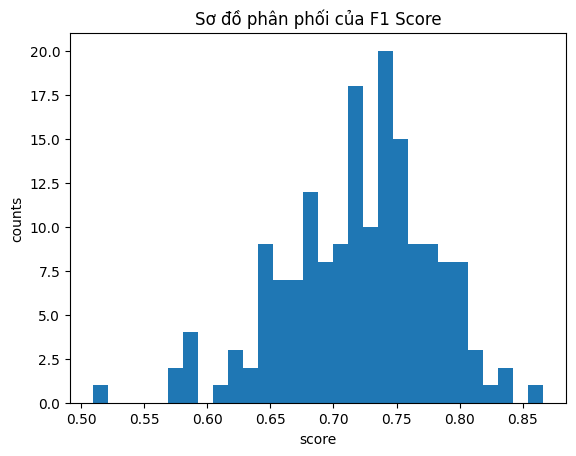

In [6]:
import matplotlib.pyplot as plt
plt.hist(F1, bins=30)
plt.xlabel("score")
plt.ylabel("counts")
plt.title("Sơ đồ phân phối của F1 Score")
plt.show()

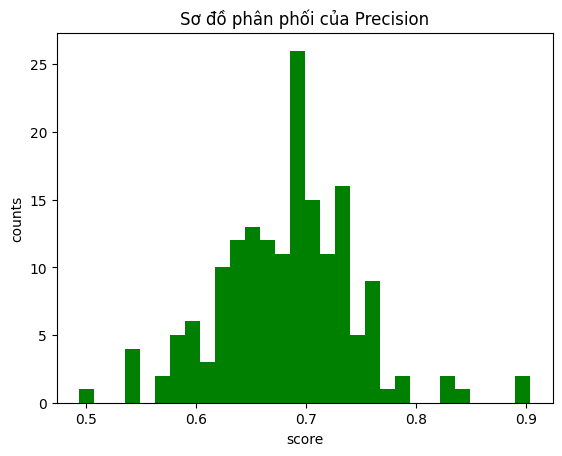

In [7]:
import matplotlib.pyplot as plt
plt.hist(P, bins=30,color="green")
plt.xlabel("score")
plt.ylabel("counts")
plt.title("Sơ đồ phân phối của Precision")
plt.show()

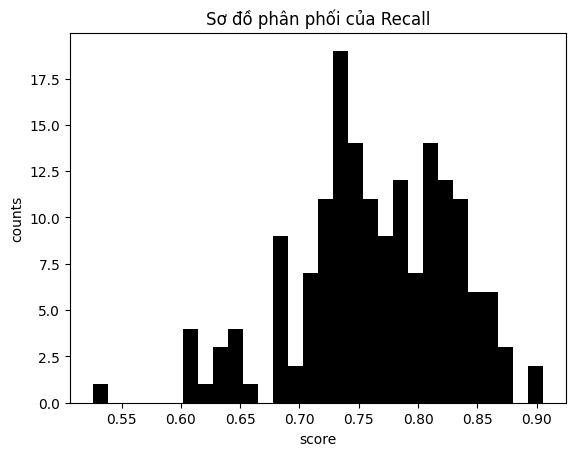

In [8]:
import matplotlib.pyplot as plt
plt.hist(R, bins=30,color="black")
plt.xlabel("score")
plt.ylabel("counts")
plt.title("Sơ đồ phân phối của Recall")
plt.show()